Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

1) Use industry returns from [Ken French](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

2) Forecast (for example) this month's Chemical industry return using last month's returns from all 30 industries 

3) Use LASSO for predictor subset selection over the entire 1960-2016 period to determine that e.g. Beer is predicted by Food, Clothing, Coal

4) Use LASSO-selected predictors and simple linear regression to predict returns

5) Generate portfolios and run backtests.

- Predictor selection - finds same predictors except 2 industries. Possibly use of AICc instead of AIC (don't see an sklearn implementation that uses AICc)

- Prediction by industry - R-squareds line up pretty closely

- Portfolio performance, similar ballpark results. Maybe AICc/AIC; Also paper standardizes predictors, which is pretty standard. Finally, for some reason their mean returns don't line up to geometric mean annualized, they seem to be calculating something different.

- Replicating exactly is hard but it does replicate closely and perform well

6) Run various sklearn regressors to see which performs best, understand metrics that predict performance. MSE does not predict Sharpe. Kendall's tau, i.e. correlation of predicted vs. actual rankings, performs better.

7) Tune ElasticNet to get slightly better performance than Lasso/OLS

8) Run Keras NNs. They don't improve on Lasso/OLS or ElasticNet.


 

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import time 
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.testing import all_estimators
import xgboost

from scipy.stats import chisquare, kendalltau

import tensorflow as tf
tf.set_random_seed(1764)
print(tf.__version__)
# confirm GPU is in use
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

import keras
from keras.layers.core import Dense, Activation
from keras.layers import Input
from keras.models import Model

from keras.layers.recurrent import LSTM, GRU
from keras.regularizers import l1
from keras.models import Sequential
from keras.models import load_model
    
#import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# this will make dataframe display as sortable widget
# commented out because sortable tables not viewable using nbviewer
#from beakerx import *

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1764)
np.random.seed(1764)


1.8.0
[[22. 28.]
 [49. 64.]]


Using TensorFlow backend.


### 1. Replicate paper

In [2]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


Food  Food.lead
yyyymm                  
195912   2.01      -4.49
196001  -4.49       3.35
196002   3.35      -1.67
196003  -1.67       1.17
196004   1.17       8.20
196005   8.20       5.39
196006   5.39      -2.11
196007  -2.11       4.57
196008   4.57      -3.88
196009  -3.88       1.02
196010   1.02       9.46
196011   9.46       4.51
196012   4.51       4.70
196101   4.70       4.21
196102   4.21       4.64
196103   4.64      -1.39
196104  -1.39       4.20
196105   4.20      -2.17
196106  -2.17       2.72
196107   2.72       4.92
196108   4.92      -0.62
196109  -0.62       3.73
196110   3.73       5.28
196111   5.28      -3.69
196112  -3.69      -6.67
196201  -6.67      -0.25
196202  -0.25       0.98
196203   0.98      -4.59
196204  -4.59     -11.25
196205 -11.25      -8.75
...       ...        ...
201507   4.03      -4.37
201508  -4.37      -1.19
201509  -1.19       5.81
201510   5.81       0.11
201511   0.11       1.96
201512   1.96      -1.67
201601  -1.67       0.95
201602   0.95       4.69
201603   4.69       0.63
201604   0.63       2.06
201605   2.06       4.75
201606   4.75      -0.51
201607  -0.51      -0.52
201608  -0.52      -2.92
201609  -2.92      -0.33
201610  -0.33      -4.41
201611  -4.41       4.43
201612   4.43       0.95
201701   0.95       1.71
201702   1.71       0.52
201703   0.52       0.76
201704   0.76       1.63
201705   1.63      -2.65
201706  -2.65       1.52
201707   1.52      -2.77
201708  -2.77       0.43
201709   0.43       0.71
201710   0.71       4.15
201711   4.15      -0.10
201712  -0.10       2.27

[697 rows x 2 columns]

In [3]:
# exclude 2017 and later to tie to paper
data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


Food  Beer  Smoke  Games  Books  Hshld  Clths   Hlth  Chems  Txtls  \
yyyymm                                                                        
195912   2.01  0.35  -3.02   1.64   7.29   0.67   1.87  -1.97   3.08   0.74   
196001  -4.49 -5.71  -2.05   1.21  -5.47  -7.84  -8.53  -6.68 -10.03  -4.77   
196002   3.35 -2.14   2.27   4.23   2.39   9.31   1.44  -0.02  -0.74   0.32   
196003  -1.67 -2.94  -0.18  -0.65   2.18  -0.56  -2.59   1.26  -2.75  -6.79   
196004   1.17 -2.16   1.35   6.46  -1.17  -1.27   0.21   1.49  -5.53  -1.10   
196005   8.20 -0.52   2.44   7.28  11.67   7.74   1.74  13.50   3.40   2.10   
196006   5.39  0.47   4.73   2.24   0.02   6.38  -1.59  -0.40   0.45   4.04   
196007  -2.11 -0.79   4.60  -4.72   0.23  -0.60  -1.10  -3.99  -6.80  -3.14   
196008   4.57  3.24   5.20   7.16   3.63   5.09   3.34   2.29   1.17  -0.84   
196009  -3.88 -5.00  -2.09  -2.33  -6.20  -9.18  -4.23  -8.87  -6.70  -5.25   
196010   1.02  0.54   3.87   0.11   2.38   6.48  -3.50  -3.71  -1.59  -3.06   
196011   9.46  6.57   5.44  13.91  10.11   9.13   3.15   3.91   4.25   2.04   
196012   4.51 -0.31   3.54   7.77   7.41   1.76   3.28   6.06   2.85   0.52   
196101   4.70  5.23   8.77   0.56   9.47   4.36   5.94   5.86   6.46  11.21   
196102   4.21  8.16   5.41  22.33   2.15   5.90   7.84   5.05   2.13   6.81   
196103   4.64  2.55   5.60   7.18   4.77   6.34   3.08   3.60   0.92   5.92   
196104  -1.39  1.40  -0.23  -2.21  -6.37   2.66   2.60  -0.47  -1.47  -5.31   
196105   4.20  5.38   3.39  -3.91   2.71  -0.02   6.80   2.10   5.50   5.47   
196106  -2.17 -3.12   3.97  -5.87  -3.85   3.43  -5.50  -3.58  -1.32  -3.36   
196107   2.72  0.88   5.95  -1.21  -2.55   1.97   2.03   3.27   2.95   1.53   
196108   4.92  3.20   7.74   0.89   0.89  10.45   5.21   3.70   2.35   5.77   
196109  -0.62 -1.48  -0.07   1.24   0.75  -3.05  -1.14  -1.48  -4.45  -4.25   
196110   3.73 -0.84   7.05  -5.26   0.99  -0.67   8.28   3.33   0.05   3.11   
196111   5.28  4.47   8.03   0.25   3.75   4.51   5.30   3.12   2.49   7.37   
196112  -3.69  1.41  -6.12   1.97  -3.66  -3.78   0.32  -2.21  -0.16  -1.17   
196201  -6.67 -3.45  -4.28 -13.23  -3.44  -7.37  -5.89  -4.86  -4.76   0.57   
196202  -0.25  0.28   0.68  -2.02  -0.52  -0.90   2.01   3.56   3.30   1.93   
196203   0.98 -0.34  -6.67  -5.34   0.41   4.31  -1.18   0.34  -2.72  -0.74   
196204  -4.59 -3.59 -12.99 -11.04  -8.74  -7.03  -8.01 -11.23  -6.23  -7.53   
196205 -11.25 -9.05 -14.14 -11.39 -14.87 -10.19 -10.01 -11.14  -8.25  -7.50   
...       ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
201407  -5.83 -2.92  -3.48  -3.70  -1.60  -2.62  -0.62  -0.33  -3.26  -5.70   
201408   6.38  5.46   5.08  -1.80   2.64   5.87   3.53   5.44   4.39  10.14   
201409  -0.53  0.83   2.15  -4.38  -7.29   0.84   4.44  -0.08  -2.14  -2.38   
201410   1.70  3.28   6.13   0.58   3.28   3.71   1.57   5.77  -1.09   2.08   
201411   5.68  4.35   0.76  -0.40   1.11   3.23   8.89   2.67   2.21   7.53   
201412  -2.48 -4.30  -3.11  -4.60   1.83   0.02  -0.82  -0.89   0.83  -0.31   
201501  -1.64  0.90   2.95   0.25  -2.18  -4.92  -3.75   1.56  -2.01   2.02   
201502   4.44  4.40   5.47   5.87   9.00   3.83   5.43   4.31   8.10  13.34   
201503  -0.72 -2.07  -8.82  -2.60   0.56  -1.98   1.23   0.86  -3.55   3.33   
201504  -0.17 -0.52   5.94   3.75  -4.11  -2.41  -1.53  -1.39   1.11  -5.95   
201505   2.03  2.00   1.28   0.71   1.93   0.39   0.04   4.89   1.24   4.37   
201506  -1.95 -1.71  -2.57   1.30  -0.84  -0.11   4.17   0.07  -2.72   4.09   
201507   4.03  3.51   9.59   6.09  -2.90   0.71   5.96   3.66  -4.90  -0.72   
201508  -4.37 -3.12  -4.06  -7.35  -8.61  -6.94  -3.86  -8.37  -7.15  -3.11   
201509  -1.19  2.58   2.37  -9.94  -5.32  -0.53   1.18  -7.28  -8.38  -5.92   
201510   5.81  8.06  10.90  14.61  12.21   5.81   0.98   7.74  16.62   7.96   
201511   0.11 -0.71  -3.00  -0.41  -1.17  -1.10  -1.08   0.71   1.68  -2.59   
201512   1.96  0.30   1.59  -1.70  -6.18   1.86  -4.38   0.

In [4]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

Food        Beer       Smoke       Games       Books       Hshld  \
count  685.000000  685.000000  685.000000  685.000000  685.000000  685.000000   
mean     0.690715    0.710613    0.982321    0.701708    0.528277    0.554190   
std      4.339811    5.090215    6.061582    7.180918    5.809314    4.759874   
min    -18.150000  -20.190000  -25.320000  -33.400000  -26.560000  -22.240000   
25%     -1.640000   -2.100000   -2.780000   -3.490000   -2.690000   -2.110000   
50%      0.740000    0.710000    1.280000    0.890000    0.510000    0.750000   
75%      3.120000    3.660000    4.640000    5.310000    3.720000    3.550000   
max     19.890000   25.510000   32.380000   34.520000   33.130000   18.220000   

            Clths        Hlth       Chems       Txtls     ...      Telcm.lead  \
count  685.000000  685.000000  685.000000  685.000000     ...      685.000000   
mean     0.669460    0.650905    0.519781    0.667416     ...        0.520847   
std      6.386027    4.928072    5.518477    7.022552     ...        4.628520   
min    -31.500000  -21.060000  -28.600000  -33.110000     ...      -16.440000   
25%     -2.810000   -2.240000   -2.800000   -3.200000     ...       -2.110000   
50%      0.690000    0.750000    0.670000    0.630000     ...        0.610000   
75%      4.310000    3.560000    3.760000    4.490000     ...        3.360000   
max     31.790000   29.010000   21.680000   59.030000     ...       21.220000   

       Servs.lead  BusEq.lead  Paper.lead  Trans.lead  Whlsl.lead  Rtail.lead  \
count  685.000000  685.000000  685.000000  685.000000  685.000000  685.000000   
mean     0.694234    0.584175    0.511241    0.582088    0.625562    0.662219   
std      6.527984    6.738979    5.055314    5.739306    5.605317    5.349341   
min    -28.670000  -32.070000  -27.740000  -28.500000  -29.250000  -29.740000   
25%     -3.090000   -3.290000   -2.430000   -2.780000   -2.570000   -2.430000   
50%      0.970000    0.560000    0.690000    0.860000    0.940000    0.470000   
75%      4.290000    4.590000    3.460000    4.060000    3.880000    4.000000   
max     23.380000   24.660000   21.000000   18.500000   17.530000   26.490000   

       Meals.lead    Fin.lead  Other.lead  
count  685.000000  685.000000  685.000000  
mean     0.702730    0.609810    0.385620  
std      6.104515    5.411766    5.815446  
min    -31.890000  -22.530000  -28.090000  
25%     -2.940000   -2.420000   -2.990000  
50%      1.030000    0.820000    0.470000  
75%      4.330000    4.000000    4.200000  
max     27.380000   20.590000   19.960000  

[8 rows x 60 columns]

In [5]:
# annualized returns don't match Table 1, oddly
# geometric mean, annualized
pd.DataFrame((np.prod(data/100 + 1)**(12.0/len(data))-1)[:30], columns=['Mean Ann. Return'])

Mean Ann. Return
Food           0.074020
Beer           0.072005
Smoke          0.100147
Games          0.054031
Books          0.043953
Hshld          0.054098
Clths          0.057170
Hlth           0.065463
Chems          0.044917
Txtls          0.051888
Cnstr          0.041836
Steel          0.002802
FabPr          0.045615
ElcEq          0.062927
Autos          0.027963
Carry          0.063991
Mines          0.032527
Coal           0.026075
Oil            0.062748
Util           0.049564
Telcm          0.050868
Servs          0.057776
BusEq          0.042774
Paper          0.046776
Trans          0.051138
Whlsl          0.057056
Rtail          0.064258
Meals          0.063630
Fin            0.056748
Other          0.024894

In [6]:
# try this way, arithmetic mean then annualize (not very correct)
#print(pd.DataFrame(((desc.loc['mean']/100+1)**12-1)[:30]))
#nope

# same
pd.DataFrame(((1 + np.mean(data, axis=0)/100)**12 -1)[:30], columns=['Mean Ann. Return'])

Mean Ann. Return
Food           0.086108
Beer           0.088687
Smoke          0.124460
Games          0.087532
Books          0.065268
Hshld          0.068568
Clths          0.083360
Hlth           0.080966
Chems          0.064188
Txtls          0.083096
Cnstr          0.064656
Steel          0.035833
FabPr          0.069639
ElcEq          0.087857
Autos          0.055859
Carry          0.089740
Mines          0.067862
Coal           0.091926
Oil            0.080976
Util           0.059601
Telcm          0.064437
Servs          0.085164
BusEq          0.071925
Paper          0.062952
Trans          0.072192
Whlsl          0.077332
Rtail          0.082704
Meals          0.088043
Fin            0.075605
Other          0.046240

In [7]:
#annualized volatility 
pd.DataFrame((desc.loc['std']*np.sqrt(12))[:30].round(2))
# lines up with table 1

std
Food   15.03
Beer   17.63
Smoke  21.00
Games  24.88
Books  20.12
Hshld  16.49
Clths  22.12
Hlth   17.07
Chems  19.12
Txtls  24.33
Cnstr  20.75
Steel  25.27
FabPr  21.18
ElcEq  21.52
Autos  23.17
Carry  21.80
Mines  25.82
Coal   35.31
Oil    18.53
Util   13.83
Telcm  16.04
Servs  22.61
BusEq  23.34
Paper  17.51
Trans  19.88
Whlsl  19.42
Rtail  18.53
Meals  21.15
Fin    18.75
Other  20.17

In [8]:
# Run LASSO, then OLS on selected variables

# skip last row to better match published r-squared
# looks like they forecast actuals 1960-2016 using 1959m12 to 2016m11
# not exact matches to Table 2 R-squared but almost within rounding error 
X = data.values[:-1,:npredictors]
Y = data.values[:-1,-nresponses:]
nrows = X.shape[0]
X.shape

(684, 30)

In [9]:
def subset_selection(X, Y, model_aic, verbose=False, responses=responses, predictors=predictors):
    
    nrows, npreds = X.shape
    nows, nresps = Y.shape
    coef_dict = []
    
    for response_index in range(nresps):
        y = Y[:,response_index]
        model_aic.fit(X, y)
        predcols = [i for i in range(npreds) if model_aic.coef_[i] !=0]

        #y_response = model_aic.predict(X)
        # print ("In-sample LASSO R-squared: %.6f" % r2_score(y, y_response))
        if verbose and responses:
            print("LASSO variables selected for %s: " % responses[response_index])
            print([predictors[i] for i in predcols])
        
        if not predcols:
            if verbose and responses:
                print("No coefs selected for " + responses[response_index] + ", using all")
                print("---")
            predcols = list(range(npreds))    
            
        # fit OLS vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        coef_dict.append(predcols)
        if verbose and responses and predictors:
            print("Running OLS for " + responses[response_index] + " against " + str([predictors[i] for i in predcols]))
            # col nums of selected responses
            model_ols = LinearRegression()
            model_ols.fit(X[:, predcols], y)
            y_pred = model_ols.predict(X[:, predcols])
            print ("In-sample OLS R-squared: %.2f%%" % (100 * r2_score(y, y_pred)))
            print("---")
            
    return coef_dict

#coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'))
coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'), verbose=True, responses=responses, predictors=predictors)
print(coef_dict)
# These subsets line up closely with Table 2
# except Clths, Whlsl, we get different responses

LASSO variables selected for Food.lead: 
['Clths', 'Coal', 'Util', 'Rtail']
Running OLS for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample OLS R-squared: 2.24%
---
LASSO variables selected for Beer.lead: 
['Food', 'Clths', 'Coal']
Running OLS for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample OLS R-squared: 2.52%
---
LASSO variables selected for Smoke.lead: 
['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Running OLS for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample OLS R-squared: 6.55%
---
LASSO variables selected for Games.lead: 
['Books', 'Clths', 'Coal', 'Fin']
Running OLS for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample OLS R-squared: 5.05%
---
LASSO variables selected for Books.lead: 
['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
Running OLS for Books.lead against ['Games', 'Books', 'Coal'

In [10]:
# same predictors selected for all but 2 response vars
# use predictors from paper to match results
if True: # turn off/on
    coef_dict_temp = {}
    coef_dict_temp['Food.lead'] = ['Clths', 'Coal', 'Util', 'Rtail']
    coef_dict_temp['Beer.lead'] = ['Food', 'Clths', 'Coal']
    coef_dict_temp['Smoke.lead'] = ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
    coef_dict_temp['Games.lead'] = ['Books', 'Clths', 'Coal', 'Fin']
    coef_dict_temp['Books.lead'] = ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Hshld.lead'] = ['Clths', 'Coal', 'Rtail']
    coef_dict_temp['Clths.lead'] = ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry',  'Coal', 'Oil', 'Util','Telcm', 'Servs', 'BusEq', 'Rtail']
    # Running OLS for Clths against ['Clths', 'Coal', 'Oil', 'Servs', 'Rtail']
    coef_dict_temp['Hlth.lead'] = ['Books', 'Mines', 'Coal', 'Util']
    coef_dict_temp['Chems.lead'] = ['Clths']
    coef_dict_temp['Txtls.lead'] = ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Cnstr.lead'] = ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
    coef_dict_temp['Steel.lead'] = ['Fin']
    coef_dict_temp['FabPr.lead'] = ['Trans', 'Fin']
    coef_dict_temp['ElcEq.lead'] = ['Fin']
    coef_dict_temp['Autos.lead'] = ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Carry.lead'] = ['Trans']
    coef_dict_temp['Mines.lead'] = []
    coef_dict_temp['Coal.lead'] = ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 'Oil', 'Paper', 'Rtail']
    coef_dict_temp['Oil.lead'] = ['Beer', 'Hlth', 'Carry']
    coef_dict_temp['Util.lead'] = ['Food', 'Beer', 'Smoke', 'Hshld', 'Hlth', 'Cnstr', 'FabPr', 'Carry', 'Mines', 'Oil', 'Util', 'Telcm', 'BusEq', 'Whlsl', 'Fin', 'Other']
    coef_dict_temp['Telcm.lead'] = ['Beer', 'Smoke', 'Books', 'Hshld', 'Cnstr', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Meals', 'Fin']
    coef_dict_temp['Servs.lead'] = ['Smoke', 'Books', 'Steel', 'Oil', 'Util', 'Fin']
    coef_dict_temp['BusEq.lead'] = ['Smoke', 'Books', 'Util']
    coef_dict_temp['Paper.lead'] = ['Clths', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Trans.lead'] = ['Fin']
    coef_dict_temp['Whlsl.lead'] = ['Food', 'Beer', 'Smoke', 'Books', 'Hlth', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Fin', 'Other']
    # Running OLS for Whlsl against ['Food', 'Smoke', 'Books', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'Fin', 'Other']
    coef_dict_temp['Rtail.lead'] = ['Rtail']
    coef_dict_temp['Meals.lead'] = ['Smoke', 'Books', 'Clths', 'Steel', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Meals', 'Fin']
    coef_dict_temp['Fin.lead'] = ['Fin']
    coef_dict_temp['Other.lead'] = ['Clths', 'Fin']
    
coef_dict_paper = []
for response in responses:
    print(response, " -> ", coef_dict_temp[response])
    coef_dict_paper.append([predictor_reverse_dict[jstr] for jstr in coef_dict_temp[response]])
print(coef_dict_paper)

Food.lead  ->  ['Clths', 'Coal', 'Util', 'Rtail']
Beer.lead  ->  ['Food', 'Clths', 'Coal']
Smoke.lead  ->  ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Games.lead  ->  ['Books', 'Clths', 'Coal', 'Fin']
Books.lead  ->  ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
Hshld.lead  ->  ['Clths', 'Coal', 'Rtail']
Clths.lead  ->  ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
Hlth.lead  ->  ['Books', 'Mines', 'Coal', 'Util']
Chems.lead  ->  ['Clths']
Txtls.lead  ->  ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
Cnstr.lead  ->  ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
Steel.lead  ->  ['Fin']
FabPr.lead  ->  ['Trans', 'Fin']
ElcEq.lead  ->  ['Fin']
Autos.lead  ->  ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
Carry.lead  ->  ['Trans']
Mines.lead  ->  []
Coal.lead  ->  ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 

In [11]:
def predict_with_subsets(X, Y, create_model, coef_dict, verbose=False):
    """evaluate subset selection, pass a model function and subsets, compute avg R-squared"""
    global responses

    nrows, ncols = Y.shape
    model = create_model()
    
    scores = []
    for response_col in range(ncols):
        y = Y[:,response_col]

#        print("LASSO variables selected for %s: " % pred)
#        print(coef_dict[pred])
        
        if not coef_dict[response_col]:
            if verbose:
                print("No coefs selected for " + responses[response_col])
 #           print("---")
            continue
        # fit model vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        #print("Running model for " + pred + " against " + str(coef_dict[pred]))
        # col nums of selected predictors
        predcols = coef_dict[response_col]
        model.fit(X[:, predcols], y)
        y_pred = model.predict(X[:, predcols])
        score = r2_score(y, y_pred)
        scores.append(score)
        if verbose:
            print ("In-sample R-squared: %.2f%% for %s against %s" % (score*100, responses[response_col], 
                                                                      str([predictors[i] for i in coef_dict[response_col]])))
#        print("---")
    
    if verbose:
        print("Mean R-squared: %.2f%%" % (100 * np.mean(np.array(scores))))
    return np.mean(np.array(scores))
    
predict_with_subsets(X, Y, LinearRegression, coef_dict_paper, verbose=True)


In-sample R-squared: 2.24% for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample R-squared: 2.52% for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample R-squared: 6.55% for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample R-squared: 5.05% for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample R-squared: 6.30% for Books.lead against ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
In-sample R-squared: 2.97% for Hshld.lead against ['Clths', 'Coal', 'Rtail']
In-sample R-squared: 7.82% for Clths.lead against ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
In-sample R-squared: 2.68% for Hlth.lead against ['Books', 'Mines', 'Coal', 'Util']
In-sample R-squared: 0.78% for Chems.lead against ['Clths']
In-sample R-squared: 7.91% for Txtls.lead against ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
In

0.038622786316912544

In [12]:
# use all predictors - higher in-sample R-squared
coef_dict_all = []
for _ in responses:
    coef_dict_all.append(range(len(predictors)))
predict_with_subsets(X, Y, LinearRegression, coef_dict_all, verbose=False)


0.06637486888237351

In [13]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [14]:
class PredictWrapper():
    """Wrap an sklearn model e.g. LinearRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it"""

    def __init__(self, create_model, coef_dict, fit_missing=None):
        self.create_model = create_model        
        self.coef_dict = coef_dict
        self.fit_missing = fit_missing
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            if self.coef_dict[responsecol]:
                # column indexes to fit against each other
                predcols = self.coef_dict[responsecol]
            else: # no columns selected
                if not self.fit_missing:
                    # default: don't fit if no predictors selected
                    self.models.append(None)
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "mean":
                    # append a numeric value to use
                    self.models.append(np.mean(Y_fit[:,responsecol]))
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "all":
                    # predcols = all columns
                    predcols = range(X_fit.shape[1])

            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit[:, predcols], Y_fit[:,responsecol])
            if verbose:
                print("fit on " + str(X_fit[:, predcols].shape) + str(predcols))
                print(model.coef_)
                            
            self.models.append(model)
                
            #debug
            #print(responsecol)
            #print(X_fit[:, predcols])
            #print("=====")
            #print(Y_fit[:,responsecol])
            #print("=====")
            #print(self.model.coef_)
            #print(self.model.intercept_)
            #print("=====")                

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            #print (type(self.models[responsecol]))
            if type(self.models[responsecol]) == np.float64:
                pred = np.array([self.models[responsecol]] * nrows).reshape(nrows,1)
                predictions.append(pred)
                sys.stdout.write('\010#')
            elif not self.models[responsecol]: 
                # don't predict
                predictions.append(np.array([np.nan] * nrows ).reshape(nrows,1))
                sys.stdout.write('\010N')
            else:
                predcols = self.coef_dict[responsecol]
                y_pred = self.models[responsecol].predict(X_predict[:,predcols])
                if verbose:
                    print("predict on" + str(X_predict[:, predcols].shape) + str(predcols))
                    print(y_pred)
                predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
        

### BacktestModel class to abstract walk-forward validation and backtesting workflow from modeling, portfolio construction, reporting

In [15]:
# typical pipeline
# backtestmodel = BacktestModel(X, # predictors
#                              Y, # responses
#                              create_model=LinearRegression, # create_model which returns a model (needed for 'timestep' which creates different model each timestep)
#                              # or model = someKerasModel, # initialized model that supports fit(X,Y), predict(X) , predicts an entire row,
#                              coef_dict_param=coef_dict_paper, # how to map predictors to responses ("all", "timestep", or a list of lists)
#                              startindex=FIRST_TRAIN_MONTHS, # initial training for backtest
#                              fit_missing='mean', # what to do when no predictors are selected in coef_dict_param - use all predictors, use historical mean, use np.nan
#                              scaler = None) # scaling function like MinMaxScaler

# backtestmodel.gen_predictions(verbose=False) # starting from startindex, step through X,Y month by month, fit up to current month, predict next month, store prediction in self.P
# backtestmodel.walkforward_xval(n_splits=5, verbose=True) # calls gen_predictions with a large step, fits and predicts one large fold at a time (useful to cross-validate quickly)
# backtestmodel.evaluate_predictions() # report metrics on prediction : MSE etc. #TODO: support custom calcs before/after/instead of default calcs
# backtestmodel.gen_returns(calc_returns, verbose=True) # takes a function that returns portfolio returns based on self.P, stores in self.R
# backtestmodel.report_returns(start_date=start_date_str, freq='M') # calc cumulative perf and report (TODO: allow it to take a reporting function to run before/after/in place of default report)
# backtestmodel.evaluate_quantiles(chart=True, verbose=True) # report quantile metrics # TODO: make this a custom calc passed into evaluate_predictions

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=False)
            
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        

    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        self.mse = np.mean(msetemp)
        print("OOS MSE across all predictions: %.4f" % self.mse)
        self.model.fit(self.Xscale, self.Yscale)
        Y_pred = self.model.predict(self.Xscale)
        self.in_sample_mse = np.mean((Y_pred - self.Yscale) ** 2)
        print("In-sample MSE: %.4f" % self.in_sample_mse)

        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- self.mse/y_variance))
        
        return(self.mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        self.kendalltaus = []
        self.ktpvals = []
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))
            kt, p_val = kendalltau(self.P[row], self.Y[row])
            self.kendalltaus.append(kt)
            self.ktpvals.append(p_val)

        self.kendalltau = np.mean(self.kendalltaus)
        self.kendalltau_pvalue = np.mean(self.ktpvals)         
        print("Avg rank correlation (Kendall's tau): %.4f (Expected: 0)" % (self.kendalltau))
        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols)
        self.quintile_accuracy = accuracy_score(pred_quantiles, true_quantiles)
        print("5-quintile accuracy: %.4f (Expected: 0.2)" % (self.quintile_accuracy))
        
        pred_direction = np.zeros(nrows*ncols)
        true_direction = np.zeros(nrows*ncols)
        for i in range(nrows*ncols):
            if pred_quantiles[i] == 4:
                pred_direction[i] = 1
            elif pred_quantiles[i] == 0:
                pred_direction[i] = -1
            if true_quantiles[i] == 4:
                true_direction[i] = 1
            elif true_quantiles[i] == 0:
                true_direction[i] = -1
        self.directional_accuracy = accuracy_score(pred_direction, true_direction)
        print("Long/short/flat accuracy: %.4f (Expected: 0.44)" % (self.directional_accuracy))
        
        nrows = nrows * ncols
            
        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])*nrows

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat5 = confusion_matrix(temp_pred, temp_actual)
            diff_mat = conf_mat5 - conf_mat_expected
            if verbose:
                print("Confusion matrix for quantile %d" % q)
                print(conf_mat5)
                cstmp, cspvtmp = chisquare(conf_mat5.reshape(4), conf_mat_expected.reshape(4))
                print("Chi-square: %.4f (p-value: %.8f)" % (cstmp, cspvtmp))

            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = diff_mat[1][1]
            myscores.append(myscore)

        # sum of true positive for top and bottom quintiles
        self.excess_tp = myscores[0] + myscores[4]
        print("Excess true positive in quintiles 1 + 5: %f" % (self.excess_tp))

        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual Quintile')
            plt.xlabel('Predicted Quintile')
            plt.show()
        
        return None

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.ycols
        longcount = [0] * self.ycols
        shortcount = [0] * self.ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
        if verbose:
            for i in range(len(responses)):
                print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                             longcount[i], 
                                                                             shortcount[i], 
                                                                             indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        self.results = self.R[first_pred_month:]
        nmonths = self.results.shape[0]
        nyears = nmonths/12.0
        index = pd.date_range(start_date,periods=nmonths, freq=freq)
        perfdata = pd.DataFrame(self.results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + self.results / 100)
        self.cumulative_return = perfdata['Equity']
        self.mean_monthly_return_annualized = np.mean(1 + self.results/100) ** 12 - 1
        self.mean_return = (self.cumulative_return[-1]/100) ** (1.0/nyears) - 1
        self.annualized_vol = np.std(self.results/100) * np.sqrt(12.0)
        self.sharpe = self.mean_monthly_return_annualized/self.annualized_vol
        print("Mean return: %.3f%%" % (self.mean_return * 100 ))
        #print("Mean monthly annualized return: %.3f%%" % (self.mean_monthly_return_annualized * 100 ))
        #print("Monthly annualized volatility: %.3f%%" % (self.annualized_vol * 100))
        print("Monthly Sharpe ratio: %.3f" % (self.sharpe))


In [16]:
# return calculation passed to gen_returns

NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns(prediction_row, return_row, numstocks=NUMSTOCKS, verbose=False):

    # ensure nan sorts to top for shorts
    short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
    # pick bottom numstocks
    select_array = np.argsort(short_sort_array)
    short_indexes = select_array[:numstocks]

    # ensure nan sorts to bottom for longs
    long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
    # pick top numstocks
    select_array = np.argsort(long_sort_array)
    long_indexes = select_array[-numstocks:]
    
    if verbose:
        print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
        print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

    # compute equal weighted long/short return
    return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes


In [17]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [18]:
# test fit_predict
backtestmodel = BacktestModel(X, Y, create_model=LinearRegression, coef_dict_param=coef_dict_all, startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=False))


[[ -4.70219919  -5.3073358   -3.72029191 -12.42448745  -6.62775756
   -2.90316148  -6.79960146  -2.23172984  -5.75101181  -6.66276641
   -5.75265368  -7.71979359  -6.57864566  -4.32124795  -5.0355927
   -5.92230241  -4.76675177  -1.96315925  -3.43369206  -2.30343164
   -3.72794445  -2.91917105  -5.27753906  -6.40474001  -6.85223288
  -10.16508667  -4.69016977  -8.8042513   -5.4481542   -6.40122815]
 [ -1.09819574   0.33751522   1.47276575  -7.65291563  -0.40550754
   -4.96855817  -1.82873168  -3.4663124   -2.05857985  -0.68158685
   -1.54307573  -2.74859589  -2.04412571  -1.77673237  -3.39612781
   -4.76047089  -0.65055072  -5.08513341   1.95082965  -2.60578312
   -5.09137205  -1.72203771  -3.31591182  -1.94755286  -1.38046013
   -2.75841651  -0.96353404  -6.81674253   1.34059086  -1.59466739]
 [ -1.96144894  -0.87682739  -3.02833064   0.58137733  -0.02056567
    1.67143038  -0.44895783  -1.70395859  -0.63283007  -0.4731534
   -0.71228211  -3.61106494  -1.93572984  -0.64937617  -1.0975

################################################################################.
22:14:33 Still training step 80 of 563
################################################################################.
22:14:34 Still training step 160 of 563
################################################################################.
22:14:35 Still training step 240 of 563
################################################################################.
22:14:36 Still training step 320 of 563
################################################################################.
22:14:37 Still training step 400 of 563
################################################################################.
22:14:38 Still training step 480 of 563
################################################################################.
22:14:39 Still training step 560 of 563
###.
Food: long 93 times, short 37 times, total 130 times
Beer: long 122 times, short 94 times, total 216 times
Smoke: long 211 times, shor

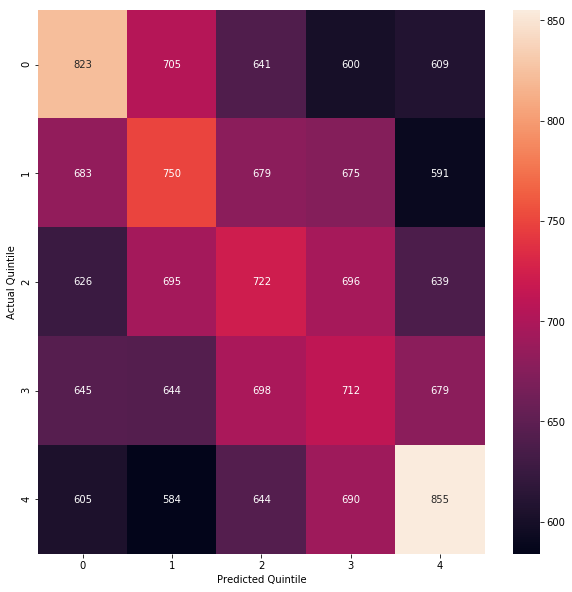

In [19]:
# test model on our calculated coef_dict
# bad methodology, introduces snooping
# selects LASSO vars over whole timespan
# uses selected vars to do OLS backtest
# included as an example of what not to do
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param=coef_dict_paper, 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)


### Functions using Plotly to generate charts for performance, scatters, heatmaps

In [20]:
# chart performance

def mychart(args, names=None, title=""):
    x_coords = np.linspace(1970, 2016, args[0].shape[0])
    plotdata = []
    for i in range(len(args)):
        tracelabel = "Trace %d" % i
        if names:
                tracelabel=names[i]
        plotdata.append(Scatter(x=x_coords,
                                y=args[i].values.reshape(-1),
                                mode = 'line',
                                name=tracelabel))    

    layout = Layout(
        title = title,
        autosize=False,
        width=900,
        height=600,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    


In [21]:
def myscatter(arg1, arg2, names=None, title=""):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))

    layout = dict(
        title=title,
        autosize=False,
        width="600",
        height="480",
        yaxis=dict(
#            type='log',
            autorange=True
        )
    )
    
#    py.iplot(data, filename='basic-scatter')

    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)

In [22]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['mse'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

### Compare LASSO, OLS models

In [23]:
perf_post_LASSO = backtestmodel.cumulative_return
mychart([perf_post_LASSO],["Post-LASSO"], title="Post-LASSO")


................................................................................
22:14:52 Still training step 80 of 563
................................................................................
22:15:05 Still training step 160 of 563
................................................................................
22:15:17 Still training step 240 of 563
................................................................................
22:15:28 Still training step 320 of 563
................................................................................
22:15:40 Still training step 400 of 563
................................................................................
22:15:51 Still training step 480 of 563
................................................................................
22:16:02 Still training step 560 of 563
...
Mean return: 3.545%
Monthly Sharpe ratio: 0.674
OOS MSE across all predictions: 41.4734
In-sample MSE: 35.7675
Variance: 39.4097
R-squared: -0.0524
Av

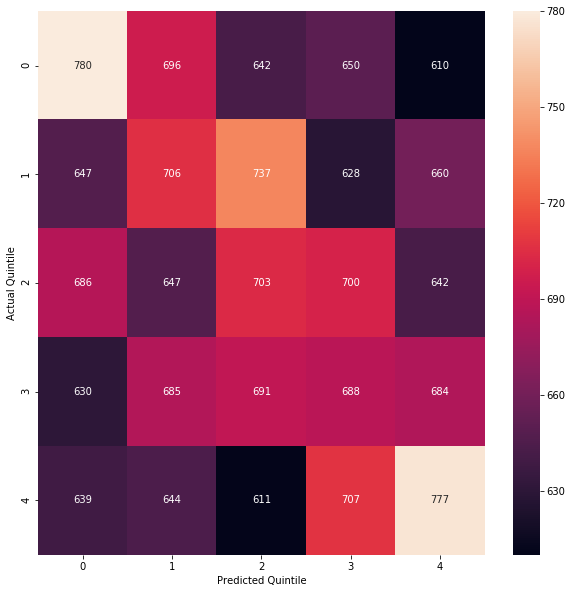

In [24]:
# do LASSO subset selection at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
perf_LASSO_each_timestep = backtestmodel.cumulative_return
mychart([perf_LASSO_each_timestep],["LASSO each timestep"], title="LASSO each timestep")



................................................................................
22:16:05 Still training step 80 of 563
................................................................................
22:16:07 Still training step 160 of 563
................................................................................
22:16:09 Still training step 240 of 563
................................................................................
22:16:11 Still training step 320 of 563
................................................................................
22:16:13 Still training step 400 of 563
................................................................................
22:16:15 Still training step 480 of 563
................................................................................
22:16:17 Still training step 560 of 563
...
Mean return: 2.781%
Monthly Sharpe ratio: 0.506
OOS MSE across all predictions: 43.8692
In-sample MSE: 34.7467
Variance: 39.4097
R-squared: -0.1132
Av

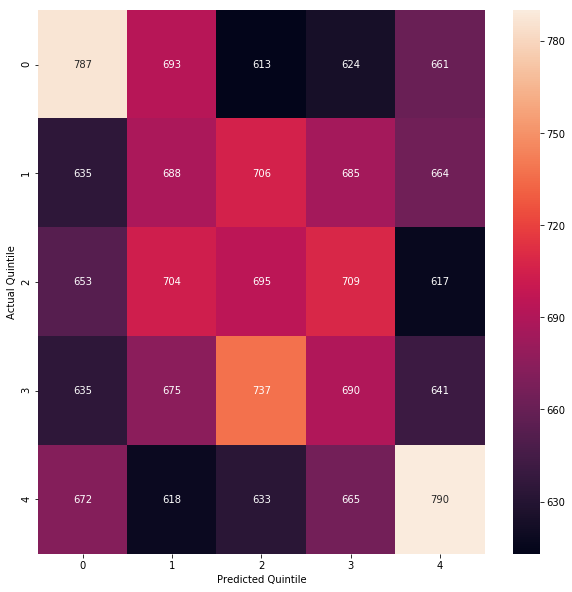

In [25]:
# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=False)
perf_all_preds = backtestmodel.cumulative_return
mychart([perf_all_preds],["All preds"], title="OLS all predictors")


................................................................................
22:16:29 Still training step 80 of 563
................................................................................
22:16:39 Still training step 160 of 563
................................................................................
22:16:49 Still training step 240 of 563
................................................................................
22:17:00 Still training step 320 of 563
................................................................................
22:17:11 Still training step 400 of 563
................................................................................
22:17:21 Still training step 480 of 563
................................................................................
22:17:32 Still training step 560 of 563
...
Mean return: 3.077%
Monthly Sharpe ratio: 0.553
OOS MSE across all predictions: 40.0227
In-sample MSE: 36.1107
Variance: 39.4097
R-squared: -0.0156
Av

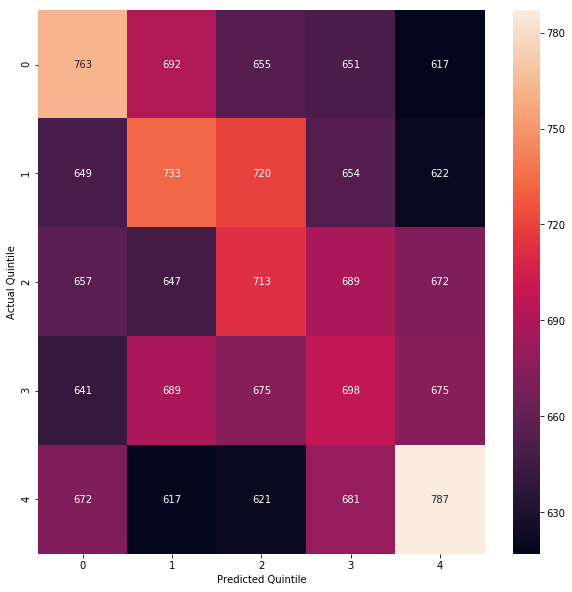

In [26]:
# pure LASSO (not LASSO followed by OLS on selected subset)
def create_model_lasso():
    return LassoLarsIC(criterion='aic')    
    
# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model_lasso, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=False)
perf_LASSO_only = backtestmodel.cumulative_return
mychart([perf_LASSO_only],["LASSO only"], title="LASSO only")


In [27]:
mychart([perf_LASSO_each_timestep, perf_all_preds, perf_LASSO_only],["LASSO / OLS", "OLS Only", "LASSO only"])

### Use walk-forward cross-validation to evaluate a variety of sklearn regression algos

In [46]:
# test walk-forward xval, get a baseline MSE for LinearRegression: ~41
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)

backtestmodel.walkforward_xval(n_splits=5, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)


18:47:17 Generate splits [137, 274, 411, 548, 684]
Steps: [137, 274, 411, 548]
Training on first 137 rows (0:136), putting predictions in rows range(137, 274)
.Training on first 274 rows (0:273), putting predictions in rows range(274, 411)
.Training on first 411 rows (0:410), putting predictions in rows range(411, 548)
.Training on first 548 rows (0:547), putting predictions in rows range(548, 684)
.
Mean return: 2.861%
Monthly Sharpe ratio: 0.575
OOS MSE across all predictions: 41.3994
In-sample MSE: 35.7131
Variance: 39.6015
R-squared: -0.0454
Avg rank correlation (Kendall's tau): 0.0253 (Expected: 0)
5-quintile accuracy: 0.2149 (Expected: 0.2)
Long/short/flat accuracy: 0.4562 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 170.200000


In [47]:
# try all the sklearn regression estimators
estimators = []

for name, class_ in all_estimators():
    if not issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict'):
            print(class_)
            estimators.append(class_)

<class 'sklearn.linear_model.bayes.ARDRegression'>
<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>
<class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>
<class 'sklearn.ensemble.bagging.BaggingRegressor'>
<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>
<class 'sklearn.linear_model.bayes.BayesianRidge'>
<class 'sklearn.cluster.birch.Birch'>
<class 'sklearn.cross_decomposition.cca_.CCA'>
<class 'sklearn.mixture.dpgmm.DPGMM'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>
<class 'sklearn.tree.tree.ExtraTreeRegressor'>
<class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
<class 'sklearn.mixture.gmm.GMM'>
<class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
<class 'sklearn.gaussian_process.gaussian_process.GaussianProcess'>
<class 'sklearn.gaussian_process.gpr.GaussianProcessRegressor'>
<class 'sklearn.ensemble.gr

In [48]:
# eliminate some that didn't work, gave errors, nans, maybe need correct parameters
estimators = [
    sklearn.ensemble.bagging.BaggingRegressor,
    sklearn.ensemble.forest.ExtraTreesRegressor,
    sklearn.ensemble.forest.RandomForestRegressor,
    sklearn.ensemble.gradient_boosting.GradientBoostingRegressor,
    #sklearn.ensemble.iforest.IsolationForest,
    sklearn.ensemble.weight_boosting.AdaBoostRegressor,
    #sklearn.gaussian_process.gpr.GaussianProcessRegressor,
    sklearn.kernel_ridge.KernelRidge,
    sklearn.linear_model.base.LinearRegression,
    #sklearn.linear_model.bayes.ARDRegression, # takes a couple of hours
    sklearn.linear_model.bayes.BayesianRidge,
    sklearn.linear_model.coordinate_descent.ElasticNet,
    sklearn.linear_model.coordinate_descent.ElasticNetCV,
    sklearn.linear_model.coordinate_descent.Lasso,
    sklearn.linear_model.coordinate_descent.LassoCV,
    sklearn.linear_model.huber.HuberRegressor,
    sklearn.linear_model.least_angle.Lars,
    sklearn.linear_model.least_angle.LarsCV,
    sklearn.linear_model.least_angle.LassoLars,
    sklearn.linear_model.least_angle.LassoLarsCV,
    sklearn.linear_model.least_angle.LassoLarsIC,
    sklearn.linear_model.omp.OrthogonalMatchingPursuit,
    sklearn.linear_model.omp.OrthogonalMatchingPursuitCV,
    sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor,
    sklearn.linear_model.ransac.RANSACRegressor,
    sklearn.linear_model.ridge.Ridge,
    sklearn.linear_model.ridge.RidgeCV,
    sklearn.linear_model.stochastic_gradient.SGDRegressor,
    #sklearn.linear_model.theil_sen.TheilSenRegressor, very slow
    #sklearn.mixture.bayesian_mixture.BayesianGaussianMixture,
    #sklearn.mixture.gaussian_mixture.GaussianMixture,
    sklearn.neighbors.regression.KNeighborsRegressor,
    #sklearn.neighbors.regression.RadiusNeighborsRegressor, returned nan
    #sklearn.neural_network.multilayer_perceptron.MLPRegressor, slow, tried above 
    sklearn.svm.classes.LinearSVR,
    sklearn.svm.classes.NuSVR,
    #sklearn.svm.classes.OneClassSVM,
    sklearn.svm.classes.SVR,
    sklearn.tree.tree.DecisionTreeRegressor,
    sklearn.tree.tree.ExtraTreeRegressor,
    xgboost.XGBRegressor,
]
 

sklearn.ensemble.bagging.BaggingRegressor
................................................................................
18:48:08 Still training step 80 of 563
................................................................................
18:49:12 Still training step 160 of 563
................................................................................
18:50:38 Still training step 240 of 563
................................................................................
18:52:28 Still training step 320 of 563
................................................................................
18:54:48 Still training step 400 of 563
................................................................................
18:57:39 Still training step 480 of 563
................................................................................
19:01:13 Still training step 560 of 563
...
Mean return: 1.622%
Monthly Sharpe ratio: 0.348
OOS MSE across all predictions: 46.3171
In-sample MSE: 7.759

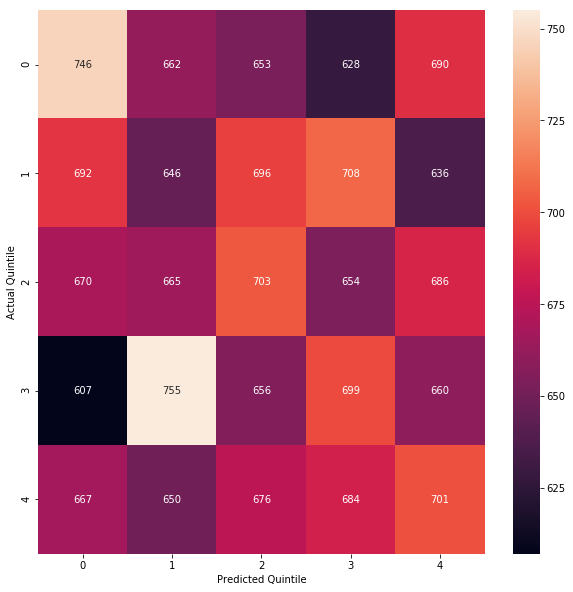

---
sklearn.ensemble.forest.ExtraTreesRegressor
................................................................................
19:01:56 Still training step 80 of 563
................................................................................
19:02:35 Still training step 160 of 563
................................................................................
19:03:23 Still training step 240 of 563
................................................................................
19:04:18 Still training step 320 of 563
................................................................................
19:05:22 Still training step 400 of 563
................................................................................
19:06:36 Still training step 480 of 563
................................................................................
19:08:01 Still training step 560 of 563
...
Mean return: 1.621%
Monthly Sharpe ratio: 0.348
OOS MSE across all predictions: 47.0459
In-sample MSE:

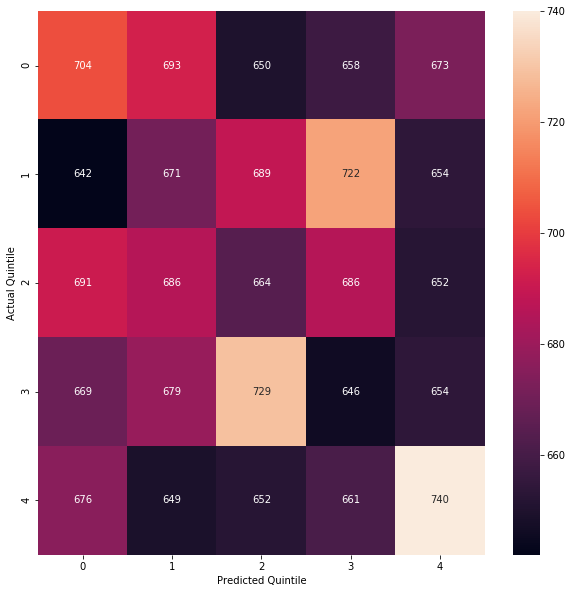

---
sklearn.ensemble.forest.RandomForestRegressor
................................................................................
19:08:51 Still training step 80 of 563
................................................................................
19:09:55 Still training step 160 of 563
................................................................................
19:11:20 Still training step 240 of 563
................................................................................
19:13:09 Still training step 320 of 563
................................................................................
19:15:28 Still training step 400 of 563
................................................................................
19:18:18 Still training step 480 of 563
................................................................................
19:21:48 Still training step 560 of 563
...
Mean return: 1.896%
Monthly Sharpe ratio: 0.426
OOS MSE across all predictions: 45.8743
In-sample MS

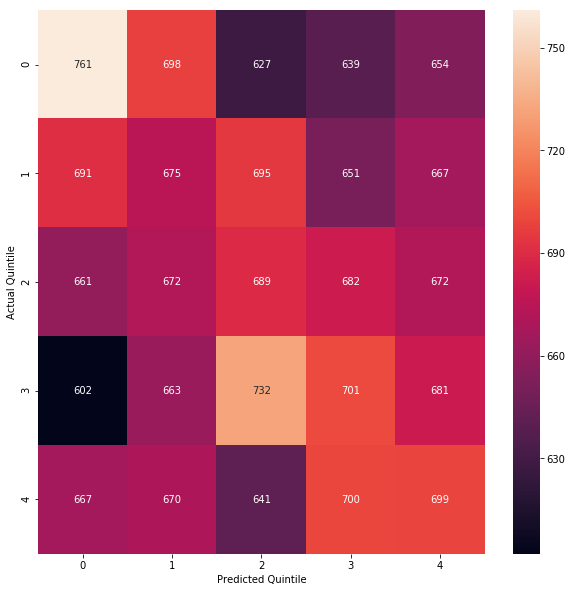

---
sklearn.ensemble.gradient_boosting.GradientBoostingRegressor
................................................................................
19:23:32 Still training step 80 of 563
................................................................................
19:25:28 Still training step 160 of 563
................................................................................
19:27:54 Still training step 240 of 563
................................................................................
19:30:45 Still training step 320 of 563
................................................................................
19:34:04 Still training step 400 of 563
................................................................................
19:37:53 Still training step 480 of 563
................................................................................
19:42:09 Still training step 560 of 563
...
Mean return: 2.007%
Monthly Sharpe ratio: 0.439
OOS MSE across all predictions: 46.72

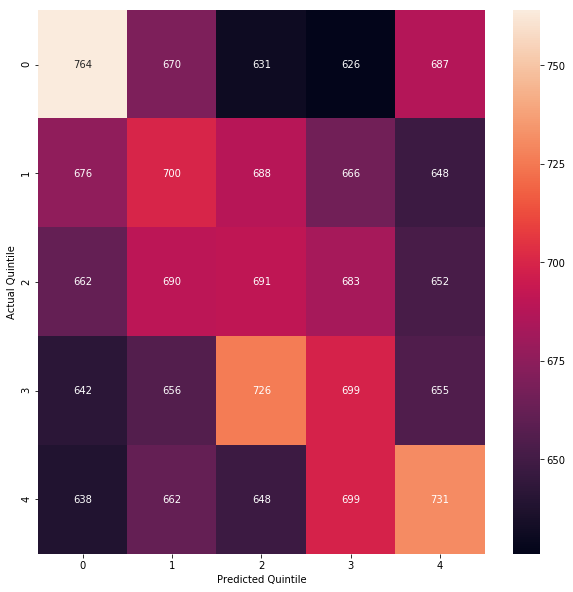

---
sklearn.ensemble.weight_boosting.AdaBoostRegressor
................................................................................
19:44:57 Still training step 80 of 563
................................................................................
19:47:55 Still training step 160 of 563
................................................................................
19:51:22 Still training step 240 of 563
................................................................................
19:55:17 Still training step 320 of 563
................................................................................
19:59:41 Still training step 400 of 563
................................................................................
20:04:36 Still training step 480 of 563
................................................................................
20:09:49 Still training step 560 of 563
...
Mean return: 2.121%
Monthly Sharpe ratio: 0.455
OOS MSE across all predictions: 42.6787
In-samp

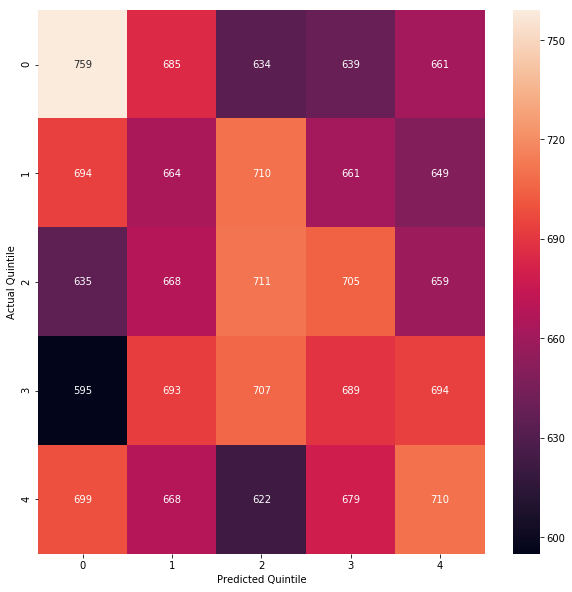

---
sklearn.kernel_ridge.KernelRidge
................................................................................
20:10:08 Still training step 80 of 563
................................................................................
20:10:10 Still training step 160 of 563
................................................................................
20:10:13 Still training step 240 of 563
................................................................................
20:10:18 Still training step 320 of 563
................................................................................
20:10:23 Still training step 400 of 563
................................................................................
20:10:29 Still training step 480 of 563
................................................................................
20:10:38 Still training step 560 of 563
...
Mean return: 2.553%
Monthly Sharpe ratio: 0.471
OOS MSE across all predictions: 44.0938
In-sample MSE: 35.0781
Va

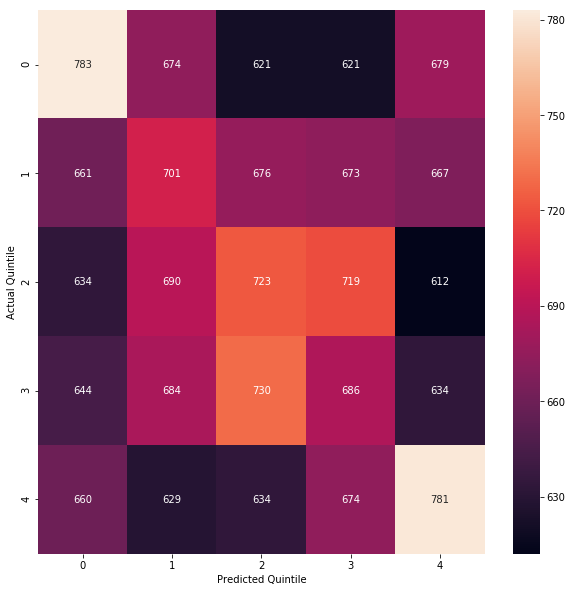

---
sklearn.linear_model.base.LinearRegression
................................................................................
20:10:41 Still training step 80 of 563
................................................................................
20:10:43 Still training step 160 of 563
................................................................................
20:10:45 Still training step 240 of 563
................................................................................
20:10:47 Still training step 320 of 563
................................................................................
20:10:50 Still training step 400 of 563
................................................................................
20:10:52 Still training step 480 of 563
................................................................................
20:10:54 Still training step 560 of 563
...
Mean return: 2.781%
Monthly Sharpe ratio: 0.506
OOS MSE across all predictions: 43.8692
In-sample MSE: 

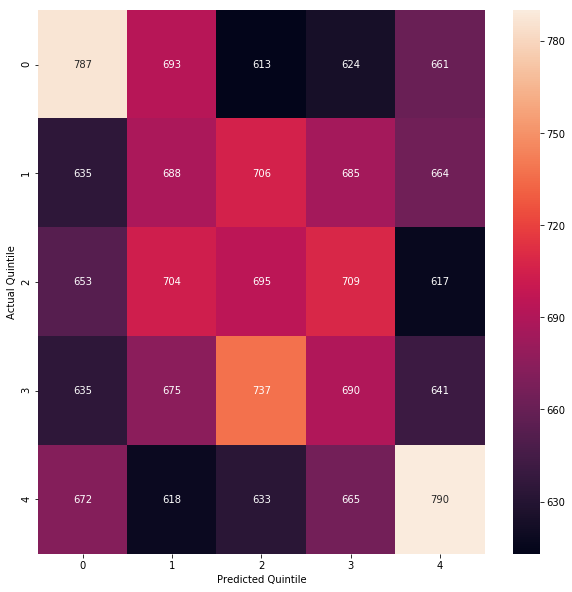

---
sklearn.linear_model.bayes.BayesianRidge
................................................................................
20:10:59 Still training step 80 of 563
................................................................................
20:11:03 Still training step 160 of 563
................................................................................
20:11:07 Still training step 240 of 563
................................................................................
20:11:11 Still training step 320 of 563
................................................................................
20:11:15 Still training step 400 of 563
................................................................................
20:11:19 Still training step 480 of 563
................................................................................
20:11:23 Still training step 560 of 563
...
Mean return: 3.688%
Monthly Sharpe ratio: 0.617
OOS MSE across all predictions: 39.7450
In-sample MSE: 36

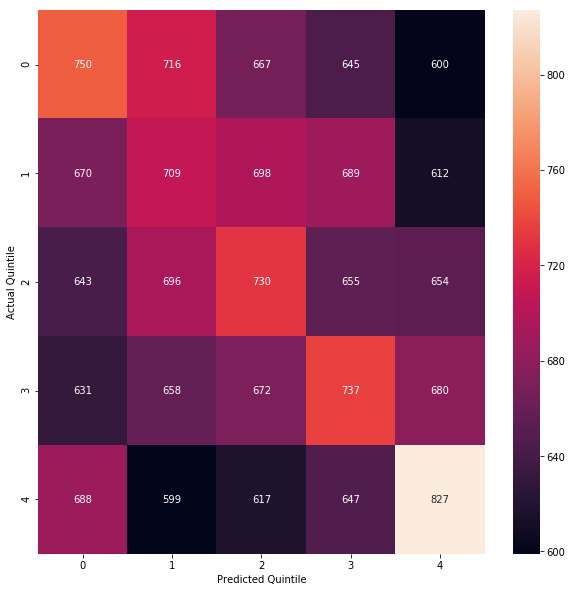

---
sklearn.linear_model.coordinate_descent.ElasticNet
................................................................................
20:11:26 Still training step 80 of 563
................................................................................
20:11:28 Still training step 160 of 563
................................................................................
20:11:30 Still training step 240 of 563
................................................................................
20:11:31 Still training step 320 of 563
................................................................................
20:11:33 Still training step 400 of 563
................................................................................
20:11:35 Still training step 480 of 563
................................................................................
20:11:37 Still training step 560 of 563
...
Mean return: 3.145%
Monthly Sharpe ratio: 0.530
OOS MSE across all predictions: 40.8226
In-samp

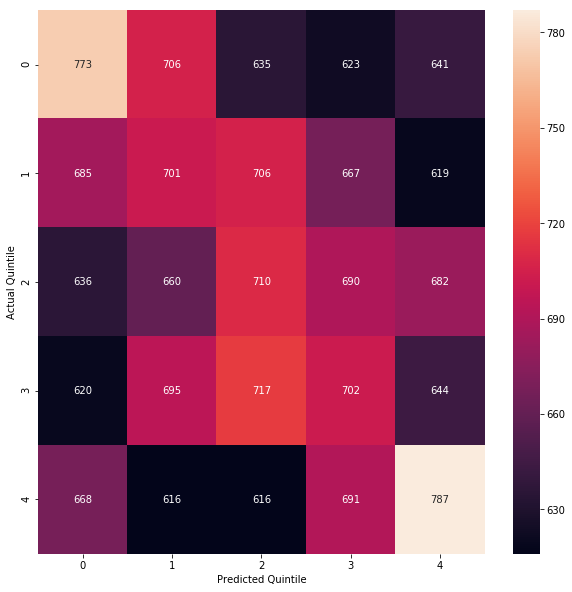

---
sklearn.linear_model.coordinate_descent.ElasticNetCV
................................................................................
20:14:07 Still training step 80 of 563
................................................................................
20:16:08 Still training step 160 of 563
................................................................................
20:17:57 Still training step 240 of 563
................................................................................
20:19:37 Still training step 320 of 563
................................................................................
20:21:10 Still training step 400 of 563
................................................................................
20:22:32 Still training step 480 of 563
................................................................................
20:24:02 Still training step 560 of 563
...
Mean return: 3.551%
Monthly Sharpe ratio: 0.632
OOS MSE across all predictions: 39.8834
In-sa

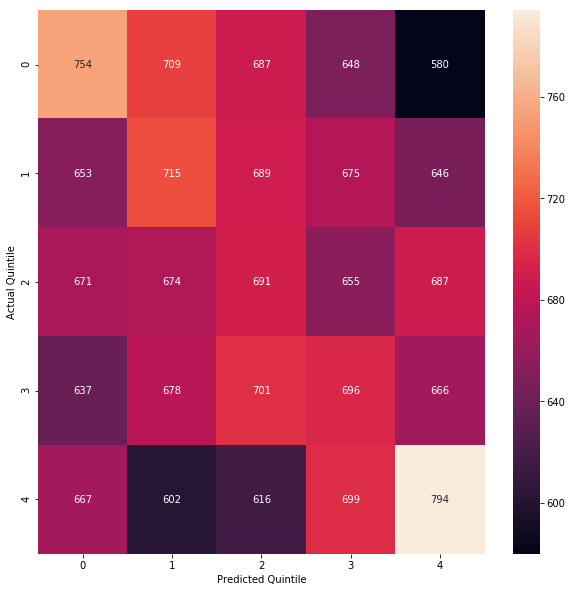

---
sklearn.linear_model.coordinate_descent.Lasso
................................................................................
20:24:08 Still training step 80 of 563
................................................................................
20:24:09 Still training step 160 of 563
................................................................................
20:24:11 Still training step 240 of 563
................................................................................
20:24:12 Still training step 320 of 563
................................................................................
20:24:13 Still training step 400 of 563
................................................................................
20:24:15 Still training step 480 of 563
................................................................................
20:24:16 Still training step 560 of 563
...
Mean return: 3.739%
Monthly Sharpe ratio: 0.639
OOS MSE across all predictions: 40.1141
In-sample MS

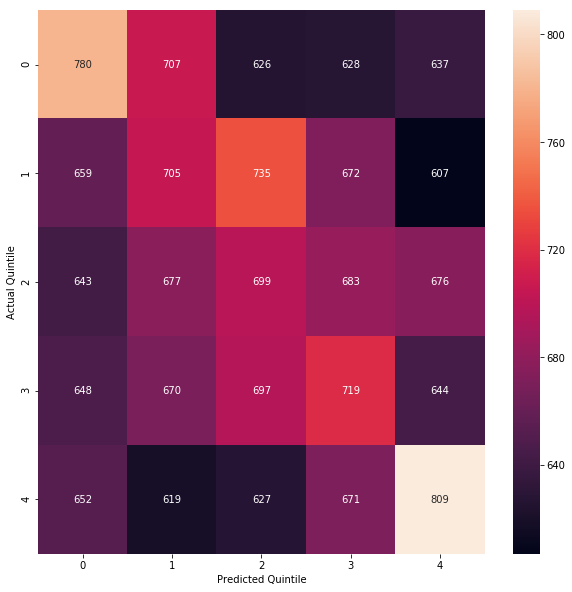

---
sklearn.linear_model.coordinate_descent.LassoCV
................................................................................
20:26:33 Still training step 80 of 563
................................................................................
20:28:42 Still training step 160 of 563
................................................................................
20:30:37 Still training step 240 of 563
................................................................................
20:32:20 Still training step 320 of 563
................................................................................
20:33:53 Still training step 400 of 563
................................................................................
20:35:20 Still training step 480 of 563
................................................................................
20:36:46 Still training step 560 of 563
...
Mean return: 3.323%
Monthly Sharpe ratio: 0.587
OOS MSE across all predictions: 39.9025
In-sample 

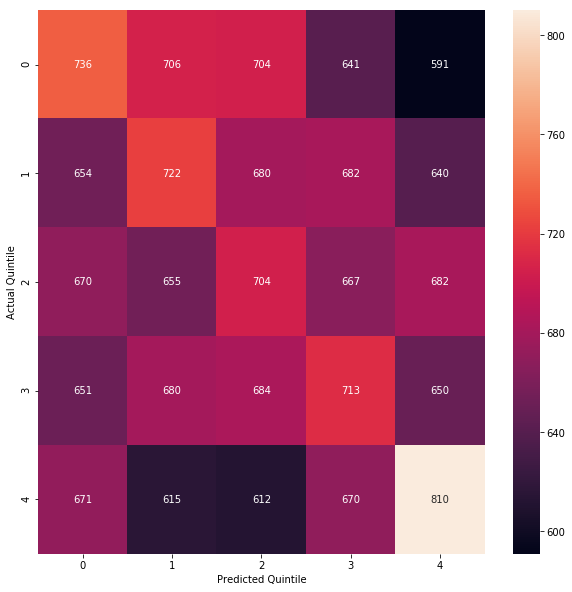

---
sklearn.linear_model.huber.HuberRegressor
................................................................................
20:37:15 Still training step 80 of 563
................................................................................
20:37:38 Still training step 160 of 563
................................................................................
20:38:04 Still training step 240 of 563
................................................................................
20:38:30 Still training step 320 of 563
................................................................................
20:38:57 Still training step 400 of 563
................................................................................
20:39:24 Still training step 480 of 563
................................................................................
20:39:53 Still training step 560 of 563
...
Mean return: 1.166%
Monthly Sharpe ratio: 0.237
OOS MSE across all predictions: 43.6486
In-sample MSE: 3

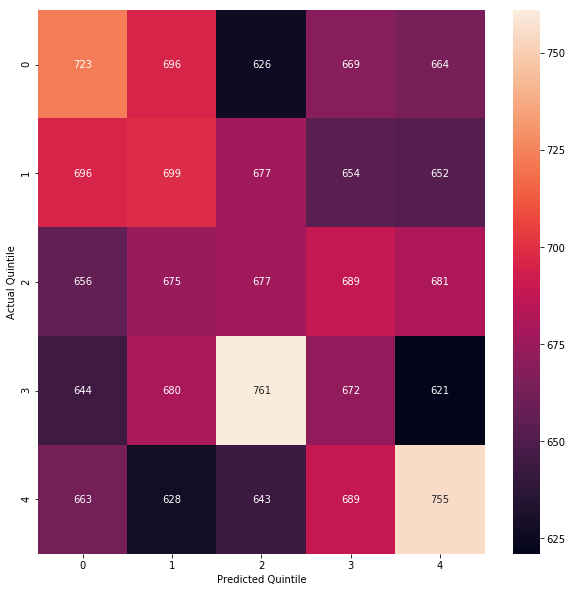

---
sklearn.linear_model.least_angle.Lars
................................................................................
20:40:07 Still training step 80 of 563
................................................................................
20:40:18 Still training step 160 of 563
................................................................................
20:40:29 Still training step 240 of 563
................................................................................
20:40:40 Still training step 320 of 563
................................................................................
20:40:50 Still training step 400 of 563
................................................................................
20:41:00 Still training step 480 of 563
................................................................................
20:41:11 Still training step 560 of 563
...
Mean return: 2.210%
Monthly Sharpe ratio: 0.414
OOS MSE across all predictions: 44.4498
In-sample MSE: 35.03

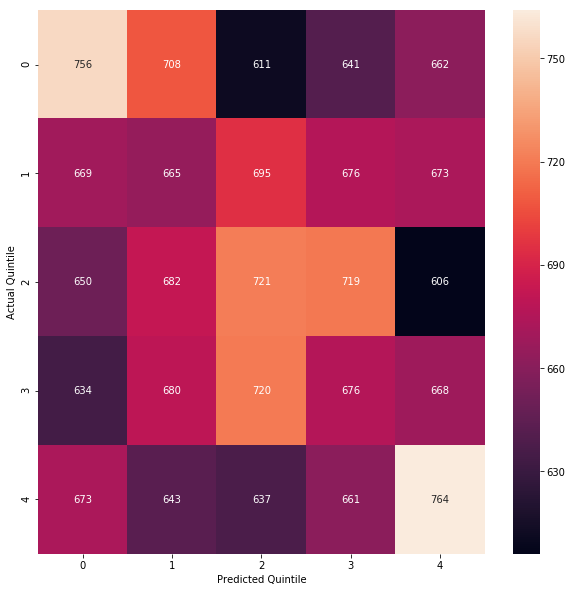

---
sklearn.linear_model.least_angle.LarsCV
................................................................................
20:41:47 Still training step 80 of 563
................................................................................
20:42:20 Still training step 160 of 563
................................................................................
20:42:54 Still training step 240 of 563
................................................................................
20:43:27 Still training step 320 of 563
................................................................................
20:44:01 Still training step 400 of 563
................................................................................
20:44:35 Still training step 480 of 563
................................................................................
20:45:10 Still training step 560 of 563
...
Mean return: 2.888%
Monthly Sharpe ratio: 0.555
OOS MSE across all predictions: 39.8423
In-sample MSE: 36.

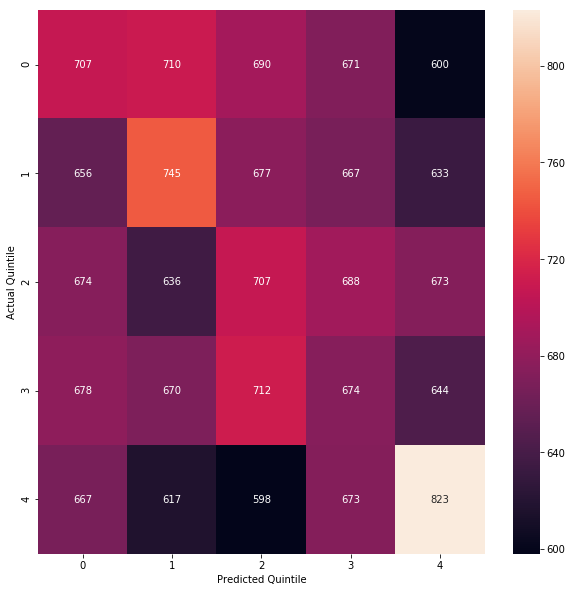

---
sklearn.linear_model.least_angle.LassoLars
................................................................................
20:45:14 Still training step 80 of 563
................................................................................
20:45:15 Still training step 160 of 563
................................................................................
20:45:16 Still training step 240 of 563
................................................................................
20:45:17 Still training step 320 of 563
................................................................................
20:45:18 Still training step 400 of 563
................................................................................
20:45:20 Still training step 480 of 563
................................................................................
20:45:21 Still training step 560 of 563
...
Mean return: -1.129%
Monthly Sharpe ratio: -0.178
OOS MSE across all predictions: 39.8418
In-sample MSE

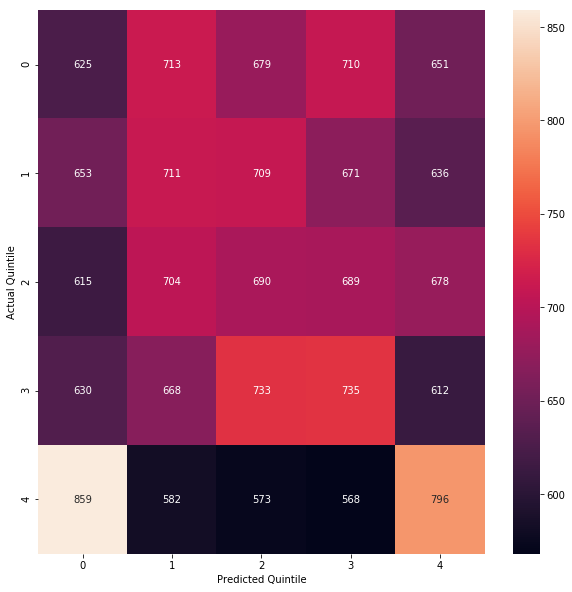

---
sklearn.linear_model.least_angle.LassoLarsCV
................................................................................
20:45:59 Still training step 80 of 563
................................................................................
20:46:33 Still training step 160 of 563
................................................................................
20:47:08 Still training step 240 of 563
................................................................................
20:47:42 Still training step 320 of 563
................................................................................
20:48:17 Still training step 400 of 563
................................................................................
20:48:53 Still training step 480 of 563
................................................................................
20:49:29 Still training step 560 of 563
...
Mean return: 3.084%
Monthly Sharpe ratio: 0.594
OOS MSE across all predictions: 39.8093
In-sample MSE

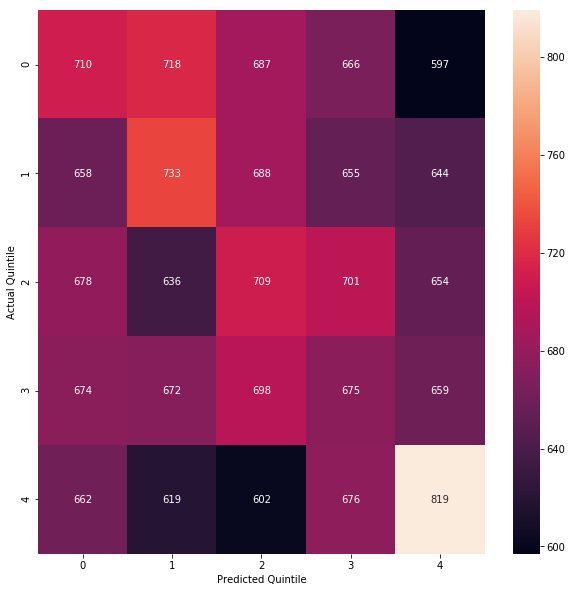

---
sklearn.linear_model.least_angle.LassoLarsIC
................................................................................
20:49:43 Still training step 80 of 563
................................................................................
20:49:56 Still training step 160 of 563
................................................................................
20:50:07 Still training step 240 of 563
................................................................................
20:50:20 Still training step 320 of 563
................................................................................
20:50:31 Still training step 400 of 563
................................................................................
20:50:42 Still training step 480 of 563
................................................................................
20:50:53 Still training step 560 of 563
...
Mean return: 3.077%
Monthly Sharpe ratio: 0.553
OOS MSE across all predictions: 40.0227
In-sample MSE

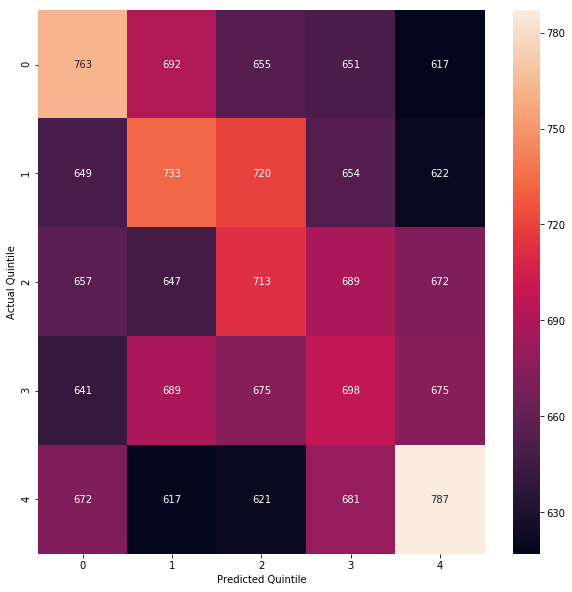

---
sklearn.linear_model.omp.OrthogonalMatchingPursuit
................................................................................
20:50:57 Still training step 80 of 563
................................................................................
20:50:58 Still training step 160 of 563
................................................................................
20:51:00 Still training step 240 of 563
................................................................................
20:51:01 Still training step 320 of 563
................................................................................
20:51:03 Still training step 400 of 563
................................................................................
20:51:05 Still training step 480 of 563
................................................................................
20:51:06 Still training step 560 of 563
...
Mean return: 3.374%
Monthly Sharpe ratio: 0.635
OOS MSE across all predictions: 40.8778
In-samp

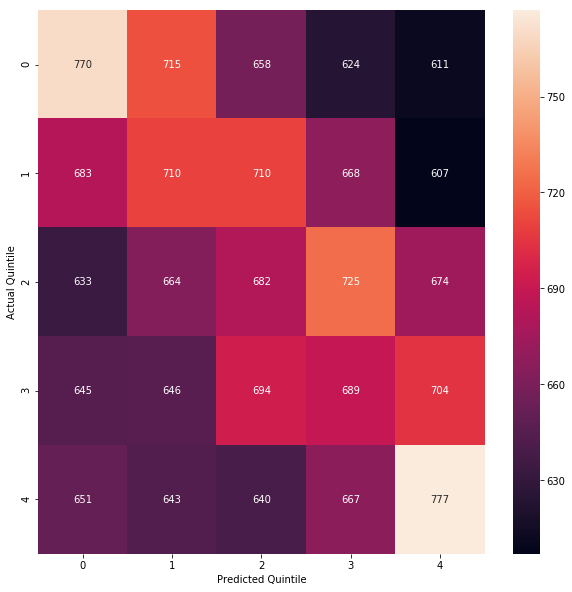

---
sklearn.linear_model.omp.OrthogonalMatchingPursuitCV
................................................................................
20:51:14 Still training step 80 of 563
................................................................................
20:51:20 Still training step 160 of 563
................................................................................
20:51:27 Still training step 240 of 563
................................................................................
20:51:34 Still training step 320 of 563
................................................................................
20:51:41 Still training step 400 of 563
................................................................................
20:51:48 Still training step 480 of 563
................................................................................
20:51:56 Still training step 560 of 563
...
Mean return: 2.559%
Monthly Sharpe ratio: 0.485
OOS MSE across all predictions: 40.2359
In-sa

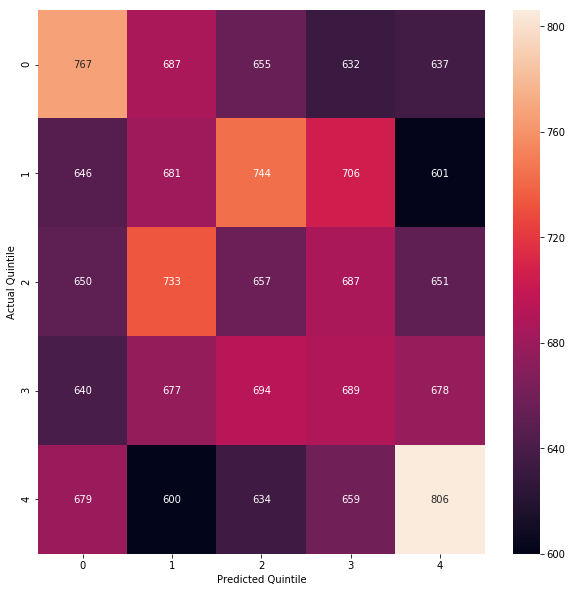

---
sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor
................................................................................
20:51:59 Still training step 80 of 563
................................................................................
20:52:00 Still training step 160 of 563
................................................................................
20:52:01 Still training step 240 of 563
................................................................................
20:52:02 Still training step 320 of 563
................................................................................
20:52:03 Still training step 400 of 563
................................................................................
20:52:05 Still training step 480 of 563
................................................................................
20:52:07 Still training step 560 of 563
...
Mean return: 0.651%
Monthly Sharpe ratio: 0.171
OOS MSE across all predictions:

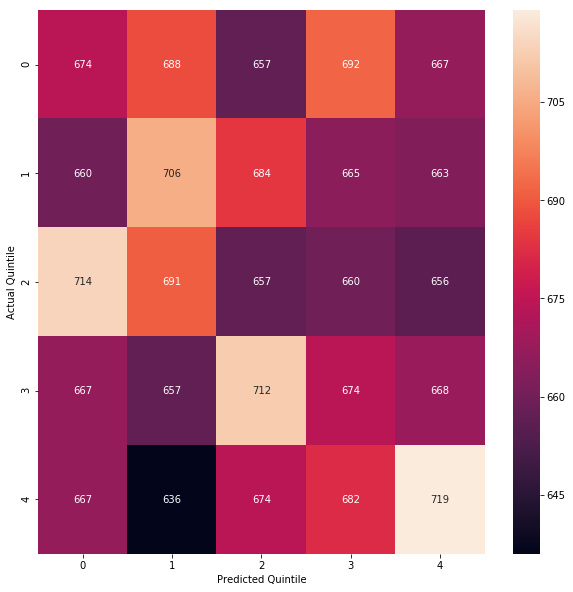

---
sklearn.linear_model.ransac.RANSACRegressor
................................................................................
20:54:04 Still training step 80 of 563
................................................................................
20:55:56 Still training step 160 of 563
................................................................................
20:57:55 Still training step 240 of 563
................................................................................
20:59:51 Still training step 320 of 563
................................................................................
21:01:48 Still training step 400 of 563
................................................................................
21:03:43 Still training step 480 of 563
................................................................................
21:05:55 Still training step 560 of 563
...
Mean return: 0.151%
Monthly Sharpe ratio: 0.057
OOS MSE across all predictions: 211.3817
In-sample MSE

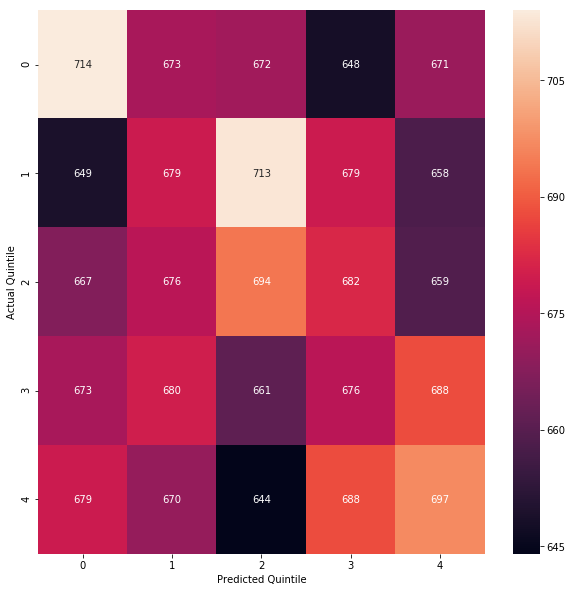

---
sklearn.linear_model.ridge.Ridge
................................................................................
21:06:04 Still training step 80 of 563
................................................................................
21:06:05 Still training step 160 of 563
................................................................................
21:06:06 Still training step 240 of 563
................................................................................
21:06:08 Still training step 320 of 563
................................................................................
21:06:09 Still training step 400 of 563
................................................................................
21:06:11 Still training step 480 of 563
................................................................................
21:06:12 Still training step 560 of 563
...
Mean return: 2.772%
Monthly Sharpe ratio: 0.504
OOS MSE across all predictions: 43.8617
In-sample MSE: 34.7467
Va

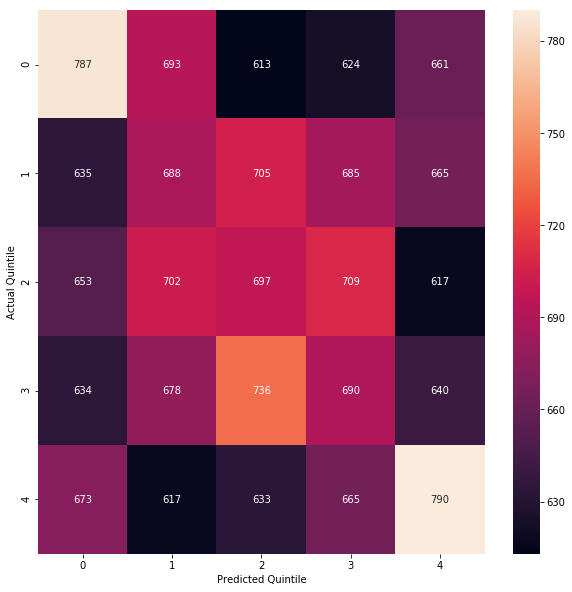

---
sklearn.linear_model.ridge.RidgeCV
................................................................................
21:06:16 Still training step 80 of 563
................................................................................
21:06:19 Still training step 160 of 563
................................................................................
21:06:22 Still training step 240 of 563
................................................................................
21:06:25 Still training step 320 of 563
................................................................................
21:06:29 Still training step 400 of 563
................................................................................
21:06:32 Still training step 480 of 563
................................................................................
21:06:36 Still training step 560 of 563
...
Mean return: 2.762%
Monthly Sharpe ratio: 0.502
OOS MSE across all predictions: 43.7969
In-sample MSE: 34.7467


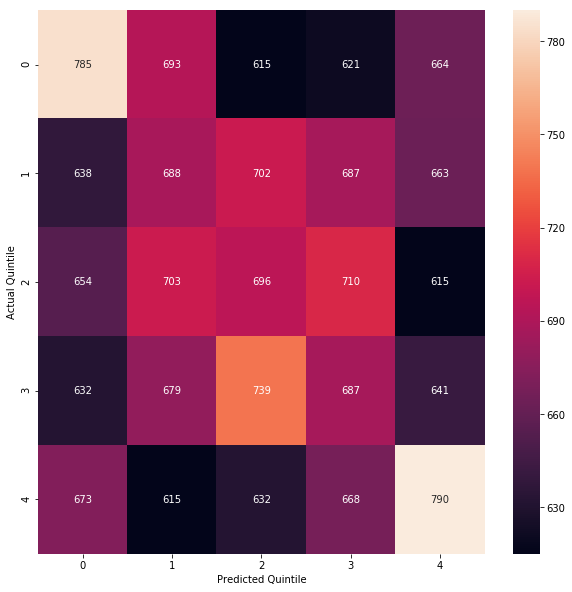

---
sklearn.linear_model.stochastic_gradient.SGDRegressor
................................................................................
21:06:38 Still training step 80 of 563
................................................................................
21:06:39 Still training step 160 of 563
................................................................................
21:06:40 Still training step 240 of 563
................................................................................
21:06:42 Still training step 320 of 563
................................................................................
21:06:43 Still training step 400 of 563
................................................................................
21:06:45 Still training step 480 of 563
................................................................................
21:06:47 Still training step 560 of 563
...
Mean return: -0.595%
Monthly Sharpe ratio: -0.117
OOS MSE across all predictions: 5714048384

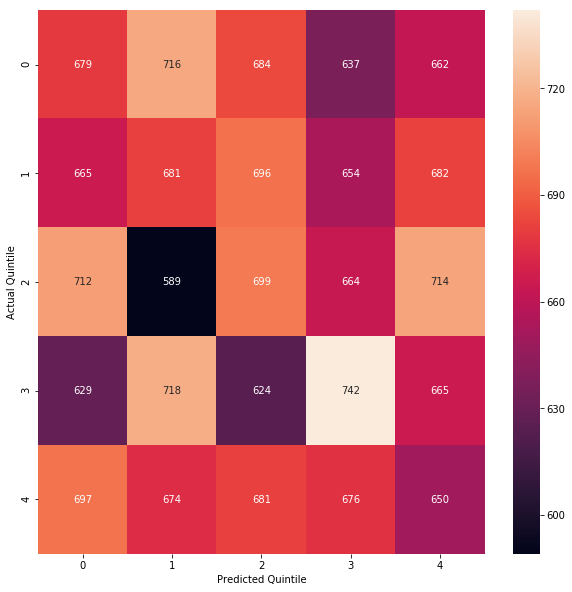

---
sklearn.neighbors.regression.KNeighborsRegressor
................................................................................
21:06:49 Still training step 80 of 563
................................................................................
21:06:51 Still training step 160 of 563
................................................................................
21:06:52 Still training step 240 of 563
................................................................................
21:06:54 Still training step 320 of 563
................................................................................
21:06:55 Still training step 400 of 563
................................................................................
21:06:57 Still training step 480 of 563
................................................................................
21:06:59 Still training step 560 of 563
...
Mean return: 2.146%
Monthly Sharpe ratio: 0.425
OOS MSE across all predictions: 43.9342
In-sample

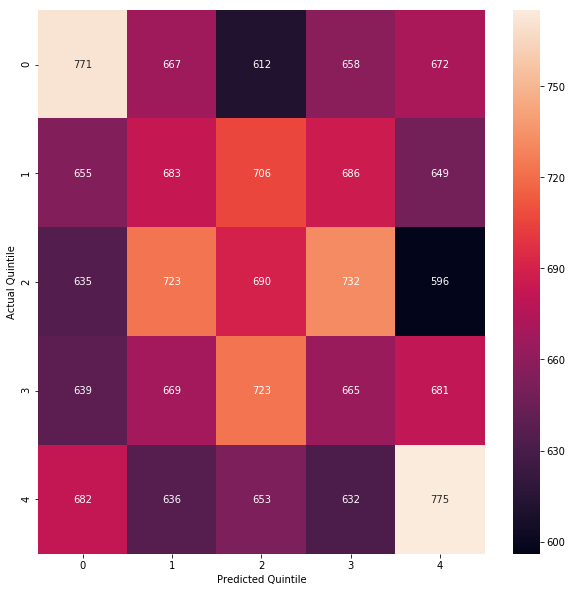

---
sklearn.svm.classes.LinearSVR
................................................................................
21:07:21 Still training step 80 of 563
................................................................................
21:07:51 Still training step 160 of 563
................................................................................
21:08:32 Still training step 240 of 563
................................................................................
21:09:24 Still training step 320 of 563
................................................................................
21:10:28 Still training step 400 of 563
................................................................................
21:11:43 Still training step 480 of 563
................................................................................
21:13:13 Still training step 560 of 563
...
Mean return: 1.406%
Monthly Sharpe ratio: 0.294
OOS MSE across all predictions: 45.2418
In-sample MSE: 36.4204
Varia

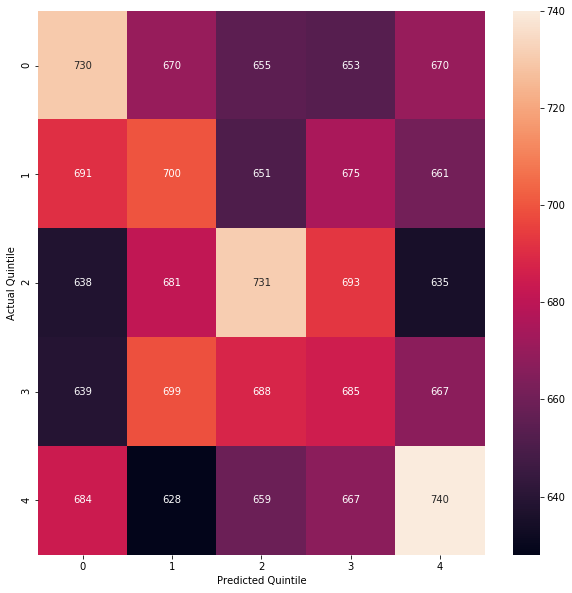

---
sklearn.svm.classes.NuSVR
................................................................................
21:13:23 Still training step 80 of 563
................................................................................
21:13:33 Still training step 160 of 563
................................................................................
21:13:49 Still training step 240 of 563
................................................................................
21:14:12 Still training step 320 of 563
................................................................................
21:14:46 Still training step 400 of 563
................................................................................
21:15:34 Still training step 480 of 563
................................................................................
21:16:34 Still training step 560 of 563
...
Mean return: -0.893%
Monthly Sharpe ratio: -0.155
OOS MSE across all predictions: 39.8554
In-sample MSE: 30.3893
Varianc

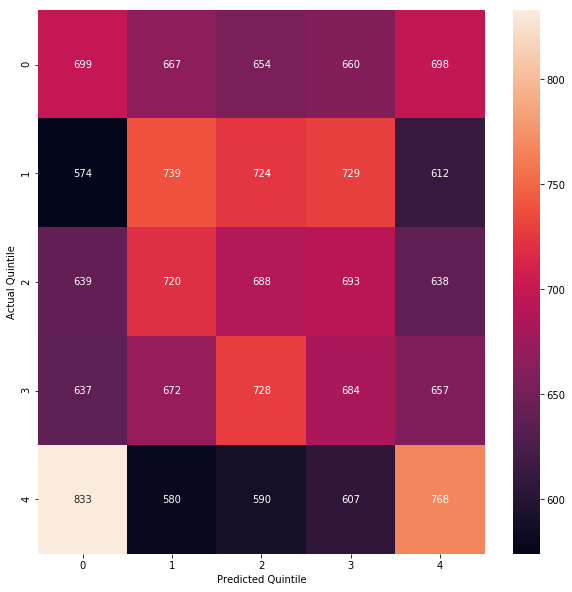

---
sklearn.svm.classes.SVR
................................................................................
21:16:44 Still training step 80 of 563
................................................................................
21:16:55 Still training step 160 of 563
................................................................................
21:17:13 Still training step 240 of 563
................................................................................
21:17:41 Still training step 320 of 563
................................................................................
21:18:20 Still training step 400 of 563
................................................................................
21:19:14 Still training step 480 of 563
................................................................................
21:20:25 Still training step 560 of 563
...
Mean return: -0.596%
Monthly Sharpe ratio: -0.074
OOS MSE across all predictions: 39.8821
In-sample MSE: 29.1823
Variance:

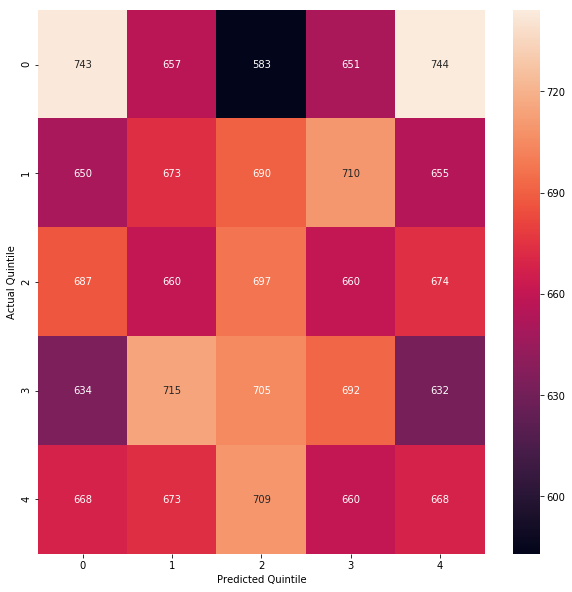

---
sklearn.tree.tree.DecisionTreeRegressor
................................................................................
21:20:37 Still training step 80 of 563
................................................................................
21:20:47 Still training step 160 of 563
................................................................................
21:21:01 Still training step 240 of 563
................................................................................
21:21:19 Still training step 320 of 563
................................................................................
21:21:43 Still training step 400 of 563
................................................................................
21:22:14 Still training step 480 of 563
................................................................................
21:22:54 Still training step 560 of 563
...
Mean return: 0.499%
Monthly Sharpe ratio: 0.132
OOS MSE across all predictions: 83.2643
In-sample MSE: 0.0

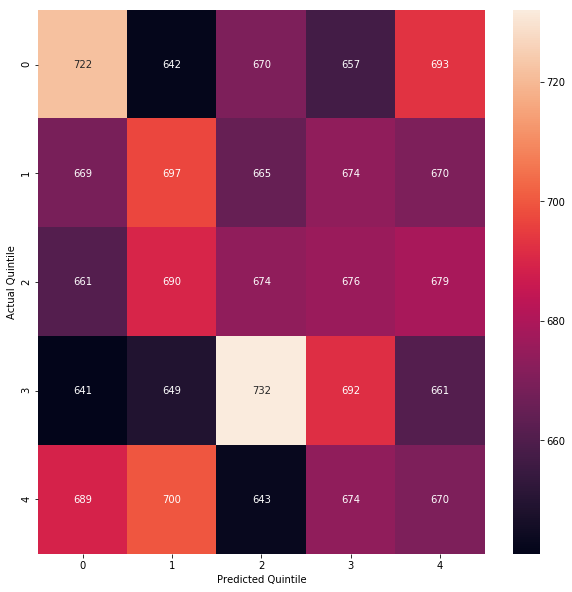

---
sklearn.tree.tree.ExtraTreeRegressor
................................................................................
21:22:59 Still training step 80 of 563
................................................................................
21:23:02 Still training step 160 of 563
................................................................................
21:23:06 Still training step 240 of 563
................................................................................
21:23:11 Still training step 320 of 563
................................................................................
21:23:17 Still training step 400 of 563
................................................................................
21:23:23 Still training step 480 of 563
................................................................................
21:23:31 Still training step 560 of 563
...
Mean return: -0.107%
Monthly Sharpe ratio: -0.003
OOS MSE across all predictions: 81.0315
In-sample MSE: 0.00

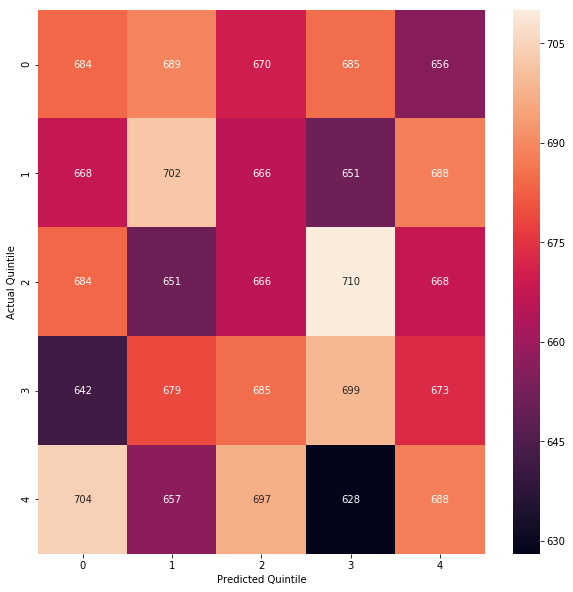

---
xgboost.sklearn.XGBRegressor
................................................................................
21:24:40 Still training step 80 of 563
................................................................................
21:26:07 Still training step 160 of 563
................................................................................
21:27:54 Still training step 240 of 563
................................................................................
21:30:03 Still training step 320 of 563
................................................................................
21:32:31 Still training step 400 of 563
................................................................................
21:35:14 Still training step 480 of 563
................................................................................
21:38:17 Still training step 560 of 563
...
Mean return: 2.176%
Monthly Sharpe ratio: 0.451
OOS MSE across all predictions: 45.7959
In-sample MSE: 12.9654
Varian

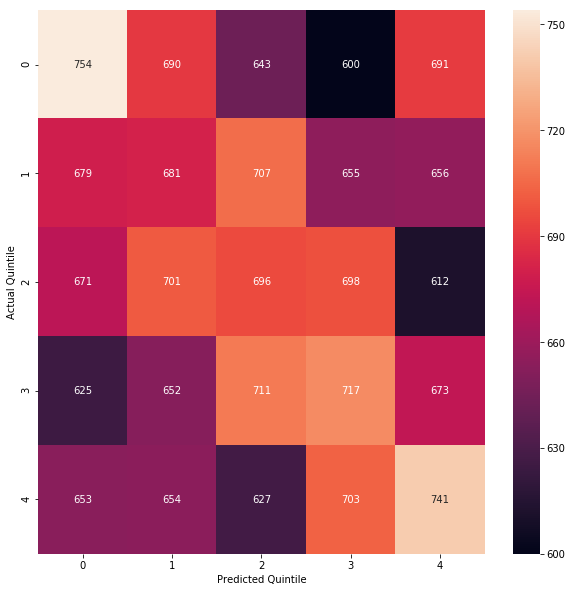

---


In [49]:
# run all the models
sharpe_list = []
mse_list = []
kendalltau_list = []
excess_tp_list = []
quintile_accuracy_list = []
directional_accuracy_list = []
keys = []

for estimator in estimators:
    print(str(estimator)[8:-2])
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator,
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler=None)
    backtestmodel.gen_predictions(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_predictions()
    backtestmodel.evaluate_quantiles(chart=True, verbose=False)
    keys.append(str(estimator)[8:-2])
    sharpe_list.append(backtestmodel.sharpe)
    mse_list.append(backtestmodel.mse)
    kendalltau_list.append(backtestmodel.kendalltau)
    excess_tp_list.append(backtestmodel.excess_tp)
    quintile_accuracy_list.append(backtestmodel.quintile_accuracy)
    directional_accuracy_list.append(backtestmodel.directional_accuracy)
    print("---")

    

In [50]:
# make a dataframe with all the metrics
est_names = [str(estimator)[8:-2] for estimator in estimators]

skmetricsframe = pd.DataFrame(list(zip(est_names, mse_list, sharpe_list, quintile_accuracy_list, directional_accuracy_list,
                                     kendalltau_list, excess_tp_list)), columns = ['name', 'mse', 'sharpe', 'quantile_score', 
                                                                                   'direction_score', 'kendalltau', 
                                                                                   'truepositive_score'])

skmetricsframe.to_csv("sklearn_metrics.csv")

In [41]:
skmetricsframe = pd.read_csv("sklearn_metrics.csv")[['name','mse','sharpe','quantile_score','direction_score','kendalltau','truepositive_score']]
skmetricsframe


In [42]:
with open('sklearn_table.html', 'w') as fo:
    skmetricsframe.sort_values(['kendalltau'], ascending=False).iloc[:12,:].to_html(fo, float_format=lambda x: '%.3f' % x)

In [43]:
# SGDRegressor diverged to 6.309236364118325e+23, omit out of range values for scatter chart
mse_list = skmetricsframe['mse'].values
mse_list = [x if x < 75 else np.nan for x in mse_list]
mse_list[24] = np.nan
sharpe_list = skmetricsframe['sharpe'].values
kendalltau_list  = skmetricsframe['kendalltau'].values
excess_tp_list = skmetricsframe['truepositive_score'].values
quintile_accuracy_list = skmetricsframe['quantile_score'].values
directional_accuracy_list = skmetricsframe['direction_score'].values
# exclude > 100
#mse_list[20] = np.nan
#mse_list[21] = np.nan


In [44]:
myscatter(mse_list, sharpe_list, title="Sharpe vs. MSE")
myscatter(quintile_accuracy_list, sharpe_list, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracy_list, sharpe_list, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltau_list, sharpe_list, title="Sharpe vs. Kendall's Tau")
myscatter(excess_tp_list, sharpe_list, title="Sharpe vs. True Positives")

In [45]:
# 4-way plot for blog post
fig = plotly.tools.make_subplots(rows=2, cols=2, subplot_titles=('MSE', 'Quintile Accuracy','Direction Accuracy', "Kendall's tau"))
fig.append_trace(Scatter(
    x = mse_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=1)

fig.append_trace(Scatter(
    x = quintile_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=2)

fig.append_trace(Scatter(
    x = directional_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=1)

fig.append_trace(Scatter(
    x = kendalltau_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=2)


fig['layout'].update(height=1000, width=1000, title='Sharpe ratio scatters vs.')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [46]:
corrmatrix = skmetricsframe[['sharpe', 'mse',  'kendalltau', 
                           'quantile_score', 'direction_score', 'truepositive_score']].corr()
corrmatrix

In [47]:
with open('sklearn_corr.html', 'w') as fo:
    corrmatrix.to_html(fo, float_format=lambda x: '%.3f' % x)

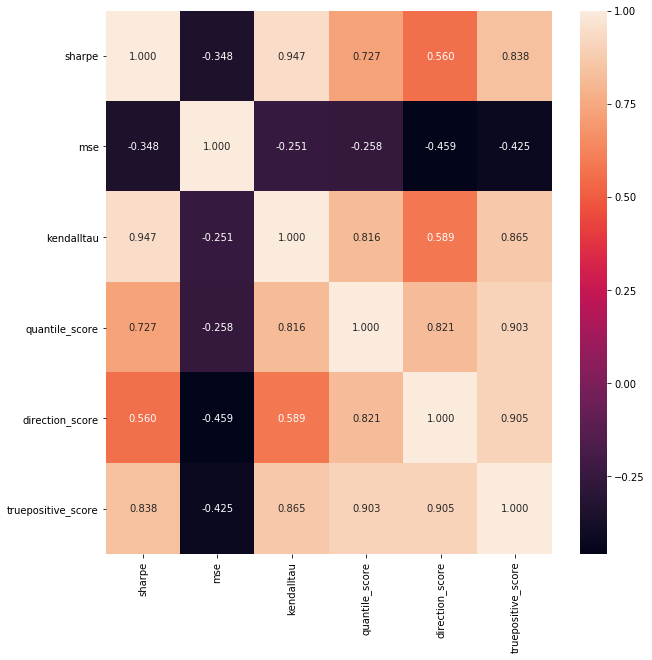

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmatrix, annot=True, fmt='.3f')
plt.show()


### Perform crossvalidation to find optimal regularization parameters for ElasticNet


In [71]:

sharpe_list = []
mse_list = []
kendalltau_list = []
excess_tp_list = []
quintile_accuracy_list = []
directional_accuracy_list = []
keys = []

def create_model(params):
    alpha, l1_ratio = params
    def myclosure():
        return sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    return myclosure

alphas = [1, 3, 10, 30, 100] 
l1_ratios = [.01, .05, .1, .5, .667, .75, .9, .95, .99, 1] # 1 = LASSO, 0 = Ridge

params_list = list(product(alphas, l1_ratios))
model_list = list(map(create_model, params_list))

for i in range(len(params_list)):
    print(params_list[i])
    estimator = model_list[i]
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator,
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler=None)
    #backtestmodel.walkforward_xval(n_splits=5, verbose=False)
    backtestmodel.gen_predictions(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_predictions()
    backtestmodel.evaluate_quantiles(chart=False, verbose=False)
    keys.append(str(estimator)[8:-2])
    sharpe_list.append(backtestmodel.sharpe)
    mse_list.append(backtestmodel.mse)
    kendalltau_list.append(backtestmodel.kendalltau)
    excess_tp_list.append(backtestmodel.excess_tp)
    quintile_accuracy_list.append(backtestmodel.quintile_accuracy)
    directional_accuracy_list.append(backtestmodel.directional_accuracy)
    print("---")


(1, 0.01)
................................................................................
23:03:27 Still training step 80 of 563
................................................................................
23:03:32 Still training step 160 of 563
................................................................................
23:03:37 Still training step 240 of 563
................................................................................
23:03:43 Still training step 320 of 563
................................................................................
23:03:49 Still training step 400 of 563
................................................................................
23:03:54 Still training step 480 of 563
................................................................................
23:03:59 Still training step 560 of 563
...
Mean return: 2.797%
Monthly Sharpe ratio: 0.507
OOS MSE across all predictions: 42.5880
In-sample MSE: 34.7849
Variance: 39.4097
R-squared: 

In-sample MSE: 35.8391
Variance: 39.4097
R-squared: -0.0203
Avg rank correlation (Kendall's tau): 0.0351 (Expected: 0)
5-quintile accuracy: 0.2201 (Expected: 0.2)
Long/short/flat accuracy: 0.4649 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 235.800000
---
(1, 0.95)
................................................................................
23:05:42 Still training step 80 of 563
................................................................................
23:05:43 Still training step 160 of 563
................................................................................
23:05:45 Still training step 240 of 563
................................................................................
23:05:46 Still training step 320 of 563
................................................................................
23:05:47 Still training step 400 of 563
................................................................................
23:05:49 Still training step 480 of 

................................................................................
23:08:17 Still training step 240 of 563
................................................................................
23:08:19 Still training step 320 of 563
................................................................................
23:08:21 Still training step 400 of 563
................................................................................
23:08:24 Still training step 480 of 563
................................................................................
23:08:26 Still training step 560 of 563
...
Mean return: 3.595%
Monthly Sharpe ratio: 0.600
OOS MSE across all predictions: 40.2610
In-sample MSE: 35.3905
Variance: 39.4097
R-squared: -0.0216
Avg rank correlation (Kendall's tau): 0.0387 (Expected: 0)
5-quintile accuracy: 0.2187 (Expected: 0.2)
Long/short/flat accuracy: 0.4641 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 224.800000
---
(10, 0.05)
.......................

................................................................................
23:09:21 Still training step 80 of 563
................................................................................
23:09:22 Still training step 160 of 563
................................................................................
23:09:23 Still training step 240 of 563
................................................................................
23:09:24 Still training step 320 of 563
................................................................................
23:09:25 Still training step 400 of 563
................................................................................
23:09:26 Still training step 480 of 563
................................................................................
23:09:27 Still training step 560 of 563
...
Mean return: -0.817%
Monthly Sharpe ratio: -0.118
OOS MSE across all predictions: 39.8281
In-sample MSE: 37.1900
Variance: 39.4097
R-squared: -0.0106


In-sample MSE: 37.1900
Variance: 39.4097
R-squared: -0.0110
Avg rank correlation (Kendall's tau): -0.0030 (Expected: 0)
5-quintile accuracy: 0.2106 (Expected: 0.2)
Long/short/flat accuracy: 0.4577 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 69.800000
---
(30, 0.667)
................................................................................
23:10:21 Still training step 80 of 563
................................................................................
23:10:22 Still training step 160 of 563
................................................................................
23:10:23 Still training step 240 of 563
................................................................................
23:10:24 Still training step 320 of 563
................................................................................
23:10:25 Still training step 400 of 563
................................................................................
23:10:26 Still training step 480 o

................................................................................
23:11:15 Still training step 480 of 563
................................................................................
23:11:16 Still training step 560 of 563
...
Mean return: 3.216%
Monthly Sharpe ratio: 0.541
OOS MSE across all predictions: 39.5610
In-sample MSE: 36.5444
Variance: 39.4097
R-squared: -0.0038
Avg rank correlation (Kendall's tau): 0.0337 (Expected: 0)
5-quintile accuracy: 0.2252 (Expected: 0.2)
Long/short/flat accuracy: 0.4667 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 227.800000
---
(100, 0.05)
................................................................................
23:11:18 Still training step 80 of 563
................................................................................
23:11:19 Still training step 160 of 563
................................................................................
23:11:20 Still training step 240 of 563
.......................

In [72]:
# make a dataframe with all the metrics

flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(params_list, mse_list, sharpe_list, 
                                                                              quintile_accuracy_list, directional_accuracy_list, kendalltau_list, excess_tp_list):
    flatlist.append([key[0], key[1], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
metricsframe = pd.DataFrame(flatlist, columns = ['alpha', 'l1_ratio',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

metricsframe.to_csv("ElasticNetmetrics.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]

In [49]:
metricsframe = pd.read_csv("ElasticNetmetrics.csv")[['alpha','l1_ratio','mse','sharpe','quantile_score','direction_score','kendalltau','truepositive_score']]
metricsframe

In [50]:
with open('elastic_table.html', 'w') as fo:
    metricsframe.sort_values(['sharpe'], ascending=False).iloc[:5,:].to_html(fo, float_format=lambda x: '%.3f' % x)

In [74]:
# do full backtest using selected parameters for ElasticNet
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model((10, 0.1)),
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
#backtestmodel.walkforward_xval(n_splits=5, verbose=False)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)
    
mychart([ backtestmodel.cumulative_return, perf_LASSO_each_timestep],["ElasticNet", "LASSO/OLS"], title="ElasticNet v. LASSO/OLS")


................................................................................
23:12:30 Still training step 80 of 563
................................................................................
23:12:32 Still training step 160 of 563
................................................................................
23:12:33 Still training step 240 of 563
................................................................................
23:12:34 Still training step 320 of 563
................................................................................
23:12:35 Still training step 400 of 563
................................................................................
23:12:36 Still training step 480 of 563
................................................................................
23:12:38 Still training step 560 of 563
...
Mean return: 4.262%
Monthly Sharpe ratio: 0.695
OOS MSE across all predictions: 39.7252
In-sample MSE: 36.1142
Variance: 39.4097
R-squared: -0.0080
Av

In [75]:
# try 'timestep' instead of 'all' 
# no improvement
sharpe_list = []
mse_list = []
kendalltau_list = []
excess_tp_list = []
quintile_accuracy_list = []
directional_accuracy_list = []
keys = []

def create_model(params):
    alpha, l1_ratio = params
    def myclosure():
        return sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    return myclosure

alphas = [1, 3, 10, 30, 100] 
l1_ratios = [.01, .05, .1, .5, .667, .75, .9, .95, .99, 1] # 1 = LASSO, 0 = Ridge

params_list = list(product(alphas, l1_ratios))
model_list = list(map(create_model, params_list))

for i in range(len(params_list)):
    print(params_list[i])
    estimator = model_list[i]
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator,
                                  coef_dict_param="timestep", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler=None)
    #backtestmodel.walkforward_xval(n_splits=5, verbose=False)
    backtestmodel.gen_predictions(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_predictions()
    backtestmodel.evaluate_quantiles(chart=False, verbose=False)
    keys.append(str(estimator)[8:-2])
    sharpe_list.append(backtestmodel.sharpe)
    mse_list.append(backtestmodel.mse)
    kendalltau_list.append(backtestmodel.kendalltau)
    excess_tp_list.append(backtestmodel.excess_tp)
    quintile_accuracy_list.append(backtestmodel.quintile_accuracy)
    directional_accuracy_list.append(backtestmodel.directional_accuracy)
    print("---")


(1, 0.01)
................................................................................
23:12:50 Still training step 80 of 563
................................................................................
23:13:01 Still training step 160 of 563
................................................................................
23:13:12 Still training step 240 of 563
................................................................................
23:13:23 Still training step 320 of 563
................................................................................
23:13:35 Still training step 400 of 563
................................................................................
23:13:46 Still training step 480 of 563
................................................................................
23:13:57 Still training step 560 of 563
...
Mean return: 3.680%
Monthly Sharpe ratio: 0.683
OOS MSE across all predictions: 41.0694
In-sample MSE: 35.7746
Variance: 39.4097
R-squared: 

Avg rank correlation (Kendall's tau): 0.0351 (Expected: 0)
5-quintile accuracy: 0.2197 (Expected: 0.2)
Long/short/flat accuracy: 0.4604 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 217.800000
---
(1, 0.95)
................................................................................
23:21:55 Still training step 80 of 563
................................................................................
23:22:06 Still training step 160 of 563
................................................................................
23:22:17 Still training step 240 of 563
................................................................................
23:22:28 Still training step 320 of 563
................................................................................
23:22:38 Still training step 400 of 563
................................................................................
23:22:50 Still training step 480 of 563
........................................................

................................................................................
23:39:13 Still training step 240 of 563
................................................................................
23:39:24 Still training step 320 of 563
................................................................................
23:39:35 Still training step 400 of 563
................................................................................
23:39:46 Still training step 480 of 563
................................................................................
23:39:57 Still training step 560 of 563
...
Mean return: 3.980%
Monthly Sharpe ratio: 0.703
OOS MSE across all predictions: 40.0051
In-sample MSE: 35.9534
Variance: 39.4097
R-squared: -0.0151
Avg rank correlation (Kendall's tau): 0.0354 (Expected: 0)
5-quintile accuracy: 0.2163 (Expected: 0.2)
Long/short/flat accuracy: 0.4593 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 216.800000
---
(10, 0.05)
.......................

................................................................................
23:47:55 Still training step 80 of 563
................................................................................
23:48:05 Still training step 160 of 563
................................................................................
23:48:16 Still training step 240 of 563
................................................................................
23:48:26 Still training step 320 of 563
................................................................................
23:48:37 Still training step 400 of 563
................................................................................
23:48:48 Still training step 480 of 563
................................................................................
23:48:58 Still training step 560 of 563
...
Mean return: -0.850%
Monthly Sharpe ratio: -0.124
OOS MSE across all predictions: 39.8252
In-sample MSE: 37.1900
Variance: 39.4097
R-squared: -0.0105


Avg rank correlation (Kendall's tau): -0.0030 (Expected: 0)
5-quintile accuracy: 0.2106 (Expected: 0.2)
Long/short/flat accuracy: 0.4577 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 69.800000
---
(30, 0.667)
................................................................................
23:56:47 Still training step 80 of 563
................................................................................
23:56:58 Still training step 160 of 563
................................................................................
23:57:09 Still training step 240 of 563
................................................................................
23:57:19 Still training step 320 of 563
................................................................................
23:57:30 Still training step 400 of 563
................................................................................
23:57:41 Still training step 480 of 563
......................................................

................................................................................
00:13:36 Still training step 240 of 563
................................................................................
00:13:46 Still training step 320 of 563
................................................................................
00:13:57 Still training step 400 of 563
................................................................................
00:14:07 Still training step 480 of 563
................................................................................
00:14:18 Still training step 560 of 563
...
Mean return: -1.129%
Monthly Sharpe ratio: -0.178
OOS MSE across all predictions: 39.8418
In-sample MSE: 37.1900
Variance: 39.4097
R-squared: -0.0110
Avg rank correlation (Kendall's tau): -0.0030 (Expected: 0)
5-quintile accuracy: 0.2106 (Expected: 0.2)
Long/short/flat accuracy: 0.4577 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 69.800000
---
(100, 0.99)
....................

In [76]:
# make a dataframe with all the metrics

flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(params_list, mse_list, sharpe_list, 
                                                                                      quintile_accuracy_list, directional_accuracy_list, kendalltau_list, excess_tp_list):
    flatlist.append([key[0], key[1], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
elasticframe2 = pd.DataFrame(flatlist, columns = ['alpha', 'l1_ratio',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

elasticframe2.to_csv("ElasticNetmetrics2.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]

In [51]:
elasticframe2 = pd.read_csv("ElasticNetmetrics2.csv")
elasticframe2


In [78]:
# enumerate classifiers - didn't run these, maybe next time
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble.bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process.gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised.label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised.label_propagation.LabelSpreading'>
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
<class 'sklearn.linear_model.logistic.LogisticRegression'>
<class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
<c

In [79]:
estimators

[sklearn.ensemble.weight_boosting.AdaBoostClassifier,
 sklearn.ensemble.bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.tree.tree.ExtraTreeClassifier,
 sklearn.ensemble.forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process.gpc.GaussianProcessClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.semi_supervised.label_propagation.LabelPropagation,
 sklearn.semi_supervised.label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.linear_model.logistic.LogisticRegressionCV,
 sklearn.neural_network.multilayer_perceptron.MLPClassifier,
 sklearn.naive_bayes.MultinomialNB,
 sklearn.svm.classes.NuSVC,
 sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
 sklearn.ens

### Perform cross-validation on Keras neural networks to select best architecture

In [28]:
# use keras instead of sklearn MLPRegressor
# wrap keras model in a class 
# multioutput 30 predictions simultaneously to speed up 
# fit takes a list of response ys, predict returns a list of y_predict arrays
# no coef_dict
INPUT_DIM = X.shape[1]
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 137
EPOCHS=1000
# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(1,
                                 activation='linear',
                                 name='output%02d' % i)(lastlayer)
                          )
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss="mse", metrics=["mse"], optimizer="adam", loss_weights=[1.]*OUTPUT_DIM)
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        Y_list = [Y[:,i] for i in range(OUTPUT_DIM)]
        
        if epochs:
            self.epochs = epochs

        retval = self.model.fit(X,
                                Y_list,
                                batch_size=BATCH_SIZE,
                                epochs=self.epochs,
                                verbose=verbose)
        self.history = retval.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return retval
    
    
    def predict(self, X, verbose=False):
        y_list = self.model.predict(X)
        # convert list of ys to Y array
        npreds=len(y_list[0])
        Y_pred = [y.reshape(npreds) for y in y_list]
        Y_pred = np.array(Y_pred).transpose()    
        return Y_pred
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


30


In [29]:
# no hidden layer, linear activation = LinearRegression
# confirm similar results to sklearn LinearRegression
keras_model = KerasBacktestModel(n_hidden_layers = 0,
                                 reg_penalty = 0.0,
                                 verbose=True,
                                 epochs=2000)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
output00 (Dense)                (None, 1)            31          main_input[0][0]                 
__________________________________________________________________________________________________
output01 (Dense)                (None, 1)            31          main_input[0][0]                 
__________________________________________________________________________________________________
output02 (Dense)                (None, 1)            31          main_input[0][0]                 
__________________________________________________________________________________________________
output03 (

In [30]:
backtestmodel = BacktestModel(X, Y, 
                              model=keras_model, 
                              coef_dict_param=coef_dict_all, 
                              startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=True))

# should match linear regression model pretty closely

Using coef_dict predictors
Epoch 1/2000
121/121 [==============================] - 3s 22ms/step - loss: 2327.2869 - output00_loss: 28.4154 - output01_loss: 78.5234 - output02_loss: 76.4103 - output03_loss: 64.6057 - output04_loss: 153.6343 - output05_loss: 49.2616 - output06_loss: 129.5141 - output07_loss: 111.6197 - output08_loss: 47.2683 - output09_loss: 51.8307 - output10_loss: 39.9993 - output11_loss: 42.6742 - output12_loss: 57.8732 - output13_loss: 111.2209 - output14_loss: 70.5415 - output15_loss: 84.1561 - output16_loss: 37.4167 - output17_loss: 103.2087 - output18_loss: 39.6734 - output19_loss: 173.0209 - output20_loss: 97.7147 - output21_loss: 86.7075 - output22_loss: 42.6604 - output23_loss: 33.2774 - output24_loss: 60.0313 - output25_loss: 55.5176 - output26_loss: 32.7767 - output27_loss: 59.7430 - output28_loss: 154.9644 - output29_loss: 153.0256 - output00_mean_squared_error: 28.4154 - output01_mean_squared_error: 78.5234 - output02_mean_squared_error: 76.4103 - output03_

Epoch 6/2000
121/121 [==============================] - 0s 619us/step - loss: 2172.4771 - output00_loss: 27.8863 - output01_loss: 71.0756 - output02_loss: 70.3094 - output03_loss: 62.4204 - output04_loss: 142.3749 - output05_loss: 47.6715 - output06_loss: 119.4410 - output07_loss: 103.6142 - output08_loss: 43.9414 - output09_loss: 50.2875 - output10_loss: 39.3277 - output11_loss: 41.1157 - output12_loss: 53.4425 - output13_loss: 102.1337 - output14_loss: 64.4166 - output15_loss: 77.5143 - output16_loss: 36.7908 - output17_loss: 96.3867 - output18_loss: 37.2198 - output19_loss: 159.7425 - output20_loss: 89.0972 - output21_loss: 81.2660 - output22_loss: 40.6585 - output23_loss: 30.9626 - output24_loss: 56.0320 - output25_loss: 54.1124 - output26_loss: 31.3537 - output27_loss: 56.4684 - output28_loss: 143.3296 - output29_loss: 142.0840 - output00_mean_squared_error: 27.8863 - output01_mean_squared_error: 71.0756 - output02_mean_squared_error: 70.3094 - output03_mean_squared_error: 62.4204

Epoch 11/2000
121/121 [==============================] - 0s 1ms/step - loss: 2019.5476 - output00_loss: 27.3174 - output01_loss: 63.5202 - output02_loss: 64.2564 - output03_loss: 60.7137 - output04_loss: 130.5660 - output05_loss: 46.4659 - output06_loss: 108.9559 - output07_loss: 95.4366 - output08_loss: 40.9768 - output09_loss: 49.2264 - output10_loss: 38.5997 - output11_loss: 40.0640 - output12_loss: 49.2507 - output13_loss: 92.7491 - output14_loss: 58.3368 - output15_loss: 70.8580 - output16_loss: 36.3117 - output17_loss: 89.5257 - output18_loss: 35.2179 - output19_loss: 145.6800 - output20_loss: 80.2366 - output21_loss: 75.9480 - output22_loss: 39.1588 - output23_loss: 29.1139 - output24_loss: 52.3203 - output25_loss: 53.0365 - output26_loss: 30.4099 - output27_loss: 53.5631 - output28_loss: 131.1017 - output29_loss: 130.6297 - output00_mean_squared_error: 27.3174 - output01_mean_squared_error: 63.5202 - output02_mean_squared_error: 64.2564 - output03_mean_squared_error: 60.7137 - 

Epoch 16/2000
121/121 [==============================] - 0s 945us/step - loss: 1884.1688 - output00_loss: 26.7589 - output01_loss: 56.6841 - output02_loss: 58.9437 - output03_loss: 59.6728 - output04_loss: 119.4055 - output05_loss: 45.5860 - output06_loss: 99.1423 - output07_loss: 87.9678 - output08_loss: 38.7596 - output09_loss: 48.5753 - output10_loss: 37.8827 - output11_loss: 39.5041 - output12_loss: 45.8143 - output13_loss: 84.0545 - output14_loss: 52.9971 - output15_loss: 64.9343 - output16_loss: 35.8689 - output17_loss: 83.3889 - output18_loss: 33.9221 - output19_loss: 132.2260 - output20_loss: 72.0746 - output21_loss: 71.3775 - output22_loss: 38.3460 - output23_loss: 27.9516 - output24_loss: 49.3637 - output25_loss: 52.2690 - output26_loss: 29.9395 - output27_loss: 51.4125 - output28_loss: 119.5149 - output29_loss: 119.8302 - output00_mean_squared_error: 26.7589 - output01_mean_squared_error: 56.6841 - output02_mean_squared_error: 58.9437 - output03_mean_squared_error: 59.6728 -

Epoch 21/2000
121/121 [==============================] - 0s 869us/step - loss: 1766.4125 - output00_loss: 26.2198 - output01_loss: 50.6982 - output02_loss: 54.4707 - output03_loss: 59.0805 - output04_loss: 109.0946 - output05_loss: 44.7814 - output06_loss: 90.1811 - output07_loss: 81.3493 - output08_loss: 37.2518 - output09_loss: 48.0640 - output10_loss: 37.1863 - output11_loss: 39.1515 - output12_loss: 43.1711 - output13_loss: 76.2133 - output14_loss: 48.4973 - output15_loss: 59.8564 - output16_loss: 35.4138 - output17_loss: 78.0907 - output18_loss: 33.1878 - output19_loss: 119.6144 - output20_loss: 64.7656 - output21_loss: 67.6322 - output22_loss: 38.0140 - output23_loss: 27.3264 - output24_loss: 47.1760 - output25_loss: 51.6350 - output26_loss: 29.6387 - output27_loss: 49.9929 - output28_loss: 108.7765 - output29_loss: 109.8811 - output00_mean_squared_error: 26.2198 - output01_mean_squared_error: 50.6982 - output02_mean_squared_error: 54.4707 - output03_mean_squared_error: 59.0805 -

Epoch 26/2000
121/121 [==============================] - 0s 1ms/step - loss: 1664.4938 - output00_loss: 25.7027 - output01_loss: 45.5840 - output02_loss: 50.8324 - output03_loss: 58.6682 - output04_loss: 99.6978 - output05_loss: 43.9702 - output06_loss: 82.1255 - output07_loss: 75.6086 - output08_loss: 36.2878 - output09_loss: 47.5529 - output10_loss: 36.5135 - output11_loss: 38.8078 - output12_loss: 41.2496 - output13_loss: 69.2687 - output14_loss: 44.8334 - output15_loss: 55.6319 - output16_loss: 34.9728 - output17_loss: 73.6378 - output18_loss: 32.7693 - output19_loss: 107.9257 - output20_loss: 58.3469 - output21_loss: 64.6843 - output22_loss: 37.8649 - output23_loss: 27.0107 - output24_loss: 45.6542 - output25_loss: 51.0281 - output26_loss: 29.3076 - output27_loss: 49.1584 - output28_loss: 98.9542 - output29_loss: 100.8440 - output00_mean_squared_error: 25.7027 - output01_mean_squared_error: 45.5840 - output02_mean_squared_error: 50.8324 - output03_mean_squared_error: 58.6682 - out

Epoch 31/2000
121/121 [==============================] - 0s 768us/step - loss: 1576.4980 - output00_loss: 25.2087 - output01_loss: 41.3124 - output02_loss: 47.9711 - output03_loss: 58.2709 - output04_loss: 91.2262 - output05_loss: 43.1562 - output06_loss: 74.9776 - output07_loss: 70.7221 - output08_loss: 35.6578 - output09_loss: 47.0137 - output10_loss: 35.8658 - output11_loss: 38.4205 - output12_loss: 39.9163 - output13_loss: 63.2135 - output14_loss: 41.9483 - output15_loss: 52.2173 - output16_loss: 34.5547 - output17_loss: 69.9837 - output18_loss: 32.4530 - output19_loss: 97.1834 - output20_loss: 52.8056 - output21_loss: 62.4482 - output22_loss: 37.6977 - output23_loss: 26.8004 - output24_loss: 44.6355 - output25_loss: 50.4177 - output26_loss: 28.9278 - output27_loss: 48.7021 - output28_loss: 90.0618 - output29_loss: 92.7279 - output00_mean_squared_error: 25.2087 - output01_mean_squared_error: 41.3124 - output02_mean_squared_error: 47.9711 - output03_mean_squared_error: 58.2709 - out

Epoch 36/2000
121/121 [==============================] - 0s 1ms/step - loss: 1500.7544 - output00_loss: 24.7376 - output01_loss: 37.8226 - output02_loss: 45.7958 - output03_loss: 57.8407 - output04_loss: 83.6610 - output05_loss: 42.3601 - output06_loss: 68.7093 - output07_loss: 66.6344 - output08_loss: 35.1847 - output09_loss: 46.4663 - output10_loss: 35.2436 - output11_loss: 38.0159 - output12_loss: 39.0113 - output13_loss: 58.0101 - output14_loss: 39.7514 - output15_loss: 49.5364 - output16_loss: 34.1488 - output17_loss: 67.0479 - output18_loss: 32.1218 - output19_loss: 87.3806 - output20_loss: 48.0983 - output21_loss: 60.8029 - output22_loss: 37.4652 - output23_loss: 26.5807 - output24_loss: 43.9479 - output25_loss: 49.8145 - output26_loss: 28.5463 - output27_loss: 48.4239 - output28_loss: 82.0829 - output29_loss: 85.5116 - output00_mean_squared_error: 24.7376 - output01_mean_squared_error: 37.8226 - output02_mean_squared_error: 45.7958 - output03_mean_squared_error: 57.8407 - outpu

Epoch 41/2000
121/121 [==============================] - 0s 912us/step - loss: 1435.7990 - output00_loss: 24.2891 - output01_loss: 35.0335 - output02_loss: 44.1957 - output03_loss: 57.3918 - output04_loss: 76.9641 - output05_loss: 41.5931 - output06_loss: 63.2728 - output07_loss: 63.2695 - output08_loss: 34.7582 - output09_loss: 45.9302 - output10_loss: 34.6469 - output11_loss: 37.6236 - output12_loss: 38.3840 - output13_loss: 53.6011 - output14_loss: 38.1319 - output15_loss: 47.4926 - output16_loss: 33.7545 - output17_loss: 64.7287 - output18_loss: 31.7509 - output19_loss: 78.4913 - output20_loss: 44.1611 - output21_loss: 59.6120 - output22_loss: 37.2046 - output23_loss: 26.3272 - output24_loss: 43.4468 - output25_loss: 49.2327 - output26_loss: 28.1892 - output27_loss: 48.1854 - output28_loss: 74.9819 - output29_loss: 79.1546 - output00_mean_squared_error: 24.2891 - output01_mean_squared_error: 35.0335 - output02_mean_squared_error: 44.1957 - output03_mean_squared_error: 57.3918 - out

Epoch 46/2000
121/121 [==============================] - 0s 966us/step - loss: 1380.2494 - output00_loss: 23.8622 - output01_loss: 32.8523 - output02_loss: 43.0536 - output03_loss: 56.9490 - output04_loss: 71.0847 - output05_loss: 40.8547 - output06_loss: 58.6078 - output07_loss: 60.5391 - output08_loss: 34.3297 - output09_loss: 45.4084 - output10_loss: 34.0754 - output11_loss: 37.2492 - output12_loss: 37.9153 - output13_loss: 49.9166 - output14_loss: 36.9718 - output15_loss: 45.9792 - output16_loss: 33.3753 - output17_loss: 62.9145 - output18_loss: 31.3624 - output19_loss: 70.4766 - output20_loss: 40.9180 - output21_loss: 58.7431 - output22_loss: 36.9552 - output23_loss: 26.0611 - output24_loss: 43.0308 - output25_loss: 48.6735 - output26_loss: 27.8508 - output27_loss: 47.9246 - output28_loss: 68.7106 - output29_loss: 73.6036 - output00_mean_squared_error: 23.8622 - output01_mean_squared_error: 32.8523 - output02_mean_squared_error: 43.0536 - output03_mean_squared_error: 56.9490 - out

Epoch 51/2000
121/121 [==============================] - 0s 1ms/step - loss: 1332.7749 - output00_loss: 23.4560 - output01_loss: 31.1821 - output02_loss: 42.2560 - output03_loss: 56.5241 - output04_loss: 65.9640 - output05_loss: 40.1411 - output06_loss: 54.6460 - output07_loss: 58.3499 - output08_loss: 33.8907 - output09_loss: 44.8945 - output10_loss: 33.5283 - output11_loss: 36.8834 - output12_loss: 37.5246 - output13_loss: 46.8794 - output14_loss: 36.1574 - output15_loss: 44.8891 - output16_loss: 33.0091 - output17_loss: 61.4942 - output18_loss: 30.9803 - output19_loss: 63.2897 - output20_loss: 38.2860 - output21_loss: 58.0834 - output22_loss: 36.7257 - output23_loss: 25.8054 - output24_loss: 42.6410 - output25_loss: 48.1314 - output26_loss: 27.5181 - output27_loss: 47.6336 - output28_loss: 63.2128 - output29_loss: 68.7976 - output00_mean_squared_error: 23.4560 - output01_mean_squared_error: 31.1821 - output02_mean_squared_error: 42.2560 - output03_mean_squared_error: 56.5241 - outpu

Epoch 56/2000
121/121 [==============================] - 0s 594us/step - loss: 1292.1492 - output00_loss: 23.0695 - output01_loss: 29.9280 - output02_loss: 41.7021 - output03_loss: 56.1151 - output04_loss: 61.5386 - output05_loss: 39.4500 - output06_loss: 51.3155 - output07_loss: 56.6092 - output08_loss: 33.4497 - output09_loss: 44.3842 - output10_loss: 33.0050 - output11_loss: 36.5193 - output12_loss: 37.1652 - output13_loss: 44.4095 - output14_loss: 35.5874 - output15_loss: 44.1218 - output16_loss: 32.6544 - output17_loss: 60.3657 - output18_loss: 30.6133 - output19_loss: 56.8786 - output20_loss: 36.1803 - output21_loss: 57.5466 - output22_loss: 36.5047 - output23_loss: 25.5665 - output24_loss: 42.2527 - output25_loss: 47.6024 - output26_loss: 27.1881 - output27_loss: 47.3273 - output28_loss: 58.4273 - output29_loss: 64.6709 - output00_mean_squared_error: 23.0695 - output01_mean_squared_error: 29.9280 - output02_mean_squared_error: 41.7021 - output03_mean_squared_error: 56.1151 - out

Epoch 61/2000
121/121 [==============================] - 0s 857us/step - loss: 1257.2885 - output00_loss: 22.7016 - output01_loss: 29.0021 - output02_loss: 41.3088 - output03_loss: 55.7159 - output04_loss: 57.7433 - output05_loss: 38.7816 - output06_loss: 48.5436 - output07_loss: 55.2295 - output08_loss: 33.0167 - output09_loss: 43.8780 - output10_loss: 32.5045 - output11_loss: 36.1577 - output12_loss: 36.8150 - output13_loss: 42.4280 - output14_loss: 35.1791 - output15_loss: 43.5893 - output16_loss: 32.3114 - output17_loss: 59.4420 - output18_loss: 30.2573 - output19_loss: 51.1888 - output20_loss: 34.5184 - output21_loss: 57.0742 - output22_loss: 36.2818 - output23_loss: 25.3387 - output24_loss: 41.8611 - output25_loss: 47.0867 - output26_loss: 26.8650 - output27_loss: 47.0209 - output28_loss: 54.2912 - output29_loss: 61.1564 - output00_mean_squared_error: 22.7016 - output01_mean_squared_error: 29.0021 - output02_mean_squared_error: 41.3088 - output03_mean_squared_error: 55.7159 - out

Epoch 66/2000
121/121 [==============================] - 0s 1ms/step - loss: 1227.2551 - output00_loss: 22.3514 - output01_loss: 28.3264 - output02_loss: 41.0131 - output03_loss: 55.3230 - output04_loss: 54.5129 - output05_loss: 38.1366 - output06_loss: 46.2589 - output07_loss: 54.1319 - output08_loss: 32.5965 - output09_loss: 43.3781 - output10_loss: 32.0261 - output11_loss: 35.8016 - output12_loss: 36.4672 - output13_loss: 40.8591 - output14_loss: 34.8698 - output15_loss: 43.2187 - output16_loss: 31.9791 - output17_loss: 58.6544 - output18_loss: 29.9059 - output19_loss: 46.1645 - output20_loss: 33.2223 - output21_loss: 56.6307 - output22_loss: 36.0555 - output23_loss: 25.1149 - output24_loss: 41.4698 - output25_loss: 46.5855 - output26_loss: 26.5513 - output27_loss: 46.7213 - output28_loss: 50.7411 - output29_loss: 58.1872 - output00_mean_squared_error: 22.3514 - output01_mean_squared_error: 28.3264 - output02_mean_squared_error: 41.0131 - output03_mean_squared_error: 55.3230 - outpu

Epoch 71/2000
121/121 [==============================] - 0s 1ms/step - loss: 1201.2478 - output00_loss: 22.0178 - output01_loss: 27.8347 - output02_loss: 40.7708 - output03_loss: 54.9364 - output04_loss: 51.7841 - output05_loss: 37.5148 - output06_loss: 44.3936 - output07_loss: 53.2480 - output08_loss: 32.1892 - output09_loss: 42.8858 - output10_loss: 31.5689 - output11_loss: 35.4524 - output12_loss: 36.1218 - output13_loss: 39.6327 - output14_loss: 34.6160 - output15_loss: 42.9539 - output16_loss: 31.6567 - output17_loss: 57.9521 - output18_loss: 29.5563 - output19_loss: 41.7503 - output20_loss: 32.2214 - output21_loss: 56.1981 - output22_loss: 35.8295 - output23_loss: 24.8923 - output24_loss: 41.0834 - output25_loss: 46.0991 - output26_loss: 26.2461 - output27_loss: 46.4283 - output28_loss: 47.7150 - output29_loss: 55.6985 - output00_mean_squared_error: 22.0178 - output01_mean_squared_error: 27.8347 - output02_mean_squared_error: 40.7708 - output03_mean_squared_error: 54.9364 - outpu

Epoch 76/2000
121/121 [==============================] - 0s 1ms/step - loss: 1178.5914 - output00_loss: 21.6999 - output01_loss: 27.4736 - output02_loss: 40.5537 - output03_loss: 54.5577 - output04_loss: 49.4960 - output05_loss: 36.9152 - output06_loss: 42.8841 - output07_loss: 52.5211 - output08_loss: 31.7927 - output09_loss: 42.4009 - output10_loss: 31.1320 - output11_loss: 35.1097 - output12_loss: 35.7807 - output13_loss: 38.6851 - output14_loss: 34.3899 - output15_loss: 42.7535 - output16_loss: 31.3440 - output17_loss: 57.3003 - output18_loss: 29.2091 - output19_loss: 37.8916 - output20_loss: 31.4533 - output21_loss: 55.7688 - output22_loss: 35.6060 - output23_loss: 24.6718 - output24_loss: 40.7045 - output25_loss: 45.6267 - output26_loss: 25.9486 - output27_loss: 46.1390 - output28_loss: 45.1532 - output29_loss: 53.6287 - output00_mean_squared_error: 21.6999 - output01_mean_squared_error: 27.4736 - output02_mean_squared_error: 40.5537 - output03_mean_squared_error: 54.5577 - outpu

Epoch 81/2000
121/121 [==============================] - 0s 1ms/step - loss: 1158.7201 - output00_loss: 21.3968 - output01_loss: 27.2012 - output02_loss: 40.3457 - output03_loss: 54.1877 - output04_loss: 47.5914 - output05_loss: 36.3370 - output06_loss: 41.6726 - output07_loss: 51.9059 - output08_loss: 31.4050 - output09_loss: 41.9233 - output10_loss: 30.7145 - output11_loss: 34.7732 - output12_loss: 35.4454 - output13_loss: 37.9605 - output14_loss: 34.1756 - output15_loss: 42.5897 - output16_loss: 31.0405 - output17_loss: 56.6767 - output18_loss: 28.8660 - output19_loss: 34.5359 - output20_loss: 30.8645 - output21_loss: 55.3410 - output22_loss: 35.3850 - output23_loss: 24.4551 - output24_loss: 40.3335 - output25_loss: 45.1678 - output26_loss: 25.6587 - output27_loss: 45.8509 - output28_loss: 42.9990 - output29_loss: 51.9201 - output00_mean_squared_error: 21.3968 - output01_mean_squared_error: 27.2012 - output02_mean_squared_error: 40.3457 - output03_mean_squared_error: 54.1877 - outpu

Epoch 86/2000
121/121 [==============================] - 0s 523us/step - loss: 1141.1644 - output00_loss: 21.1076 - output01_loss: 26.9867 - output02_loss: 40.1387 - output03_loss: 53.8263 - output04_loss: 46.0172 - output05_loss: 35.7796 - output06_loss: 40.7070 - output07_loss: 51.3677 - output08_loss: 31.0253 - output09_loss: 41.4531 - output10_loss: 30.3157 - output11_loss: 34.4431 - output12_loss: 35.1164 - output13_loss: 37.4107 - output14_loss: 33.9653 - output15_loss: 42.4444 - output16_loss: 30.7456 - output17_loss: 56.0684 - output18_loss: 28.5282 - output19_loss: 31.6326 - output20_loss: 30.4104 - output21_loss: 54.9154 - output22_loss: 35.1658 - output23_loss: 24.2427 - output24_loss: 39.9695 - output25_loss: 44.7218 - output26_loss: 25.3767 - output27_loss: 45.5634 - output28_loss: 41.1996 - output29_loss: 50.5196 - output00_mean_squared_error: 21.1076 - output01_mean_squared_error: 26.9867 - output02_mean_squared_error: 40.1387 - output03_mean_squared_error: 53.8263 - out

Epoch 91/2000
121/121 [==============================] - 0s 912us/step - loss: 1125.5344 - output00_loss: 20.8314 - output01_loss: 26.8080 - output02_loss: 39.9298 - output03_loss: 53.4731 - output04_loss: 44.7249 - output05_loss: 35.2421 - output06_loss: 39.9414 - output07_loss: 50.8808 - output08_loss: 30.6538 - output09_loss: 40.9906 - output10_loss: 29.9346 - output11_loss: 34.1196 - output12_loss: 34.7933 - output13_loss: 36.9952 - output14_loss: 33.7559 - output15_loss: 42.3073 - output16_loss: 30.4592 - output17_loss: 55.4686 - output18_loss: 28.1955 - output19_loss: 29.1336 - output20_loss: 30.0551 - output21_loss: 54.4930 - output22_loss: 34.9483 - output23_loss: 24.0345 - output24_loss: 39.6116 - output25_loss: 44.2885 - output26_loss: 25.1026 - output27_loss: 45.2771 - output28_loss: 39.7061 - output29_loss: 49.3789 - output00_mean_squared_error: 20.8314 - output01_mean_squared_error: 26.8080 - output02_mean_squared_error: 39.9298 - output03_mean_squared_error: 53.4731 - out

Epoch 96/2000
121/121 [==============================] - 0s 1ms/step - loss: 1111.5071 - output00_loss: 20.5675 - output01_loss: 26.6503 - output02_loss: 39.7184 - output03_loss: 53.1279 - output04_loss: 43.6705 - output05_loss: 34.7239 - output06_loss: 39.3361 - output07_loss: 50.4271 - output08_loss: 30.2907 - output09_loss: 40.5359 - output10_loss: 29.5706 - output11_loss: 33.8028 - output12_loss: 34.4756 - output13_loss: 36.6808 - output14_loss: 33.5467 - output15_loss: 42.1728 - output16_loss: 30.1808 - output17_loss: 54.8742 - output18_loss: 27.8679 - output19_loss: 26.9939 - output20_loss: 29.7702 - output21_loss: 54.0749 - output22_loss: 34.7330 - output23_loss: 23.8301 - output24_loss: 39.2593 - output25_loss: 43.8674 - output26_loss: 24.8361 - output27_loss: 44.9930 - output28_loss: 38.4738 - output29_loss: 48.4549 - output00_mean_squared_error: 20.5675 - output01_mean_squared_error: 26.6503 - output02_mean_squared_error: 39.7184 - output03_mean_squared_error: 53.1279 - outpu

Epoch 101/2000
121/121 [==============================] - 0s 611us/step - loss: 1098.8132 - output00_loss: 20.3151 - output01_loss: 26.5039 - output02_loss: 39.5051 - output03_loss: 52.7904 - output04_loss: 42.8148 - output05_loss: 34.2240 - output06_loss: 38.8573 - output07_loss: 49.9944 - output08_loss: 29.9364 - output09_loss: 40.0890 - output10_loss: 29.2227 - output11_loss: 33.4927 - output12_loss: 34.1627 - output13_loss: 36.4408 - output14_loss: 33.3381 - output15_loss: 42.0386 - output16_loss: 29.9103 - output17_loss: 54.2841 - output18_loss: 27.5455 - output19_loss: 25.1714 - output20_loss: 29.5340 - output21_loss: 53.6614 - output22_loss: 34.5201 - output23_loss: 23.6295 - output24_loss: 38.9123 - output25_loss: 43.4581 - output26_loss: 24.5769 - output27_loss: 44.7115 - output28_loss: 37.4625 - output29_loss: 47.7096 - output00_mean_squared_error: 20.3151 - output01_mean_squared_error: 26.5039 - output02_mean_squared_error: 39.5051 - output03_mean_squared_error: 52.7904 - ou

Epoch 106/2000
121/121 [==============================] - 0s 683us/step - loss: 1087.2306 - output00_loss: 20.0736 - output01_loss: 26.3631 - output02_loss: 39.2906 - output03_loss: 52.4605 - output04_loss: 42.1234 - output05_loss: 33.7419 - output06_loss: 38.4768 - output07_loss: 49.5747 - output08_loss: 29.5910 - output09_loss: 39.6499 - output10_loss: 28.8904 - output11_loss: 33.1891 - output12_loss: 33.8543 - output13_loss: 36.2543 - output14_loss: 33.1308 - output15_loss: 41.9038 - output16_loss: 29.6475 - output17_loss: 53.6982 - output18_loss: 27.2284 - output19_loss: 23.6271 - output20_loss: 29.3306 - output21_loss: 53.2528 - output22_loss: 34.3097 - output23_loss: 23.4328 - output24_loss: 38.5708 - output25_loss: 43.0600 - output26_loss: 24.3251 - output27_loss: 44.4331 - output28_loss: 36.6365 - output29_loss: 47.1099 - output00_mean_squared_error: 20.0736 - output01_mean_squared_error: 26.3631 - output02_mean_squared_error: 39.2906 - output03_mean_squared_error: 52.4605 - ou

Epoch 111/2000
121/121 [==============================] - 0s 1ms/step - loss: 1076.5729 - output00_loss: 19.8424 - output01_loss: 26.2247 - output02_loss: 39.0755 - output03_loss: 52.1381 - output04_loss: 41.5663 - output05_loss: 33.2767 - output06_loss: 38.1714 - output07_loss: 49.1631 - output08_loss: 29.2542 - output09_loss: 39.2186 - output10_loss: 28.5728 - output11_loss: 32.8921 - output12_loss: 33.5504 - output13_loss: 36.1054 - output14_loss: 32.9252 - output15_loss: 41.7683 - output16_loss: 29.3920 - output17_loss: 53.1171 - output18_loss: 26.9168 - output19_loss: 22.3251 - output20_loss: 29.1483 - output21_loss: 52.8491 - output22_loss: 34.1019 - output23_loss: 23.2401 - output24_loss: 38.2351 - output25_loss: 42.6729 - output26_loss: 24.0803 - output27_loss: 44.1578 - output28_loss: 35.9641 - output29_loss: 46.6273 - output00_mean_squared_error: 19.8424 - output01_mean_squared_error: 26.2247 - output02_mean_squared_error: 39.0755 - output03_mean_squared_error: 52.1381 - outp

Epoch 116/2000
121/121 [==============================] - 0s 1ms/step - loss: 1066.6866 - output00_loss: 19.6207 - output01_loss: 26.0871 - output02_loss: 38.8603 - output03_loss: 51.8228 - output04_loss: 41.1177 - output05_loss: 32.8278 - output06_loss: 37.9225 - output07_loss: 48.7569 - output08_loss: 28.9261 - output09_loss: 38.7951 - output10_loss: 28.2693 - output11_loss: 32.6017 - output12_loss: 33.2508 - output13_loss: 35.9822 - output14_loss: 32.7217 - output15_loss: 41.6324 - output16_loss: 29.1437 - output17_loss: 52.5412 - output18_loss: 26.6108 - output19_loss: 21.2329 - output20_loss: 28.9792 - output21_loss: 52.4502 - output22_loss: 33.8966 - output23_loss: 23.0513 - output24_loss: 37.9051 - output25_loss: 42.2964 - output26_loss: 23.8425 - output27_loss: 43.8858 - output28_loss: 35.4181 - output29_loss: 46.2378 - output00_mean_squared_error: 19.6207 - output01_mean_squared_error: 26.0871 - output02_mean_squared_error: 38.8603 - output03_mean_squared_error: 51.8228 - outp

Epoch 121/2000
121/121 [==============================] - 0s 928us/step - loss: 1057.4442 - output00_loss: 19.4082 - output01_loss: 25.9496 - output02_loss: 38.6452 - output03_loss: 51.5144 - output04_loss: 40.7560 - output05_loss: 32.3944 - output06_loss: 37.7152 - output07_loss: 48.3547 - output08_loss: 28.6065 - output09_loss: 38.3793 - output10_loss: 27.9792 - output11_loss: 32.3177 - output12_loss: 32.9556 - output13_loss: 35.8762 - output14_loss: 32.5206 - output15_loss: 41.4964 - output16_loss: 28.9024 - output17_loss: 51.9709 - output18_loss: 26.3105 - output19_loss: 20.3211 - output20_loss: 28.8179 - output21_loss: 52.0561 - output22_loss: 33.6941 - output23_loss: 22.8665 - output24_loss: 37.5811 - output25_loss: 41.9302 - output26_loss: 23.6113 - output27_loss: 43.6172 - output28_loss: 34.9746 - output29_loss: 45.9213 - output00_mean_squared_error: 19.4082 - output01_mean_squared_error: 25.9496 - output02_mean_squared_error: 38.6452 - output03_mean_squared_error: 51.5144 - ou

Epoch 126/2000
121/121 [==============================] - 0s 512us/step - loss: 1048.7404 - output00_loss: 19.2042 - output01_loss: 25.8120 - output02_loss: 38.4304 - output03_loss: 51.2126 - output04_loss: 40.4628 - output05_loss: 31.9760 - output06_loss: 37.5380 - output07_loss: 47.9557 - output08_loss: 28.2953 - output09_loss: 37.9714 - output10_loss: 27.7018 - output11_loss: 32.0400 - output12_loss: 32.6650 - output13_loss: 35.7811 - output14_loss: 32.3218 - output15_loss: 41.3604 - output16_loss: 28.6678 - output17_loss: 51.4066 - output18_loss: 26.0158 - output19_loss: 19.5632 - output20_loss: 28.6608 - output21_loss: 51.6670 - output22_loss: 33.4943 - output23_loss: 22.6855 - output24_loss: 37.2629 - output25_loss: 41.5739 - output26_loss: 23.3867 - output27_loss: 43.3521 - output28_loss: 34.6138 - output29_loss: 45.6615 - output00_mean_squared_error: 19.2042 - output01_mean_squared_error: 25.8120 - output02_mean_squared_error: 38.4304 - output03_mean_squared_error: 51.2126 - ou

Epoch 131/2000
121/121 [==============================] - 0s 840us/step - loss: 1040.4894 - output00_loss: 19.0082 - output01_loss: 25.6743 - output02_loss: 38.2159 - output03_loss: 50.9173 - output04_loss: 40.2232 - output05_loss: 31.5719 - output06_loss: 37.3821 - output07_loss: 47.5597 - output08_loss: 27.9923 - output09_loss: 37.5711 - output10_loss: 27.4365 - output11_loss: 31.7687 - output12_loss: 32.3788 - output13_loss: 35.6929 - output14_loss: 32.1254 - output15_loss: 41.2246 - output16_loss: 28.4399 - output17_loss: 50.8487 - output18_loss: 25.7268 - output19_loss: 18.9359 - output20_loss: 28.5059 - output21_loss: 51.2829 - output22_loss: 33.2974 - output23_loss: 22.5084 - output24_loss: 36.9507 - output25_loss: 41.2272 - output26_loss: 23.1683 - output27_loss: 43.0907 - output28_loss: 34.3188 - output29_loss: 45.4449 - output00_mean_squared_error: 19.0082 - output01_mean_squared_error: 25.6743 - output02_mean_squared_error: 38.2159 - output03_mean_squared_error: 50.9173 - ou

Epoch 136/2000
121/121 [==============================] - 0s 911us/step - loss: 1032.6213 - output00_loss: 18.8200 - output01_loss: 25.5366 - output02_loss: 38.0020 - output03_loss: 50.6281 - output04_loss: 40.0248 - output05_loss: 31.1815 - output06_loss: 37.2410 - output07_loss: 47.1670 - output08_loss: 27.6973 - output09_loss: 37.1785 - output10_loss: 27.1826 - output11_loss: 31.5036 - output12_loss: 32.0971 - output13_loss: 35.6087 - output14_loss: 31.9315 - output15_loss: 41.0891 - output16_loss: 28.2184 - output17_loss: 50.2974 - output18_loss: 25.4436 - output19_loss: 18.4185 - output20_loss: 28.3520 - output21_loss: 50.9038 - output22_loss: 33.1032 - output23_loss: 22.3351 - output24_loss: 36.6444 - output25_loss: 40.8898 - output26_loss: 22.9562 - output27_loss: 42.8331 - output28_loss: 34.0755 - output29_loss: 45.2608 - output00_mean_squared_error: 18.8200 - output01_mean_squared_error: 25.5366 - output02_mean_squared_error: 38.0020 - output03_mean_squared_error: 50.6281 - ou

Epoch 141/2000
121/121 [==============================] - 0s 2ms/step - loss: 1025.0787 - output00_loss: 18.6390 - output01_loss: 25.3992 - output02_loss: 37.7887 - output03_loss: 50.3448 - output04_loss: 39.8579 - output05_loss: 30.8042 - output06_loss: 37.1097 - output07_loss: 46.7775 - output08_loss: 27.4104 - output09_loss: 36.7934 - output10_loss: 26.9397 - output11_loss: 31.2445 - output12_loss: 31.8199 - output13_loss: 35.5266 - output14_loss: 31.7401 - output15_loss: 40.9539 - output16_loss: 28.0032 - output17_loss: 49.7531 - output18_loss: 25.1660 - output19_loss: 17.9930 - output20_loss: 28.1983 - output21_loss: 50.5299 - output22_loss: 32.9119 - output23_loss: 22.1656 - output24_loss: 36.3440 - output25_loss: 40.5615 - output26_loss: 22.7499 - output27_loss: 42.5794 - output28_loss: 33.8726 - output29_loss: 45.1009 - output00_mean_squared_error: 18.6390 - output01_mean_squared_error: 25.3992 - output02_mean_squared_error: 37.7887 - output03_mean_squared_error: 50.3448 - outp

Epoch 146/2000
121/121 [==============================] - 0s 1ms/step - loss: 1017.8162 - output00_loss: 18.4648 - output01_loss: 25.2620 - output02_loss: 37.5762 - output03_loss: 50.0672 - output04_loss: 39.7146 - output05_loss: 30.4396 - output06_loss: 36.9849 - output07_loss: 46.3915 - output08_loss: 27.1311 - output09_loss: 36.4158 - output10_loss: 26.7072 - output11_loss: 30.9914 - output12_loss: 31.5471 - output13_loss: 35.4457 - output14_loss: 31.5512 - output15_loss: 40.8190 - output16_loss: 27.7941 - output17_loss: 49.2157 - output18_loss: 24.8942 - output19_loss: 17.6438 - output20_loss: 28.0445 - output21_loss: 50.1612 - output22_loss: 32.7235 - output23_loss: 21.9999 - output24_loss: 36.0494 - output25_loss: 40.2420 - output26_loss: 22.5495 - output27_loss: 42.3295 - output28_loss: 33.7008 - output29_loss: 44.9585 - output00_mean_squared_error: 18.4648 - output01_mean_squared_error: 25.2620 - output02_mean_squared_error: 37.5762 - output03_mean_squared_error: 50.0672 - outp

Epoch 151/2000
121/121 [==============================] - 0s 1ms/step - loss: 1010.7960 - output00_loss: 18.2971 - output01_loss: 25.1252 - output02_loss: 37.3647 - output03_loss: 49.7951 - output04_loss: 39.5889 - output05_loss: 30.0871 - output06_loss: 36.8641 - output07_loss: 46.0092 - output08_loss: 26.8594 - output09_loss: 36.0456 - output10_loss: 26.4844 - output11_loss: 30.7441 - output12_loss: 31.2788 - output13_loss: 35.3652 - output14_loss: 31.3650 - output15_loss: 40.6847 - output16_loss: 27.5909 - output17_loss: 48.6857 - output18_loss: 24.6280 - output19_loss: 17.3574 - output20_loss: 27.8906 - output21_loss: 49.7978 - output22_loss: 32.5379 - output23_loss: 21.8379 - output24_loss: 35.7607 - output25_loss: 39.9311 - output26_loss: 22.3546 - output27_loss: 42.0836 - output28_loss: 33.5526 - output29_loss: 44.8287 - output00_mean_squared_error: 18.2971 - output01_mean_squared_error: 25.1252 - output02_mean_squared_error: 37.3647 - output03_mean_squared_error: 49.7951 - outp

Epoch 156/2000
121/121 [==============================] - 0s 1ms/step - loss: 1003.9890 - output00_loss: 18.1356 - output01_loss: 24.9889 - output02_loss: 37.1541 - output03_loss: 49.5282 - output04_loss: 39.4758 - output05_loss: 29.7462 - output06_loss: 36.7455 - output07_loss: 45.6309 - output08_loss: 26.5951 - output09_loss: 35.6827 - output10_loss: 26.2710 - output11_loss: 30.5026 - output12_loss: 31.0148 - output13_loss: 35.2849 - output14_loss: 31.1814 - output15_loss: 40.5507 - output16_loss: 27.3936 - output17_loss: 48.1631 - output18_loss: 24.3675 - output19_loss: 17.1224 - output20_loss: 27.7365 - output21_loss: 49.4396 - output22_loss: 32.3552 - output23_loss: 21.6796 - output24_loss: 35.4778 - output25_loss: 39.6284 - output26_loss: 22.1651 - output27_loss: 41.8417 - output28_loss: 33.4222 - output29_loss: 44.7077 - output00_mean_squared_error: 18.1356 - output01_mean_squared_error: 24.9889 - output02_mean_squared_error: 37.1541 - output03_mean_squared_error: 49.5282 - outp

Epoch 161/2000
121/121 [==============================] - 0s 1ms/step - loss: 997.3707 - output00_loss: 17.9799 - output01_loss: 24.8531 - output02_loss: 36.9448 - output03_loss: 49.2664 - output04_loss: 39.3720 - output05_loss: 29.4166 - output06_loss: 36.6281 - output07_loss: 45.2565 - output08_loss: 26.3379 - output09_loss: 35.3271 - output10_loss: 26.0664 - output11_loss: 30.2667 - output12_loss: 30.7553 - output13_loss: 35.2044 - output14_loss: 31.0005 - output15_loss: 40.4173 - output16_loss: 27.2018 - output17_loss: 47.6480 - output18_loss: 24.1126 - output19_loss: 16.9292 - output20_loss: 27.5824 - output21_loss: 49.0868 - output22_loss: 32.1753 - output23_loss: 21.5249 - output24_loss: 35.2006 - output25_loss: 39.3339 - output26_loss: 21.9809 - output27_loss: 41.6039 - output28_loss: 33.3050 - output29_loss: 44.5927 - output00_mean_squared_error: 17.9799 - output01_mean_squared_error: 24.8531 - output02_mean_squared_error: 36.9448 - output03_mean_squared_error: 49.2664 - outpu

Epoch 166/2000
121/121 [==============================] - 0s 820us/step - loss: 990.9225 - output00_loss: 17.8298 - output01_loss: 24.7179 - output02_loss: 36.7367 - output03_loss: 49.0094 - output04_loss: 39.2746 - output05_loss: 29.0977 - output06_loss: 36.5112 - output07_loss: 44.8864 - output08_loss: 26.0877 - output09_loss: 34.9785 - output10_loss: 25.8702 - output11_loss: 30.0363 - output12_loss: 30.5001 - output13_loss: 35.1238 - output14_loss: 30.8223 - output15_loss: 40.2845 - output16_loss: 27.0155 - output17_loss: 47.1406 - output18_loss: 23.8632 - output19_loss: 16.7695 - output20_loss: 27.4282 - output21_loss: 48.7392 - output22_loss: 31.9983 - output23_loss: 21.3738 - output24_loss: 34.9290 - output25_loss: 39.0473 - output26_loss: 21.8018 - output27_loss: 41.3700 - output28_loss: 33.1974 - output29_loss: 44.4816 - output00_mean_squared_error: 17.8298 - output01_mean_squared_error: 24.7179 - output02_mean_squared_error: 36.7367 - output03_mean_squared_error: 49.0094 - out

Epoch 171/2000
121/121 [==============================] - 0s 1ms/step - loss: 984.6290 - output00_loss: 17.6849 - output01_loss: 24.5834 - output02_loss: 36.5300 - output03_loss: 48.7571 - output04_loss: 39.1818 - output05_loss: 28.7891 - output06_loss: 36.3942 - output07_loss: 44.5205 - output08_loss: 25.8443 - output09_loss: 34.6370 - output10_loss: 25.6819 - output11_loss: 29.8113 - output12_loss: 30.2492 - output13_loss: 35.0430 - output14_loss: 30.6469 - output15_loss: 40.1523 - output16_loss: 26.8346 - output17_loss: 46.6410 - output18_loss: 23.6193 - output19_loss: 16.6368 - output20_loss: 27.2741 - output21_loss: 48.3969 - output22_loss: 31.8242 - output23_loss: 21.2261 - output24_loss: 34.6630 - output25_loss: 38.7683 - output26_loss: 21.6277 - output27_loss: 41.1401 - output28_loss: 33.0968 - output29_loss: 44.3731 - output00_mean_squared_error: 17.6849 - output01_mean_squared_error: 24.5834 - output02_mean_squared_error: 36.5300 - output03_mean_squared_error: 48.7571 - outpu

Epoch 176/2000
121/121 [==============================] - 0s 798us/step - loss: 978.4780 - output00_loss: 17.5451 - output01_loss: 24.4496 - output02_loss: 36.3249 - output03_loss: 48.5093 - output04_loss: 39.0919 - output05_loss: 28.4905 - output06_loss: 36.2770 - output07_loss: 44.1592 - output08_loss: 25.6074 - output09_loss: 34.3024 - output10_loss: 25.5011 - output11_loss: 29.5915 - output12_loss: 30.0025 - output13_loss: 34.9620 - output14_loss: 30.4742 - output15_loss: 40.0208 - output16_loss: 26.6589 - output17_loss: 46.1493 - output18_loss: 23.3808 - output19_loss: 16.5254 - output20_loss: 27.1202 - output21_loss: 48.0599 - output22_loss: 31.6528 - output23_loss: 21.0820 - output24_loss: 34.4026 - output25_loss: 38.4969 - output26_loss: 21.4583 - output27_loss: 40.9142 - output28_loss: 33.0011 - output29_loss: 44.2660 - output00_mean_squared_error: 17.5451 - output01_mean_squared_error: 24.4496 - output02_mean_squared_error: 36.3249 - output03_mean_squared_error: 48.5093 - out

Epoch 181/2000
121/121 [==============================] - 0s 918us/step - loss: 972.4595 - output00_loss: 17.4100 - output01_loss: 24.3166 - output02_loss: 36.1213 - output03_loss: 48.2658 - output04_loss: 39.0040 - output05_loss: 28.2015 - output06_loss: 36.1594 - output07_loss: 43.8023 - output08_loss: 25.3769 - output09_loss: 33.9747 - output10_loss: 25.3274 - output11_loss: 29.3770 - output12_loss: 29.7602 - output13_loss: 34.8810 - output14_loss: 30.3043 - output15_loss: 39.8900 - output16_loss: 26.4882 - output17_loss: 45.6655 - output18_loss: 23.1477 - output19_loss: 16.4309 - output20_loss: 26.9665 - output21_loss: 47.7282 - output22_loss: 31.4843 - output23_loss: 20.9412 - output24_loss: 34.1476 - output25_loss: 38.2327 - output26_loss: 21.2935 - output27_loss: 40.6922 - output28_loss: 32.9089 - output29_loss: 44.1598 - output00_mean_squared_error: 17.4100 - output01_mean_squared_error: 24.3166 - output02_mean_squared_error: 36.1213 - output03_mean_squared_error: 48.2658 - out

Epoch 186/2000
121/121 [==============================] - 0s 881us/step - loss: 966.5657 - output00_loss: 17.2794 - output01_loss: 24.1844 - output02_loss: 35.9194 - output03_loss: 48.0265 - output04_loss: 38.9173 - output05_loss: 27.9217 - output06_loss: 36.0413 - output07_loss: 43.4501 - output08_loss: 25.1525 - output09_loss: 33.6536 - output10_loss: 25.1604 - output11_loss: 29.1674 - output12_loss: 29.5220 - output13_loss: 34.7999 - output14_loss: 30.1371 - output15_loss: 39.7600 - output16_loss: 26.3224 - output17_loss: 45.1896 - output18_loss: 22.9199 - output19_loss: 16.3495 - output20_loss: 26.8132 - output21_loss: 47.4017 - output22_loss: 31.3186 - output23_loss: 20.8038 - output24_loss: 33.8980 - output25_loss: 37.9756 - output26_loss: 21.1332 - output27_loss: 40.4743 - output28_loss: 32.8190 - output29_loss: 44.0538 - output00_mean_squared_error: 17.2794 - output01_mean_squared_error: 24.1844 - output02_mean_squared_error: 35.9194 - output03_mean_squared_error: 48.0265 - out

Epoch 191/2000
121/121 [==============================] - 0s 854us/step - loss: 960.7903 - output00_loss: 17.1532 - output01_loss: 24.0530 - output02_loss: 35.7193 - output03_loss: 47.7912 - output04_loss: 38.8314 - output05_loss: 27.6509 - output06_loss: 35.9227 - output07_loss: 43.1026 - output08_loss: 24.9341 - output09_loss: 33.3392 - output10_loss: 24.9998 - output11_loss: 28.9629 - output12_loss: 29.2880 - output13_loss: 34.7187 - output14_loss: 29.9727 - output15_loss: 39.6308 - output16_loss: 26.1615 - output17_loss: 44.7217 - output18_loss: 22.6974 - output19_loss: 16.2784 - output20_loss: 26.6602 - output21_loss: 47.0804 - output22_loss: 31.1557 - output23_loss: 20.6697 - output24_loss: 33.6537 - output25_loss: 37.7254 - output26_loss: 20.9773 - output27_loss: 40.2602 - output28_loss: 32.7306 - output29_loss: 43.9478 - output00_mean_squared_error: 17.1532 - output01_mean_squared_error: 24.0530 - output02_mean_squared_error: 35.7193 - output03_mean_squared_error: 47.7912 - out

Epoch 196/2000
121/121 [==============================] - 0s 951us/step - loss: 955.1277 - output00_loss: 17.0310 - output01_loss: 23.9226 - output02_loss: 35.5209 - output03_loss: 47.5598 - output04_loss: 38.7458 - output05_loss: 27.3887 - output06_loss: 35.8036 - output07_loss: 42.7599 - output08_loss: 24.7214 - output09_loss: 33.0313 - output10_loss: 24.8452 - output11_loss: 28.7631 - output12_loss: 29.0581 - output13_loss: 34.6376 - output14_loss: 29.8110 - output15_loss: 39.5024 - output16_loss: 26.0052 - output17_loss: 44.2618 - output18_loss: 22.4800 - output19_loss: 16.2151 - output20_loss: 26.5077 - output21_loss: 46.7643 - output22_loss: 30.9955 - output23_loss: 20.5388 - output24_loss: 33.4145 - output25_loss: 37.4819 - output26_loss: 20.8256 - output27_loss: 40.0500 - output28_loss: 32.6432 - output29_loss: 43.8416 - output00_mean_squared_error: 17.0310 - output01_mean_squared_error: 23.9226 - output02_mean_squared_error: 35.5209 - output03_mean_squared_error: 47.5598 - out

Epoch 201/2000
121/121 [==============================] - 0s 1ms/step - loss: 949.5735 - output00_loss: 16.9128 - output01_loss: 23.7931 - output02_loss: 35.3245 - output03_loss: 47.3321 - output04_loss: 38.6605 - output05_loss: 27.1347 - output06_loss: 35.6840 - output07_loss: 42.4220 - output08_loss: 24.5143 - output09_loss: 32.7297 - output10_loss: 24.6964 - output11_loss: 28.5681 - output12_loss: 28.8322 - output13_loss: 34.5565 - output14_loss: 29.6520 - output15_loss: 39.3748 - output16_loss: 25.8534 - output17_loss: 43.8099 - output18_loss: 22.2677 - output19_loss: 16.1578 - output20_loss: 26.3558 - output21_loss: 46.4533 - output22_loss: 30.8380 - output23_loss: 20.4111 - output24_loss: 33.1805 - output25_loss: 37.2450 - output26_loss: 20.6780 - output27_loss: 39.8437 - output28_loss: 32.5564 - output29_loss: 43.7351 - output00_mean_squared_error: 16.9128 - output01_mean_squared_error: 23.7931 - output02_mean_squared_error: 35.3245 - output03_mean_squared_error: 47.3321 - outpu

Epoch 206/2000
121/121 [==============================] - 0s 770us/step - loss: 944.1238 - output00_loss: 16.7982 - output01_loss: 23.6646 - output02_loss: 35.1299 - output03_loss: 47.1081 - output04_loss: 38.5751 - output05_loss: 26.8887 - output06_loss: 35.5641 - output07_loss: 42.0890 - output08_loss: 24.3126 - output09_loss: 32.4344 - output10_loss: 24.5530 - output11_loss: 28.3777 - output12_loss: 28.6104 - output13_loss: 34.4755 - output14_loss: 29.4957 - output15_loss: 39.2482 - output16_loss: 25.7061 - output17_loss: 43.3659 - output18_loss: 22.0604 - output19_loss: 16.1051 - output20_loss: 26.2043 - output21_loss: 46.1475 - output22_loss: 30.6832 - output23_loss: 20.2865 - output24_loss: 32.9515 - output25_loss: 37.0145 - output26_loss: 20.5343 - output27_loss: 39.6411 - output28_loss: 32.4699 - output29_loss: 43.6282 - output00_mean_squared_error: 16.7982 - output01_mean_squared_error: 23.6646 - output02_mean_squared_error: 35.1299 - output03_mean_squared_error: 47.1081 - out

Epoch 211/2000
121/121 [==============================] - 0s 669us/step - loss: 938.7758 - output00_loss: 16.6873 - output01_loss: 23.5371 - output02_loss: 34.9373 - output03_loss: 46.8877 - output04_loss: 38.4897 - output05_loss: 26.6505 - output06_loss: 35.4437 - output07_loss: 41.7609 - output08_loss: 24.1161 - output09_loss: 32.1454 - output10_loss: 24.4147 - output11_loss: 28.1918 - output12_loss: 28.3926 - output13_loss: 34.3946 - output14_loss: 29.3420 - output15_loss: 39.1224 - output16_loss: 25.5631 - output17_loss: 42.9299 - output18_loss: 21.8580 - output19_loss: 16.0558 - output20_loss: 26.0535 - output21_loss: 45.8466 - output22_loss: 30.5310 - output23_loss: 20.1650 - output24_loss: 32.7274 - output25_loss: 36.7901 - output26_loss: 20.3945 - output27_loss: 39.4423 - output28_loss: 32.3836 - output29_loss: 43.5209 - output00_mean_squared_error: 16.6873 - output01_mean_squared_error: 23.5371 - output02_mean_squared_error: 34.9373 - output03_mean_squared_error: 46.8877 - out

Epoch 216/2000
121/121 [==============================] - 0s 1ms/step - loss: 933.5264 - output00_loss: 16.5797 - output01_loss: 23.4107 - output02_loss: 34.7468 - output03_loss: 46.6706 - output04_loss: 38.4043 - output05_loss: 26.4197 - output06_loss: 35.3231 - output07_loss: 41.4377 - output08_loss: 23.9246 - output09_loss: 31.8623 - output10_loss: 24.2814 - output11_loss: 28.0104 - output12_loss: 28.1787 - output13_loss: 34.3138 - output14_loss: 29.1910 - output15_loss: 38.9976 - output16_loss: 25.4242 - output17_loss: 42.5018 - output18_loss: 21.6605 - output19_loss: 16.0091 - output20_loss: 25.9034 - output21_loss: 45.5508 - output22_loss: 30.3815 - output23_loss: 20.0464 - output24_loss: 32.5082 - output25_loss: 36.5718 - output26_loss: 20.2583 - output27_loss: 39.2472 - output28_loss: 32.2974 - output29_loss: 43.4133 - output00_mean_squared_error: 16.5797 - output01_mean_squared_error: 23.4107 - output02_mean_squared_error: 34.7468 - output03_mean_squared_error: 46.6706 - outpu

Epoch 221/2000
121/121 [==============================] - 0s 1ms/step - loss: 928.3731 - output00_loss: 16.4754 - output01_loss: 23.2854 - output02_loss: 34.5583 - output03_loss: 46.4569 - output04_loss: 38.3187 - output05_loss: 26.1961 - output06_loss: 35.2021 - output07_loss: 41.1195 - output08_loss: 23.7379 - output09_loss: 31.5852 - output10_loss: 24.1526 - output11_loss: 27.8332 - output12_loss: 27.9687 - output13_loss: 34.2332 - output14_loss: 29.0425 - output15_loss: 38.8738 - output16_loss: 25.2895 - output17_loss: 42.0816 - output18_loss: 21.4678 - output19_loss: 15.9643 - output20_loss: 25.7540 - output21_loss: 45.2599 - output22_loss: 30.2346 - output23_loss: 19.9308 - output24_loss: 32.2936 - output25_loss: 36.3594 - output26_loss: 20.1258 - output27_loss: 39.0558 - output28_loss: 32.2112 - output29_loss: 43.3052 - output00_mean_squared_error: 16.4754 - output01_mean_squared_error: 23.2854 - output02_mean_squared_error: 34.5583 - output03_mean_squared_error: 46.4569 - outpu

Epoch 226/2000
121/121 [==============================] - 0s 697us/step - loss: 923.3134 - output00_loss: 16.3741 - output01_loss: 23.1611 - output02_loss: 34.3719 - output03_loss: 46.2464 - output04_loss: 38.2330 - output05_loss: 25.9795 - output06_loss: 35.0810 - output07_loss: 40.8063 - output08_loss: 23.5558 - output09_loss: 31.3140 - output10_loss: 24.0283 - output11_loss: 27.6602 - output12_loss: 27.7626 - output13_loss: 34.1527 - output14_loss: 28.8966 - output15_loss: 38.7509 - output16_loss: 25.1586 - output17_loss: 41.6692 - output18_loss: 21.2797 - output19_loss: 15.9208 - output20_loss: 25.6054 - output21_loss: 44.9739 - output22_loss: 30.0903 - output23_loss: 19.8181 - output24_loss: 32.0837 - output25_loss: 36.1526 - output26_loss: 19.9968 - output27_loss: 38.8679 - output28_loss: 32.1249 - output29_loss: 43.1968 - output00_mean_squared_error: 16.3741 - output01_mean_squared_error: 23.1611 - output02_mean_squared_error: 34.3719 - output03_mean_squared_error: 46.2464 - out

Epoch 231/2000
121/121 [==============================] - 0s 1ms/step - loss: 918.3456 - output00_loss: 16.2759 - output01_loss: 23.0381 - output02_loss: 34.1877 - output03_loss: 46.0390 - output04_loss: 38.1472 - output05_loss: 25.7696 - output06_loss: 34.9596 - output07_loss: 40.4981 - output08_loss: 23.3783 - output09_loss: 31.0485 - output10_loss: 23.9081 - output11_loss: 27.4914 - output12_loss: 27.5602 - output13_loss: 34.0725 - output14_loss: 28.7532 - output15_loss: 38.6291 - output16_loss: 25.0317 - output17_loss: 41.2646 - output18_loss: 21.0963 - output19_loss: 15.8784 - output20_loss: 25.4575 - output21_loss: 44.6927 - output22_loss: 29.9485 - output23_loss: 19.7083 - output24_loss: 31.8784 - output25_loss: 35.9515 - output26_loss: 19.8711 - output27_loss: 38.6836 - output28_loss: 32.0385 - output29_loss: 43.0881 - output00_mean_squared_error: 16.2759 - output01_mean_squared_error: 23.0381 - output02_mean_squared_error: 34.1877 - output03_mean_squared_error: 46.0390 - outpu

Epoch 236/2000
121/121 [==============================] - 0s 1ms/step - loss: 913.4674 - output00_loss: 16.1805 - output01_loss: 22.9161 - output02_loss: 34.0056 - output03_loss: 45.8347 - output04_loss: 38.0613 - output05_loss: 25.5661 - output06_loss: 34.8380 - output07_loss: 40.1949 - output08_loss: 23.2051 - output09_loss: 30.7887 - output10_loss: 23.7919 - output11_loss: 27.3266 - output12_loss: 27.3615 - output13_loss: 33.9926 - output14_loss: 28.6123 - output15_loss: 38.5082 - output16_loss: 24.9084 - output17_loss: 40.8677 - output18_loss: 20.9173 - output19_loss: 15.8368 - output20_loss: 25.3105 - output21_loss: 44.4163 - output22_loss: 29.8092 - output23_loss: 19.6012 - output24_loss: 31.6775 - output25_loss: 35.7557 - output26_loss: 19.7488 - output27_loss: 38.5028 - output28_loss: 31.9522 - output29_loss: 42.9790 - output00_mean_squared_error: 16.1805 - output01_mean_squared_error: 22.9161 - output02_mean_squared_error: 34.0056 - output03_mean_squared_error: 45.8347 - outpu

Epoch 241/2000
121/121 [==============================] - 0s 1ms/step - loss: 908.6770 - output00_loss: 16.0878 - output01_loss: 22.7953 - output02_loss: 33.8256 - output03_loss: 45.6333 - output04_loss: 37.9754 - output05_loss: 25.3690 - output06_loss: 34.7164 - output07_loss: 39.8967 - output08_loss: 23.0361 - output09_loss: 30.5344 - output10_loss: 23.6795 - output11_loss: 27.1657 - output12_loss: 27.1665 - output13_loss: 33.9129 - output14_loss: 28.4738 - output15_loss: 38.3884 - output16_loss: 24.7889 - output17_loss: 40.4784 - output18_loss: 20.7429 - output19_loss: 15.7957 - output20_loss: 25.1643 - output21_loss: 44.1447 - output22_loss: 29.6723 - output23_loss: 19.4968 - output24_loss: 31.4809 - output25_loss: 35.5652 - output26_loss: 19.6296 - output27_loss: 38.3254 - output28_loss: 31.8657 - output29_loss: 42.8697 - output00_mean_squared_error: 16.0878 - output01_mean_squared_error: 22.7953 - output02_mean_squared_error: 33.8256 - output03_mean_squared_error: 45.6333 - outpu

Epoch 246/2000
121/121 [==============================] - 0s 569us/step - loss: 903.9728 - output00_loss: 15.9977 - output01_loss: 22.6758 - output02_loss: 33.6479 - output03_loss: 45.4349 - output04_loss: 37.8894 - output05_loss: 25.1779 - output06_loss: 34.5946 - output07_loss: 39.6034 - output08_loss: 22.8711 - output09_loss: 30.2855 - output10_loss: 23.5707 - output11_loss: 27.0086 - output12_loss: 26.9751 - output13_loss: 33.8335 - output14_loss: 28.3376 - output15_loss: 38.2696 - output16_loss: 24.6728 - output17_loss: 40.0967 - output18_loss: 20.5727 - output19_loss: 15.7550 - output20_loss: 25.0191 - output21_loss: 43.8777 - output22_loss: 29.5379 - output23_loss: 19.3950 - output24_loss: 31.2886 - output25_loss: 35.3798 - output26_loss: 19.5134 - output27_loss: 38.1514 - output28_loss: 31.7793 - output29_loss: 42.7601 - output00_mean_squared_error: 15.9977 - output01_mean_squared_error: 22.6758 - output02_mean_squared_error: 33.6479 - output03_mean_squared_error: 45.4349 - out

Epoch 251/2000
121/121 [==============================] - 0s 729us/step - loss: 899.3529 - output00_loss: 15.9101 - output01_loss: 22.5574 - output02_loss: 33.4723 - output03_loss: 45.2393 - output04_loss: 37.8034 - output05_loss: 24.9926 - output06_loss: 34.4728 - output07_loss: 39.3151 - output08_loss: 22.7100 - output09_loss: 30.0419 - output10_loss: 23.4653 - output11_loss: 26.8553 - output12_loss: 26.7873 - output13_loss: 33.7544 - output14_loss: 28.2038 - output15_loss: 38.1519 - output16_loss: 24.5602 - output17_loss: 39.7225 - output18_loss: 20.4069 - output19_loss: 15.7146 - output20_loss: 24.8747 - output21_loss: 43.6153 - output22_loss: 29.4059 - output23_loss: 19.2959 - output24_loss: 31.1004 - output25_loss: 35.1994 - output26_loss: 19.4003 - output27_loss: 37.9806 - output28_loss: 31.6928 - output29_loss: 42.6504 - output00_mean_squared_error: 15.9101 - output01_mean_squared_error: 22.5574 - output02_mean_squared_error: 33.4723 - output03_mean_squared_error: 45.2393 - out

Epoch 256/2000
121/121 [==============================] - 0s 953us/step - loss: 894.8158 - output00_loss: 15.8249 - output01_loss: 22.4402 - output02_loss: 33.2990 - output03_loss: 45.0466 - output04_loss: 37.7174 - output05_loss: 24.8130 - output06_loss: 34.3510 - output07_loss: 39.0318 - output08_loss: 22.5527 - output09_loss: 29.8036 - output10_loss: 23.3632 - output11_loss: 26.7057 - output12_loss: 26.6029 - output13_loss: 33.6756 - output14_loss: 28.0723 - output15_loss: 38.0353 - output16_loss: 24.4510 - output17_loss: 39.3556 - output18_loss: 20.2452 - output19_loss: 15.6744 - output20_loss: 24.7314 - output21_loss: 43.3574 - output22_loss: 29.2762 - output23_loss: 19.1993 - output24_loss: 30.9164 - output25_loss: 35.0238 - output26_loss: 19.2900 - output27_loss: 37.8132 - output28_loss: 31.6064 - output29_loss: 42.5404 - output00_mean_squared_error: 15.8249 - output01_mean_squared_error: 22.4402 - output02_mean_squared_error: 33.2990 - output03_mean_squared_error: 45.0466 - out

Epoch 261/2000
121/121 [==============================] - 0s 1ms/step - loss: 890.3597 - output00_loss: 15.7421 - output01_loss: 22.3243 - output02_loss: 33.1279 - output03_loss: 44.8565 - output04_loss: 37.6314 - output05_loss: 24.6389 - output06_loss: 34.2292 - output07_loss: 38.7533 - output08_loss: 22.3990 - output09_loss: 29.5704 - output10_loss: 23.2642 - output11_loss: 26.5596 - output12_loss: 26.4220 - output13_loss: 33.5972 - output14_loss: 27.9430 - output15_loss: 37.9197 - output16_loss: 24.3450 - output17_loss: 38.9961 - output18_loss: 20.0876 - output19_loss: 15.6345 - output20_loss: 24.5890 - output21_loss: 43.1040 - output22_loss: 29.1488 - output23_loss: 19.1052 - output24_loss: 30.7363 - output25_loss: 34.8529 - output26_loss: 19.1825 - output27_loss: 37.6490 - output28_loss: 31.5199 - output29_loss: 42.4303 - output00_mean_squared_error: 15.7421 - output01_mean_squared_error: 22.3243 - output02_mean_squared_error: 33.1279 - output03_mean_squared_error: 44.8565 - outpu

Epoch 266/2000
121/121 [==============================] - 0s 844us/step - loss: 885.9832 - output00_loss: 15.6615 - output01_loss: 22.2096 - output02_loss: 32.9591 - output03_loss: 44.6691 - output04_loss: 37.5455 - output05_loss: 24.4701 - output06_loss: 34.1074 - output07_loss: 38.4797 - output08_loss: 22.2489 - output09_loss: 29.3422 - output10_loss: 23.1682 - output11_loss: 26.4170 - output12_loss: 26.2446 - output13_loss: 33.5191 - output14_loss: 27.8159 - output15_loss: 37.8052 - output16_loss: 24.2421 - output17_loss: 38.6437 - output18_loss: 19.9341 - output19_loss: 15.5947 - output20_loss: 24.4475 - output21_loss: 42.8550 - output22_loss: 29.0237 - output23_loss: 19.0135 - output24_loss: 30.5600 - output25_loss: 34.6866 - output26_loss: 19.0778 - output27_loss: 37.4879 - output28_loss: 31.4336 - output29_loss: 42.3200 - output00_mean_squared_error: 15.6615 - output01_mean_squared_error: 22.2096 - output02_mean_squared_error: 32.9591 - output03_mean_squared_error: 44.6691 - out

Epoch 271/2000
121/121 [==============================] - 0s 1ms/step - loss: 881.6847 - output00_loss: 15.5830 - output01_loss: 22.0962 - output02_loss: 32.7925 - output03_loss: 44.4843 - output04_loss: 37.4596 - output05_loss: 24.3064 - output06_loss: 33.9858 - output07_loss: 38.2110 - output08_loss: 22.1021 - output09_loss: 29.1189 - output10_loss: 23.0750 - output11_loss: 26.2778 - output12_loss: 26.0704 - output13_loss: 33.4414 - output14_loss: 27.6910 - output15_loss: 37.6918 - output16_loss: 24.1423 - output17_loss: 38.2985 - output18_loss: 19.7845 - output19_loss: 15.5550 - output20_loss: 24.3072 - output21_loss: 42.6104 - output22_loss: 28.9009 - output23_loss: 18.9242 - output24_loss: 30.3876 - output25_loss: 34.5246 - output26_loss: 18.9757 - output27_loss: 37.3299 - output28_loss: 31.3472 - output29_loss: 42.2096 - output00_mean_squared_error: 15.5830 - output01_mean_squared_error: 22.0962 - output02_mean_squared_error: 32.7925 - output03_mean_squared_error: 44.4843 - outpu

Epoch 276/2000
121/121 [==============================] - 0s 849us/step - loss: 877.4626 - output00_loss: 15.5066 - output01_loss: 21.9840 - output02_loss: 32.6281 - output03_loss: 44.3020 - output04_loss: 37.3737 - output05_loss: 24.1477 - output06_loss: 33.8642 - output07_loss: 37.9470 - output08_loss: 21.9586 - output09_loss: 28.9004 - output10_loss: 22.9846 - output11_loss: 26.1419 - output12_loss: 25.8995 - output13_loss: 33.3641 - output14_loss: 27.5682 - output15_loss: 37.5795 - output16_loss: 24.0455 - output17_loss: 37.9604 - output18_loss: 19.6387 - output19_loss: 15.5154 - output20_loss: 24.1678 - output21_loss: 42.3701 - output22_loss: 28.7803 - output23_loss: 18.8372 - output24_loss: 30.2189 - output25_loss: 34.3670 - output26_loss: 18.8761 - output27_loss: 37.1749 - output28_loss: 31.2610 - output29_loss: 42.0992 - output00_mean_squared_error: 15.5066 - output01_mean_squared_error: 21.9840 - output02_mean_squared_error: 32.6281 - output03_mean_squared_error: 44.3020 - out

Epoch 281/2000
121/121 [==============================] - 0s 968us/step - loss: 873.3158 - output00_loss: 15.4322 - output01_loss: 21.8730 - output02_loss: 32.4659 - output03_loss: 44.1223 - output04_loss: 37.2880 - output05_loss: 23.9937 - output06_loss: 33.7428 - output07_loss: 37.6878 - output08_loss: 21.8182 - output09_loss: 28.6867 - output10_loss: 22.8967 - output11_loss: 26.0093 - output12_loss: 25.7319 - output13_loss: 33.2871 - output14_loss: 27.4473 - output15_loss: 37.4683 - output16_loss: 23.9516 - output17_loss: 37.6291 - output18_loss: 19.4967 - output19_loss: 15.4760 - output20_loss: 24.0295 - output21_loss: 42.1340 - output22_loss: 28.6619 - output23_loss: 18.7524 - output24_loss: 30.0538 - output25_loss: 34.2136 - output26_loss: 18.7790 - output27_loss: 37.0229 - output28_loss: 31.1749 - output29_loss: 41.9887 - output00_mean_squared_error: 15.4322 - output01_mean_squared_error: 21.8730 - output02_mean_squared_error: 32.4659 - output03_mean_squared_error: 44.1223 - out

Epoch 286/2000
121/121 [==============================] - 0s 1ms/step - loss: 869.2423 - output00_loss: 15.3598 - output01_loss: 21.7634 - output02_loss: 32.3060 - output03_loss: 43.9450 - output04_loss: 37.2024 - output05_loss: 23.8444 - output06_loss: 33.6215 - output07_loss: 37.4334 - output08_loss: 21.6809 - output09_loss: 28.4777 - output10_loss: 22.8113 - output11_loss: 25.8799 - output12_loss: 25.5674 - output13_loss: 33.2107 - output14_loss: 27.3285 - output15_loss: 37.3582 - output16_loss: 23.8605 - output17_loss: 37.3047 - output18_loss: 19.3584 - output19_loss: 15.4367 - output20_loss: 23.8923 - output21_loss: 41.9020 - output22_loss: 28.5456 - output23_loss: 18.6699 - output24_loss: 29.8922 - output25_loss: 34.0642 - output26_loss: 18.6843 - output27_loss: 36.8739 - output28_loss: 31.0889 - output29_loss: 41.8782 - output00_mean_squared_error: 15.3598 - output01_mean_squared_error: 21.7634 - output02_mean_squared_error: 32.3060 - output03_mean_squared_error: 43.9450 - outpu

Epoch 291/2000
121/121 [==============================] - 0s 1ms/step - loss: 865.2411 - output00_loss: 15.2892 - output01_loss: 21.6549 - output02_loss: 32.1483 - output03_loss: 43.7702 - output04_loss: 37.1169 - output05_loss: 23.6996 - output06_loss: 33.5005 - output07_loss: 37.1835 - output08_loss: 21.5466 - output09_loss: 28.2731 - output10_loss: 22.7284 - output11_loss: 25.7535 - output12_loss: 25.4060 - output13_loss: 33.1346 - output14_loss: 27.2117 - output15_loss: 37.2491 - output16_loss: 23.7721 - output17_loss: 36.9870 - output18_loss: 19.2237 - output19_loss: 15.3975 - output20_loss: 23.7562 - output21_loss: 41.6742 - output22_loss: 28.4314 - output23_loss: 18.5896 - output24_loss: 29.7341 - output25_loss: 33.9188 - output26_loss: 18.5919 - output27_loss: 36.7277 - output28_loss: 31.0031 - output29_loss: 41.7676 - output00_mean_squared_error: 15.2892 - output01_mean_squared_error: 21.6549 - output02_mean_squared_error: 32.1483 - output03_mean_squared_error: 43.7702 - outpu

Epoch 296/2000
121/121 [==============================] - 0s 1ms/step - loss: 861.3107 - output00_loss: 15.2204 - output01_loss: 21.5478 - output02_loss: 31.9929 - output03_loss: 43.5978 - output04_loss: 37.0315 - output05_loss: 23.5590 - output06_loss: 33.3796 - output07_loss: 36.9383 - output08_loss: 21.4151 - output09_loss: 28.0731 - output10_loss: 22.6477 - output11_loss: 25.6302 - output12_loss: 25.2477 - output13_loss: 33.0590 - output14_loss: 27.0967 - output15_loss: 37.1412 - output16_loss: 23.6864 - output17_loss: 36.6759 - output18_loss: 19.0926 - output19_loss: 15.3584 - output20_loss: 23.6212 - output21_loss: 41.4504 - output22_loss: 28.3192 - output23_loss: 18.5113 - output24_loss: 29.5793 - output25_loss: 33.7772 - output26_loss: 18.5018 - output27_loss: 36.5843 - output28_loss: 30.9174 - output29_loss: 41.6571 - output00_mean_squared_error: 15.2204 - output01_mean_squared_error: 21.5478 - output02_mean_squared_error: 31.9929 - output03_mean_squared_error: 43.5978 - outpu

Epoch 301/2000
121/121 [==============================] - 0s 1ms/step - loss: 857.4495 - output00_loss: 15.1534 - output01_loss: 21.4419 - output02_loss: 31.8396 - output03_loss: 43.4277 - output04_loss: 36.9463 - output05_loss: 23.4227 - output06_loss: 33.2591 - output07_loss: 36.6977 - output08_loss: 21.2864 - output09_loss: 27.8774 - output10_loss: 22.5692 - output11_loss: 25.5098 - output12_loss: 25.0924 - output13_loss: 32.9838 - output14_loss: 26.9836 - output15_loss: 37.0344 - output16_loss: 23.6032 - output17_loss: 36.3714 - output18_loss: 18.9649 - output19_loss: 15.3195 - output20_loss: 23.4872 - output21_loss: 41.2305 - output22_loss: 28.2091 - output23_loss: 18.4351 - output24_loss: 29.4278 - output25_loss: 33.6393 - output26_loss: 18.4138 - output27_loss: 36.4437 - output28_loss: 30.8319 - output29_loss: 41.5466 - output00_mean_squared_error: 15.1534 - output01_mean_squared_error: 21.4419 - output02_mean_squared_error: 31.8396 - output03_mean_squared_error: 43.4277 - outpu

Epoch 306/2000
121/121 [==============================] - 0s 960us/step - loss: 853.6566 - output00_loss: 15.0880 - output01_loss: 21.3373 - output02_loss: 31.6885 - output03_loss: 43.2599 - output04_loss: 36.8613 - output05_loss: 23.2905 - output06_loss: 33.1387 - output07_loss: 36.4616 - output08_loss: 21.1604 - output09_loss: 27.6860 - output10_loss: 22.4928 - output11_loss: 25.3923 - output12_loss: 24.9401 - output13_loss: 32.9091 - output14_loss: 26.8723 - output15_loss: 36.9287 - output16_loss: 23.5226 - output17_loss: 36.0732 - output18_loss: 18.8405 - output19_loss: 15.2807 - output20_loss: 23.3544 - output21_loss: 41.0146 - output22_loss: 28.1010 - output23_loss: 18.3610 - output24_loss: 29.2796 - output25_loss: 33.5050 - output26_loss: 18.3280 - output27_loss: 36.3059 - output28_loss: 30.7466 - output29_loss: 41.4362 - output00_mean_squared_error: 15.0880 - output01_mean_squared_error: 21.3373 - output02_mean_squared_error: 31.6885 - output03_mean_squared_error: 43.2599 - out

Epoch 311/2000
121/121 [==============================] - 0s 949us/step - loss: 849.9304 - output00_loss: 15.0243 - output01_loss: 21.2339 - output02_loss: 31.5397 - output03_loss: 43.0943 - output04_loss: 36.7765 - output05_loss: 23.1621 - output06_loss: 33.0187 - output07_loss: 36.2299 - output08_loss: 21.0370 - output09_loss: 27.4988 - output10_loss: 22.4184 - output11_loss: 25.2776 - output12_loss: 24.7906 - output13_loss: 32.8348 - output14_loss: 26.7628 - output15_loss: 36.8241 - output16_loss: 23.4443 - output17_loss: 35.7814 - output18_loss: 18.7195 - output19_loss: 15.2421 - output20_loss: 23.2228 - output21_loss: 40.8025 - output22_loss: 27.9949 - output23_loss: 18.2887 - output24_loss: 29.1344 - output25_loss: 33.3742 - output26_loss: 18.2442 - output27_loss: 36.1706 - output28_loss: 30.6615 - output29_loss: 41.3259 - output00_mean_squared_error: 15.0243 - output01_mean_squared_error: 21.2339 - output02_mean_squared_error: 31.5397 - output03_mean_squared_error: 43.0943 - out

Epoch 316/2000
121/121 [==============================] - 0s 980us/step - loss: 846.2696 - output00_loss: 14.9621 - output01_loss: 21.1318 - output02_loss: 31.3930 - output03_loss: 42.9311 - output04_loss: 36.6918 - output05_loss: 23.0376 - output06_loss: 32.8990 - output07_loss: 36.0025 - output08_loss: 20.9161 - output09_loss: 27.3156 - output10_loss: 22.3460 - output11_loss: 25.1657 - output12_loss: 24.6440 - output13_loss: 32.7611 - output14_loss: 26.6550 - output15_loss: 36.7206 - output16_loss: 23.3684 - output17_loss: 35.4957 - output18_loss: 18.6016 - output19_loss: 15.2036 - output20_loss: 23.0922 - output21_loss: 40.5943 - output22_loss: 27.8906 - output23_loss: 18.2184 - output24_loss: 28.9923 - output25_loss: 33.2468 - output26_loss: 18.1624 - output27_loss: 36.0380 - output28_loss: 30.5766 - output29_loss: 41.2156 - output00_mean_squared_error: 14.9621 - output01_mean_squared_error: 21.1318 - output02_mean_squared_error: 31.3930 - output03_mean_squared_error: 42.9311 - out

Epoch 321/2000
121/121 [==============================] - 0s 1ms/step - loss: 842.6732 - output00_loss: 14.9015 - output01_loss: 21.0310 - output02_loss: 31.2484 - output03_loss: 42.7700 - output04_loss: 36.6074 - output05_loss: 22.9167 - output06_loss: 32.7797 - output07_loss: 35.7796 - output08_loss: 20.7977 - output09_loss: 27.1366 - output10_loss: 22.2755 - output11_loss: 25.0564 - output12_loss: 24.5002 - output13_loss: 32.6878 - output14_loss: 26.5489 - output15_loss: 36.6182 - output16_loss: 23.2948 - output17_loss: 35.2161 - output18_loss: 18.4869 - output19_loss: 15.1652 - output20_loss: 22.9628 - output21_loss: 40.3897 - output22_loss: 27.7883 - output23_loss: 18.1500 - output24_loss: 28.8532 - output25_loss: 33.1228 - output26_loss: 18.0826 - output27_loss: 35.9080 - output28_loss: 30.4919 - output29_loss: 41.1055 - output00_mean_squared_error: 14.9015 - output01_mean_squared_error: 21.0310 - output02_mean_squared_error: 31.2484 - output03_mean_squared_error: 42.7700 - outpu

Epoch 326/2000
121/121 [==============================] - 0s 1ms/step - loss: 839.1396 - output00_loss: 14.8424 - output01_loss: 20.9314 - output02_loss: 31.1060 - output03_loss: 42.6111 - output04_loss: 36.5232 - output05_loss: 22.7993 - output06_loss: 32.6607 - output07_loss: 35.5608 - output08_loss: 20.6816 - output09_loss: 26.9614 - output10_loss: 22.2067 - output11_loss: 24.9497 - output12_loss: 24.3591 - output13_loss: 32.6150 - output14_loss: 26.4444 - output15_loss: 36.5168 - output16_loss: 23.2234 - output17_loss: 34.9426 - output18_loss: 18.3752 - output19_loss: 15.1271 - output20_loss: 22.8346 - output21_loss: 40.1888 - output22_loss: 27.6879 - output23_loss: 18.0833 - output24_loss: 28.7171 - output25_loss: 33.0019 - output26_loss: 18.0046 - output27_loss: 35.7805 - output28_loss: 30.4075 - output29_loss: 40.9955 - output00_mean_squared_error: 14.8424 - output01_mean_squared_error: 20.9314 - output02_mean_squared_error: 31.1060 - output03_mean_squared_error: 42.6111 - outpu

Epoch 331/2000
121/121 [==============================] - 0s 980us/step - loss: 835.6675 - output00_loss: 14.7847 - output01_loss: 20.8330 - output02_loss: 30.9657 - output03_loss: 42.4544 - output04_loss: 36.4392 - output05_loss: 22.6854 - output06_loss: 32.5420 - output07_loss: 35.3463 - output08_loss: 20.5679 - output09_loss: 26.7901 - output10_loss: 22.1398 - output11_loss: 24.8456 - output12_loss: 24.2206 - output13_loss: 32.5427 - output14_loss: 26.3414 - output15_loss: 36.4166 - output16_loss: 23.1541 - output17_loss: 34.6748 - output18_loss: 18.2666 - output19_loss: 15.0891 - output20_loss: 22.7075 - output21_loss: 39.9916 - output22_loss: 27.5892 - output23_loss: 18.0184 - output24_loss: 28.5837 - output25_loss: 32.8842 - output26_loss: 17.9285 - output27_loss: 35.6554 - output28_loss: 30.3233 - output29_loss: 40.8857 - output00_mean_squared_error: 14.7847 - output01_mean_squared_error: 20.8330 - output02_mean_squared_error: 30.9657 - output03_mean_squared_error: 42.4544 - out

Epoch 336/2000
121/121 [==============================] - 0s 1ms/step - loss: 832.2561 - output00_loss: 14.7285 - output01_loss: 20.7359 - output02_loss: 30.8276 - output03_loss: 42.2997 - output04_loss: 36.3555 - output05_loss: 22.5749 - output06_loss: 32.4238 - output07_loss: 35.1359 - output08_loss: 20.4564 - output09_loss: 26.6227 - output10_loss: 22.0744 - output11_loss: 24.7440 - output12_loss: 24.0848 - output13_loss: 32.4709 - output14_loss: 26.2401 - output15_loss: 36.3174 - output16_loss: 23.0869 - output17_loss: 34.4129 - output18_loss: 18.1608 - output19_loss: 15.0512 - output20_loss: 22.5815 - output21_loss: 39.7978 - output22_loss: 27.4924 - output23_loss: 17.9553 - output24_loss: 28.4531 - output25_loss: 32.7695 - output26_loss: 17.8541 - output27_loss: 35.5327 - output28_loss: 30.2394 - output29_loss: 40.7761 - output00_mean_squared_error: 14.7285 - output01_mean_squared_error: 20.7359 - output02_mean_squared_error: 30.8276 - output03_mean_squared_error: 42.2997 - outpu

Epoch 341/2000
121/121 [==============================] - 0s 1ms/step - loss: 828.9041 - output00_loss: 14.6736 - output01_loss: 20.6400 - output02_loss: 30.6915 - output03_loss: 42.1472 - output04_loss: 36.2720 - output05_loss: 22.4675 - output06_loss: 32.3060 - output07_loss: 34.9296 - output08_loss: 20.3470 - output09_loss: 26.4589 - output10_loss: 22.0107 - output11_loss: 24.6448 - output12_loss: 23.9516 - output13_loss: 32.3997 - output14_loss: 26.1402 - output15_loss: 36.2194 - output16_loss: 23.0217 - output17_loss: 34.1566 - output18_loss: 18.0579 - output19_loss: 15.0136 - output20_loss: 22.4567 - output21_loss: 39.6076 - output22_loss: 27.3973 - output23_loss: 17.8938 - output24_loss: 28.3253 - output25_loss: 32.6577 - output26_loss: 17.7815 - output27_loss: 35.4124 - output28_loss: 30.1559 - output29_loss: 40.6666 - output00_mean_squared_error: 14.6736 - output01_mean_squared_error: 20.6400 - output02_mean_squared_error: 30.6915 - output03_mean_squared_error: 42.1472 - outpu

Epoch 346/2000
121/121 [==============================] - 0s 492us/step - loss: 825.6102 - output00_loss: 14.6200 - output01_loss: 20.5453 - output02_loss: 30.5575 - output03_loss: 41.9967 - output04_loss: 36.1887 - output05_loss: 22.3632 - output06_loss: 32.1887 - output07_loss: 34.7272 - output08_loss: 20.2398 - output09_loss: 26.2987 - output10_loss: 21.9486 - output11_loss: 24.5480 - output12_loss: 23.8209 - output13_loss: 32.3289 - output14_loss: 26.0418 - output15_loss: 36.1224 - output16_loss: 22.9585 - output17_loss: 33.9059 - output18_loss: 17.9577 - output19_loss: 14.9761 - output20_loss: 22.3331 - output21_loss: 39.4208 - output22_loss: 27.3039 - output23_loss: 17.8339 - output24_loss: 28.2001 - output25_loss: 32.5488 - output26_loss: 17.7105 - output27_loss: 35.2945 - output28_loss: 30.0726 - output29_loss: 40.5574 - output00_mean_squared_error: 14.6200 - output01_mean_squared_error: 20.5453 - output02_mean_squared_error: 30.5575 - output03_mean_squared_error: 41.9967 - out

Epoch 351/2000
121/121 [==============================] - 0s 1ms/step - loss: 822.3731 - output00_loss: 14.5677 - output01_loss: 20.4519 - output02_loss: 30.4255 - output03_loss: 41.8483 - output04_loss: 36.1058 - output05_loss: 22.2620 - output06_loss: 32.0718 - output07_loss: 34.5288 - output08_loss: 20.1347 - output09_loss: 26.1421 - output10_loss: 21.8880 - output11_loss: 24.4535 - output12_loss: 23.6927 - output13_loss: 32.2586 - output14_loss: 25.9448 - output15_loss: 36.0264 - output16_loss: 22.8971 - output17_loss: 33.6606 - output18_loss: 17.8602 - output19_loss: 14.9388 - output20_loss: 22.2106 - output21_loss: 39.2374 - output22_loss: 27.2123 - output23_loss: 17.7757 - output24_loss: 28.0774 - output25_loss: 32.4426 - output26_loss: 17.6411 - output27_loss: 35.1788 - output28_loss: 29.9896 - output29_loss: 40.4483 - output00_mean_squared_error: 14.5677 - output01_mean_squared_error: 20.4519 - output02_mean_squared_error: 30.4255 - output03_mean_squared_error: 41.8483 - outpu

Epoch 356/2000
121/121 [==============================] - 0s 885us/step - loss: 819.1920 - output00_loss: 14.5166 - output01_loss: 20.3596 - output02_loss: 30.2955 - output03_loss: 41.7018 - output04_loss: 36.0231 - output05_loss: 22.1637 - output06_loss: 31.9553 - output07_loss: 34.3343 - output08_loss: 20.0315 - output09_loss: 25.9890 - output10_loss: 21.8288 - output11_loss: 24.3613 - output12_loss: 23.5669 - output13_loss: 32.1889 - output14_loss: 25.8493 - output15_loss: 35.9315 - output16_loss: 22.8376 - output17_loss: 33.4206 - output18_loss: 17.7654 - output19_loss: 14.9017 - output20_loss: 22.0893 - output21_loss: 39.0573 - output22_loss: 27.1223 - output23_loss: 17.7189 - output24_loss: 27.9573 - output25_loss: 32.3392 - output26_loss: 17.5734 - output27_loss: 35.0654 - output28_loss: 29.9069 - output29_loss: 40.3395 - output00_mean_squared_error: 14.5166 - output01_mean_squared_error: 20.3596 - output02_mean_squared_error: 30.2955 - output03_mean_squared_error: 41.7018 - out

Epoch 361/2000
121/121 [==============================] - 0s 578us/step - loss: 816.0658 - output00_loss: 14.4668 - output01_loss: 20.2686 - output02_loss: 30.1676 - output03_loss: 41.5574 - output04_loss: 35.9407 - output05_loss: 22.0682 - output06_loss: 31.8394 - output07_loss: 34.1435 - output08_loss: 19.9304 - output09_loss: 25.8393 - output10_loss: 21.7711 - output11_loss: 24.2712 - output12_loss: 23.4435 - output13_loss: 32.1197 - output14_loss: 25.7550 - output15_loss: 35.8377 - output16_loss: 22.7798 - output17_loss: 33.1859 - output18_loss: 17.6731 - output19_loss: 14.8648 - output20_loss: 21.9691 - output21_loss: 38.8805 - output22_loss: 27.0339 - output23_loss: 17.6637 - output24_loss: 27.8396 - output25_loss: 32.2383 - output26_loss: 17.5071 - output27_loss: 34.9541 - output28_loss: 29.8245 - output29_loss: 40.2310 - output00_mean_squared_error: 14.4668 - output01_mean_squared_error: 20.2686 - output02_mean_squared_error: 30.1676 - output03_mean_squared_error: 41.5574 - out

Epoch 366/2000
121/121 [==============================] - 0s 1ms/step - loss: 812.9932 - output00_loss: 14.4181 - output01_loss: 20.1787 - output02_loss: 30.0416 - output03_loss: 41.4149 - output04_loss: 35.8587 - output05_loss: 21.9754 - output06_loss: 31.7240 - output07_loss: 33.9565 - output08_loss: 19.8311 - output09_loss: 25.6929 - output10_loss: 21.7147 - output11_loss: 24.1834 - output12_loss: 23.3225 - output13_loss: 32.0510 - output14_loss: 25.6621 - output15_loss: 35.7449 - output16_loss: 22.7238 - output17_loss: 32.9563 - output18_loss: 17.5834 - output19_loss: 14.8281 - output20_loss: 21.8501 - output21_loss: 38.7069 - output22_loss: 26.9472 - output23_loss: 17.6100 - output24_loss: 27.7243 - output25_loss: 32.1400 - output26_loss: 17.4424 - output27_loss: 34.8450 - output28_loss: 29.7425 - output29_loss: 40.1228 - output00_mean_squared_error: 14.4181 - output01_mean_squared_error: 20.1787 - output02_mean_squared_error: 30.0416 - output03_mean_squared_error: 41.4149 - outpu

Epoch 371/2000
121/121 [==============================] - 0s 982us/step - loss: 809.9733 - output00_loss: 14.3706 - output01_loss: 20.0901 - output02_loss: 29.9176 - output03_loss: 41.2743 - output04_loss: 35.7769 - output05_loss: 21.8852 - output06_loss: 31.6090 - output07_loss: 33.7731 - output08_loss: 19.7337 - output09_loss: 25.5498 - output10_loss: 21.6596 - output11_loss: 24.0976 - output12_loss: 23.2037 - output13_loss: 31.9829 - output14_loss: 25.5705 - output15_loss: 35.6532 - output16_loss: 22.6695 - output17_loss: 32.7318 - output18_loss: 17.4960 - output19_loss: 14.7916 - output20_loss: 21.7323 - output21_loss: 38.5365 - output22_loss: 26.8620 - output23_loss: 17.5576 - output24_loss: 27.6114 - output25_loss: 32.0442 - output26_loss: 17.3791 - output27_loss: 34.7380 - output28_loss: 29.6609 - output29_loss: 40.0148 - output00_mean_squared_error: 14.3706 - output01_mean_squared_error: 20.0901 - output02_mean_squared_error: 29.9176 - output03_mean_squared_error: 41.2743 - out

Epoch 376/2000
121/121 [==============================] - 0s 942us/step - loss: 807.0051 - output00_loss: 14.3242 - output01_loss: 20.0026 - output02_loss: 29.7955 - output03_loss: 41.1357 - output04_loss: 35.6954 - output05_loss: 21.7977 - output06_loss: 31.4946 - output07_loss: 33.5933 - output08_loss: 19.6381 - output09_loss: 25.4099 - output10_loss: 21.6058 - output11_loss: 24.0139 - output12_loss: 23.0871 - output13_loss: 31.9153 - output14_loss: 25.4802 - output15_loss: 35.5625 - output16_loss: 22.6167 - output17_loss: 32.5122 - output18_loss: 17.4110 - output19_loss: 14.7553 - output20_loss: 21.6156 - output21_loss: 38.3691 - output22_loss: 26.7784 - output23_loss: 17.5067 - output24_loss: 27.5007 - output25_loss: 31.9507 - output26_loss: 17.3172 - output27_loss: 34.6331 - output28_loss: 29.5796 - output29_loss: 39.9071 - output00_mean_squared_error: 14.3242 - output01_mean_squared_error: 20.0026 - output02_mean_squared_error: 29.7955 - output03_mean_squared_error: 41.1357 - out

Epoch 381/2000
121/121 [==============================] - 0s 951us/step - loss: 804.0873 - output00_loss: 14.2789 - output01_loss: 19.9162 - output02_loss: 29.6753 - output03_loss: 40.9989 - output04_loss: 35.6143 - output05_loss: 21.7126 - output06_loss: 31.3808 - output07_loss: 33.4170 - output08_loss: 19.5442 - output09_loss: 25.2731 - output10_loss: 21.5532 - output11_loss: 23.9322 - output12_loss: 22.9728 - output13_loss: 31.8482 - output14_loss: 25.3910 - output15_loss: 35.4728 - output16_loss: 22.5656 - output17_loss: 32.2974 - output18_loss: 17.3283 - output19_loss: 14.7192 - output20_loss: 21.5000 - output21_loss: 38.2048 - output22_loss: 26.6963 - output23_loss: 17.4571 - output24_loss: 27.3923 - output25_loss: 31.8596 - output26_loss: 17.2567 - output27_loss: 34.5302 - output28_loss: 29.4986 - output29_loss: 39.7997 - output00_mean_squared_error: 14.2789 - output01_mean_squared_error: 19.9162 - output02_mean_squared_error: 29.6753 - output03_mean_squared_error: 40.9989 - out

Epoch 386/2000
121/121 [==============================] - 0s 846us/step - loss: 801.2194 - output00_loss: 14.2347 - output01_loss: 19.8310 - output02_loss: 29.5570 - output03_loss: 40.8640 - output04_loss: 35.5334 - output05_loss: 21.6299 - output06_loss: 31.2675 - output07_loss: 33.2442 - output08_loss: 19.4521 - output09_loss: 25.1394 - output10_loss: 21.5018 - output11_loss: 23.8524 - output12_loss: 22.8606 - output13_loss: 31.7816 - output14_loss: 25.3031 - output15_loss: 35.3841 - output16_loss: 22.5159 - output17_loss: 32.0873 - output18_loss: 17.2479 - output19_loss: 14.6833 - output20_loss: 21.3856 - output21_loss: 38.0436 - output22_loss: 26.6156 - output23_loss: 17.4088 - output24_loss: 27.2861 - output25_loss: 31.7707 - output26_loss: 17.1976 - output27_loss: 34.4293 - output28_loss: 29.4180 - output29_loss: 39.6927 - output00_mean_squared_error: 14.2347 - output01_mean_squared_error: 19.8310 - output02_mean_squared_error: 29.5570 - output03_mean_squared_error: 40.8640 - out

Epoch 391/2000
121/121 [==============================] - 0s 1ms/step - loss: 798.4000 - output00_loss: 14.1915 - output01_loss: 19.7470 - output02_loss: 29.4406 - output03_loss: 40.7310 - output04_loss: 35.4529 - output05_loss: 21.5495 - output06_loss: 31.1548 - output07_loss: 33.0747 - output08_loss: 19.3617 - output09_loss: 25.0087 - output10_loss: 21.4516 - output11_loss: 23.7746 - output12_loss: 22.7504 - output13_loss: 31.7156 - output14_loss: 25.2163 - output15_loss: 35.2964 - output16_loss: 22.4677 - output17_loss: 31.8818 - output18_loss: 17.1696 - output19_loss: 14.6477 - output20_loss: 21.2724 - output21_loss: 37.8852 - output22_loss: 26.5365 - output23_loss: 17.3618 - output24_loss: 27.1820 - output25_loss: 31.6841 - output26_loss: 17.1397 - output27_loss: 34.3303 - output28_loss: 29.3378 - output29_loss: 39.5860 - output00_mean_squared_error: 14.1915 - output01_mean_squared_error: 19.7470 - output02_mean_squared_error: 29.4406 - output03_mean_squared_error: 40.7310 - outpu

Epoch 396/2000
121/121 [==============================] - 0s 979us/step - loss: 795.6282 - output00_loss: 14.1493 - output01_loss: 19.6640 - output02_loss: 29.3260 - output03_loss: 40.5998 - output04_loss: 35.3728 - output05_loss: 21.4713 - output06_loss: 31.0427 - output07_loss: 32.9086 - output08_loss: 19.2729 - output09_loss: 24.8809 - output10_loss: 21.4026 - output11_loss: 23.6986 - output12_loss: 22.6424 - output13_loss: 31.6501 - output14_loss: 25.1306 - output15_loss: 35.2098 - output16_loss: 22.4210 - output17_loss: 31.6809 - output18_loss: 17.0935 - output19_loss: 14.6122 - output20_loss: 21.1603 - output21_loss: 37.7298 - output22_loss: 26.4588 - output23_loss: 17.3160 - output24_loss: 27.0799 - output25_loss: 31.5995 - output26_loss: 17.0832 - output27_loss: 34.2332 - output28_loss: 29.2580 - output29_loss: 39.4796 - output00_mean_squared_error: 14.1493 - output01_mean_squared_error: 19.6640 - output02_mean_squared_error: 29.3260 - output03_mean_squared_error: 40.5998 - out

Epoch 401/2000
121/121 [==============================] - 0s 1ms/step - loss: 792.9034 - output00_loss: 14.1081 - output01_loss: 19.5822 - output02_loss: 29.2132 - output03_loss: 40.4704 - output04_loss: 35.2930 - output05_loss: 21.3954 - output06_loss: 30.9312 - output07_loss: 32.7457 - output08_loss: 19.1857 - output09_loss: 24.7560 - output10_loss: 21.3546 - output11_loss: 23.6245 - output12_loss: 22.5364 - output13_loss: 31.5852 - output14_loss: 25.0460 - output15_loss: 35.1241 - output16_loss: 22.3756 - output17_loss: 31.4844 - output18_loss: 17.0194 - output19_loss: 14.5770 - output20_loss: 21.0493 - output21_loss: 37.5772 - output22_loss: 26.3825 - output23_loss: 17.2714 - output24_loss: 26.9799 - output25_loss: 31.5171 - output26_loss: 17.0278 - output27_loss: 34.1380 - output28_loss: 29.1786 - output29_loss: 39.3736 - output00_mean_squared_error: 14.1081 - output01_mean_squared_error: 19.5822 - output02_mean_squared_error: 29.2132 - output03_mean_squared_error: 40.4704 - outpu

Epoch 406/2000
121/121 [==============================] - 0s 1ms/step - loss: 790.2242 - output00_loss: 14.0678 - output01_loss: 19.5015 - output02_loss: 29.1022 - output03_loss: 40.3428 - output04_loss: 35.2135 - output05_loss: 21.3215 - output06_loss: 30.8203 - output07_loss: 32.5860 - output08_loss: 19.1001 - output09_loss: 24.6339 - output10_loss: 21.3076 - output11_loss: 23.5521 - output12_loss: 22.4323 - output13_loss: 31.5208 - output14_loss: 24.9626 - output15_loss: 35.0393 - output16_loss: 22.3315 - output17_loss: 31.2923 - output18_loss: 16.9473 - output19_loss: 14.5420 - output20_loss: 20.9394 - output21_loss: 37.4275 - output22_loss: 26.3075 - output23_loss: 17.2280 - output24_loss: 26.8819 - output25_loss: 31.4366 - output26_loss: 16.9737 - output27_loss: 34.0446 - output28_loss: 29.0996 - output29_loss: 39.2680 - output00_mean_squared_error: 14.0678 - output01_mean_squared_error: 19.5015 - output02_mean_squared_error: 29.1022 - output03_mean_squared_error: 40.3428 - outpu

Epoch 411/2000
121/121 [==============================] - 0s 1ms/step - loss: 787.5898 - output00_loss: 14.0285 - output01_loss: 19.4219 - output02_loss: 28.9929 - output03_loss: 40.2169 - output04_loss: 35.1344 - output05_loss: 21.2497 - output06_loss: 30.7099 - output07_loss: 32.4293 - output08_loss: 19.0160 - output09_loss: 24.5145 - output10_loss: 21.2618 - output11_loss: 23.4815 - output12_loss: 22.3302 - output13_loss: 31.4569 - output14_loss: 24.8801 - output15_loss: 34.9556 - output16_loss: 22.2888 - output17_loss: 31.1044 - output18_loss: 16.8771 - output19_loss: 14.5072 - output20_loss: 20.8307 - output21_loss: 37.2805 - output22_loss: 26.2340 - output23_loss: 17.1857 - output24_loss: 26.7859 - output25_loss: 31.3582 - output26_loss: 16.9207 - output27_loss: 33.9531 - output28_loss: 29.0210 - output29_loss: 39.1627 - output00_mean_squared_error: 14.0285 - output01_mean_squared_error: 19.4219 - output02_mean_squared_error: 28.9929 - output03_mean_squared_error: 40.2169 - outpu

Epoch 416/2000
121/121 [==============================] - 0s 891us/step - loss: 784.9999 - output00_loss: 13.9900 - output01_loss: 19.3433 - output02_loss: 28.8854 - output03_loss: 40.0928 - output04_loss: 35.0556 - output05_loss: 21.1799 - output06_loss: 30.6003 - output07_loss: 32.2758 - output08_loss: 18.9334 - output09_loss: 24.3979 - output10_loss: 21.2169 - output11_loss: 23.4126 - output12_loss: 22.2299 - output13_loss: 31.3935 - output14_loss: 24.7987 - output15_loss: 34.8728 - output16_loss: 22.2473 - output17_loss: 30.9206 - output18_loss: 16.8089 - output19_loss: 14.4727 - output20_loss: 20.7231 - output21_loss: 37.1362 - output22_loss: 26.1617 - output23_loss: 17.1445 - output24_loss: 26.6917 - output25_loss: 31.2816 - output26_loss: 16.8689 - output27_loss: 33.8633 - output28_loss: 28.9428 - output29_loss: 39.0579 - output00_mean_squared_error: 13.9900 - output01_mean_squared_error: 19.3433 - output02_mean_squared_error: 28.8854 - output03_mean_squared_error: 40.0928 - out

Epoch 421/2000
121/121 [==============================] - 0s 1ms/step - loss: 782.4529 - output00_loss: 13.9525 - output01_loss: 19.2659 - output02_loss: 28.7796 - output03_loss: 39.9703 - output04_loss: 34.9772 - output05_loss: 21.1120 - output06_loss: 30.4912 - output07_loss: 32.1251 - output08_loss: 18.8523 - output09_loss: 24.2838 - output10_loss: 21.1730 - output11_loss: 23.3453 - output12_loss: 22.1316 - output13_loss: 31.3307 - output14_loss: 24.7184 - output15_loss: 34.7910 - output16_loss: 22.2070 - output17_loss: 30.7409 - output18_loss: 16.7425 - output19_loss: 14.4384 - output20_loss: 20.6166 - output21_loss: 36.9945 - output22_loss: 26.0908 - output23_loss: 17.1044 - output24_loss: 26.5993 - output25_loss: 31.2068 - output26_loss: 16.8183 - output27_loss: 33.7752 - output28_loss: 28.8650 - output29_loss: 38.9534 - output00_mean_squared_error: 13.9525 - output01_mean_squared_error: 19.2659 - output02_mean_squared_error: 28.7796 - output03_mean_squared_error: 39.9703 - outpu

Epoch 426/2000
121/121 [==============================] - 0s 901us/step - loss: 779.9485 - output00_loss: 13.9158 - output01_loss: 19.1894 - output02_loss: 28.6754 - output03_loss: 39.8496 - output04_loss: 34.8992 - output05_loss: 21.0459 - output06_loss: 30.3828 - output07_loss: 31.9774 - output08_loss: 18.7726 - output09_loss: 24.1724 - output10_loss: 21.1300 - output11_loss: 23.2797 - output12_loss: 22.0350 - output13_loss: 31.2684 - output14_loss: 24.6389 - output15_loss: 34.7101 - output16_loss: 22.1679 - output17_loss: 30.5652 - output18_loss: 16.6778 - output19_loss: 14.4043 - output20_loss: 20.5112 - output21_loss: 36.8555 - output22_loss: 26.0212 - output23_loss: 17.0653 - output24_loss: 26.5088 - output25_loss: 31.1339 - output26_loss: 16.7687 - output27_loss: 33.6888 - output28_loss: 28.7876 - output29_loss: 38.8494 - output00_mean_squared_error: 13.9158 - output01_mean_squared_error: 19.1894 - output02_mean_squared_error: 28.6754 - output03_mean_squared_error: 39.8496 - out

Epoch 431/2000
121/121 [==============================] - 0s 769us/step - loss: 777.4853 - output00_loss: 13.8800 - output01_loss: 19.1141 - output02_loss: 28.5730 - output03_loss: 39.7306 - output04_loss: 34.8216 - output05_loss: 20.9817 - output06_loss: 30.2751 - output07_loss: 31.8326 - output08_loss: 18.6943 - output09_loss: 24.0635 - output10_loss: 21.0879 - output11_loss: 23.2156 - output12_loss: 21.9402 - output13_loss: 31.2067 - output14_loss: 24.5605 - output15_loss: 34.6301 - output16_loss: 22.1299 - output17_loss: 30.3934 - output18_loss: 16.6150 - output19_loss: 14.3704 - output20_loss: 20.4068 - output21_loss: 36.7191 - output22_loss: 25.9528 - output23_loss: 17.0273 - output24_loss: 26.4200 - output25_loss: 31.0627 - output26_loss: 16.7201 - output27_loss: 33.6040 - output28_loss: 28.7107 - output29_loss: 38.7458 - output00_mean_squared_error: 13.8800 - output01_mean_squared_error: 19.1141 - output02_mean_squared_error: 28.5730 - output03_mean_squared_error: 39.7306 - out

Epoch 436/2000
121/121 [==============================] - 0s 1ms/step - loss: 775.0630 - output00_loss: 13.8450 - output01_loss: 19.0397 - output02_loss: 28.4721 - output03_loss: 39.6132 - output04_loss: 34.7443 - output05_loss: 20.9192 - output06_loss: 30.1680 - output07_loss: 31.6905 - output08_loss: 18.6174 - output09_loss: 23.9570 - output10_loss: 21.0468 - output11_loss: 23.1531 - output12_loss: 21.8472 - output13_loss: 31.1454 - output14_loss: 24.4830 - output15_loss: 34.5510 - output16_loss: 22.0930 - output17_loss: 30.2254 - output18_loss: 16.5538 - output19_loss: 14.3367 - output20_loss: 20.3036 - output21_loss: 36.5851 - output22_loss: 25.8856 - output23_loss: 16.9902 - output24_loss: 26.3330 - output25_loss: 30.9932 - output26_loss: 16.6727 - output27_loss: 33.5209 - output28_loss: 28.6342 - output29_loss: 38.6425 - output00_mean_squared_error: 13.8450 - output01_mean_squared_error: 19.0397 - output02_mean_squared_error: 28.4721 - output03_mean_squared_error: 39.6132 - outpu

Epoch 441/2000
121/121 [==============================] - 0s 1ms/step - loss: 772.6806 - output00_loss: 13.8107 - output01_loss: 18.9664 - output02_loss: 28.3729 - output03_loss: 39.4975 - output04_loss: 34.6674 - output05_loss: 20.8584 - output06_loss: 30.0616 - output07_loss: 31.5511 - output08_loss: 18.5419 - output09_loss: 23.8529 - output10_loss: 21.0065 - output11_loss: 23.0921 - output12_loss: 21.7558 - output13_loss: 31.0847 - output14_loss: 24.4064 - output15_loss: 34.4729 - output16_loss: 22.0572 - output17_loss: 30.0611 - output18_loss: 16.4942 - output19_loss: 14.3033 - output20_loss: 20.2015 - output21_loss: 36.4537 - output22_loss: 25.8197 - output23_loss: 16.9541 - output24_loss: 26.2477 - output25_loss: 30.9254 - output26_loss: 16.6262 - output27_loss: 33.4393 - output28_loss: 28.5581 - output29_loss: 38.5398 - output00_mean_squared_error: 13.8107 - output01_mean_squared_error: 18.9664 - output02_mean_squared_error: 28.3729 - output03_mean_squared_error: 39.4975 - outpu

Epoch 446/2000
121/121 [==============================] - 0s 729us/step - loss: 770.3372 - output00_loss: 13.7773 - output01_loss: 18.8941 - output02_loss: 28.2752 - output03_loss: 39.3834 - output04_loss: 34.5908 - output05_loss: 20.7993 - output06_loss: 29.9558 - output07_loss: 31.4144 - output08_loss: 18.4676 - output09_loss: 23.7512 - output10_loss: 20.9671 - output11_loss: 23.0325 - output12_loss: 21.6661 - output13_loss: 31.0245 - output14_loss: 24.3307 - output15_loss: 34.3957 - output16_loss: 22.0224 - output17_loss: 29.9004 - output18_loss: 16.4363 - output19_loss: 14.2702 - output20_loss: 20.1005 - output21_loss: 36.3247 - output22_loss: 25.7550 - output23_loss: 16.9189 - output24_loss: 26.1640 - output25_loss: 30.8592 - output26_loss: 16.5807 - output27_loss: 33.3593 - output28_loss: 28.4825 - output29_loss: 38.4375 - output00_mean_squared_error: 13.7773 - output01_mean_squared_error: 18.8941 - output02_mean_squared_error: 28.2752 - output03_mean_squared_error: 39.3834 - out

Epoch 451/2000
121/121 [==============================] - 0s 904us/step - loss: 768.0322 - output00_loss: 13.7447 - output01_loss: 18.8227 - output02_loss: 28.1791 - output03_loss: 39.2709 - output04_loss: 34.5147 - output05_loss: 20.7417 - output06_loss: 29.8508 - output07_loss: 31.2803 - output08_loss: 18.3947 - output09_loss: 23.6518 - output10_loss: 20.9285 - output11_loss: 22.9744 - output12_loss: 21.5781 - output13_loss: 30.9648 - output14_loss: 24.2558 - output15_loss: 34.3193 - output16_loss: 21.9887 - output17_loss: 29.7433 - output18_loss: 16.3799 - output19_loss: 14.2372 - output20_loss: 20.0005 - output21_loss: 36.1981 - output22_loss: 25.6914 - output23_loss: 16.8846 - output24_loss: 26.0819 - output25_loss: 30.7945 - output26_loss: 16.5362 - output27_loss: 33.2809 - output28_loss: 28.4073 - output29_loss: 38.3356 - output00_mean_squared_error: 13.7447 - output01_mean_squared_error: 18.8227 - output02_mean_squared_error: 28.1791 - output03_mean_squared_error: 39.2709 - out

Epoch 456/2000
121/121 [==============================] - 0s 975us/step - loss: 765.7650 - output00_loss: 13.7127 - output01_loss: 18.7524 - output02_loss: 28.0845 - output03_loss: 39.1600 - output04_loss: 34.4389 - output05_loss: 20.6857 - output06_loss: 29.7464 - output07_loss: 31.1487 - output08_loss: 18.3230 - output09_loss: 23.5547 - output10_loss: 20.8907 - output11_loss: 22.9178 - output12_loss: 21.4916 - output13_loss: 30.9057 - output14_loss: 24.1819 - output15_loss: 34.2438 - output16_loss: 21.9559 - output17_loss: 29.5896 - output18_loss: 16.3249 - output19_loss: 14.2045 - output20_loss: 19.9016 - output21_loss: 36.0738 - output22_loss: 25.6290 - output23_loss: 16.8512 - output24_loss: 26.0014 - output25_loss: 30.7313 - output26_loss: 16.4926 - output27_loss: 33.2039 - output28_loss: 28.3326 - output29_loss: 38.2342 - output00_mean_squared_error: 13.7127 - output01_mean_squared_error: 18.7524 - output02_mean_squared_error: 28.0845 - output03_mean_squared_error: 39.1600 - out

Epoch 461/2000
121/121 [==============================] - 0s 1ms/step - loss: 763.5347 - output00_loss: 13.6815 - output01_loss: 18.6830 - output02_loss: 27.9915 - output03_loss: 39.0506 - output04_loss: 34.3635 - output05_loss: 20.6312 - output06_loss: 29.6427 - output07_loss: 31.0196 - output08_loss: 18.2525 - output09_loss: 23.4597 - output10_loss: 20.8537 - output11_loss: 22.8624 - output12_loss: 21.4068 - output13_loss: 30.8470 - output14_loss: 24.1088 - output15_loss: 34.1692 - output16_loss: 21.9240 - output17_loss: 29.4394 - output18_loss: 16.2715 - output19_loss: 14.1720 - output20_loss: 19.8037 - output21_loss: 35.9519 - output22_loss: 25.5677 - output23_loss: 16.8186 - output24_loss: 25.9224 - output25_loss: 30.6697 - output26_loss: 16.4500 - output27_loss: 33.1284 - output28_loss: 28.2583 - output29_loss: 38.1332 - output00_mean_squared_error: 13.6815 - output01_mean_squared_error: 18.6830 - output02_mean_squared_error: 27.9915 - output03_mean_squared_error: 39.0506 - outpu

Epoch 466/2000
121/121 [==============================] - 0s 982us/step - loss: 761.3404 - output00_loss: 13.6511 - output01_loss: 18.6145 - output02_loss: 27.8999 - output03_loss: 38.9428 - output04_loss: 34.2885 - output05_loss: 20.5781 - output06_loss: 29.5397 - output07_loss: 30.8929 - output08_loss: 18.1833 - output09_loss: 23.3669 - output10_loss: 20.8174 - output11_loss: 22.8085 - output12_loss: 21.3234 - output13_loss: 30.7889 - output14_loss: 24.0365 - output15_loss: 34.0954 - output16_loss: 21.8931 - output17_loss: 29.2924 - output18_loss: 16.2195 - output19_loss: 14.1398 - output20_loss: 19.7069 - output21_loss: 35.8322 - output22_loss: 25.5075 - output23_loss: 16.7869 - output24_loss: 25.8449 - output25_loss: 30.6095 - output26_loss: 16.4083 - output27_loss: 33.0543 - output28_loss: 28.1845 - output29_loss: 38.0328 - output00_mean_squared_error: 13.6511 - output01_mean_squared_error: 18.6145 - output02_mean_squared_error: 27.8999 - output03_mean_squared_error: 38.9428 - out

Epoch 471/2000
121/121 [==============================] - 0s 1ms/step - loss: 759.1816 - output00_loss: 13.6213 - output01_loss: 18.5470 - output02_loss: 27.8097 - output03_loss: 38.8365 - output04_loss: 34.2139 - output05_loss: 20.5265 - output06_loss: 29.4374 - output07_loss: 30.7685 - output08_loss: 18.1153 - output09_loss: 23.2763 - output10_loss: 20.7820 - output11_loss: 22.7558 - output12_loss: 21.2416 - output13_loss: 30.7313 - output14_loss: 23.9650 - output15_loss: 34.0225 - output16_loss: 21.8630 - output17_loss: 29.1487 - output18_loss: 16.1688 - output19_loss: 14.1078 - output20_loss: 19.6112 - output21_loss: 35.7148 - output22_loss: 25.4484 - output23_loss: 16.7559 - output24_loss: 25.7690 - output25_loss: 30.5506 - output26_loss: 16.3674 - output27_loss: 32.9816 - output28_loss: 28.1111 - output29_loss: 37.9328 - output00_mean_squared_error: 13.6213 - output01_mean_squared_error: 18.5470 - output02_mean_squared_error: 27.8097 - output03_mean_squared_error: 38.8365 - outpu

Epoch 476/2000
121/121 [==============================] - 0s 438us/step - loss: 757.0576 - output00_loss: 13.5922 - output01_loss: 18.4805 - output02_loss: 27.7210 - output03_loss: 38.7317 - output04_loss: 34.1397 - output05_loss: 20.4762 - output06_loss: 29.3358 - output07_loss: 30.6464 - output08_loss: 18.0484 - output09_loss: 23.1876 - output10_loss: 20.7472 - output11_loss: 22.7044 - output12_loss: 21.1612 - output13_loss: 30.6742 - output14_loss: 23.8943 - output15_loss: 33.9505 - output16_loss: 21.8338 - output17_loss: 29.0081 - output18_loss: 16.1195 - output19_loss: 14.0760 - output20_loss: 19.5164 - output21_loss: 35.5996 - output22_loss: 25.3904 - output23_loss: 16.7257 - output24_loss: 25.6944 - output25_loss: 30.4932 - output26_loss: 16.3274 - output27_loss: 32.9103 - output28_loss: 28.0382 - output29_loss: 37.8332 - output00_mean_squared_error: 13.5922 - output01_mean_squared_error: 18.4805 - output02_mean_squared_error: 27.7210 - output03_mean_squared_error: 38.7317 - out

Epoch 481/2000
121/121 [==============================] - 0s 793us/step - loss: 754.9679 - output00_loss: 13.5637 - output01_loss: 18.4148 - output02_loss: 27.6337 - output03_loss: 38.6284 - output04_loss: 34.0659 - output05_loss: 20.4273 - output06_loss: 29.2350 - output07_loss: 30.5266 - output08_loss: 17.9827 - output09_loss: 23.1010 - output10_loss: 20.7132 - output11_loss: 22.6543 - output12_loss: 21.0822 - output13_loss: 30.6175 - output14_loss: 23.8244 - output15_loss: 33.8792 - output16_loss: 21.8054 - output17_loss: 28.8707 - output18_loss: 16.0715 - output19_loss: 14.0444 - output20_loss: 19.4227 - output21_loss: 35.4865 - output22_loss: 25.3334 - output23_loss: 16.6963 - output24_loss: 25.6213 - output25_loss: 30.4370 - output26_loss: 16.2883 - output27_loss: 32.8403 - output28_loss: 27.9657 - output29_loss: 37.7342 - output00_mean_squared_error: 13.5637 - output01_mean_squared_error: 18.4148 - output02_mean_squared_error: 27.6337 - output03_mean_squared_error: 38.6284 - out

Epoch 486/2000
121/121 [==============================] - 0s 1ms/step - loss: 752.9115 - output00_loss: 13.5359 - output01_loss: 18.3501 - output02_loss: 27.5478 - output03_loss: 38.5266 - output04_loss: 33.9925 - output05_loss: 20.3796 - output06_loss: 29.1348 - output07_loss: 30.4090 - output08_loss: 17.9181 - output09_loss: 23.0164 - output10_loss: 20.6798 - output11_loss: 22.6054 - output12_loss: 21.0047 - output13_loss: 30.5614 - output14_loss: 23.7553 - output15_loss: 33.8088 - output16_loss: 21.7778 - output17_loss: 28.7362 - output18_loss: 16.0247 - output19_loss: 14.0131 - output20_loss: 19.3300 - output21_loss: 35.3756 - output22_loss: 25.2774 - output23_loss: 16.6676 - output24_loss: 25.5495 - output25_loss: 30.3822 - output26_loss: 16.2499 - output27_loss: 32.7717 - output28_loss: 27.8938 - output29_loss: 37.6357 - output00_mean_squared_error: 13.5359 - output01_mean_squared_error: 18.3501 - output02_mean_squared_error: 27.5478 - output03_mean_squared_error: 38.5266 - outpu

Epoch 491/2000
121/121 [==============================] - 0s 858us/step - loss: 750.8879 - output00_loss: 13.5088 - output01_loss: 18.2862 - output02_loss: 27.4633 - output03_loss: 38.4262 - output04_loss: 33.9195 - output05_loss: 20.3333 - output06_loss: 29.0354 - output07_loss: 30.2935 - output08_loss: 17.8545 - output09_loss: 22.9337 - output10_loss: 20.6471 - output11_loss: 22.5577 - output12_loss: 20.9285 - output13_loss: 30.5058 - output14_loss: 23.6869 - output15_loss: 33.7392 - output16_loss: 21.7509 - output17_loss: 28.6047 - output18_loss: 15.9792 - output19_loss: 13.9820 - output20_loss: 19.2383 - output21_loss: 35.2667 - output22_loss: 25.2225 - output23_loss: 16.6397 - output24_loss: 25.4791 - output25_loss: 30.3286 - output26_loss: 16.2124 - output27_loss: 32.7043 - output28_loss: 27.8222 - output29_loss: 37.5377 - output00_mean_squared_error: 13.5088 - output01_mean_squared_error: 18.2862 - output02_mean_squared_error: 27.4633 - output03_mean_squared_error: 38.4262 - out

Epoch 496/2000
121/121 [==============================] - 0s 1ms/step - loss: 748.8968 - output00_loss: 13.4822 - output01_loss: 18.2232 - output02_loss: 27.3801 - output03_loss: 38.3273 - output04_loss: 33.8469 - output05_loss: 20.2881 - output06_loss: 28.9367 - output07_loss: 30.1801 - output08_loss: 17.7921 - output09_loss: 22.8529 - output10_loss: 20.6151 - output11_loss: 22.5111 - output12_loss: 20.8537 - output13_loss: 30.4506 - output14_loss: 23.6192 - output15_loss: 33.6703 - output16_loss: 21.7249 - output17_loss: 28.4761 - output18_loss: 15.9349 - output19_loss: 13.9512 - output20_loss: 19.1477 - output21_loss: 35.1599 - output22_loss: 25.1685 - output23_loss: 16.6124 - output24_loss: 25.4100 - output25_loss: 30.2762 - output26_loss: 16.1757 - output27_loss: 32.6382 - output28_loss: 27.7512 - output29_loss: 37.4402 - output00_mean_squared_error: 13.4822 - output01_mean_squared_error: 18.2232 - output02_mean_squared_error: 27.3801 - output03_mean_squared_error: 38.3273 - outpu

Epoch 501/2000
121/121 [==============================] - 0s 690us/step - loss: 746.9370 - output00_loss: 13.4563 - output01_loss: 18.1611 - output02_loss: 27.2982 - output03_loss: 38.2298 - output04_loss: 33.7746 - output05_loss: 20.2441 - output06_loss: 28.8387 - output07_loss: 30.0687 - output08_loss: 17.7307 - output09_loss: 22.7739 - output10_loss: 20.5838 - output11_loss: 22.4657 - output12_loss: 20.7802 - output13_loss: 30.3960 - output14_loss: 23.5523 - output15_loss: 33.6023 - output16_loss: 21.6995 - output17_loss: 28.3503 - output18_loss: 15.8917 - output19_loss: 13.9206 - output20_loss: 19.0580 - output21_loss: 35.0550 - output22_loss: 25.1155 - output23_loss: 16.5858 - output24_loss: 25.3422 - output25_loss: 30.2250 - output26_loss: 16.1398 - output27_loss: 32.5733 - output28_loss: 27.6806 - output29_loss: 37.3432 - output00_mean_squared_error: 13.4563 - output01_mean_squared_error: 18.1611 - output02_mean_squared_error: 27.2982 - output03_mean_squared_error: 38.2298 - out

Epoch 506/2000
121/121 [==============================] - 0s 567us/step - loss: 745.0083 - output00_loss: 13.4309 - output01_loss: 18.0999 - output02_loss: 27.2176 - output03_loss: 38.1337 - output04_loss: 33.7028 - output05_loss: 20.2013 - output06_loss: 28.7414 - output07_loss: 29.9593 - output08_loss: 17.6704 - output09_loss: 22.6967 - output10_loss: 20.5531 - output11_loss: 22.4214 - output12_loss: 20.7081 - output13_loss: 30.3418 - output14_loss: 23.4861 - output15_loss: 33.5350 - output16_loss: 21.6749 - output17_loss: 28.2273 - output18_loss: 15.8496 - output19_loss: 13.8902 - output20_loss: 18.9693 - output21_loss: 34.9522 - output22_loss: 25.0635 - output23_loss: 16.5598 - output24_loss: 25.2757 - output25_loss: 30.1750 - output26_loss: 16.1046 - output27_loss: 32.5096 - output28_loss: 27.6105 - output29_loss: 37.2467 - output00_mean_squared_error: 13.4309 - output01_mean_squared_error: 18.0999 - output02_mean_squared_error: 27.2176 - output03_mean_squared_error: 38.1337 - out

Epoch 511/2000
121/121 [==============================] - 0s 992us/step - loss: 743.1099 - output00_loss: 13.4062 - output01_loss: 18.0394 - output02_loss: 27.1382 - output03_loss: 38.0390 - output04_loss: 33.6314 - output05_loss: 20.1596 - output06_loss: 28.6449 - output07_loss: 29.8518 - output08_loss: 17.6111 - output09_loss: 22.6212 - output10_loss: 20.5230 - output11_loss: 22.3782 - output12_loss: 20.6371 - output13_loss: 30.2881 - output14_loss: 23.4206 - output15_loss: 33.4685 - output16_loss: 21.6509 - output17_loss: 28.1069 - output18_loss: 15.8086 - output19_loss: 13.8600 - output20_loss: 18.8816 - output21_loss: 34.8513 - output22_loss: 25.0124 - output23_loss: 16.5345 - output24_loss: 25.2104 - output25_loss: 30.1261 - output26_loss: 16.0701 - output27_loss: 32.4471 - output28_loss: 27.5408 - output29_loss: 37.1507 - output00_mean_squared_error: 13.4062 - output01_mean_squared_error: 18.0394 - output02_mean_squared_error: 27.1382 - output03_mean_squared_error: 38.0390 - out

Epoch 516/2000
121/121 [==============================] - 0s 734us/step - loss: 741.2413 - output00_loss: 13.3819 - output01_loss: 17.9798 - output02_loss: 27.0601 - output03_loss: 37.9456 - output04_loss: 33.5604 - output05_loss: 20.1189 - output06_loss: 28.5491 - output07_loss: 29.7462 - output08_loss: 17.5528 - output09_loss: 22.5475 - output10_loss: 20.4935 - output11_loss: 22.3361 - output12_loss: 20.5675 - output13_loss: 30.2349 - output14_loss: 23.3558 - output15_loss: 33.4028 - output16_loss: 21.6277 - output17_loss: 27.9891 - output18_loss: 15.7687 - output19_loss: 13.8301 - output20_loss: 18.7948 - output21_loss: 34.7523 - output22_loss: 24.9622 - output23_loss: 16.5097 - output24_loss: 25.1463 - output25_loss: 30.0784 - output26_loss: 16.0364 - output27_loss: 32.3858 - output28_loss: 27.4717 - output29_loss: 37.0553 - output00_mean_squared_error: 13.3819 - output01_mean_squared_error: 17.9798 - output02_mean_squared_error: 27.0601 - output03_mean_squared_error: 37.9456 - out

Epoch 521/2000
121/121 [==============================] - 0s 780us/step - loss: 739.4019 - output00_loss: 13.3583 - output01_loss: 17.9211 - output02_loss: 26.9832 - output03_loss: 37.8536 - output04_loss: 33.4898 - output05_loss: 20.0794 - output06_loss: 28.4540 - output07_loss: 29.6424 - output08_loss: 17.4954 - output09_loss: 22.4754 - output10_loss: 20.4646 - output11_loss: 22.2950 - output12_loss: 20.4990 - output13_loss: 30.1822 - output14_loss: 23.2917 - output15_loss: 33.3378 - output16_loss: 21.6050 - output17_loss: 27.8739 - output18_loss: 15.7298 - output19_loss: 13.8004 - output20_loss: 18.7090 - output21_loss: 34.6551 - output22_loss: 24.9129 - output23_loss: 16.4856 - output24_loss: 25.0833 - output25_loss: 30.0316 - output26_loss: 16.0033 - output27_loss: 32.3256 - output28_loss: 27.4030 - output29_loss: 36.9603 - output00_mean_squared_error: 13.3583 - output01_mean_squared_error: 17.9211 - output02_mean_squared_error: 26.9832 - output03_mean_squared_error: 37.8536 - out

Epoch 526/2000
121/121 [==============================] - 0s 1ms/step - loss: 737.5914 - output00_loss: 13.3352 - output01_loss: 17.8631 - output02_loss: 26.9076 - output03_loss: 37.7630 - output04_loss: 33.4196 - output05_loss: 20.0408 - output06_loss: 28.3597 - output07_loss: 29.5404 - output08_loss: 17.4391 - output09_loss: 22.4050 - output10_loss: 20.4363 - output11_loss: 22.2549 - output12_loss: 20.4317 - output13_loss: 30.1299 - output14_loss: 23.2283 - output15_loss: 33.2735 - output16_loss: 21.5830 - output17_loss: 27.7612 - output18_loss: 15.6919 - output19_loss: 13.7709 - output20_loss: 18.6242 - output21_loss: 34.5598 - output22_loss: 24.8646 - output23_loss: 16.4621 - output24_loss: 25.0216 - output25_loss: 29.9860 - output26_loss: 15.9710 - output27_loss: 32.2665 - output28_loss: 27.3348 - output29_loss: 36.8660 - output00_mean_squared_error: 13.3352 - output01_mean_squared_error: 17.8631 - output02_mean_squared_error: 26.9076 - output03_mean_squared_error: 37.7630 - outpu

Epoch 531/2000
121/121 [==============================] - 0s 773us/step - loss: 735.8087 - output00_loss: 13.3126 - output01_loss: 17.8059 - output02_loss: 26.8331 - output03_loss: 37.6736 - output04_loss: 33.3498 - output05_loss: 20.0033 - output06_loss: 28.2661 - output07_loss: 29.4402 - output08_loss: 17.3836 - output09_loss: 22.3362 - output10_loss: 20.4085 - output11_loss: 22.2157 - output12_loss: 20.3656 - output13_loss: 30.0781 - output14_loss: 23.1655 - output15_loss: 33.2100 - output16_loss: 21.5615 - output17_loss: 27.6510 - output18_loss: 15.6550 - output19_loss: 13.7416 - output20_loss: 18.5403 - output21_loss: 34.4663 - output22_loss: 24.8170 - output23_loss: 16.4391 - output24_loss: 24.9610 - output25_loss: 29.9413 - output26_loss: 15.9393 - output27_loss: 32.2084 - output28_loss: 27.2670 - output29_loss: 36.7721 - output00_mean_squared_error: 13.3126 - output01_mean_squared_error: 17.8059 - output02_mean_squared_error: 26.8331 - output03_mean_squared_error: 37.6736 - out

Epoch 536/2000
121/121 [==============================] - 0s 1ms/step - loss: 734.0539 - output00_loss: 13.2905 - output01_loss: 17.7495 - output02_loss: 26.7597 - output03_loss: 37.5856 - output04_loss: 33.2804 - output05_loss: 19.9667 - output06_loss: 28.1733 - output07_loss: 29.3417 - output08_loss: 17.3291 - output09_loss: 22.2689 - output10_loss: 20.3813 - output11_loss: 22.1776 - output12_loss: 20.3007 - output13_loss: 30.0268 - output14_loss: 23.1034 - output15_loss: 33.1472 - output16_loss: 21.5407 - output17_loss: 27.5431 - output18_loss: 15.6190 - output19_loss: 13.7126 - output20_loss: 18.4573 - output21_loss: 34.3746 - output22_loss: 24.7704 - output23_loss: 16.4167 - output24_loss: 24.9014 - output25_loss: 29.8976 - output26_loss: 15.9083 - output27_loss: 32.1515 - output28_loss: 27.1998 - output29_loss: 36.6788 - output00_mean_squared_error: 13.2905 - output01_mean_squared_error: 17.7495 - output02_mean_squared_error: 26.7597 - output03_mean_squared_error: 37.5856 - outpu

Epoch 541/2000
121/121 [==============================] - 0s 924us/step - loss: 732.3260 - output00_loss: 13.2689 - output01_loss: 17.6939 - output02_loss: 26.6875 - output03_loss: 37.4988 - output04_loss: 33.2114 - output05_loss: 19.9310 - output06_loss: 28.0811 - output07_loss: 29.2448 - output08_loss: 17.2755 - output09_loss: 22.2032 - output10_loss: 20.3547 - output11_loss: 22.1404 - output12_loss: 20.2369 - output13_loss: 29.9759 - output14_loss: 23.0419 - output15_loss: 33.0850 - output16_loss: 21.5204 - output17_loss: 27.4375 - output18_loss: 15.5839 - output19_loss: 13.6838 - output20_loss: 18.3753 - output21_loss: 34.2845 - output22_loss: 24.7245 - output23_loss: 16.3947 - output24_loss: 24.8430 - output25_loss: 29.8549 - output26_loss: 15.8780 - output27_loss: 32.0955 - output28_loss: 27.1330 - output29_loss: 36.5860 - output00_mean_squared_error: 13.2689 - output01_mean_squared_error: 17.6939 - output02_mean_squared_error: 26.6875 - output03_mean_squared_error: 37.4988 - out

Epoch 546/2000
121/121 [==============================] - 0s 1ms/step - loss: 730.6248 - output00_loss: 13.2478 - output01_loss: 17.6390 - output02_loss: 26.6164 - output03_loss: 37.4133 - output04_loss: 33.1428 - output05_loss: 19.8963 - output06_loss: 27.9898 - output07_loss: 29.1495 - output08_loss: 17.2228 - output09_loss: 22.1390 - output10_loss: 20.3286 - output11_loss: 22.1041 - output12_loss: 20.1741 - output13_loss: 29.9255 - output14_loss: 22.9811 - output15_loss: 33.0236 - output16_loss: 21.5007 - output17_loss: 27.3342 - output18_loss: 15.5497 - output19_loss: 13.6552 - output20_loss: 18.2941 - output21_loss: 34.1963 - output22_loss: 24.6795 - output23_loss: 16.3734 - output24_loss: 24.7856 - output25_loss: 29.8132 - output26_loss: 15.8483 - output27_loss: 32.0406 - output28_loss: 27.0666 - output29_loss: 36.4938 - output00_mean_squared_error: 13.2478 - output01_mean_squared_error: 17.6390 - output02_mean_squared_error: 26.6164 - output03_mean_squared_error: 37.4133 - outpu

Epoch 551/2000
121/121 [==============================] - 0s 978us/step - loss: 728.9497 - output00_loss: 13.2272 - output01_loss: 17.5849 - output02_loss: 26.5464 - output03_loss: 37.3290 - output04_loss: 33.0746 - output05_loss: 19.8624 - output06_loss: 27.8991 - output07_loss: 29.0558 - output08_loss: 17.1710 - output09_loss: 22.0762 - output10_loss: 20.3030 - output11_loss: 22.0688 - output12_loss: 20.1125 - output13_loss: 29.8755 - output14_loss: 22.9208 - output15_loss: 32.9629 - output16_loss: 21.4815 - output17_loss: 27.2331 - output18_loss: 15.5163 - output19_loss: 13.6268 - output20_loss: 18.2139 - output21_loss: 34.1096 - output22_loss: 24.6354 - output23_loss: 16.3525 - output24_loss: 24.7293 - output25_loss: 29.7723 - output26_loss: 15.8192 - output27_loss: 31.9866 - output28_loss: 27.0008 - output29_loss: 36.4021 - output00_mean_squared_error: 13.2272 - output01_mean_squared_error: 17.5849 - output02_mean_squared_error: 26.5464 - output03_mean_squared_error: 37.3290 - out

Epoch 556/2000
121/121 [==============================] - 0s 618us/step - loss: 727.3002 - output00_loss: 13.2071 - output01_loss: 17.5315 - output02_loss: 26.4775 - output03_loss: 37.2460 - output04_loss: 33.0068 - output05_loss: 19.8295 - output06_loss: 27.8092 - output07_loss: 28.9637 - output08_loss: 17.1201 - output09_loss: 22.0148 - output10_loss: 20.2779 - output11_loss: 22.0343 - output12_loss: 20.0519 - output13_loss: 29.8259 - output14_loss: 22.8612 - output15_loss: 32.9029 - output16_loss: 21.4628 - output17_loss: 27.1342 - output18_loss: 15.4838 - output19_loss: 13.5986 - output20_loss: 18.1346 - output21_loss: 34.0246 - output22_loss: 24.5920 - output23_loss: 16.3321 - output24_loss: 24.6739 - output25_loss: 29.7324 - output26_loss: 15.7907 - output27_loss: 31.9337 - output28_loss: 26.9354 - output29_loss: 36.3110 - output00_mean_squared_error: 13.2071 - output01_mean_squared_error: 17.5315 - output02_mean_squared_error: 26.4775 - output03_mean_squared_error: 37.2460 - out

Epoch 561/2000
121/121 [==============================] - 0s 984us/step - loss: 725.6756 - output00_loss: 13.1874 - output01_loss: 17.4789 - output02_loss: 26.4097 - output03_loss: 37.1642 - output04_loss: 32.9394 - output05_loss: 19.7973 - output06_loss: 27.7200 - output07_loss: 28.8730 - output08_loss: 17.0700 - output09_loss: 21.9548 - output10_loss: 20.2533 - output11_loss: 22.0006 - output12_loss: 19.9923 - output13_loss: 29.7768 - output14_loss: 22.8022 - output15_loss: 32.8435 - output16_loss: 21.4447 - output17_loss: 27.0374 - output18_loss: 15.4521 - output19_loss: 13.5707 - output20_loss: 18.0562 - output21_loss: 33.9413 - output22_loss: 24.5493 - output23_loss: 16.3121 - output24_loss: 24.6196 - output25_loss: 29.6933 - output26_loss: 15.7628 - output27_loss: 31.8816 - output28_loss: 26.8706 - output29_loss: 36.2204 - output00_mean_squared_error: 13.1874 - output01_mean_squared_error: 17.4789 - output02_mean_squared_error: 26.4097 - output03_mean_squared_error: 37.1642 - out

Epoch 566/2000
121/121 [==============================] - 0s 1ms/step - loss: 724.0759 - output00_loss: 13.1682 - output01_loss: 17.4269 - output02_loss: 26.3428 - output03_loss: 37.0836 - output04_loss: 32.8725 - output05_loss: 19.7660 - output06_loss: 27.6316 - output07_loss: 28.7838 - output08_loss: 17.0207 - output09_loss: 21.8962 - output10_loss: 20.2292 - output11_loss: 21.9678 - output12_loss: 19.9338 - output13_loss: 29.7282 - output14_loss: 22.7438 - output15_loss: 32.7848 - output16_loss: 21.4270 - output17_loss: 26.9426 - output18_loss: 15.4212 - output19_loss: 13.5430 - output20_loss: 17.9787 - output21_loss: 33.8595 - output22_loss: 24.5075 - output23_loss: 16.2927 - output24_loss: 24.5662 - output25_loss: 29.6551 - output26_loss: 15.7356 - output27_loss: 31.8305 - output28_loss: 26.8061 - output29_loss: 36.1303 - output00_mean_squared_error: 13.1682 - output01_mean_squared_error: 17.4269 - output02_mean_squared_error: 26.3428 - output03_mean_squared_error: 37.0836 - outpu

Epoch 571/2000
121/121 [==============================] - 0s 1ms/step - loss: 722.5002 - output00_loss: 13.1494 - output01_loss: 17.3756 - output02_loss: 26.2770 - output03_loss: 37.0042 - output04_loss: 32.8059 - output05_loss: 19.7355 - output06_loss: 27.5439 - output07_loss: 28.6960 - output08_loss: 16.9722 - output09_loss: 21.8389 - output10_loss: 20.2056 - output11_loss: 21.9358 - output12_loss: 19.8763 - output13_loss: 29.6799 - output14_loss: 22.6860 - output15_loss: 32.7267 - output16_loss: 21.4098 - output17_loss: 26.8499 - output18_loss: 15.3911 - output19_loss: 13.5155 - output20_loss: 17.9020 - output21_loss: 33.7793 - output22_loss: 24.4664 - output23_loss: 16.2736 - output24_loss: 24.5138 - output25_loss: 29.6177 - output26_loss: 15.7088 - output27_loss: 31.7803 - output28_loss: 26.7422 - output29_loss: 36.0408 - output00_mean_squared_error: 13.1494 - output01_mean_squared_error: 17.3756 - output02_mean_squared_error: 26.2770 - output03_mean_squared_error: 37.0042 - outpu

Epoch 576/2000
121/121 [==============================] - 0s 902us/step - loss: 720.9485 - output00_loss: 13.1311 - output01_loss: 17.3251 - output02_loss: 26.2122 - output03_loss: 36.9260 - output04_loss: 32.7397 - output05_loss: 19.7057 - output06_loss: 27.4569 - output07_loss: 28.6096 - output08_loss: 16.9245 - output09_loss: 21.7829 - output10_loss: 20.1825 - output11_loss: 21.9047 - output12_loss: 19.8197 - output13_loss: 29.6321 - output14_loss: 22.6288 - output15_loss: 32.6693 - output16_loss: 21.3930 - output17_loss: 26.7591 - output18_loss: 15.3617 - output19_loss: 13.4882 - output20_loss: 17.8262 - output21_loss: 33.7005 - output22_loss: 24.4260 - output23_loss: 16.2551 - output24_loss: 24.4623 - output25_loss: 29.5811 - output26_loss: 15.6827 - output27_loss: 31.7310 - output28_loss: 26.6787 - output29_loss: 35.9519 - output00_mean_squared_error: 13.1311 - output01_mean_squared_error: 17.3251 - output02_mean_squared_error: 26.2122 - output03_mean_squared_error: 36.9260 - out

Epoch 581/2000
121/121 [==============================] - 0s 1ms/step - loss: 719.4199 - output00_loss: 13.1132 - output01_loss: 17.2752 - output02_loss: 26.1484 - output03_loss: 36.8489 - output04_loss: 32.6740 - output05_loss: 19.6768 - output06_loss: 27.3707 - output07_loss: 28.5245 - output08_loss: 16.8777 - output09_loss: 21.7282 - output10_loss: 20.1598 - output11_loss: 21.8743 - output12_loss: 19.7641 - output13_loss: 29.5847 - output14_loss: 22.5722 - output15_loss: 32.6125 - output16_loss: 21.3767 - output17_loss: 26.6702 - output18_loss: 15.3330 - output19_loss: 13.4611 - output20_loss: 17.7513 - output21_loss: 33.6233 - output22_loss: 24.3864 - output23_loss: 16.2369 - output24_loss: 24.4118 - output25_loss: 29.5453 - output26_loss: 15.6571 - output27_loss: 31.6825 - output28_loss: 26.6158 - output29_loss: 35.8635 - output00_mean_squared_error: 13.1132 - output01_mean_squared_error: 17.2752 - output02_mean_squared_error: 26.1484 - output03_mean_squared_error: 36.8489 - outpu

Epoch 586/2000
121/121 [==============================] - 0s 659us/step - loss: 717.9142 - output00_loss: 13.0956 - output01_loss: 17.2260 - output02_loss: 26.0855 - output03_loss: 36.7730 - output04_loss: 32.6086 - output05_loss: 19.6485 - output06_loss: 27.2852 - output07_loss: 28.4408 - output08_loss: 16.8316 - output09_loss: 21.6747 - output10_loss: 20.1376 - output11_loss: 21.8446 - output12_loss: 19.7094 - output13_loss: 29.5378 - output14_loss: 22.5161 - output15_loss: 32.5564 - output16_loss: 21.3608 - output17_loss: 26.5832 - output18_loss: 15.3050 - output19_loss: 13.4342 - output20_loss: 17.6772 - output21_loss: 33.5476 - output22_loss: 24.3474 - output23_loss: 16.2191 - output24_loss: 24.3621 - output25_loss: 29.5103 - output26_loss: 15.6320 - output27_loss: 31.6349 - output28_loss: 26.5532 - output29_loss: 35.7757 - output00_mean_squared_error: 13.0956 - output01_mean_squared_error: 17.2260 - output02_mean_squared_error: 26.0855 - output03_mean_squared_error: 36.7730 - out

Epoch 591/2000
121/121 [==============================] - 0s 743us/step - loss: 716.4310 - output00_loss: 13.0785 - output01_loss: 17.1774 - output02_loss: 26.0236 - output03_loss: 36.6982 - output04_loss: 32.5436 - output05_loss: 19.6209 - output06_loss: 27.2004 - output07_loss: 28.3583 - output08_loss: 16.7862 - output09_loss: 21.6224 - output10_loss: 20.1158 - output11_loss: 21.8158 - output12_loss: 19.6557 - output13_loss: 29.4912 - output14_loss: 22.4606 - output15_loss: 32.5008 - output16_loss: 21.3453 - output17_loss: 26.4980 - output18_loss: 15.2777 - output19_loss: 13.4075 - output20_loss: 17.6040 - output21_loss: 33.4733 - output22_loss: 24.3092 - output23_loss: 16.2018 - output24_loss: 24.3133 - output25_loss: 29.4760 - output26_loss: 15.6075 - output27_loss: 31.5881 - output28_loss: 26.4912 - output29_loss: 35.6885 - output00_mean_squared_error: 13.0785 - output01_mean_squared_error: 17.1774 - output02_mean_squared_error: 26.0236 - output03_mean_squared_error: 36.6982 - out

Epoch 596/2000
121/121 [==============================] - 0s 961us/step - loss: 714.9697 - output00_loss: 13.0618 - output01_loss: 17.1295 - output02_loss: 25.9626 - output03_loss: 36.6245 - output04_loss: 32.4791 - output05_loss: 19.5941 - output06_loss: 27.1164 - output07_loss: 28.2771 - output08_loss: 16.7416 - output09_loss: 21.5713 - output10_loss: 20.0944 - output11_loss: 21.7876 - output12_loss: 19.6028 - output13_loss: 29.4451 - output14_loss: 22.4057 - output15_loss: 32.4459 - output16_loss: 21.3303 - output17_loss: 26.4145 - output18_loss: 15.2511 - output19_loss: 13.3811 - output20_loss: 17.5316 - output21_loss: 33.4004 - output22_loss: 24.2717 - output23_loss: 16.1848 - output24_loss: 24.2654 - output25_loss: 29.4424 - output26_loss: 15.5834 - output27_loss: 31.5422 - output28_loss: 26.4296 - output29_loss: 35.6018 - output00_mean_squared_error: 13.0618 - output01_mean_squared_error: 17.1295 - output02_mean_squared_error: 25.9626 - output03_mean_squared_error: 36.6245 - out

Epoch 601/2000
121/121 [==============================] - 0s 702us/step - loss: 713.5303 - output00_loss: 13.0455 - output01_loss: 17.0823 - output02_loss: 25.9025 - output03_loss: 36.5519 - output04_loss: 32.4149 - output05_loss: 19.5679 - output06_loss: 27.0331 - output07_loss: 28.1971 - output08_loss: 16.6978 - output09_loss: 21.5213 - output10_loss: 20.0735 - output11_loss: 21.7601 - output12_loss: 19.5509 - output13_loss: 29.3994 - output14_loss: 22.3513 - output15_loss: 32.3916 - output16_loss: 21.3156 - output17_loss: 26.3328 - output18_loss: 15.2251 - output19_loss: 13.3548 - output20_loss: 17.4600 - output21_loss: 33.3289 - output22_loss: 24.2348 - output23_loss: 16.1682 - output24_loss: 24.2183 - output25_loss: 29.4096 - output26_loss: 15.5599 - output27_loss: 31.4970 - output28_loss: 26.3685 - output29_loss: 35.5156 - output00_mean_squared_error: 13.0455 - output01_mean_squared_error: 17.0823 - output02_mean_squared_error: 25.9025 - output03_mean_squared_error: 36.5519 - out

Epoch 606/2000
121/121 [==============================] - 0s 801us/step - loss: 712.1119 - output00_loss: 13.0295 - output01_loss: 17.0356 - output02_loss: 25.8433 - output03_loss: 36.4804 - output04_loss: 32.3512 - output05_loss: 19.5424 - output06_loss: 26.9505 - output07_loss: 28.1183 - output08_loss: 16.6546 - output09_loss: 21.4724 - output10_loss: 20.0530 - output11_loss: 21.7334 - output12_loss: 19.4998 - output13_loss: 29.3541 - output14_loss: 22.2975 - output15_loss: 32.3378 - output16_loss: 21.3013 - output17_loss: 26.2528 - output18_loss: 15.1997 - output19_loss: 13.3287 - output20_loss: 17.3892 - output21_loss: 33.2588 - output22_loss: 24.1986 - output23_loss: 16.1520 - output24_loss: 24.1720 - output25_loss: 29.3774 - output26_loss: 15.5369 - output27_loss: 31.4526 - output28_loss: 26.3079 - output29_loss: 35.4300 - output00_mean_squared_error: 13.0295 - output01_mean_squared_error: 17.0356 - output02_mean_squared_error: 25.8433 - output03_mean_squared_error: 36.4804 - out

Epoch 611/2000
121/121 [==============================] - 0s 823us/step - loss: 710.7144 - output00_loss: 13.0139 - output01_loss: 16.9896 - output02_loss: 25.7849 - output03_loss: 36.4100 - output04_loss: 32.2878 - output05_loss: 19.5175 - output06_loss: 26.8686 - output07_loss: 28.0407 - output08_loss: 16.6122 - output09_loss: 21.4247 - output10_loss: 20.0329 - output11_loss: 21.7073 - output12_loss: 19.4496 - output13_loss: 29.3091 - output14_loss: 22.2442 - output15_loss: 32.2847 - output16_loss: 21.2874 - output17_loss: 26.1745 - output18_loss: 15.1750 - output19_loss: 13.3029 - output20_loss: 17.3193 - output21_loss: 33.1900 - output22_loss: 24.1630 - output23_loss: 16.1362 - output24_loss: 24.1265 - output25_loss: 29.3460 - output26_loss: 15.5144 - output27_loss: 31.4089 - output28_loss: 26.2477 - output29_loss: 35.3450 - output00_mean_squared_error: 13.0139 - output01_mean_squared_error: 16.9896 - output02_mean_squared_error: 25.7849 - output03_mean_squared_error: 36.4100 - out

Epoch 616/2000
121/121 [==============================] - 0s 1ms/step - loss: 709.3373 - output00_loss: 12.9987 - output01_loss: 16.9442 - output02_loss: 25.7275 - output03_loss: 36.3406 - output04_loss: 32.2249 - output05_loss: 19.4932 - output06_loss: 26.7875 - output07_loss: 27.9641 - output08_loss: 16.5705 - output09_loss: 21.3780 - output10_loss: 20.0132 - output11_loss: 21.6819 - output12_loss: 19.4002 - output13_loss: 29.2646 - output14_loss: 22.1915 - output15_loss: 32.2321 - output16_loss: 21.2738 - output17_loss: 26.0978 - output18_loss: 15.1508 - output19_loss: 13.2772 - output20_loss: 17.2502 - output21_loss: 33.1225 - output22_loss: 24.1281 - output23_loss: 16.1206 - output24_loss: 24.0818 - output25_loss: 29.3152 - output26_loss: 15.4923 - output27_loss: 31.3660 - output28_loss: 26.1880 - output29_loss: 35.2605 - output00_mean_squared_error: 12.9987 - output01_mean_squared_error: 16.9442 - output02_mean_squared_error: 25.7275 - output03_mean_squared_error: 36.3406 - outpu

Epoch 621/2000
121/121 [==============================] - 0s 949us/step - loss: 707.9803 - output00_loss: 12.9838 - output01_loss: 16.8994 - output02_loss: 25.6708 - output03_loss: 36.2722 - output04_loss: 32.1623 - output05_loss: 19.4695 - output06_loss: 26.7070 - output07_loss: 27.8887 - output08_loss: 16.5294 - output09_loss: 21.3323 - output10_loss: 19.9940 - output11_loss: 21.6571 - output12_loss: 19.3516 - output13_loss: 29.2205 - output14_loss: 22.1392 - output15_loss: 32.1801 - output16_loss: 21.2606 - output17_loss: 26.0226 - output18_loss: 15.1272 - output19_loss: 13.2517 - output20_loss: 17.1818 - output21_loss: 33.0563 - output22_loss: 24.0938 - output23_loss: 16.1055 - output24_loss: 24.0379 - output25_loss: 29.2850 - output26_loss: 15.4707 - output27_loss: 31.3238 - output28_loss: 26.1287 - output29_loss: 35.1766 - output00_mean_squared_error: 12.9838 - output01_mean_squared_error: 16.8994 - output02_mean_squared_error: 25.6708 - output03_mean_squared_error: 36.2722 - out

Epoch 626/2000
121/121 [==============================] - 0s 949us/step - loss: 706.6432 - output00_loss: 12.9693 - output01_loss: 16.8552 - output02_loss: 25.6150 - output03_loss: 36.2049 - output04_loss: 32.1002 - output05_loss: 19.4464 - output06_loss: 26.6273 - output07_loss: 27.8144 - output08_loss: 16.4890 - output09_loss: 21.2877 - output10_loss: 19.9751 - output11_loss: 21.6330 - output12_loss: 19.3038 - output13_loss: 29.1767 - output14_loss: 22.0875 - output15_loss: 32.1286 - output16_loss: 21.2478 - output17_loss: 25.9490 - output18_loss: 15.1042 - output19_loss: 13.2265 - output20_loss: 17.1142 - output21_loss: 32.9913 - output22_loss: 24.0602 - output23_loss: 16.0906 - output24_loss: 23.9947 - output25_loss: 29.2555 - output26_loss: 15.4496 - output27_loss: 31.2823 - output28_loss: 26.0700 - output29_loss: 35.0933 - output00_mean_squared_error: 12.9693 - output01_mean_squared_error: 16.8552 - output02_mean_squared_error: 25.6150 - output03_mean_squared_error: 36.2049 - out

Epoch 631/2000
121/121 [==============================] - 0s 501us/step - loss: 705.3256 - output00_loss: 12.9551 - output01_loss: 16.8115 - output02_loss: 25.5600 - output03_loss: 36.1386 - output04_loss: 32.0384 - output05_loss: 19.4239 - output06_loss: 26.5483 - output07_loss: 27.7411 - output08_loss: 16.4493 - output09_loss: 21.2440 - output10_loss: 19.9565 - output11_loss: 21.6095 - output12_loss: 19.2569 - output13_loss: 29.1334 - output14_loss: 22.0363 - output15_loss: 32.0777 - output16_loss: 21.2352 - output17_loss: 25.8768 - output18_loss: 15.0817 - output19_loss: 13.2014 - output20_loss: 17.0475 - output21_loss: 32.9276 - output22_loss: 24.0271 - output23_loss: 16.0761 - output24_loss: 23.9523 - output25_loss: 29.2266 - output26_loss: 15.4289 - output27_loss: 31.2415 - output28_loss: 26.0116 - output29_loss: 35.0105 - output00_mean_squared_error: 12.9551 - output01_mean_squared_error: 16.8115 - output02_mean_squared_error: 25.5600 - output03_mean_squared_error: 36.1386 - out

Epoch 636/2000
121/121 [==============================] - 0s 916us/step - loss: 704.0268 - output00_loss: 12.9412 - output01_loss: 16.7684 - output02_loss: 25.5058 - output03_loss: 36.0732 - output04_loss: 31.9770 - output05_loss: 19.4020 - output06_loss: 26.4700 - output07_loss: 27.6689 - output08_loss: 16.4102 - output09_loss: 21.2013 - output10_loss: 19.9384 - output11_loss: 21.5865 - output12_loss: 19.2107 - output13_loss: 29.0904 - output14_loss: 21.9857 - output15_loss: 32.0274 - output16_loss: 21.2230 - output17_loss: 25.8061 - output18_loss: 15.0598 - output19_loss: 13.1765 - output20_loss: 16.9814 - output21_loss: 32.8652 - output22_loss: 23.9946 - output23_loss: 16.0619 - output24_loss: 23.9106 - output25_loss: 29.1983 - output26_loss: 15.4087 - output27_loss: 31.2014 - output28_loss: 25.9538 - output29_loss: 34.9283 - output00_mean_squared_error: 12.9412 - output01_mean_squared_error: 16.7684 - output02_mean_squared_error: 25.5058 - output03_mean_squared_error: 36.0732 - out

Epoch 641/2000
121/121 [==============================] - 0s 1ms/step - loss: 702.7468 - output00_loss: 12.9277 - output01_loss: 16.7259 - output02_loss: 25.4524 - output03_loss: 36.0089 - output04_loss: 31.9161 - output05_loss: 19.3805 - output06_loss: 26.3924 - output07_loss: 27.5976 - output08_loss: 16.3718 - output09_loss: 21.1596 - output10_loss: 19.9206 - output11_loss: 21.5642 - output12_loss: 19.1653 - output13_loss: 29.0478 - output14_loss: 21.9355 - output15_loss: 31.9776 - output16_loss: 21.2111 - output17_loss: 25.7369 - output18_loss: 15.0384 - output19_loss: 13.1518 - output20_loss: 16.9162 - output21_loss: 32.8039 - output22_loss: 23.9627 - output23_loss: 16.0480 - output24_loss: 23.8696 - output25_loss: 29.1706 - output26_loss: 15.3889 - output27_loss: 31.1619 - output28_loss: 25.8964 - output29_loss: 34.8466 - output00_mean_squared_error: 12.9277 - output01_mean_squared_error: 16.7259 - output02_mean_squared_error: 25.4524 - output03_mean_squared_error: 36.0089 - outpu

Epoch 646/2000
121/121 [==============================] - 0s 800us/step - loss: 701.4850 - output00_loss: 12.9145 - output01_loss: 16.6840 - output02_loss: 25.3997 - output03_loss: 35.9455 - output04_loss: 31.8555 - output05_loss: 19.3597 - output06_loss: 26.3155 - output07_loss: 27.5273 - output08_loss: 16.3340 - output09_loss: 21.1188 - output10_loss: 19.9032 - output11_loss: 21.5424 - output12_loss: 19.1206 - output13_loss: 29.0056 - output14_loss: 21.8858 - output15_loss: 31.9283 - output16_loss: 21.1995 - output17_loss: 25.6690 - output18_loss: 15.0174 - output19_loss: 13.1273 - output20_loss: 16.8517 - output21_loss: 32.7437 - output22_loss: 23.9314 - output23_loss: 16.0344 - output24_loss: 23.8293 - output25_loss: 29.1435 - output26_loss: 15.3695 - output27_loss: 31.1231 - output28_loss: 25.8394 - output29_loss: 34.7655 - output00_mean_squared_error: 12.9145 - output01_mean_squared_error: 16.6840 - output02_mean_squared_error: 25.3997 - output03_mean_squared_error: 35.9455 - out

Epoch 651/2000
121/121 [==============================] - 0s 1ms/step - loss: 700.2415 - output00_loss: 12.9015 - output01_loss: 16.6426 - output02_loss: 25.3478 - output03_loss: 35.8831 - output04_loss: 31.7953 - output05_loss: 19.3393 - output06_loss: 26.2394 - output07_loss: 27.4580 - output08_loss: 16.2968 - output09_loss: 21.0789 - output10_loss: 19.8861 - output11_loss: 21.5212 - output12_loss: 19.0767 - output13_loss: 28.9637 - output14_loss: 21.8367 - output15_loss: 31.8796 - output16_loss: 21.1882 - output17_loss: 25.6025 - output18_loss: 14.9970 - output19_loss: 13.1029 - output20_loss: 16.7880 - output21_loss: 32.6848 - output22_loss: 23.9006 - output23_loss: 16.0211 - output24_loss: 23.7897 - output25_loss: 29.1169 - output26_loss: 15.3505 - output27_loss: 31.0849 - output28_loss: 25.7829 - output29_loss: 34.6849 - output00_mean_squared_error: 12.9015 - output01_mean_squared_error: 16.6426 - output02_mean_squared_error: 25.3478 - output03_mean_squared_error: 35.8831 - outpu

Epoch 656/2000
121/121 [==============================] - 0s 986us/step - loss: 699.0154 - output00_loss: 12.8889 - output01_loss: 16.6017 - output02_loss: 25.2966 - output03_loss: 35.8216 - output04_loss: 31.7355 - output05_loss: 19.3194 - output06_loss: 26.1639 - output07_loss: 27.3896 - output08_loss: 16.2602 - output09_loss: 21.0398 - output10_loss: 19.8694 - output11_loss: 21.5006 - output12_loss: 19.0335 - output13_loss: 28.9222 - output14_loss: 21.7880 - output15_loss: 31.8313 - output16_loss: 21.1772 - output17_loss: 25.5373 - output18_loss: 14.9770 - output19_loss: 13.0788 - output20_loss: 16.7249 - output21_loss: 32.6269 - output22_loss: 23.8704 - output23_loss: 16.0081 - output24_loss: 23.7508 - output25_loss: 29.0908 - output26_loss: 15.3319 - output27_loss: 31.0473 - output28_loss: 25.7269 - output29_loss: 34.6049 - output00_mean_squared_error: 12.8889 - output01_mean_squared_error: 16.6017 - output02_mean_squared_error: 25.2966 - output03_mean_squared_error: 35.8216 - out

Epoch 661/2000
121/121 [==============================] - 0s 744us/step - loss: 697.8070 - output00_loss: 12.8766 - output01_loss: 16.5613 - output02_loss: 25.2462 - output03_loss: 35.7611 - output04_loss: 31.6761 - output05_loss: 19.3000 - output06_loss: 26.0891 - output07_loss: 27.3221 - output08_loss: 16.2242 - output09_loss: 21.0017 - output10_loss: 19.8530 - output11_loss: 21.4804 - output12_loss: 18.9910 - output13_loss: 28.8811 - output14_loss: 21.7398 - output15_loss: 31.7836 - output16_loss: 21.1665 - output17_loss: 25.4734 - output18_loss: 14.9576 - output19_loss: 13.0548 - output20_loss: 16.6627 - output21_loss: 32.5701 - output22_loss: 23.8407 - output23_loss: 15.9953 - output24_loss: 23.7125 - output25_loss: 29.0653 - output26_loss: 15.3138 - output27_loss: 31.0103 - output28_loss: 25.6713 - output29_loss: 34.5255 - output00_mean_squared_error: 12.8766 - output01_mean_squared_error: 16.5613 - output02_mean_squared_error: 25.2462 - output03_mean_squared_error: 35.7611 - out

Epoch 666/2000
121/121 [==============================] - 0s 702us/step - loss: 696.6155 - output00_loss: 12.8646 - output01_loss: 16.5215 - output02_loss: 25.1964 - output03_loss: 35.7015 - output04_loss: 31.6171 - output05_loss: 19.2811 - output06_loss: 26.0150 - output07_loss: 27.2555 - output08_loss: 16.1888 - output09_loss: 20.9643 - output10_loss: 19.8369 - output11_loss: 21.4608 - output12_loss: 18.9492 - output13_loss: 28.8403 - output14_loss: 21.6921 - output15_loss: 31.7364 - output16_loss: 21.1560 - output17_loss: 25.4107 - output18_loss: 14.9385 - output19_loss: 13.0310 - output20_loss: 16.6011 - output21_loss: 32.5145 - output22_loss: 23.8116 - output23_loss: 15.9828 - output24_loss: 23.6748 - output25_loss: 29.0404 - output26_loss: 15.2960 - output27_loss: 30.9739 - output28_loss: 25.6161 - output29_loss: 34.4466 - output00_mean_squared_error: 12.8646 - output01_mean_squared_error: 16.5215 - output02_mean_squared_error: 25.1964 - output03_mean_squared_error: 35.7015 - out

Epoch 671/2000
121/121 [==============================] - 0s 808us/step - loss: 695.4409 - output00_loss: 12.8528 - output01_loss: 16.4822 - output02_loss: 25.1474 - output03_loss: 35.6428 - output04_loss: 31.5585 - output05_loss: 19.2626 - output06_loss: 25.9415 - output07_loss: 27.1898 - output08_loss: 16.1539 - output09_loss: 20.9278 - output10_loss: 19.8212 - output11_loss: 21.4417 - output12_loss: 18.9081 - output13_loss: 28.7999 - output14_loss: 21.6448 - output15_loss: 31.6897 - output16_loss: 21.1458 - output17_loss: 25.3493 - output18_loss: 14.9199 - output19_loss: 13.0074 - output20_loss: 16.5403 - output21_loss: 32.4599 - output22_loss: 23.7830 - output23_loss: 15.9706 - output24_loss: 23.6378 - output25_loss: 29.0159 - output26_loss: 15.2786 - output27_loss: 30.9381 - output28_loss: 25.5614 - output29_loss: 34.3683 - output00_mean_squared_error: 12.8528 - output01_mean_squared_error: 16.4822 - output02_mean_squared_error: 25.1474 - output03_mean_squared_error: 35.6428 - out

Epoch 676/2000
121/121 [==============================] - 0s 900us/step - loss: 694.2828 - output00_loss: 12.8413 - output01_loss: 16.4433 - output02_loss: 25.0990 - output03_loss: 35.5850 - output04_loss: 31.5003 - output05_loss: 19.2446 - output06_loss: 25.8688 - output07_loss: 27.1249 - output08_loss: 16.1197 - output09_loss: 20.8921 - output10_loss: 19.8057 - output11_loss: 21.4231 - output12_loss: 18.8677 - output13_loss: 28.7598 - output14_loss: 21.5981 - output15_loss: 31.6434 - output16_loss: 21.1359 - output17_loss: 25.2891 - output18_loss: 14.9017 - output19_loss: 12.9840 - output20_loss: 16.4801 - output21_loss: 32.4063 - output22_loss: 23.7549 - output23_loss: 15.9587 - output24_loss: 23.6014 - output25_loss: 28.9920 - output26_loss: 15.2615 - output27_loss: 30.9028 - output28_loss: 25.5071 - output29_loss: 34.2905 - output00_mean_squared_error: 12.8413 - output01_mean_squared_error: 16.4433 - output02_mean_squared_error: 25.0990 - output03_mean_squared_error: 35.5850 - out

Epoch 681/2000
121/121 [==============================] - 0s 1ms/step - loss: 693.1408 - output00_loss: 12.8301 - output01_loss: 16.4050 - output02_loss: 25.0513 - output03_loss: 35.5280 - output04_loss: 31.4424 - output05_loss: 19.2270 - output06_loss: 25.7967 - output07_loss: 27.0609 - output08_loss: 16.0860 - output09_loss: 20.8571 - output10_loss: 19.7906 - output11_loss: 21.4050 - output12_loss: 18.8279 - output13_loss: 28.7201 - output14_loss: 21.5518 - output15_loss: 31.5977 - output16_loss: 21.1262 - output17_loss: 25.2300 - output18_loss: 14.8840 - output19_loss: 12.9607 - output20_loss: 16.4207 - output21_loss: 32.3537 - output22_loss: 23.7273 - output23_loss: 15.9469 - output24_loss: 23.5656 - output25_loss: 28.9685 - output26_loss: 15.2449 - output27_loss: 30.8681 - output28_loss: 25.4533 - output29_loss: 34.2132 - output00_mean_squared_error: 12.8301 - output01_mean_squared_error: 16.4050 - output02_mean_squared_error: 25.0513 - output03_mean_squared_error: 35.5280 - outpu

Epoch 686/2000
121/121 [==============================] - 0s 723us/step - loss: 692.0148 - output00_loss: 12.8192 - output01_loss: 16.3672 - output02_loss: 25.0043 - output03_loss: 35.4719 - output04_loss: 31.3850 - output05_loss: 19.2099 - output06_loss: 25.7253 - output07_loss: 26.9977 - output08_loss: 16.0528 - output09_loss: 20.8229 - output10_loss: 19.7758 - output11_loss: 21.3873 - output12_loss: 18.7888 - output13_loss: 28.6807 - output14_loss: 21.5060 - output15_loss: 31.5524 - output16_loss: 21.1167 - output17_loss: 25.1721 - output18_loss: 14.8666 - output19_loss: 12.9376 - output20_loss: 16.3620 - output21_loss: 32.3022 - output22_loss: 23.7002 - output23_loss: 15.9355 - output24_loss: 23.5303 - output25_loss: 28.9455 - output26_loss: 15.2286 - output27_loss: 30.8340 - output28_loss: 25.3999 - output29_loss: 34.1366 - output00_mean_squared_error: 12.8192 - output01_mean_squared_error: 16.3672 - output02_mean_squared_error: 25.0043 - output03_mean_squared_error: 35.4719 - out

Epoch 691/2000
121/121 [==============================] - 0s 810us/step - loss: 690.9045 - output00_loss: 12.8085 - output01_loss: 16.3298 - output02_loss: 24.9579 - output03_loss: 35.4167 - output04_loss: 31.3279 - output05_loss: 19.1931 - output06_loss: 25.6546 - output07_loss: 26.9352 - output08_loss: 16.0202 - output09_loss: 20.7895 - output10_loss: 19.7613 - output11_loss: 21.3701 - output12_loss: 18.7503 - output13_loss: 28.6416 - output14_loss: 21.4606 - output15_loss: 31.5076 - output16_loss: 21.1075 - output17_loss: 25.1153 - output18_loss: 14.8497 - output19_loss: 12.9147 - output20_loss: 16.3039 - output21_loss: 32.2516 - output22_loss: 23.6736 - output23_loss: 15.9242 - output24_loss: 23.4957 - output25_loss: 28.9229 - output26_loss: 15.2126 - output27_loss: 30.8003 - output28_loss: 25.3469 - output29_loss: 34.0604 - output00_mean_squared_error: 12.8085 - output01_mean_squared_error: 16.3298 - output02_mean_squared_error: 24.9579 - output03_mean_squared_error: 35.4167 - out

Epoch 696/2000
121/121 [==============================] - 0s 851us/step - loss: 689.8094 - output00_loss: 12.7981 - output01_loss: 16.2929 - output02_loss: 24.9121 - output03_loss: 35.3623 - output04_loss: 31.2712 - output05_loss: 19.1768 - output06_loss: 25.5845 - output07_loss: 26.8736 - output08_loss: 15.9881 - output09_loss: 20.7568 - output10_loss: 19.7472 - output11_loss: 21.3533 - output12_loss: 18.7125 - output13_loss: 28.6029 - output14_loss: 21.4157 - output15_loss: 31.4632 - output16_loss: 21.0985 - output17_loss: 25.0596 - output18_loss: 14.8331 - output19_loss: 12.8919 - output20_loss: 16.2465 - output21_loss: 32.2020 - output22_loss: 23.6474 - output23_loss: 15.9132 - output24_loss: 23.4616 - output25_loss: 28.9009 - output26_loss: 15.1970 - output27_loss: 30.7672 - output28_loss: 25.2944 - output29_loss: 33.9848 - output00_mean_squared_error: 12.7981 - output01_mean_squared_error: 16.2929 - output02_mean_squared_error: 24.9121 - output03_mean_squared_error: 35.3623 - out

Epoch 701/2000
121/121 [==============================] - 0s 1ms/step - loss: 688.7296 - output00_loss: 12.7879 - output01_loss: 16.2564 - output02_loss: 24.8669 - output03_loss: 35.3088 - output04_loss: 31.2149 - output05_loss: 19.1608 - output06_loss: 25.5151 - output07_loss: 26.8127 - output08_loss: 15.9565 - output09_loss: 20.7247 - output10_loss: 19.7332 - output11_loss: 21.3370 - output12_loss: 18.6753 - output13_loss: 28.5646 - output14_loss: 21.3712 - output15_loss: 31.4193 - output16_loss: 21.0897 - output17_loss: 25.0050 - output18_loss: 14.8170 - output19_loss: 12.8693 - output20_loss: 16.1898 - output21_loss: 32.1533 - output22_loss: 23.6218 - output23_loss: 15.9025 - output24_loss: 23.4281 - output25_loss: 28.8792 - output26_loss: 15.1817 - output27_loss: 30.7346 - output28_loss: 25.2423 - output29_loss: 33.9098 - output00_mean_squared_error: 12.7879 - output01_mean_squared_error: 16.2564 - output02_mean_squared_error: 24.8669 - output03_mean_squared_error: 35.3088 - outpu

Epoch 706/2000
121/121 [==============================] - 0s 476us/step - loss: 687.6645 - output00_loss: 12.7779 - output01_loss: 16.2205 - output02_loss: 24.8224 - output03_loss: 35.2560 - output04_loss: 31.1590 - output05_loss: 19.1453 - output06_loss: 25.4464 - output07_loss: 26.7525 - output08_loss: 15.9254 - output09_loss: 20.6934 - output10_loss: 19.7196 - output11_loss: 21.3211 - output12_loss: 18.6387 - output13_loss: 28.5265 - output14_loss: 21.3271 - output15_loss: 31.3759 - output16_loss: 21.0812 - output17_loss: 24.9513 - output18_loss: 14.8011 - output19_loss: 12.8469 - output20_loss: 16.1338 - output21_loss: 32.1055 - output22_loss: 23.5966 - output23_loss: 15.8919 - output24_loss: 23.3951 - output25_loss: 28.8580 - output26_loss: 15.1668 - output27_loss: 30.7025 - output28_loss: 25.1907 - output29_loss: 33.8353 - output00_mean_squared_error: 12.7779 - output01_mean_squared_error: 16.2205 - output02_mean_squared_error: 24.8224 - output03_mean_squared_error: 35.2560 - out

Epoch 711/2000
121/121 [==============================] - 0s 754us/step - loss: 686.6143 - output00_loss: 12.7682 - output01_loss: 16.1849 - output02_loss: 24.7784 - output03_loss: 35.2041 - output04_loss: 31.1034 - output05_loss: 19.1301 - output06_loss: 25.3783 - output07_loss: 26.6931 - output08_loss: 15.8948 - output09_loss: 20.6627 - output10_loss: 19.7063 - output11_loss: 21.3057 - output12_loss: 18.6027 - output13_loss: 28.4888 - output14_loss: 21.2836 - output15_loss: 31.3329 - output16_loss: 21.0729 - output17_loss: 24.8987 - output18_loss: 14.7857 - output19_loss: 12.8246 - output20_loss: 16.0784 - output21_loss: 32.0587 - output22_loss: 23.5718 - output23_loss: 15.8816 - output24_loss: 23.3627 - output25_loss: 28.8373 - output26_loss: 15.1522 - output27_loss: 30.6708 - output28_loss: 25.1394 - output29_loss: 33.7613 - output00_mean_squared_error: 12.7682 - output01_mean_squared_error: 16.1849 - output02_mean_squared_error: 24.7784 - output03_mean_squared_error: 35.2041 - out

Epoch 716/2000
121/121 [==============================] - 0s 1ms/step - loss: 685.5780 - output00_loss: 12.7587 - output01_loss: 16.1498 - output02_loss: 24.7351 - output03_loss: 35.1530 - output04_loss: 31.0482 - output05_loss: 19.1152 - output06_loss: 25.3109 - output07_loss: 26.6344 - output08_loss: 15.8648 - output09_loss: 20.6327 - output10_loss: 19.6932 - output11_loss: 21.2906 - output12_loss: 18.5673 - output13_loss: 28.4514 - output14_loss: 21.2404 - output15_loss: 31.2904 - output16_loss: 21.0647 - output17_loss: 24.8471 - output18_loss: 14.7706 - output19_loss: 12.8025 - output20_loss: 16.0237 - output21_loss: 32.0127 - output22_loss: 23.5475 - output23_loss: 15.8714 - output24_loss: 23.3308 - output25_loss: 28.8169 - output26_loss: 15.1379 - output27_loss: 30.6396 - output28_loss: 25.0886 - output29_loss: 33.6879 - output00_mean_squared_error: 12.7587 - output01_mean_squared_error: 16.1498 - output02_mean_squared_error: 24.7351 - output03_mean_squared_error: 35.1530 - outpu

Epoch 721/2000
121/121 [==============================] - 0s 903us/step - loss: 684.5561 - output00_loss: 12.7495 - output01_loss: 16.1152 - output02_loss: 24.6923 - output03_loss: 35.1026 - output04_loss: 30.9934 - output05_loss: 19.1007 - output06_loss: 25.2441 - output07_loss: 26.5764 - output08_loss: 15.8352 - output09_loss: 20.6033 - output10_loss: 19.6804 - output11_loss: 21.2759 - output12_loss: 18.5324 - output13_loss: 28.4144 - output14_loss: 21.1977 - output15_loss: 31.2482 - output16_loss: 21.0568 - output17_loss: 24.7964 - output18_loss: 14.7558 - output19_loss: 12.7806 - output20_loss: 15.9696 - output21_loss: 31.9676 - output22_loss: 23.5236 - output23_loss: 15.8615 - output24_loss: 23.2994 - output25_loss: 28.7969 - output26_loss: 15.1239 - output27_loss: 30.6089 - output28_loss: 25.0382 - output29_loss: 33.6150 - output00_mean_squared_error: 12.7495 - output01_mean_squared_error: 16.1152 - output02_mean_squared_error: 24.6923 - output03_mean_squared_error: 35.1026 - out

Epoch 726/2000
121/121 [==============================] - 0s 962us/step - loss: 683.5480 - output00_loss: 12.7405 - output01_loss: 16.0809 - output02_loss: 24.6501 - output03_loss: 35.0531 - output04_loss: 30.9390 - output05_loss: 19.0866 - output06_loss: 25.1779 - output07_loss: 26.5190 - output08_loss: 15.8060 - output09_loss: 20.5746 - output10_loss: 19.6679 - output11_loss: 21.2616 - output12_loss: 18.4982 - output13_loss: 28.3776 - output14_loss: 21.1554 - output15_loss: 31.2066 - output16_loss: 21.0491 - output17_loss: 24.7467 - output18_loss: 14.7414 - output19_loss: 12.7588 - output20_loss: 15.9162 - output21_loss: 31.9233 - output22_loss: 23.5002 - output23_loss: 15.8518 - output24_loss: 23.2685 - output25_loss: 28.7774 - output26_loss: 15.1102 - output27_loss: 30.5787 - output28_loss: 24.9882 - output29_loss: 33.5427 - output00_mean_squared_error: 12.7405 - output01_mean_squared_error: 16.0809 - output02_mean_squared_error: 24.6501 - output03_mean_squared_error: 35.0531 - out

Epoch 731/2000
121/121 [==============================] - 0s 931us/step - loss: 682.5535 - output00_loss: 12.7316 - output01_loss: 16.0471 - output02_loss: 24.6084 - output03_loss: 35.0043 - output04_loss: 30.8850 - output05_loss: 19.0728 - output06_loss: 25.1124 - output07_loss: 26.4624 - output08_loss: 15.7774 - output09_loss: 20.5464 - output10_loss: 19.6556 - output11_loss: 21.2477 - output12_loss: 18.4645 - output13_loss: 28.3412 - output14_loss: 21.1135 - output15_loss: 31.1653 - output16_loss: 21.0415 - output17_loss: 24.6978 - output18_loss: 14.7273 - output19_loss: 12.7372 - output20_loss: 15.8633 - output21_loss: 31.8799 - output22_loss: 23.4771 - output23_loss: 15.8423 - output24_loss: 23.2381 - output25_loss: 28.7582 - output26_loss: 15.0969 - output27_loss: 30.5489 - output28_loss: 24.9386 - output29_loss: 33.4708 - output00_mean_squared_error: 12.7316 - output01_mean_squared_error: 16.0471 - output02_mean_squared_error: 24.6084 - output03_mean_squared_error: 35.0043 - out

Epoch 736/2000
121/121 [==============================] - 0s 783us/step - loss: 681.5723 - output00_loss: 12.7230 - output01_loss: 16.0137 - output02_loss: 24.5673 - output03_loss: 34.9562 - output04_loss: 30.8313 - output05_loss: 19.0593 - output06_loss: 25.0475 - output07_loss: 26.4064 - output08_loss: 15.7492 - output09_loss: 20.5189 - output10_loss: 19.6435 - output11_loss: 21.2341 - output12_loss: 18.4313 - output13_loss: 28.3051 - output14_loss: 21.0721 - output15_loss: 31.1244 - output16_loss: 21.0342 - output17_loss: 24.6499 - output18_loss: 14.7135 - output19_loss: 12.7157 - output20_loss: 15.8111 - output21_loss: 31.8373 - output22_loss: 23.4545 - output23_loss: 15.8329 - output24_loss: 23.2082 - output25_loss: 28.7394 - output26_loss: 15.0838 - output27_loss: 30.5195 - output28_loss: 24.8895 - output29_loss: 33.3995 - output00_mean_squared_error: 12.7230 - output01_mean_squared_error: 16.0137 - output02_mean_squared_error: 24.5673 - output03_mean_squared_error: 34.9562 - out

Epoch 741/2000
121/121 [==============================] - 0s 656us/step - loss: 680.6045 - output00_loss: 12.7146 - output01_loss: 15.9807 - output02_loss: 24.5267 - output03_loss: 34.9089 - output04_loss: 30.7780 - output05_loss: 19.0461 - output06_loss: 24.9832 - output07_loss: 26.3510 - output08_loss: 15.7215 - output09_loss: 20.4919 - output10_loss: 19.6318 - output11_loss: 21.2209 - output12_loss: 18.3987 - output13_loss: 28.2692 - output14_loss: 21.0310 - output15_loss: 31.0840 - output16_loss: 21.0270 - output17_loss: 24.6028 - output18_loss: 14.7000 - output19_loss: 12.6944 - output20_loss: 15.7595 - output21_loss: 31.7955 - output22_loss: 23.4323 - output23_loss: 15.8238 - output24_loss: 23.1788 - output25_loss: 28.7210 - output26_loss: 15.0710 - output27_loss: 30.4905 - output28_loss: 24.8407 - output29_loss: 33.3288 - output00_mean_squared_error: 12.7146 - output01_mean_squared_error: 15.9807 - output02_mean_squared_error: 24.5267 - output03_mean_squared_error: 34.9089 - out

Epoch 746/2000
121/121 [==============================] - 0s 1ms/step - loss: 679.6495 - output00_loss: 12.7064 - output01_loss: 15.9481 - output02_loss: 24.4866 - output03_loss: 34.8623 - output04_loss: 30.7250 - output05_loss: 19.0332 - output06_loss: 24.9195 - output07_loss: 26.2963 - output08_loss: 15.6942 - output09_loss: 20.4655 - output10_loss: 19.6202 - output11_loss: 21.2081 - output12_loss: 18.3666 - output13_loss: 28.2337 - output14_loss: 20.9904 - output15_loss: 31.0439 - output16_loss: 21.0200 - output17_loss: 24.5566 - output18_loss: 14.6869 - output19_loss: 12.6732 - output20_loss: 15.7085 - output21_loss: 31.7545 - output22_loss: 23.4105 - output23_loss: 15.8148 - output24_loss: 23.1498 - output25_loss: 28.7030 - output26_loss: 15.0585 - output27_loss: 30.4620 - output28_loss: 24.7924 - output29_loss: 33.2585 - output00_mean_squared_error: 12.7064 - output01_mean_squared_error: 15.9481 - output02_mean_squared_error: 24.4866 - output03_mean_squared_error: 34.8623 - outpu

Epoch 751/2000
121/121 [==============================] - 0s 592us/step - loss: 678.7073 - output00_loss: 12.6984 - output01_loss: 15.9159 - output02_loss: 24.4471 - output03_loss: 34.8164 - output04_loss: 30.6725 - output05_loss: 19.0206 - output06_loss: 24.8565 - output07_loss: 26.2422 - output08_loss: 15.6673 - output09_loss: 20.4397 - output10_loss: 19.6089 - output11_loss: 21.1956 - output12_loss: 18.3351 - output13_loss: 28.1985 - output14_loss: 20.9502 - output15_loss: 31.0043 - output16_loss: 21.0132 - output17_loss: 24.5113 - output18_loss: 14.6740 - output19_loss: 12.6522 - output20_loss: 15.6582 - output21_loss: 31.7143 - output22_loss: 23.3891 - output23_loss: 15.8061 - output24_loss: 23.1213 - output25_loss: 28.6853 - output26_loss: 15.0462 - output27_loss: 30.4339 - output28_loss: 24.7444 - output29_loss: 33.1888 - output00_mean_squared_error: 12.6984 - output01_mean_squared_error: 15.9159 - output02_mean_squared_error: 24.4471 - output03_mean_squared_error: 34.8164 - out

Epoch 756/2000
121/121 [==============================] - 0s 679us/step - loss: 677.7776 - output00_loss: 12.6906 - output01_loss: 15.8841 - output02_loss: 24.4080 - output03_loss: 34.7713 - output04_loss: 30.6203 - output05_loss: 19.0084 - output06_loss: 24.7941 - output07_loss: 26.1887 - output08_loss: 15.6409 - output09_loss: 20.4144 - output10_loss: 19.5979 - output11_loss: 21.1834 - output12_loss: 18.3040 - output13_loss: 28.1636 - output14_loss: 20.9103 - output15_loss: 30.9651 - output16_loss: 21.0065 - output17_loss: 24.4667 - output18_loss: 14.6614 - output19_loss: 12.6313 - output20_loss: 15.6084 - output21_loss: 31.6748 - output22_loss: 23.3681 - output23_loss: 15.7975 - output24_loss: 23.0932 - output25_loss: 28.6679 - output26_loss: 15.0342 - output27_loss: 30.4061 - output28_loss: 24.6969 - output29_loss: 33.1196 - output00_mean_squared_error: 12.6906 - output01_mean_squared_error: 15.8841 - output02_mean_squared_error: 24.4080 - output03_mean_squared_error: 34.7713 - out

Epoch 761/2000
121/121 [==============================] - 0s 930us/step - loss: 676.8602 - output00_loss: 12.6830 - output01_loss: 15.8526 - output02_loss: 24.3695 - output03_loss: 34.7268 - output04_loss: 30.5684 - output05_loss: 18.9964 - output06_loss: 24.7322 - output07_loss: 26.1358 - output08_loss: 15.6149 - output09_loss: 20.3896 - output10_loss: 19.5870 - output11_loss: 21.1716 - output12_loss: 18.2735 - output13_loss: 28.1290 - output14_loss: 20.8709 - output15_loss: 30.9262 - output16_loss: 21.0000 - output17_loss: 24.4229 - output18_loss: 14.6491 - output19_loss: 12.6105 - output20_loss: 15.5592 - output21_loss: 31.6360 - output22_loss: 23.3474 - output23_loss: 15.7890 - output24_loss: 23.0656 - output25_loss: 28.6509 - output26_loss: 15.0225 - output27_loss: 30.3788 - output28_loss: 24.6498 - output29_loss: 33.0509 - output00_mean_squared_error: 12.6830 - output01_mean_squared_error: 15.8526 - output02_mean_squared_error: 24.3695 - output03_mean_squared_error: 34.7268 - out

Epoch 766/2000
121/121 [==============================] - 0s 893us/step - loss: 675.9550 - output00_loss: 12.6755 - output01_loss: 15.8215 - output02_loss: 24.3314 - output03_loss: 34.6830 - output04_loss: 30.5170 - output05_loss: 18.9846 - output06_loss: 24.6710 - output07_loss: 26.0835 - output08_loss: 15.5894 - output09_loss: 20.3653 - output10_loss: 19.5764 - output11_loss: 21.1600 - output12_loss: 18.2435 - output13_loss: 28.0947 - output14_loss: 20.8319 - output15_loss: 30.8878 - output16_loss: 20.9937 - output17_loss: 24.3799 - output18_loss: 14.6371 - output19_loss: 12.5899 - output20_loss: 15.5105 - output21_loss: 31.5980 - output22_loss: 23.3271 - output23_loss: 15.7808 - output24_loss: 23.0384 - output25_loss: 28.6342 - output26_loss: 15.0111 - output27_loss: 30.3518 - output28_loss: 24.6030 - output29_loss: 32.9828 - output00_mean_squared_error: 12.6755 - output01_mean_squared_error: 15.8215 - output02_mean_squared_error: 24.3314 - output03_mean_squared_error: 34.6830 - out

Epoch 771/2000
121/121 [==============================] - 0s 1ms/step - loss: 675.0616 - output00_loss: 12.6683 - output01_loss: 15.7908 - output02_loss: 24.2938 - output03_loss: 34.6399 - output04_loss: 30.4659 - output05_loss: 18.9732 - output06_loss: 24.6104 - output07_loss: 26.0318 - output08_loss: 15.5642 - output09_loss: 20.3415 - output10_loss: 19.5660 - output11_loss: 21.1488 - output12_loss: 18.2140 - output13_loss: 28.0607 - output14_loss: 20.7932 - output15_loss: 30.8497 - output16_loss: 20.9875 - output17_loss: 24.3376 - output18_loss: 14.6253 - output19_loss: 12.5695 - output20_loss: 15.4625 - output21_loss: 31.5607 - output22_loss: 23.3072 - output23_loss: 15.7727 - output24_loss: 23.0116 - output25_loss: 28.6179 - output26_loss: 14.9999 - output27_loss: 30.3253 - output28_loss: 24.5567 - output29_loss: 32.9151 - output00_mean_squared_error: 12.6683 - output01_mean_squared_error: 15.7908 - output02_mean_squared_error: 24.2938 - output03_mean_squared_error: 34.6399 - outpu

Epoch 776/2000
121/121 [==============================] - 0s 1ms/step - loss: 674.1799 - output00_loss: 12.6612 - output01_loss: 15.7605 - output02_loss: 24.2567 - output03_loss: 34.5975 - output04_loss: 30.4151 - output05_loss: 18.9620 - output06_loss: 24.5504 - output07_loss: 25.9806 - output08_loss: 15.5394 - output09_loss: 20.3182 - output10_loss: 19.5559 - output11_loss: 21.1379 - output12_loss: 18.1849 - output13_loss: 28.0269 - output14_loss: 20.7550 - output15_loss: 30.8120 - output16_loss: 20.9815 - output17_loss: 24.2961 - output18_loss: 14.6138 - output19_loss: 12.5492 - output20_loss: 15.4150 - output21_loss: 31.5241 - output22_loss: 23.2876 - output23_loss: 15.7647 - output24_loss: 22.9853 - output25_loss: 28.6018 - output26_loss: 14.9889 - output27_loss: 30.2990 - output28_loss: 24.5107 - output29_loss: 32.8480 - output00_mean_squared_error: 12.6612 - output01_mean_squared_error: 15.7605 - output02_mean_squared_error: 24.2567 - output03_mean_squared_error: 34.5975 - outpu

Epoch 781/2000
121/121 [==============================] - 0s 1ms/step - loss: 673.3099 - output00_loss: 12.6542 - output01_loss: 15.7305 - output02_loss: 24.2201 - output03_loss: 34.5557 - output04_loss: 30.3647 - output05_loss: 18.9510 - output06_loss: 24.4909 - output07_loss: 25.9300 - output08_loss: 15.5151 - output09_loss: 20.2954 - output10_loss: 19.5459 - output11_loss: 21.1272 - output12_loss: 18.1563 - output13_loss: 27.9935 - output14_loss: 20.7171 - output15_loss: 30.7746 - output16_loss: 20.9756 - output17_loss: 24.2553 - output18_loss: 14.6026 - output19_loss: 12.5290 - output20_loss: 15.3681 - output21_loss: 31.4882 - output22_loss: 23.2684 - output23_loss: 15.7570 - output24_loss: 22.9594 - output25_loss: 28.5861 - output26_loss: 14.9782 - output27_loss: 30.2732 - output28_loss: 24.4651 - output29_loss: 32.7814 - output00_mean_squared_error: 12.6542 - output01_mean_squared_error: 15.7305 - output02_mean_squared_error: 24.2201 - output03_mean_squared_error: 34.5557 - outpu

Epoch 786/2000
121/121 [==============================] - 0s 858us/step - loss: 672.4510 - output00_loss: 12.6475 - output01_loss: 15.7009 - output02_loss: 24.1839 - output03_loss: 34.5146 - output04_loss: 30.3147 - output05_loss: 18.9403 - output06_loss: 24.4320 - output07_loss: 25.8800 - output08_loss: 15.4911 - output09_loss: 20.2730 - output10_loss: 19.5361 - output11_loss: 21.1168 - output12_loss: 18.1282 - output13_loss: 27.9603 - output14_loss: 20.6796 - output15_loss: 30.7376 - output16_loss: 20.9699 - output17_loss: 24.2152 - output18_loss: 14.5916 - output19_loss: 12.5089 - output20_loss: 15.3217 - output21_loss: 31.4529 - output22_loss: 23.2495 - output23_loss: 15.7493 - output24_loss: 22.9338 - output25_loss: 28.5707 - output26_loss: 14.9678 - output27_loss: 30.2477 - output28_loss: 24.4199 - output29_loss: 32.7152 - output00_mean_squared_error: 12.6475 - output01_mean_squared_error: 15.7009 - output02_mean_squared_error: 24.1839 - output03_mean_squared_error: 34.5146 - out

Epoch 791/2000
121/121 [==============================] - 0s 565us/step - loss: 671.6034 - output00_loss: 12.6409 - output01_loss: 15.6716 - output02_loss: 24.1481 - output03_loss: 34.4741 - output04_loss: 30.2650 - output05_loss: 18.9299 - output06_loss: 24.3737 - output07_loss: 25.8304 - output08_loss: 15.4675 - output09_loss: 20.2512 - output10_loss: 19.5266 - output11_loss: 21.1068 - output12_loss: 18.1006 - output13_loss: 27.9274 - output14_loss: 20.6425 - output15_loss: 30.7010 - output16_loss: 20.9643 - output17_loss: 24.1758 - output18_loss: 14.5809 - output19_loss: 12.4890 - output20_loss: 15.2759 - output21_loss: 31.4183 - output22_loss: 23.2310 - output23_loss: 15.7418 - output24_loss: 22.9087 - output25_loss: 28.5555 - output26_loss: 14.9576 - output27_loss: 30.2225 - output28_loss: 24.3751 - output29_loss: 32.6496 - output00_mean_squared_error: 12.6409 - output01_mean_squared_error: 15.6716 - output02_mean_squared_error: 24.1481 - output03_mean_squared_error: 34.4741 - out

Epoch 796/2000
121/121 [==============================] - 0s 1ms/step - loss: 670.7667 - output00_loss: 12.6345 - output01_loss: 15.6427 - output02_loss: 24.1128 - output03_loss: 34.4342 - output04_loss: 30.2157 - output05_loss: 18.9197 - output06_loss: 24.3160 - output07_loss: 25.7815 - output08_loss: 15.4443 - output09_loss: 20.2297 - output10_loss: 19.5172 - output11_loss: 21.0970 - output12_loss: 18.0734 - output13_loss: 27.8948 - output14_loss: 20.6058 - output15_loss: 30.6648 - output16_loss: 20.9588 - output17_loss: 24.1370 - output18_loss: 14.5704 - output19_loss: 12.4693 - output20_loss: 15.2306 - output21_loss: 31.3843 - output22_loss: 23.2128 - output23_loss: 15.7345 - output24_loss: 22.8839 - output25_loss: 28.5407 - output26_loss: 14.9476 - output27_loss: 30.1977 - output28_loss: 24.3307 - output29_loss: 32.5845 - output00_mean_squared_error: 12.6345 - output01_mean_squared_error: 15.6427 - output02_mean_squared_error: 24.1128 - output03_mean_squared_error: 34.4342 - outpu

Epoch 801/2000
121/121 [==============================] - 0s 840us/step - loss: 669.9409 - output00_loss: 12.6282 - output01_loss: 15.6141 - output02_loss: 24.0779 - output03_loss: 34.3950 - output04_loss: 30.1667 - output05_loss: 18.9097 - output06_loss: 24.2589 - output07_loss: 25.7330 - output08_loss: 15.4214 - output09_loss: 20.2087 - output10_loss: 19.5081 - output11_loss: 21.0874 - output12_loss: 18.0467 - output13_loss: 27.8625 - output14_loss: 20.5694 - output15_loss: 30.6288 - output16_loss: 20.9535 - output17_loss: 24.0989 - output18_loss: 14.5601 - output19_loss: 12.4496 - output20_loss: 15.1859 - output21_loss: 31.3509 - output22_loss: 23.1949 - output23_loss: 15.7273 - output24_loss: 22.8595 - output25_loss: 28.5262 - output26_loss: 14.9378 - output27_loss: 30.1732 - output28_loss: 24.2866 - output29_loss: 32.5199 - output00_mean_squared_error: 12.6282 - output01_mean_squared_error: 15.6141 - output02_mean_squared_error: 24.0779 - output03_mean_squared_error: 34.3950 - out

Epoch 806/2000
121/121 [==============================] - 0s 1ms/step - loss: 669.1256 - output00_loss: 12.6221 - output01_loss: 15.5858 - output02_loss: 24.0435 - output03_loss: 34.3564 - output04_loss: 30.1181 - output05_loss: 18.8999 - output06_loss: 24.2023 - output07_loss: 25.6850 - output08_loss: 15.3990 - output09_loss: 20.1881 - output10_loss: 19.4991 - output11_loss: 21.0781 - output12_loss: 18.0204 - output13_loss: 27.8305 - output14_loss: 20.5334 - output15_loss: 30.5933 - output16_loss: 20.9483 - output17_loss: 24.0614 - output18_loss: 14.5501 - output19_loss: 12.4301 - output20_loss: 15.1417 - output21_loss: 31.3182 - output22_loss: 23.1773 - output23_loss: 15.7203 - output24_loss: 22.8355 - output25_loss: 28.5119 - output26_loss: 14.9282 - output27_loss: 30.1491 - output28_loss: 24.2430 - output29_loss: 32.4557 - output00_mean_squared_error: 12.6221 - output01_mean_squared_error: 15.5858 - output02_mean_squared_error: 24.0435 - output03_mean_squared_error: 34.3564 - outpu

Epoch 811/2000
121/121 [==============================] - 0s 840us/step - loss: 668.3207 - output00_loss: 12.6161 - output01_loss: 15.5579 - output02_loss: 24.0094 - output03_loss: 34.3183 - output04_loss: 30.0699 - output05_loss: 18.8903 - output06_loss: 24.1462 - output07_loss: 25.6375 - output08_loss: 15.3768 - output09_loss: 20.1679 - output10_loss: 19.4904 - output11_loss: 21.0691 - output12_loss: 17.9945 - output13_loss: 27.7987 - output14_loss: 20.4977 - output15_loss: 30.5581 - output16_loss: 20.9432 - output17_loss: 24.0246 - output18_loss: 14.5403 - output19_loss: 12.4107 - output20_loss: 15.0980 - output21_loss: 31.2861 - output22_loss: 23.1601 - output23_loss: 15.7134 - output24_loss: 22.8119 - output25_loss: 28.4979 - output26_loss: 14.9189 - output27_loss: 30.1252 - output28_loss: 24.1996 - output29_loss: 32.3921 - output00_mean_squared_error: 12.6161 - output01_mean_squared_error: 15.5579 - output02_mean_squared_error: 24.0094 - output03_mean_squared_error: 34.3183 - out

Epoch 816/2000
121/121 [==============================] - 0s 993us/step - loss: 667.5263 - output00_loss: 12.6102 - output01_loss: 15.5302 - output02_loss: 23.9758 - output03_loss: 34.2809 - output04_loss: 30.0220 - output05_loss: 18.8810 - output06_loss: 24.0907 - output07_loss: 25.5906 - output08_loss: 15.3551 - output09_loss: 20.1481 - output10_loss: 19.4818 - output11_loss: 21.0603 - output12_loss: 17.9691 - output13_loss: 27.7671 - output14_loss: 20.4624 - output15_loss: 30.5232 - output16_loss: 20.9382 - output17_loss: 23.9884 - output18_loss: 14.5307 - output19_loss: 12.3915 - output20_loss: 15.0548 - output21_loss: 31.2545 - output22_loss: 23.1431 - output23_loss: 15.7066 - output24_loss: 22.7886 - output25_loss: 28.4842 - output26_loss: 14.9098 - output27_loss: 30.1017 - output28_loss: 24.1567 - output29_loss: 32.3289 - output00_mean_squared_error: 12.6102 - output01_mean_squared_error: 15.5302 - output02_mean_squared_error: 23.9758 - output03_mean_squared_error: 34.2809 - out

Epoch 821/2000
121/121 [==============================] - 0s 1ms/step - loss: 666.7417 - output00_loss: 12.6046 - output01_loss: 15.5029 - output02_loss: 23.9426 - output03_loss: 34.2440 - output04_loss: 29.9744 - output05_loss: 18.8719 - output06_loss: 24.0358 - output07_loss: 25.5441 - output08_loss: 15.3337 - output09_loss: 20.1287 - output10_loss: 19.4734 - output11_loss: 21.0517 - output12_loss: 17.9441 - output13_loss: 27.7359 - output14_loss: 20.4275 - output15_loss: 30.4886 - output16_loss: 20.9334 - output17_loss: 23.9527 - output18_loss: 14.5213 - output19_loss: 12.3723 - output20_loss: 15.0121 - output21_loss: 31.2236 - output22_loss: 23.1265 - output23_loss: 15.7000 - output24_loss: 22.7657 - output25_loss: 28.4707 - output26_loss: 14.9008 - output27_loss: 30.0785 - output28_loss: 24.1141 - output29_loss: 32.2663 - output00_mean_squared_error: 12.6046 - output01_mean_squared_error: 15.5029 - output02_mean_squared_error: 23.9426 - output03_mean_squared_error: 34.2440 - outpu

Epoch 826/2000
121/121 [==============================] - 0s 531us/step - loss: 665.9673 - output00_loss: 12.5990 - output01_loss: 15.4759 - output02_loss: 23.9097 - output03_loss: 34.2078 - output04_loss: 29.9272 - output05_loss: 18.8629 - output06_loss: 23.9814 - output07_loss: 25.4981 - output08_loss: 15.3126 - output09_loss: 20.1097 - output10_loss: 19.4651 - output11_loss: 21.0434 - output12_loss: 17.9195 - output13_loss: 27.7049 - output14_loss: 20.3929 - output15_loss: 30.4544 - output16_loss: 20.9287 - output17_loss: 23.9177 - output18_loss: 14.5121 - output19_loss: 12.3533 - output20_loss: 14.9700 - output21_loss: 31.1932 - output22_loss: 23.1102 - output23_loss: 15.6935 - output24_loss: 22.7431 - output25_loss: 28.4575 - output26_loss: 14.8921 - output27_loss: 30.0556 - output28_loss: 24.0719 - output29_loss: 32.2041 - output00_mean_squared_error: 12.5990 - output01_mean_squared_error: 15.4759 - output02_mean_squared_error: 23.9097 - output03_mean_squared_error: 34.2078 - out

Epoch 831/2000
121/121 [==============================] - 0s 1ms/step - loss: 665.2026 - output00_loss: 12.5936 - output01_loss: 15.4492 - output02_loss: 23.8773 - output03_loss: 34.1720 - output04_loss: 29.8803 - output05_loss: 18.8542 - output06_loss: 23.9275 - output07_loss: 25.4526 - output08_loss: 15.2918 - output09_loss: 20.0911 - output10_loss: 19.4571 - output11_loss: 21.0352 - output12_loss: 17.8953 - output13_loss: 27.6742 - output14_loss: 20.3587 - output15_loss: 30.4205 - output16_loss: 20.9241 - output17_loss: 23.8832 - output18_loss: 14.5032 - output19_loss: 12.3344 - output20_loss: 14.9283 - output21_loss: 31.1633 - output22_loss: 23.0941 - output23_loss: 15.6871 - output24_loss: 22.7209 - output25_loss: 28.4445 - output26_loss: 14.8836 - output27_loss: 30.0330 - output28_loss: 24.0300 - output29_loss: 32.1424 - output00_mean_squared_error: 12.5936 - output01_mean_squared_error: 15.4492 - output02_mean_squared_error: 23.8773 - output03_mean_squared_error: 34.1720 - outpu

Epoch 836/2000
121/121 [==============================] - 0s 779us/step - loss: 664.4476 - output00_loss: 12.5883 - output01_loss: 15.4228 - output02_loss: 23.8452 - output03_loss: 34.1369 - output04_loss: 29.8338 - output05_loss: 18.8456 - output06_loss: 23.8742 - output07_loss: 25.4075 - output08_loss: 15.2714 - output09_loss: 20.0728 - output10_loss: 19.4492 - output11_loss: 21.0274 - output12_loss: 17.8715 - output13_loss: 27.6437 - output14_loss: 20.3248 - output15_loss: 30.3869 - output16_loss: 20.9196 - output17_loss: 23.8492 - output18_loss: 14.4944 - output19_loss: 12.3157 - output20_loss: 14.8871 - output21_loss: 31.1340 - output22_loss: 23.0784 - output23_loss: 15.6809 - output24_loss: 22.6990 - output25_loss: 28.4318 - output26_loss: 14.8753 - output27_loss: 30.0107 - output28_loss: 23.9885 - output29_loss: 32.0811 - output00_mean_squared_error: 12.5883 - output01_mean_squared_error: 15.4228 - output02_mean_squared_error: 23.8452 - output03_mean_squared_error: 34.1369 - out

Epoch 841/2000
121/121 [==============================] - 0s 813us/step - loss: 663.7020 - output00_loss: 12.5832 - output01_loss: 15.3967 - output02_loss: 23.8135 - output03_loss: 34.1023 - output04_loss: 29.7876 - output05_loss: 18.8373 - output06_loss: 23.8214 - output07_loss: 25.3629 - output08_loss: 15.2513 - output09_loss: 20.0549 - output10_loss: 19.4414 - output11_loss: 21.0197 - output12_loss: 17.8481 - output13_loss: 27.6135 - output14_loss: 20.2912 - output15_loss: 30.3537 - output16_loss: 20.9152 - output17_loss: 23.8158 - output18_loss: 14.4858 - output19_loss: 12.2970 - output20_loss: 14.8464 - output21_loss: 31.1053 - output22_loss: 23.0629 - output23_loss: 15.6748 - output24_loss: 22.6774 - output25_loss: 28.4194 - output26_loss: 14.8671 - output27_loss: 29.9887 - output28_loss: 23.9474 - output29_loss: 32.0204 - output00_mean_squared_error: 12.5832 - output01_mean_squared_error: 15.3967 - output02_mean_squared_error: 23.8135 - output03_mean_squared_error: 34.1023 - out

Epoch 846/2000
121/121 [==============================] - 0s 1ms/step - loss: 662.9659 - output00_loss: 12.5781 - output01_loss: 15.3709 - output02_loss: 23.7822 - output03_loss: 34.0682 - output04_loss: 29.7418 - output05_loss: 18.8291 - output06_loss: 23.7691 - output07_loss: 25.3187 - output08_loss: 15.2316 - output09_loss: 20.0373 - output10_loss: 19.4339 - output11_loss: 21.0122 - output12_loss: 17.8251 - output13_loss: 27.5835 - output14_loss: 20.2580 - output15_loss: 30.3208 - output16_loss: 20.9109 - output17_loss: 23.7830 - output18_loss: 14.4774 - output19_loss: 12.2785 - output20_loss: 14.8062 - output21_loss: 31.0770 - output22_loss: 23.0477 - output23_loss: 15.6688 - output24_loss: 22.6562 - output25_loss: 28.4071 - output26_loss: 14.8592 - output27_loss: 29.9669 - output28_loss: 23.9066 - output29_loss: 31.9601 - output00_mean_squared_error: 12.5781 - output01_mean_squared_error: 15.3709 - output02_mean_squared_error: 23.7822 - output03_mean_squared_error: 34.0682 - outpu

Epoch 851/2000
121/121 [==============================] - 0s 1ms/step - loss: 662.2388 - output00_loss: 12.5732 - output01_loss: 15.3454 - output02_loss: 23.7512 - output03_loss: 34.0347 - output04_loss: 29.6963 - output05_loss: 18.8211 - output06_loss: 23.7174 - output07_loss: 25.2750 - output08_loss: 15.2121 - output09_loss: 20.0201 - output10_loss: 19.4265 - output11_loss: 21.0049 - output12_loss: 17.8024 - output13_loss: 27.5538 - output14_loss: 20.2251 - output15_loss: 30.2881 - output16_loss: 20.9067 - output17_loss: 23.7506 - output18_loss: 14.4693 - output19_loss: 12.2601 - output20_loss: 14.7665 - output21_loss: 31.0493 - output22_loss: 23.0328 - output23_loss: 15.6629 - output24_loss: 22.6353 - output25_loss: 28.3951 - output26_loss: 14.8514 - output27_loss: 29.9454 - output28_loss: 23.8661 - output29_loss: 31.9002 - output00_mean_squared_error: 12.5732 - output01_mean_squared_error: 15.3454 - output02_mean_squared_error: 23.7512 - output03_mean_squared_error: 34.0347 - outpu

Epoch 856/2000
121/121 [==============================] - 0s 788us/step - loss: 661.5209 - output00_loss: 12.5684 - output01_loss: 15.3201 - output02_loss: 23.7206 - output03_loss: 34.0017 - output04_loss: 29.6511 - output05_loss: 18.8132 - output06_loss: 23.6661 - output07_loss: 25.2317 - output08_loss: 15.1930 - output09_loss: 20.0032 - output10_loss: 19.4192 - output11_loss: 20.9979 - output12_loss: 17.7802 - output13_loss: 27.5244 - output14_loss: 20.1925 - output15_loss: 30.2558 - output16_loss: 20.9026 - output17_loss: 23.7188 - output18_loss: 14.4612 - output19_loss: 12.2418 - output20_loss: 14.7272 - output21_loss: 31.0220 - output22_loss: 23.0181 - output23_loss: 15.6571 - output24_loss: 22.6146 - output25_loss: 28.3833 - output26_loss: 14.8438 - output27_loss: 29.9242 - output28_loss: 23.8260 - output29_loss: 31.8409 - output00_mean_squared_error: 12.5684 - output01_mean_squared_error: 15.3201 - output02_mean_squared_error: 23.7206 - output03_mean_squared_error: 34.0017 - out

Epoch 861/2000
121/121 [==============================] - 0s 1ms/step - loss: 660.8118 - output00_loss: 12.5638 - output01_loss: 15.2952 - output02_loss: 23.6903 - output03_loss: 33.9692 - output04_loss: 29.6062 - output05_loss: 18.8055 - output06_loss: 23.6154 - output07_loss: 25.1889 - output08_loss: 15.1742 - output09_loss: 19.9867 - output10_loss: 19.4121 - output11_loss: 20.9910 - output12_loss: 17.7583 - output13_loss: 27.4952 - output14_loss: 20.1602 - output15_loss: 30.2238 - output16_loss: 20.8987 - output17_loss: 23.6874 - output18_loss: 14.4534 - output19_loss: 12.2237 - output20_loss: 14.6884 - output21_loss: 30.9953 - output22_loss: 23.0037 - output23_loss: 15.6514 - output24_loss: 22.5943 - output25_loss: 28.3718 - output26_loss: 14.8364 - output27_loss: 29.9033 - output28_loss: 23.7862 - output29_loss: 31.7820 - output00_mean_squared_error: 12.5638 - output01_mean_squared_error: 15.2952 - output02_mean_squared_error: 23.6903 - output03_mean_squared_error: 33.9692 - outpu

Epoch 866/2000
121/121 [==============================] - 0s 1ms/step - loss: 660.1116 - output00_loss: 12.5592 - output01_loss: 15.2705 - output02_loss: 23.6604 - output03_loss: 33.9372 - output04_loss: 29.5617 - output05_loss: 18.7980 - output06_loss: 23.5651 - output07_loss: 25.1465 - output08_loss: 15.1556 - output09_loss: 19.9704 - output10_loss: 19.4052 - output11_loss: 20.9843 - output12_loss: 17.7368 - output13_loss: 27.4662 - output14_loss: 20.1283 - output15_loss: 30.1920 - output16_loss: 20.8948 - output17_loss: 23.6566 - output18_loss: 14.4458 - output19_loss: 12.2056 - output20_loss: 14.6501 - output21_loss: 30.9690 - output22_loss: 22.9896 - output23_loss: 15.6459 - output24_loss: 22.5743 - output25_loss: 28.3604 - output26_loss: 14.8292 - output27_loss: 29.8826 - output28_loss: 23.7468 - output29_loss: 31.7235 - output00_mean_squared_error: 12.5592 - output01_mean_squared_error: 15.2705 - output02_mean_squared_error: 23.6604 - output03_mean_squared_error: 33.9372 - outpu

Epoch 871/2000
121/121 [==============================] - 0s 514us/step - loss: 659.4200 - output00_loss: 12.5548 - output01_loss: 15.2460 - output02_loss: 23.6309 - output03_loss: 33.9057 - output04_loss: 29.5176 - output05_loss: 18.7907 - output06_loss: 23.5154 - output07_loss: 25.1045 - output08_loss: 15.1374 - output09_loss: 19.9545 - output10_loss: 19.3984 - output11_loss: 20.9778 - output12_loss: 17.7156 - output13_loss: 27.4375 - output14_loss: 20.0967 - output15_loss: 30.1606 - output16_loss: 20.8910 - output17_loss: 23.6262 - output18_loss: 14.4383 - output19_loss: 12.1876 - output20_loss: 14.6122 - output21_loss: 30.9432 - output22_loss: 22.9757 - output23_loss: 15.6404 - output24_loss: 22.5546 - output25_loss: 28.3493 - output26_loss: 14.8221 - output27_loss: 29.8622 - output28_loss: 23.7077 - output29_loss: 31.6655 - output00_mean_squared_error: 12.5548 - output01_mean_squared_error: 15.2460 - output02_mean_squared_error: 23.6309 - output03_mean_squared_error: 33.9057 - out

Epoch 876/2000
121/121 [==============================] - 0s 966us/step - loss: 658.7368 - output00_loss: 12.5505 - output01_loss: 15.2219 - output02_loss: 23.6016 - output03_loss: 33.8747 - output04_loss: 29.4737 - output05_loss: 18.7835 - output06_loss: 23.4661 - output07_loss: 25.0629 - output08_loss: 15.1194 - output09_loss: 19.9389 - output10_loss: 19.3917 - output11_loss: 20.9715 - output12_loss: 17.6948 - output13_loss: 27.4090 - output14_loss: 20.0654 - output15_loss: 30.1295 - output16_loss: 20.8873 - output17_loss: 23.5963 - output18_loss: 14.4310 - output19_loss: 12.1698 - output20_loss: 14.5747 - output21_loss: 30.9179 - output22_loss: 22.9620 - output23_loss: 15.6351 - output24_loss: 22.5352 - output25_loss: 28.3384 - output26_loss: 14.8152 - output27_loss: 29.8421 - output28_loss: 23.6689 - output29_loss: 31.6080 - output00_mean_squared_error: 12.5505 - output01_mean_squared_error: 15.2219 - output02_mean_squared_error: 23.6016 - output03_mean_squared_error: 33.8747 - out

Epoch 881/2000
121/121 [==============================] - 0s 1ms/step - loss: 658.0620 - output00_loss: 12.5462 - output01_loss: 15.1980 - output02_loss: 23.5727 - output03_loss: 33.8442 - output04_loss: 29.4302 - output05_loss: 18.7764 - output06_loss: 23.4173 - output07_loss: 25.0217 - output08_loss: 15.1017 - output09_loss: 19.9235 - output10_loss: 19.3852 - output11_loss: 20.9653 - output12_loss: 17.6743 - output13_loss: 27.3808 - output14_loss: 20.0345 - output15_loss: 30.0986 - output16_loss: 20.8837 - output17_loss: 23.5668 - output18_loss: 14.4238 - output19_loss: 12.1521 - output20_loss: 14.5377 - output21_loss: 30.8930 - output22_loss: 22.9486 - output23_loss: 15.6299 - output24_loss: 22.5161 - output25_loss: 28.3277 - output26_loss: 14.8084 - output27_loss: 29.8222 - output28_loss: 23.6305 - output29_loss: 31.5509 - output00_mean_squared_error: 12.5462 - output01_mean_squared_error: 15.1980 - output02_mean_squared_error: 23.5727 - output03_mean_squared_error: 33.8442 - outpu

Epoch 886/2000
121/121 [==============================] - 0s 1ms/step - loss: 657.3955 - output00_loss: 12.5421 - output01_loss: 15.1744 - output02_loss: 23.5441 - output03_loss: 33.8142 - output04_loss: 29.3870 - output05_loss: 18.7695 - output06_loss: 23.3690 - output07_loss: 24.9809 - output08_loss: 15.0844 - output09_loss: 19.9085 - output10_loss: 19.3788 - output11_loss: 20.9593 - output12_loss: 17.6542 - output13_loss: 27.3528 - output14_loss: 20.0038 - output15_loss: 30.0680 - output16_loss: 20.8802 - output17_loss: 23.5378 - output18_loss: 14.4168 - output19_loss: 12.1345 - output20_loss: 14.5011 - output21_loss: 30.8685 - output22_loss: 22.9355 - output23_loss: 15.6248 - output24_loss: 22.4972 - output25_loss: 28.3171 - output26_loss: 14.8018 - output27_loss: 29.8025 - output28_loss: 23.5924 - output29_loss: 31.4942 - output00_mean_squared_error: 12.5421 - output01_mean_squared_error: 15.1744 - output02_mean_squared_error: 23.5441 - output03_mean_squared_error: 33.8142 - outpu

Epoch 891/2000
121/121 [==============================] - 0s 717us/step - loss: 656.7372 - output00_loss: 12.5381 - output01_loss: 15.1510 - output02_loss: 23.5159 - output03_loss: 33.7847 - output04_loss: 29.3442 - output05_loss: 18.7628 - output06_loss: 23.3212 - output07_loss: 24.9406 - output08_loss: 15.0672 - output09_loss: 19.8937 - output10_loss: 19.3725 - output11_loss: 20.9535 - output12_loss: 17.6344 - output13_loss: 27.3250 - output14_loss: 19.9734 - output15_loss: 30.0378 - output16_loss: 20.8767 - output17_loss: 23.5092 - output18_loss: 14.4100 - output19_loss: 12.1170 - output20_loss: 14.4650 - output21_loss: 30.8445 - output22_loss: 22.9225 - output23_loss: 15.6197 - output24_loss: 22.4787 - output25_loss: 28.3068 - output26_loss: 14.7954 - output27_loss: 29.7831 - output28_loss: 23.5546 - output29_loss: 31.4380 - output00_mean_squared_error: 12.5381 - output01_mean_squared_error: 15.1510 - output02_mean_squared_error: 23.5159 - output03_mean_squared_error: 33.7847 - out

Epoch 896/2000
121/121 [==============================] - 0s 829us/step - loss: 656.0868 - output00_loss: 12.5342 - output01_loss: 15.1279 - output02_loss: 23.4879 - output03_loss: 33.7556 - output04_loss: 29.3016 - output05_loss: 18.7562 - output06_loss: 23.2739 - output07_loss: 24.9006 - output08_loss: 15.0504 - output09_loss: 19.8793 - output10_loss: 19.3664 - output11_loss: 20.9478 - output12_loss: 17.6150 - output13_loss: 27.2975 - output14_loss: 19.9434 - output15_loss: 30.0077 - output16_loss: 20.8734 - output17_loss: 23.4810 - output18_loss: 14.4033 - output19_loss: 12.0996 - output20_loss: 14.4292 - output21_loss: 30.8209 - output22_loss: 22.9098 - output23_loss: 15.6148 - output24_loss: 22.4604 - output25_loss: 28.2967 - output26_loss: 14.7891 - output27_loss: 29.7639 - output28_loss: 23.5171 - output29_loss: 31.3822 - output00_mean_squared_error: 12.5342 - output01_mean_squared_error: 15.1279 - output02_mean_squared_error: 23.4879 - output03_mean_squared_error: 33.7556 - out

Epoch 901/2000
121/121 [==============================] - 0s 830us/step - loss: 655.4443 - output00_loss: 12.5304 - output01_loss: 15.1050 - output02_loss: 23.4603 - output03_loss: 33.7270 - output04_loss: 29.2594 - output05_loss: 18.7497 - output06_loss: 23.2270 - output07_loss: 24.8610 - output08_loss: 15.0338 - output09_loss: 19.8651 - output10_loss: 19.3604 - output11_loss: 20.9423 - output12_loss: 17.5958 - output13_loss: 27.2702 - output14_loss: 19.9136 - output15_loss: 29.9780 - output16_loss: 20.8701 - output17_loss: 23.4532 - output18_loss: 14.3968 - output19_loss: 12.0823 - output20_loss: 14.3939 - output21_loss: 30.7978 - output22_loss: 22.8974 - output23_loss: 15.6100 - output24_loss: 22.4423 - output25_loss: 28.2867 - output26_loss: 14.7830 - output27_loss: 29.7450 - output28_loss: 23.4800 - output29_loss: 31.3269 - output00_mean_squared_error: 12.5304 - output01_mean_squared_error: 15.1050 - output02_mean_squared_error: 23.4603 - output03_mean_squared_error: 33.7270 - out

Epoch 906/2000
121/121 [==============================] - 0s 1ms/step - loss: 654.8096 - output00_loss: 12.5266 - output01_loss: 15.0823 - output02_loss: 23.4329 - output03_loss: 33.6988 - output04_loss: 29.2175 - output05_loss: 18.7433 - output06_loss: 23.1806 - output07_loss: 24.8218 - output08_loss: 15.0175 - output09_loss: 19.8511 - output10_loss: 19.3546 - output11_loss: 20.9369 - output12_loss: 17.5770 - output13_loss: 27.2431 - output14_loss: 19.8842 - output15_loss: 29.9485 - output16_loss: 20.8669 - output17_loss: 23.4259 - output18_loss: 14.3904 - output19_loss: 12.0651 - output20_loss: 14.3591 - output21_loss: 30.7750 - output22_loss: 22.8851 - output23_loss: 15.6053 - output24_loss: 22.4246 - output25_loss: 28.2770 - output26_loss: 14.7770 - output27_loss: 29.7263 - output28_loss: 23.4431 - output29_loss: 31.2719 - output00_mean_squared_error: 12.5266 - output01_mean_squared_error: 15.0823 - output02_mean_squared_error: 23.4329 - output03_mean_squared_error: 33.6988 - outpu

Epoch 911/2000
121/121 [==============================] - 0s 623us/step - loss: 654.1825 - output00_loss: 12.5230 - output01_loss: 15.0599 - output02_loss: 23.4059 - output03_loss: 33.6710 - output04_loss: 29.1759 - output05_loss: 18.7371 - output06_loss: 23.1347 - output07_loss: 24.7830 - output08_loss: 15.0014 - output09_loss: 19.8374 - output10_loss: 19.3488 - output11_loss: 20.9317 - output12_loss: 17.5585 - output13_loss: 27.2163 - output14_loss: 19.8550 - output15_loss: 29.9193 - output16_loss: 20.8638 - output17_loss: 23.3990 - output18_loss: 14.3842 - output19_loss: 12.0480 - output20_loss: 14.3246 - output21_loss: 30.7526 - output22_loss: 22.8731 - output23_loss: 15.6006 - output24_loss: 22.4071 - output25_loss: 28.2674 - output26_loss: 14.7711 - output27_loss: 29.7078 - output28_loss: 23.4066 - output29_loss: 31.2175 - output00_mean_squared_error: 12.5230 - output01_mean_squared_error: 15.0599 - output02_mean_squared_error: 23.4059 - output03_mean_squared_error: 33.6710 - out

Epoch 916/2000
121/121 [==============================] - 0s 1ms/step - loss: 653.5629 - output00_loss: 12.5194 - output01_loss: 15.0378 - output02_loss: 23.3792 - output03_loss: 33.6438 - output04_loss: 29.1347 - output05_loss: 18.7310 - output06_loss: 23.0892 - output07_loss: 24.7445 - output08_loss: 14.9856 - output09_loss: 19.8240 - output10_loss: 19.3432 - output11_loss: 20.9267 - output12_loss: 17.5404 - output13_loss: 27.1897 - output14_loss: 19.8261 - output15_loss: 29.8904 - output16_loss: 20.8608 - output17_loss: 23.3724 - output18_loss: 14.3781 - output19_loss: 12.0310 - output20_loss: 14.2905 - output21_loss: 30.7307 - output22_loss: 22.8613 - output23_loss: 15.5961 - output24_loss: 22.3898 - output25_loss: 28.2580 - output26_loss: 14.7654 - output27_loss: 29.6895 - output28_loss: 23.3704 - output29_loss: 31.1634 - output00_mean_squared_error: 12.5194 - output01_mean_squared_error: 15.0378 - output02_mean_squared_error: 23.3792 - output03_mean_squared_error: 33.6438 - outpu

Epoch 921/2000
121/121 [==============================] - 0s 901us/step - loss: 652.9507 - output00_loss: 12.5160 - output01_loss: 15.0158 - output02_loss: 23.3527 - output03_loss: 33.6169 - output04_loss: 29.0937 - output05_loss: 18.7250 - output06_loss: 23.0441 - output07_loss: 24.7064 - output08_loss: 14.9701 - output09_loss: 19.8108 - output10_loss: 19.3377 - output11_loss: 20.9217 - output12_loss: 17.5225 - output13_loss: 27.1633 - output14_loss: 19.7975 - output15_loss: 29.8617 - output16_loss: 20.8578 - output17_loss: 23.3462 - output18_loss: 14.3722 - output19_loss: 12.0141 - output20_loss: 14.2568 - output21_loss: 30.7091 - output22_loss: 22.8497 - output23_loss: 15.5916 - output24_loss: 22.3728 - output25_loss: 28.2488 - output26_loss: 14.7598 - output27_loss: 29.6715 - output28_loss: 23.3345 - output29_loss: 31.1098 - output00_mean_squared_error: 12.5160 - output01_mean_squared_error: 15.0158 - output02_mean_squared_error: 23.3527 - output03_mean_squared_error: 33.6169 - out

Epoch 926/2000
121/121 [==============================] - 0s 798us/step - loss: 652.3459 - output00_loss: 12.5126 - output01_loss: 14.9941 - output02_loss: 23.3266 - output03_loss: 33.5905 - output04_loss: 29.0531 - output05_loss: 18.7192 - output06_loss: 22.9995 - output07_loss: 24.6687 - output08_loss: 14.9548 - output09_loss: 19.7979 - output10_loss: 19.3323 - output11_loss: 20.9169 - output12_loss: 17.5049 - output13_loss: 27.1371 - output14_loss: 19.7692 - output15_loss: 29.8333 - output16_loss: 20.8549 - output17_loss: 23.3204 - output18_loss: 14.3663 - output19_loss: 11.9973 - output20_loss: 14.2235 - output21_loss: 30.6879 - output22_loss: 22.8383 - output23_loss: 15.5872 - output24_loss: 22.3561 - output25_loss: 28.2397 - output26_loss: 14.7543 - output27_loss: 29.6537 - output28_loss: 23.2989 - output29_loss: 31.0565 - output00_mean_squared_error: 12.5126 - output01_mean_squared_error: 14.9941 - output02_mean_squared_error: 23.3266 - output03_mean_squared_error: 33.5905 - out

Epoch 931/2000
121/121 [==============================] - 0s 994us/step - loss: 651.7482 - output00_loss: 12.5093 - output01_loss: 14.9727 - output02_loss: 23.3007 - output03_loss: 33.5644 - output04_loss: 29.0128 - output05_loss: 18.7134 - output06_loss: 22.9553 - output07_loss: 24.6313 - output08_loss: 14.9397 - output09_loss: 19.7852 - output10_loss: 19.3270 - output11_loss: 20.9123 - output12_loss: 17.4876 - output13_loss: 27.1112 - output14_loss: 19.7412 - output15_loss: 29.8051 - output16_loss: 20.8521 - output17_loss: 23.2950 - output18_loss: 14.3607 - output19_loss: 11.9806 - output20_loss: 14.1906 - output21_loss: 30.6670 - output22_loss: 22.8271 - output23_loss: 15.5830 - output24_loss: 22.3396 - output25_loss: 28.2308 - output26_loss: 14.7490 - output27_loss: 29.6361 - output28_loss: 23.2637 - output29_loss: 31.0037 - output00_mean_squared_error: 12.5093 - output01_mean_squared_error: 14.9727 - output02_mean_squared_error: 23.3007 - output03_mean_squared_error: 33.5644 - out

Epoch 936/2000
121/121 [==============================] - 0s 1ms/step - loss: 651.1577 - output00_loss: 12.5061 - output01_loss: 14.9514 - output02_loss: 23.2751 - output03_loss: 33.5388 - output04_loss: 28.9728 - output05_loss: 18.7078 - output06_loss: 22.9116 - output07_loss: 24.5943 - output08_loss: 14.9249 - output09_loss: 19.7727 - output10_loss: 19.3219 - output11_loss: 20.9077 - output12_loss: 17.4707 - output13_loss: 27.0855 - output14_loss: 19.7135 - output15_loss: 29.7772 - output16_loss: 20.8493 - output17_loss: 23.2699 - output18_loss: 14.3551 - output19_loss: 11.9641 - output20_loss: 14.1581 - output21_loss: 30.6465 - output22_loss: 22.8161 - output23_loss: 15.5788 - output24_loss: 22.3233 - output25_loss: 28.2221 - output26_loss: 14.7438 - output27_loss: 29.6187 - output28_loss: 23.2287 - output29_loss: 30.9513 - output00_mean_squared_error: 12.5061 - output01_mean_squared_error: 14.9514 - output02_mean_squared_error: 23.2751 - output03_mean_squared_error: 33.5388 - outpu

Epoch 941/2000
121/121 [==============================] - 0s 1ms/step - loss: 650.5740 - output00_loss: 12.5030 - output01_loss: 14.9304 - output02_loss: 23.2497 - output03_loss: 33.5136 - output04_loss: 28.9331 - output05_loss: 18.7023 - output06_loss: 22.8683 - output07_loss: 24.5577 - output08_loss: 14.9103 - output09_loss: 19.7604 - output10_loss: 19.3168 - output11_loss: 20.9033 - output12_loss: 17.4540 - output13_loss: 27.0600 - output14_loss: 19.6860 - output15_loss: 29.7496 - output16_loss: 20.8466 - output17_loss: 23.2452 - output18_loss: 14.3497 - output19_loss: 11.9476 - output20_loss: 14.1260 - output21_loss: 30.6264 - output22_loss: 22.8053 - output23_loss: 15.5746 - output24_loss: 22.3073 - output25_loss: 28.2135 - output26_loss: 14.7387 - output27_loss: 29.6015 - output28_loss: 23.1940 - output29_loss: 30.8993 - output00_mean_squared_error: 12.5030 - output01_mean_squared_error: 14.9304 - output02_mean_squared_error: 23.2497 - output03_mean_squared_error: 33.5136 - outpu

Epoch 946/2000
121/121 [==============================] - 0s 568us/step - loss: 649.9974 - output00_loss: 12.5000 - output01_loss: 14.9096 - output02_loss: 23.2247 - output03_loss: 33.4888 - output04_loss: 28.8937 - output05_loss: 18.6969 - output06_loss: 22.8254 - output07_loss: 24.5214 - output08_loss: 14.8959 - output09_loss: 19.7484 - output10_loss: 19.3119 - output11_loss: 20.8990 - output12_loss: 17.4375 - output13_loss: 27.0347 - output14_loss: 19.6588 - output15_loss: 29.7221 - output16_loss: 20.8440 - output17_loss: 23.2208 - output18_loss: 14.3444 - output19_loss: 11.9312 - output20_loss: 14.0942 - output21_loss: 30.6066 - output22_loss: 22.7947 - output23_loss: 15.5706 - output24_loss: 22.2915 - output25_loss: 28.2051 - output26_loss: 14.7338 - output27_loss: 29.5845 - output28_loss: 23.1596 - output29_loss: 30.8478 - output00_mean_squared_error: 12.5000 - output01_mean_squared_error: 14.9096 - output02_mean_squared_error: 23.2247 - output03_mean_squared_error: 33.4888 - out

Epoch 951/2000
121/121 [==============================] - 0s 713us/step - loss: 649.4276 - output00_loss: 12.4970 - output01_loss: 14.8890 - output02_loss: 23.1999 - output03_loss: 33.4644 - output04_loss: 28.8546 - output05_loss: 18.6916 - output06_loss: 22.7830 - output07_loss: 24.4854 - output08_loss: 14.8818 - output09_loss: 19.7366 - output10_loss: 19.3070 - output11_loss: 20.8949 - output12_loss: 17.4214 - output13_loss: 27.0096 - output14_loss: 19.6319 - output15_loss: 29.6950 - output16_loss: 20.8414 - output17_loss: 23.1968 - output18_loss: 14.3392 - output19_loss: 11.9149 - output20_loss: 14.0628 - output21_loss: 30.5871 - output22_loss: 22.7843 - output23_loss: 15.5666 - output24_loss: 22.2759 - output25_loss: 28.1968 - output26_loss: 14.7289 - output27_loss: 29.5677 - output28_loss: 23.1255 - output29_loss: 30.7966 - output00_mean_squared_error: 12.4970 - output01_mean_squared_error: 14.8890 - output02_mean_squared_error: 23.1999 - output03_mean_squared_error: 33.4644 - out

Epoch 956/2000
121/121 [==============================] - 0s 941us/step - loss: 648.8643 - output00_loss: 12.4941 - output01_loss: 14.8686 - output02_loss: 23.1754 - output03_loss: 33.4403 - output04_loss: 28.8158 - output05_loss: 18.6864 - output06_loss: 22.7409 - output07_loss: 24.4498 - output08_loss: 14.8678 - output09_loss: 19.7250 - output10_loss: 19.3023 - output11_loss: 20.8908 - output12_loss: 17.4056 - output13_loss: 26.9847 - output14_loss: 19.6052 - output15_loss: 29.6680 - output16_loss: 20.8389 - output17_loss: 23.1731 - output18_loss: 14.3341 - output19_loss: 11.8987 - output20_loss: 14.0318 - output21_loss: 30.5680 - output22_loss: 22.7740 - output23_loss: 15.5628 - output24_loss: 22.2606 - output25_loss: 28.1887 - output26_loss: 14.7242 - output27_loss: 29.5511 - output28_loss: 23.0917 - output29_loss: 30.7458 - output00_mean_squared_error: 12.4941 - output01_mean_squared_error: 14.8686 - output02_mean_squared_error: 23.1754 - output03_mean_squared_error: 33.4403 - out

Epoch 961/2000
121/121 [==============================] - 0s 1ms/step - loss: 648.3076 - output00_loss: 12.4913 - output01_loss: 14.8484 - output02_loss: 23.1511 - output03_loss: 33.4167 - output04_loss: 28.7773 - output05_loss: 18.6813 - output06_loss: 22.6993 - output07_loss: 24.4145 - output08_loss: 14.8541 - output09_loss: 19.7136 - output10_loss: 19.2976 - output11_loss: 20.8869 - output12_loss: 17.3900 - output13_loss: 26.9601 - output14_loss: 19.5789 - output15_loss: 29.6413 - output16_loss: 20.8365 - output17_loss: 23.1497 - output18_loss: 14.3292 - output19_loss: 11.8826 - output20_loss: 14.0011 - output21_loss: 30.5492 - output22_loss: 22.7640 - output23_loss: 15.5590 - output24_loss: 22.2454 - output25_loss: 28.1808 - output26_loss: 14.7196 - output27_loss: 29.5348 - output28_loss: 23.0581 - output29_loss: 30.6954 - output00_mean_squared_error: 12.4913 - output01_mean_squared_error: 14.8484 - output02_mean_squared_error: 23.1511 - output03_mean_squared_error: 33.4167 - outpu

Epoch 966/2000
121/121 [==============================] - 0s 977us/step - loss: 647.7575 - output00_loss: 12.4885 - output01_loss: 14.8284 - output02_loss: 23.1271 - output03_loss: 33.3934 - output04_loss: 28.7391 - output05_loss: 18.6763 - output06_loss: 22.6581 - output07_loss: 24.3795 - output08_loss: 14.8407 - output09_loss: 19.7024 - output10_loss: 19.2931 - output11_loss: 20.8830 - output12_loss: 17.3746 - output13_loss: 26.9356 - output14_loss: 19.5527 - output15_loss: 29.6149 - output16_loss: 20.8341 - output17_loss: 23.1266 - output18_loss: 14.3243 - output19_loss: 11.8666 - output20_loss: 13.9708 - output21_loss: 30.5307 - output22_loss: 22.7541 - output23_loss: 15.5552 - output24_loss: 22.2305 - output25_loss: 28.1729 - output26_loss: 14.7151 - output27_loss: 29.5186 - output28_loss: 23.0249 - output29_loss: 30.6454 - output00_mean_squared_error: 12.4885 - output01_mean_squared_error: 14.8284 - output02_mean_squared_error: 23.1271 - output03_mean_squared_error: 33.3934 - out

Epoch 971/2000
121/121 [==============================] - 0s 1ms/step - loss: 647.2139 - output00_loss: 12.4859 - output01_loss: 14.8086 - output02_loss: 23.1033 - output03_loss: 33.3705 - output04_loss: 28.7012 - output05_loss: 18.6714 - output06_loss: 22.6173 - output07_loss: 24.3449 - output08_loss: 14.8274 - output09_loss: 19.6914 - output10_loss: 19.2886 - output11_loss: 20.8793 - output12_loss: 17.3596 - output13_loss: 26.9114 - output14_loss: 19.5269 - output15_loss: 29.5886 - output16_loss: 20.8318 - output17_loss: 23.1039 - output18_loss: 14.3196 - output19_loss: 11.8506 - output20_loss: 13.9409 - output21_loss: 30.5125 - output22_loss: 22.7444 - output23_loss: 15.5516 - output24_loss: 22.2159 - output25_loss: 28.1653 - output26_loss: 14.7107 - output27_loss: 29.5026 - output28_loss: 22.9919 - output29_loss: 30.5958 - output00_mean_squared_error: 12.4859 - output01_mean_squared_error: 14.8086 - output02_mean_squared_error: 23.1033 - output03_mean_squared_error: 33.3705 - outpu

Epoch 976/2000
121/121 [==============================] - 0s 566us/step - loss: 646.6763 - output00_loss: 12.4832 - output01_loss: 14.7891 - output02_loss: 23.0798 - output03_loss: 33.3480 - output04_loss: 28.6636 - output05_loss: 18.6666 - output06_loss: 22.5768 - output07_loss: 24.3106 - output08_loss: 14.8143 - output09_loss: 19.6806 - output10_loss: 19.2842 - output11_loss: 20.8757 - output12_loss: 17.3448 - output13_loss: 26.8874 - output14_loss: 19.5012 - output15_loss: 29.5626 - output16_loss: 20.8295 - output17_loss: 23.0814 - output18_loss: 14.3150 - output19_loss: 11.8348 - output20_loss: 13.9113 - output21_loss: 30.4947 - output22_loss: 22.7349 - output23_loss: 15.5480 - output24_loss: 22.2014 - output25_loss: 28.1577 - output26_loss: 14.7064 - output27_loss: 29.4868 - output28_loss: 22.9593 - output29_loss: 30.5466 - output00_mean_squared_error: 12.4832 - output01_mean_squared_error: 14.7891 - output02_mean_squared_error: 23.0798 - output03_mean_squared_error: 33.3480 - out

Epoch 981/2000
121/121 [==============================] - 0s 977us/step - loss: 646.1453 - output00_loss: 12.4807 - output01_loss: 14.7697 - output02_loss: 23.0565 - output03_loss: 33.3258 - output04_loss: 28.6263 - output05_loss: 18.6619 - output06_loss: 22.5368 - output07_loss: 24.2766 - output08_loss: 14.8014 - output09_loss: 19.6700 - output10_loss: 19.2800 - output11_loss: 20.8722 - output12_loss: 17.3302 - output13_loss: 26.8635 - output14_loss: 19.4759 - output15_loss: 29.5369 - output16_loss: 20.8273 - output17_loss: 23.0593 - output18_loss: 14.3105 - output19_loss: 11.8191 - output20_loss: 13.8820 - output21_loss: 30.4771 - output22_loss: 22.7255 - output23_loss: 15.5445 - output24_loss: 22.1871 - output25_loss: 28.1503 - output26_loss: 14.7022 - output27_loss: 29.4712 - output28_loss: 22.9268 - output29_loss: 30.4977 - output00_mean_squared_error: 12.4807 - output01_mean_squared_error: 14.7697 - output02_mean_squared_error: 23.0565 - output03_mean_squared_error: 33.3258 - out

Epoch 986/2000
121/121 [==============================] - 0s 911us/step - loss: 645.6202 - output00_loss: 12.4782 - output01_loss: 14.7505 - output02_loss: 23.0335 - output03_loss: 33.3039 - output04_loss: 28.5893 - output05_loss: 18.6573 - output06_loss: 22.4972 - output07_loss: 24.2430 - output08_loss: 14.7888 - output09_loss: 19.6596 - output10_loss: 19.2758 - output11_loss: 20.8688 - output12_loss: 17.3159 - output13_loss: 26.8399 - output14_loss: 19.4508 - output15_loss: 29.5113 - output16_loss: 20.8252 - output17_loss: 23.0374 - output18_loss: 14.3061 - output19_loss: 11.8034 - output20_loss: 13.8530 - output21_loss: 30.4598 - output22_loss: 22.7164 - output23_loss: 15.5411 - output24_loss: 22.1730 - output25_loss: 28.1431 - output26_loss: 14.6981 - output27_loss: 29.4557 - output28_loss: 22.8947 - output29_loss: 30.4493 - output00_mean_squared_error: 12.4782 - output01_mean_squared_error: 14.7505 - output02_mean_squared_error: 23.0335 - output03_mean_squared_error: 33.3039 - out

Epoch 991/2000
121/121 [==============================] - 0s 925us/step - loss: 645.1012 - output00_loss: 12.4758 - output01_loss: 14.7315 - output02_loss: 23.0107 - output03_loss: 33.2825 - output04_loss: 28.5526 - output05_loss: 18.6527 - output06_loss: 22.4579 - output07_loss: 24.2096 - output08_loss: 14.7763 - output09_loss: 19.6494 - output10_loss: 19.2717 - output11_loss: 20.8654 - output12_loss: 17.3018 - output13_loss: 26.8165 - output14_loss: 19.4259 - output15_loss: 29.4860 - output16_loss: 20.8231 - output17_loss: 23.0159 - output18_loss: 14.3018 - output19_loss: 11.7878 - output20_loss: 13.8244 - output21_loss: 30.4428 - output22_loss: 22.7073 - output23_loss: 15.5377 - output24_loss: 22.1592 - output25_loss: 28.1359 - output26_loss: 14.6942 - output27_loss: 29.4405 - output28_loss: 22.8629 - output29_loss: 30.4012 - output00_mean_squared_error: 12.4758 - output01_mean_squared_error: 14.7315 - output02_mean_squared_error: 23.0107 - output03_mean_squared_error: 33.2825 - out

Epoch 996/2000
121/121 [==============================] - 0s 1ms/step - loss: 644.5881 - output00_loss: 12.4734 - output01_loss: 14.7127 - output02_loss: 22.9882 - output03_loss: 33.2613 - output04_loss: 28.5162 - output05_loss: 18.6483 - output06_loss: 22.4191 - output07_loss: 24.1766 - output08_loss: 14.7640 - output09_loss: 19.6394 - output10_loss: 19.2677 - output11_loss: 20.8622 - output12_loss: 17.2880 - output13_loss: 26.7933 - output14_loss: 19.4013 - output15_loss: 29.4609 - output16_loss: 20.8210 - output17_loss: 22.9946 - output18_loss: 14.2976 - output19_loss: 11.7724 - output20_loss: 13.7962 - output21_loss: 30.4261 - output22_loss: 22.6985 - output23_loss: 15.5344 - output24_loss: 22.1455 - output25_loss: 28.1289 - output26_loss: 14.6903 - output27_loss: 29.4254 - output28_loss: 22.8313 - output29_loss: 30.3535 - output00_mean_squared_error: 12.4734 - output01_mean_squared_error: 14.7127 - output02_mean_squared_error: 22.9882 - output03_mean_squared_error: 33.2613 - outpu

Epoch 1001/2000
121/121 [==============================] - 0s 1ms/step - loss: 644.0808 - output00_loss: 12.4711 - output01_loss: 14.6941 - output02_loss: 22.9658 - output03_loss: 33.2405 - output04_loss: 28.4801 - output05_loss: 18.6439 - output06_loss: 22.3806 - output07_loss: 24.1439 - output08_loss: 14.7520 - output09_loss: 19.6295 - output10_loss: 19.2637 - output11_loss: 20.8591 - output12_loss: 17.2744 - output13_loss: 26.7703 - output14_loss: 19.3769 - output15_loss: 29.4360 - output16_loss: 20.8190 - output17_loss: 22.9736 - output18_loss: 14.2935 - output19_loss: 11.7570 - output20_loss: 13.7682 - output21_loss: 30.4097 - output22_loss: 22.6898 - output23_loss: 15.5312 - output24_loss: 22.1320 - output25_loss: 28.1220 - output26_loss: 14.6865 - output27_loss: 29.4105 - output28_loss: 22.7999 - output29_loss: 30.3061 - output00_mean_squared_error: 12.4711 - output01_mean_squared_error: 14.6941 - output02_mean_squared_error: 22.9658 - output03_mean_squared_error: 33.2405 - outp

Epoch 1006/2000
121/121 [==============================] - 0s 824us/step - loss: 643.5797 - output00_loss: 12.4689 - output01_loss: 14.6757 - output02_loss: 22.9437 - output03_loss: 33.2200 - output04_loss: 28.4442 - output05_loss: 18.6396 - output06_loss: 22.3425 - output07_loss: 24.1114 - output08_loss: 14.7401 - output09_loss: 19.6198 - output10_loss: 19.2599 - output11_loss: 20.8560 - output12_loss: 17.2611 - output13_loss: 26.7474 - output14_loss: 19.3528 - output15_loss: 29.4113 - output16_loss: 20.8170 - output17_loss: 22.9529 - output18_loss: 14.2895 - output19_loss: 11.7417 - output20_loss: 13.7406 - output21_loss: 30.3935 - output22_loss: 22.6812 - output23_loss: 15.5280 - output24_loss: 22.1188 - output25_loss: 28.1153 - output26_loss: 14.6828 - output27_loss: 29.3958 - output28_loss: 22.7689 - output29_loss: 30.2592 - output00_mean_squared_error: 12.4689 - output01_mean_squared_error: 14.6757 - output02_mean_squared_error: 22.9437 - output03_mean_squared_error: 33.2200 - ou

Epoch 1011/2000
121/121 [==============================] - 0s 1ms/step - loss: 643.0839 - output00_loss: 12.4667 - output01_loss: 14.6574 - output02_loss: 22.9219 - output03_loss: 33.1999 - output04_loss: 28.4086 - output05_loss: 18.6354 - output06_loss: 22.3047 - output07_loss: 24.0793 - output08_loss: 14.7284 - output09_loss: 19.6103 - output10_loss: 19.2561 - output11_loss: 20.8531 - output12_loss: 17.2479 - output13_loss: 26.7248 - output14_loss: 19.3289 - output15_loss: 29.3868 - output16_loss: 20.8151 - output17_loss: 22.9324 - output18_loss: 14.2855 - output19_loss: 11.7265 - output20_loss: 13.7133 - output21_loss: 30.3777 - output22_loss: 22.6728 - output23_loss: 15.5249 - output24_loss: 22.1057 - output25_loss: 28.1086 - output26_loss: 14.6792 - output27_loss: 29.3813 - output28_loss: 22.7381 - output29_loss: 30.2126 - output00_mean_squared_error: 12.4667 - output01_mean_squared_error: 14.6574 - output02_mean_squared_error: 22.9219 - output03_mean_squared_error: 33.1999 - outp

Epoch 1016/2000
121/121 [==============================] - 0s 1ms/step - loss: 642.5938 - output00_loss: 12.4646 - output01_loss: 14.6393 - output02_loss: 22.9002 - output03_loss: 33.1800 - output04_loss: 28.3733 - output05_loss: 18.6313 - output06_loss: 22.2674 - output07_loss: 24.0475 - output08_loss: 14.7168 - output09_loss: 19.6009 - output10_loss: 19.2524 - output11_loss: 20.8502 - output12_loss: 17.2351 - output13_loss: 26.7024 - output14_loss: 19.3053 - output15_loss: 29.3626 - output16_loss: 20.8133 - output17_loss: 22.9123 - output18_loss: 14.2817 - output19_loss: 11.7113 - output20_loss: 13.6863 - output21_loss: 30.3620 - output22_loss: 22.6645 - output23_loss: 15.5219 - output24_loss: 22.0928 - output25_loss: 28.1021 - output26_loss: 14.6757 - output27_loss: 29.3669 - output28_loss: 22.7076 - output29_loss: 30.1663 - output00_mean_squared_error: 12.4646 - output01_mean_squared_error: 14.6393 - output02_mean_squared_error: 22.9002 - output03_mean_squared_error: 33.1800 - outp

Epoch 1021/2000
121/121 [==============================] - 0s 974us/step - loss: 642.1093 - output00_loss: 12.4625 - output01_loss: 14.6214 - output02_loss: 22.8788 - output03_loss: 33.1605 - output04_loss: 28.3383 - output05_loss: 18.6272 - output06_loss: 22.2303 - output07_loss: 24.0160 - output08_loss: 14.7055 - output09_loss: 19.5917 - output10_loss: 19.2488 - output11_loss: 20.8474 - output12_loss: 17.2224 - output13_loss: 26.6801 - output14_loss: 19.2818 - output15_loss: 29.3385 - output16_loss: 20.8114 - output17_loss: 22.8923 - output18_loss: 14.2780 - output19_loss: 11.6963 - output20_loss: 13.6596 - output21_loss: 30.3466 - output22_loss: 22.6564 - output23_loss: 15.5189 - output24_loss: 22.0801 - output25_loss: 28.0957 - output26_loss: 14.6722 - output27_loss: 29.3527 - output28_loss: 22.6773 - output29_loss: 30.1204 - output00_mean_squared_error: 12.4625 - output01_mean_squared_error: 14.6214 - output02_mean_squared_error: 22.8788 - output03_mean_squared_error: 33.1605 - ou

Epoch 1026/2000
121/121 [==============================] - 0s 461us/step - loss: 641.6303 - output00_loss: 12.4605 - output01_loss: 14.6037 - output02_loss: 22.8576 - output03_loss: 33.1413 - output04_loss: 28.3036 - output05_loss: 18.6232 - output06_loss: 22.1937 - output07_loss: 23.9847 - output08_loss: 14.6943 - output09_loss: 19.5826 - output10_loss: 19.2453 - output11_loss: 20.8447 - output12_loss: 17.2099 - output13_loss: 26.6581 - output14_loss: 19.2586 - output15_loss: 29.3146 - output16_loss: 20.8097 - output17_loss: 22.8727 - output18_loss: 14.2743 - output19_loss: 11.6813 - output20_loss: 13.6332 - output21_loss: 30.3315 - output22_loss: 22.6485 - output23_loss: 15.5159 - output24_loss: 22.0676 - output25_loss: 28.0894 - output26_loss: 14.6689 - output27_loss: 29.3386 - output28_loss: 22.6473 - output29_loss: 30.0749 - output00_mean_squared_error: 12.4605 - output01_mean_squared_error: 14.6037 - output02_mean_squared_error: 22.8576 - output03_mean_squared_error: 33.1413 - ou

Epoch 1031/2000
121/121 [==============================] - 0s 2ms/step - loss: 641.1566 - output00_loss: 12.4585 - output01_loss: 14.5862 - output02_loss: 22.8366 - output03_loss: 33.1224 - output04_loss: 28.2692 - output05_loss: 18.6193 - output06_loss: 22.1574 - output07_loss: 23.9538 - output08_loss: 14.6833 - output09_loss: 19.5737 - output10_loss: 19.2418 - output11_loss: 20.8420 - output12_loss: 17.1977 - output13_loss: 26.6362 - output14_loss: 19.2357 - output15_loss: 29.2910 - output16_loss: 20.8079 - output17_loss: 22.8532 - output18_loss: 14.2708 - output19_loss: 11.6664 - output20_loss: 13.6071 - output21_loss: 30.3166 - output22_loss: 22.6407 - output23_loss: 15.5131 - output24_loss: 22.0552 - output25_loss: 28.0833 - output26_loss: 14.6656 - output27_loss: 29.3248 - output28_loss: 22.6175 - output29_loss: 30.0297 - output00_mean_squared_error: 12.4585 - output01_mean_squared_error: 14.5862 - output02_mean_squared_error: 22.8366 - output03_mean_squared_error: 33.1224 - outp

Epoch 1036/2000
121/121 [==============================] - 0s 918us/step - loss: 640.6884 - output00_loss: 12.4566 - output01_loss: 14.5688 - output02_loss: 22.8158 - output03_loss: 33.1038 - output04_loss: 28.2350 - output05_loss: 18.6155 - output06_loss: 22.1214 - output07_loss: 23.9231 - output08_loss: 14.6725 - output09_loss: 19.5650 - output10_loss: 19.2384 - output11_loss: 20.8395 - output12_loss: 17.1856 - output13_loss: 26.6145 - output14_loss: 19.2130 - output15_loss: 29.2675 - output16_loss: 20.8063 - output17_loss: 22.8341 - output18_loss: 14.2673 - output19_loss: 11.6516 - output20_loss: 13.5813 - output21_loss: 30.3020 - output22_loss: 22.6330 - output23_loss: 15.5103 - output24_loss: 22.0430 - output25_loss: 28.0772 - output26_loss: 14.6624 - output27_loss: 29.3111 - output28_loss: 22.5880 - output29_loss: 29.9848 - output00_mean_squared_error: 12.4566 - output01_mean_squared_error: 14.5688 - output02_mean_squared_error: 22.8158 - output03_mean_squared_error: 33.1038 - ou

Epoch 1041/2000
121/121 [==============================] - 0s 2ms/step - loss: 640.2254 - output00_loss: 12.4547 - output01_loss: 14.5516 - output02_loss: 22.7953 - output03_loss: 33.0855 - output04_loss: 28.2011 - output05_loss: 18.6117 - output06_loss: 22.0858 - output07_loss: 23.8927 - output08_loss: 14.6619 - output09_loss: 19.5564 - output10_loss: 19.2350 - output11_loss: 20.8370 - output12_loss: 17.1738 - output13_loss: 26.5931 - output14_loss: 19.1904 - output15_loss: 29.2443 - output16_loss: 20.8046 - output17_loss: 22.8151 - output18_loss: 14.2639 - output19_loss: 11.6369 - output20_loss: 13.5558 - output21_loss: 30.2876 - output22_loss: 22.6254 - output23_loss: 15.5075 - output24_loss: 22.0310 - output25_loss: 28.0713 - output26_loss: 14.6593 - output27_loss: 29.2975 - output28_loss: 22.5587 - output29_loss: 29.9404 - output00_mean_squared_error: 12.4547 - output01_mean_squared_error: 14.5516 - output02_mean_squared_error: 22.7953 - output03_mean_squared_error: 33.0855 - outp

Epoch 1046/2000
121/121 [==============================] - 0s 1ms/step - loss: 639.7675 - output00_loss: 12.4529 - output01_loss: 14.5345 - output02_loss: 22.7749 - output03_loss: 33.0675 - output04_loss: 28.1674 - output05_loss: 18.6080 - output06_loss: 22.0505 - output07_loss: 23.8626 - output08_loss: 14.6514 - output09_loss: 19.5480 - output10_loss: 19.2318 - output11_loss: 20.8345 - output12_loss: 17.1622 - output13_loss: 26.5718 - output14_loss: 19.1681 - output15_loss: 29.2212 - output16_loss: 20.8030 - output17_loss: 22.7964 - output18_loss: 14.2606 - output19_loss: 11.6223 - output20_loss: 13.5306 - output21_loss: 30.2734 - output22_loss: 22.6180 - output23_loss: 15.5048 - output24_loss: 22.0192 - output25_loss: 28.0654 - output26_loss: 14.6563 - output27_loss: 29.2841 - output28_loss: 22.5297 - output29_loss: 29.8962 - output00_mean_squared_error: 12.4529 - output01_mean_squared_error: 14.5345 - output02_mean_squared_error: 22.7749 - output03_mean_squared_error: 33.0675 - outp

Epoch 1051/2000
121/121 [==============================] - 0s 815us/step - loss: 639.3149 - output00_loss: 12.4511 - output01_loss: 14.5176 - output02_loss: 22.7547 - output03_loss: 33.0498 - output04_loss: 28.1341 - output05_loss: 18.6044 - output06_loss: 22.0156 - output07_loss: 23.8328 - output08_loss: 14.6410 - output09_loss: 19.5397 - output10_loss: 19.2286 - output11_loss: 20.8322 - output12_loss: 17.1508 - output13_loss: 26.5506 - output14_loss: 19.1461 - output15_loss: 29.1984 - output16_loss: 20.8014 - output17_loss: 22.7780 - output18_loss: 14.2573 - output19_loss: 11.6077 - output20_loss: 13.5057 - output21_loss: 30.2594 - output22_loss: 22.6107 - output23_loss: 15.5022 - output24_loss: 22.0075 - output25_loss: 28.0597 - output26_loss: 14.6533 - output27_loss: 29.2709 - output28_loss: 22.5009 - output29_loss: 29.8524 - output00_mean_squared_error: 12.4511 - output01_mean_squared_error: 14.5176 - output02_mean_squared_error: 22.7547 - output03_mean_squared_error: 33.0498 - ou

Epoch 1056/2000
121/121 [==============================] - 0s 943us/step - loss: 638.8671 - output00_loss: 12.4494 - output01_loss: 14.5009 - output02_loss: 22.7348 - output03_loss: 33.0323 - output04_loss: 28.1010 - output05_loss: 18.6008 - output06_loss: 21.9810 - output07_loss: 23.8033 - output08_loss: 14.6309 - output09_loss: 19.5315 - output10_loss: 19.2254 - output11_loss: 20.8299 - output12_loss: 17.1395 - output13_loss: 26.5297 - output14_loss: 19.1242 - output15_loss: 29.1757 - output16_loss: 20.7999 - output17_loss: 22.7597 - output18_loss: 14.2542 - output19_loss: 11.5933 - output20_loss: 13.4811 - output21_loss: 30.2457 - output22_loss: 22.6036 - output23_loss: 15.4996 - output24_loss: 21.9960 - output25_loss: 28.0540 - output26_loss: 14.6504 - output27_loss: 29.2578 - output28_loss: 22.4723 - output29_loss: 29.8089 - output00_mean_squared_error: 12.4494 - output01_mean_squared_error: 14.5009 - output02_mean_squared_error: 22.7348 - output03_mean_squared_error: 33.0323 - ou

Epoch 1061/2000
121/121 [==============================] - 0s 2ms/step - loss: 638.4243 - output00_loss: 12.4477 - output01_loss: 14.4844 - output02_loss: 22.7150 - output03_loss: 33.0152 - output04_loss: 28.0682 - output05_loss: 18.5973 - output06_loss: 21.9467 - output07_loss: 23.7740 - output08_loss: 14.6208 - output09_loss: 19.5235 - output10_loss: 19.2224 - output11_loss: 20.8277 - output12_loss: 17.1285 - output13_loss: 26.5090 - output14_loss: 19.1026 - output15_loss: 29.1532 - output16_loss: 20.7984 - output17_loss: 22.7417 - output18_loss: 14.2511 - output19_loss: 11.5789 - output20_loss: 13.4567 - output21_loss: 30.2322 - output22_loss: 22.5966 - output23_loss: 15.4971 - output24_loss: 21.9847 - output25_loss: 28.0485 - output26_loss: 14.6476 - output27_loss: 29.2449 - output28_loss: 22.4440 - output29_loss: 29.7658 - output00_mean_squared_error: 12.4477 - output01_mean_squared_error: 14.4844 - output02_mean_squared_error: 22.7150 - output03_mean_squared_error: 33.0152 - outp

Epoch 1066/2000
121/121 [==============================] - 0s 1ms/step - loss: 637.9865 - output00_loss: 12.4461 - output01_loss: 14.4680 - output02_loss: 22.6954 - output03_loss: 32.9983 - output04_loss: 28.0356 - output05_loss: 18.5939 - output06_loss: 21.9128 - output07_loss: 23.7450 - output08_loss: 14.6110 - output09_loss: 19.5156 - output10_loss: 19.2193 - output11_loss: 20.8255 - output12_loss: 17.1177 - output13_loss: 26.4884 - output14_loss: 19.0812 - output15_loss: 29.1309 - output16_loss: 20.7970 - output17_loss: 22.7240 - output18_loss: 14.2481 - output19_loss: 11.5645 - output20_loss: 13.4326 - output21_loss: 30.2189 - output22_loss: 22.5897 - output23_loss: 15.4946 - output24_loss: 21.9735 - output25_loss: 28.0431 - output26_loss: 14.6449 - output27_loss: 29.2321 - output28_loss: 22.4160 - output29_loss: 29.7230 - output00_mean_squared_error: 12.4461 - output01_mean_squared_error: 14.4680 - output02_mean_squared_error: 22.6954 - output03_mean_squared_error: 32.9983 - outp

Epoch 1071/2000
121/121 [==============================] - 0s 1ms/step - loss: 637.5534 - output00_loss: 12.4445 - output01_loss: 14.4517 - output02_loss: 22.6761 - output03_loss: 32.9817 - output04_loss: 28.0033 - output05_loss: 18.5905 - output06_loss: 21.8792 - output07_loss: 23.7163 - output08_loss: 14.6013 - output09_loss: 19.5079 - output10_loss: 19.2164 - output11_loss: 20.8234 - output12_loss: 17.1070 - output13_loss: 26.4680 - output14_loss: 19.0599 - output15_loss: 29.1088 - output16_loss: 20.7955 - output17_loss: 22.7064 - output18_loss: 14.2451 - output19_loss: 11.5503 - output20_loss: 13.4088 - output21_loss: 30.2058 - output22_loss: 22.5829 - output23_loss: 15.4922 - output24_loss: 21.9625 - output25_loss: 28.0377 - output26_loss: 14.6422 - output27_loss: 29.2195 - output28_loss: 22.3881 - output29_loss: 29.6805 - output00_mean_squared_error: 12.4445 - output01_mean_squared_error: 14.4517 - output02_mean_squared_error: 22.6761 - output03_mean_squared_error: 32.9817 - outp

Epoch 1076/2000
121/121 [==============================] - 0s 796us/step - loss: 637.1253 - output00_loss: 12.4429 - output01_loss: 14.4356 - output02_loss: 22.6569 - output03_loss: 32.9653 - output04_loss: 27.9712 - output05_loss: 18.5871 - output06_loss: 21.8459 - output07_loss: 23.6878 - output08_loss: 14.5917 - output09_loss: 19.5003 - output10_loss: 19.2135 - output11_loss: 20.8214 - output12_loss: 17.0966 - output13_loss: 26.4478 - output14_loss: 19.0389 - output15_loss: 29.0869 - output16_loss: 20.7942 - output17_loss: 22.6890 - output18_loss: 14.2423 - output19_loss: 11.5361 - output20_loss: 13.3852 - output21_loss: 30.1929 - output22_loss: 22.5762 - output23_loss: 15.4898 - output24_loss: 21.9517 - output25_loss: 28.0325 - output26_loss: 14.6396 - output27_loss: 29.2070 - output28_loss: 22.3605 - output29_loss: 29.6383 - output00_mean_squared_error: 12.4429 - output01_mean_squared_error: 14.4356 - output02_mean_squared_error: 22.6569 - output03_mean_squared_error: 32.9653 - ou

Epoch 1081/2000
121/121 [==============================] - 0s 861us/step - loss: 636.7018 - output00_loss: 12.4414 - output01_loss: 14.4197 - output02_loss: 22.6379 - output03_loss: 32.9492 - output04_loss: 27.9395 - output05_loss: 18.5839 - output06_loss: 21.8129 - output07_loss: 23.6596 - output08_loss: 14.5823 - output09_loss: 19.4928 - output10_loss: 19.2107 - output11_loss: 20.8194 - output12_loss: 17.0863 - output13_loss: 26.4277 - output14_loss: 19.0181 - output15_loss: 29.0652 - output16_loss: 20.7928 - output17_loss: 22.6719 - output18_loss: 14.2395 - output19_loss: 11.5221 - output20_loss: 13.3620 - output21_loss: 30.1802 - output22_loss: 22.5697 - output23_loss: 15.4875 - output24_loss: 21.9410 - output25_loss: 28.0273 - output26_loss: 14.6370 - output27_loss: 29.1947 - output28_loss: 22.3332 - output29_loss: 29.5965 - output00_mean_squared_error: 12.4414 - output01_mean_squared_error: 14.4197 - output02_mean_squared_error: 22.6379 - output03_mean_squared_error: 32.9492 - ou

Epoch 1086/2000
121/121 [==============================] - 0s 2ms/step - loss: 636.2828 - output00_loss: 12.4400 - output01_loss: 14.4039 - output02_loss: 22.6191 - output03_loss: 32.9334 - output04_loss: 27.9079 - output05_loss: 18.5807 - output06_loss: 21.7802 - output07_loss: 23.6316 - output08_loss: 14.5730 - output09_loss: 19.4855 - output10_loss: 19.2079 - output11_loss: 20.8175 - output12_loss: 17.0762 - output13_loss: 26.4079 - output14_loss: 18.9975 - output15_loss: 29.0436 - output16_loss: 20.7915 - output17_loss: 22.6550 - output18_loss: 14.2367 - output19_loss: 11.5080 - output20_loss: 13.3389 - output21_loss: 30.1677 - output22_loss: 22.5633 - output23_loss: 15.4852 - output24_loss: 21.9304 - output25_loss: 28.0223 - output26_loss: 14.6345 - output27_loss: 29.1825 - output28_loss: 22.3060 - output29_loss: 29.5550 - output00_mean_squared_error: 12.4400 - output01_mean_squared_error: 14.4039 - output02_mean_squared_error: 22.6191 - output03_mean_squared_error: 32.9334 - outp

Epoch 1091/2000
121/121 [==============================] - 0s 1ms/step - loss: 635.8687 - output00_loss: 12.4385 - output01_loss: 14.3882 - output02_loss: 22.6005 - output03_loss: 32.9178 - output04_loss: 27.8767 - output05_loss: 18.5775 - output06_loss: 21.7478 - output07_loss: 23.6039 - output08_loss: 14.5639 - output09_loss: 19.4782 - output10_loss: 19.2052 - output11_loss: 20.8156 - output12_loss: 17.0663 - output13_loss: 26.3882 - output14_loss: 18.9771 - output15_loss: 29.0222 - output16_loss: 20.7902 - output17_loss: 22.6383 - output18_loss: 14.2341 - output19_loss: 11.4941 - output20_loss: 13.3162 - output21_loss: 30.1554 - output22_loss: 22.5570 - output23_loss: 15.4830 - output24_loss: 21.9200 - output25_loss: 28.0173 - output26_loss: 14.6321 - output27_loss: 29.1705 - output28_loss: 22.2791 - output29_loss: 29.5138 - output00_mean_squared_error: 12.4385 - output01_mean_squared_error: 14.3882 - output02_mean_squared_error: 22.6005 - output03_mean_squared_error: 32.9178 - outp

Epoch 1096/2000
121/121 [==============================] - 0s 966us/step - loss: 635.4589 - output00_loss: 12.4371 - output01_loss: 14.3727 - output02_loss: 22.5821 - output03_loss: 32.9025 - output04_loss: 27.8456 - output05_loss: 18.5744 - output06_loss: 21.7158 - output07_loss: 23.5765 - output08_loss: 14.5549 - output09_loss: 19.4711 - output10_loss: 19.2025 - output11_loss: 20.8138 - output12_loss: 17.0565 - output13_loss: 26.3687 - output14_loss: 18.9570 - output15_loss: 29.0010 - output16_loss: 20.7890 - output17_loss: 22.6217 - output18_loss: 14.2314 - output19_loss: 11.4803 - output20_loss: 13.2936 - output21_loss: 30.1433 - output22_loss: 22.5508 - output23_loss: 15.4808 - output24_loss: 21.9098 - output25_loss: 28.0124 - output26_loss: 14.6298 - output27_loss: 29.1586 - output28_loss: 22.2524 - output29_loss: 29.4729 - output00_mean_squared_error: 12.4371 - output01_mean_squared_error: 14.3727 - output02_mean_squared_error: 22.5821 - output03_mean_squared_error: 32.9025 - ou

Epoch 1101/2000
121/121 [==============================] - 0s 1ms/step - loss: 635.0536 - output00_loss: 12.4358 - output01_loss: 14.3574 - output02_loss: 22.5638 - output03_loss: 32.8874 - output04_loss: 27.8149 - output05_loss: 18.5714 - output06_loss: 21.6840 - output07_loss: 23.5493 - output08_loss: 14.5461 - output09_loss: 19.4641 - output10_loss: 19.1999 - output11_loss: 20.8120 - output12_loss: 17.0469 - output13_loss: 26.3493 - output14_loss: 18.9370 - output15_loss: 28.9799 - output16_loss: 20.7877 - output17_loss: 22.6054 - output18_loss: 14.2289 - output19_loss: 11.4665 - output20_loss: 13.2714 - output21_loss: 30.1314 - output22_loss: 22.5447 - output23_loss: 15.4786 - output24_loss: 21.8997 - output25_loss: 28.0076 - output26_loss: 14.6275 - output27_loss: 29.1468 - output28_loss: 22.2260 - output29_loss: 29.4323 - output00_mean_squared_error: 12.4358 - output01_mean_squared_error: 14.3574 - output02_mean_squared_error: 22.5638 - output03_mean_squared_error: 32.8874 - outp

Epoch 1106/2000
121/121 [==============================] - 0s 1ms/step - loss: 634.6528 - output00_loss: 12.4344 - output01_loss: 14.3421 - output02_loss: 22.5457 - output03_loss: 32.8726 - output04_loss: 27.7844 - output05_loss: 18.5684 - output06_loss: 21.6526 - output07_loss: 23.5224 - output08_loss: 14.5374 - output09_loss: 19.4572 - output10_loss: 19.1973 - output11_loss: 20.8103 - output12_loss: 17.0375 - output13_loss: 26.3301 - output14_loss: 18.9172 - output15_loss: 28.9591 - output16_loss: 20.7865 - output17_loss: 22.5893 - output18_loss: 14.2264 - output19_loss: 11.4528 - output20_loss: 13.2493 - output21_loss: 30.1196 - output22_loss: 22.5387 - output23_loss: 15.4765 - output24_loss: 21.8897 - output25_loss: 28.0029 - output26_loss: 14.6252 - output27_loss: 29.1352 - output28_loss: 22.1997 - output29_loss: 29.3920 - output00_mean_squared_error: 12.4344 - output01_mean_squared_error: 14.3421 - output02_mean_squared_error: 22.5457 - output03_mean_squared_error: 32.8726 - outp

Epoch 1111/2000
121/121 [==============================] - 0s 747us/step - loss: 634.2562 - output00_loss: 12.4331 - output01_loss: 14.3271 - output02_loss: 22.5278 - output03_loss: 32.8580 - output04_loss: 27.7541 - output05_loss: 18.5654 - output06_loss: 21.6214 - output07_loss: 23.4957 - output08_loss: 14.5288 - output09_loss: 19.4505 - output10_loss: 19.1948 - output11_loss: 20.8087 - output12_loss: 17.0282 - output13_loss: 26.3111 - output14_loss: 18.8975 - output15_loss: 28.9384 - output16_loss: 20.7854 - output17_loss: 22.5734 - output18_loss: 14.2240 - output19_loss: 11.4391 - output20_loss: 13.2276 - output21_loss: 30.1081 - output22_loss: 22.5328 - output23_loss: 15.4745 - output24_loss: 21.8799 - output25_loss: 27.9983 - output26_loss: 14.6230 - output27_loss: 29.1238 - output28_loss: 22.1737 - output29_loss: 29.3520 - output00_mean_squared_error: 12.4331 - output01_mean_squared_error: 14.3271 - output02_mean_squared_error: 22.5278 - output03_mean_squared_error: 32.8580 - ou

Epoch 1116/2000
121/121 [==============================] - 0s 1ms/step - loss: 633.8640 - output00_loss: 12.4319 - output01_loss: 14.3121 - output02_loss: 22.5101 - output03_loss: 32.8436 - output04_loss: 27.7241 - output05_loss: 18.5625 - output06_loss: 21.5905 - output07_loss: 23.4693 - output08_loss: 14.5203 - output09_loss: 19.4438 - output10_loss: 19.1923 - output11_loss: 20.8071 - output12_loss: 17.0191 - output13_loss: 26.2923 - output14_loss: 18.8781 - output15_loss: 28.9179 - output16_loss: 20.7842 - output17_loss: 22.5576 - output18_loss: 14.2216 - output19_loss: 11.4256 - output20_loss: 13.2060 - output21_loss: 30.0967 - output22_loss: 22.5271 - output23_loss: 15.4725 - output24_loss: 21.8702 - output25_loss: 27.9938 - output26_loss: 14.6209 - output27_loss: 29.1124 - output28_loss: 22.1479 - output29_loss: 29.3124 - output00_mean_squared_error: 12.4319 - output01_mean_squared_error: 14.3121 - output02_mean_squared_error: 22.5101 - output03_mean_squared_error: 32.8436 - outp

Epoch 1121/2000
121/121 [==============================] - 0s 978us/step - loss: 633.4761 - output00_loss: 12.4306 - output01_loss: 14.2973 - output02_loss: 22.4926 - output03_loss: 32.8295 - output04_loss: 27.6943 - output05_loss: 18.5597 - output06_loss: 21.5600 - output07_loss: 23.4431 - output08_loss: 14.5120 - output09_loss: 19.4373 - output10_loss: 19.1899 - output11_loss: 20.8055 - output12_loss: 17.0102 - output13_loss: 26.2736 - output14_loss: 18.8589 - output15_loss: 28.8975 - output16_loss: 20.7831 - output17_loss: 22.5421 - output18_loss: 14.2193 - output19_loss: 11.4121 - output20_loss: 13.1847 - output21_loss: 30.0855 - output22_loss: 22.5214 - output23_loss: 15.4705 - output24_loss: 21.8607 - output25_loss: 27.9893 - output26_loss: 14.6188 - output27_loss: 29.1012 - output28_loss: 22.1223 - output29_loss: 29.2730 - output00_mean_squared_error: 12.4306 - output01_mean_squared_error: 14.2973 - output02_mean_squared_error: 22.4926 - output03_mean_squared_error: 32.8295 - ou

Epoch 1126/2000
121/121 [==============================] - 0s 1ms/step - loss: 633.0923 - output00_loss: 12.4295 - output01_loss: 14.2827 - output02_loss: 22.4752 - output03_loss: 32.8156 - output04_loss: 27.6648 - output05_loss: 18.5569 - output06_loss: 21.5297 - output07_loss: 23.4171 - output08_loss: 14.5038 - output09_loss: 19.4309 - output10_loss: 19.1875 - output11_loss: 20.8040 - output12_loss: 17.0014 - output13_loss: 26.2551 - output14_loss: 18.8399 - output15_loss: 28.8773 - output16_loss: 20.7821 - output17_loss: 22.5267 - output18_loss: 14.2171 - output19_loss: 11.3987 - output20_loss: 13.1637 - output21_loss: 30.0744 - output22_loss: 22.5158 - output23_loss: 15.4686 - output24_loss: 21.8513 - output25_loss: 27.9849 - output26_loss: 14.6168 - output27_loss: 29.0902 - output28_loss: 22.0969 - output29_loss: 29.2340 - output00_mean_squared_error: 12.4295 - output01_mean_squared_error: 14.2827 - output02_mean_squared_error: 22.4752 - output03_mean_squared_error: 32.8156 - outp

Epoch 1131/2000
121/121 [==============================] - 0s 863us/step - loss: 632.7125 - output00_loss: 12.4283 - output01_loss: 14.2681 - output02_loss: 22.4580 - output03_loss: 32.8019 - output04_loss: 27.6355 - output05_loss: 18.5541 - output06_loss: 21.4996 - output07_loss: 23.3914 - output08_loss: 14.4958 - output09_loss: 19.4246 - output10_loss: 19.1852 - output11_loss: 20.8025 - output12_loss: 16.9928 - output13_loss: 26.2368 - output14_loss: 18.8210 - output15_loss: 28.8573 - output16_loss: 20.7810 - output17_loss: 22.5115 - output18_loss: 14.2149 - output19_loss: 11.3853 - output20_loss: 13.1428 - output21_loss: 30.0635 - output22_loss: 22.5104 - output23_loss: 15.4667 - output24_loss: 21.8420 - output25_loss: 27.9806 - output26_loss: 14.6148 - output27_loss: 29.0792 - output28_loss: 22.0717 - output29_loss: 29.1952 - output00_mean_squared_error: 12.4283 - output01_mean_squared_error: 14.2681 - output02_mean_squared_error: 22.4580 - output03_mean_squared_error: 32.8019 - ou

Epoch 1136/2000
121/121 [==============================] - 0s 493us/step - loss: 632.3369 - output00_loss: 12.4272 - output01_loss: 14.2537 - output02_loss: 22.4409 - output03_loss: 32.7885 - output04_loss: 27.6064 - output05_loss: 18.5514 - output06_loss: 21.4699 - output07_loss: 23.3659 - output08_loss: 14.4878 - output09_loss: 19.4183 - output10_loss: 19.1829 - output11_loss: 20.8011 - output12_loss: 16.9843 - output13_loss: 26.2186 - output14_loss: 18.8023 - output15_loss: 28.8374 - output16_loss: 20.7800 - output17_loss: 22.4965 - output18_loss: 14.2127 - output19_loss: 11.3720 - output20_loss: 13.1222 - output21_loss: 30.0528 - output22_loss: 22.5050 - output23_loss: 15.4648 - output24_loss: 21.8329 - output25_loss: 27.9764 - output26_loss: 14.6129 - output27_loss: 29.0684 - output28_loss: 22.0467 - output29_loss: 29.1567 - output00_mean_squared_error: 12.4272 - output01_mean_squared_error: 14.2537 - output02_mean_squared_error: 22.4409 - output03_mean_squared_error: 32.7885 - ou

Epoch 1141/2000
121/121 [==============================] - 0s 543us/step - loss: 631.9653 - output00_loss: 12.4261 - output01_loss: 14.2395 - output02_loss: 22.4240 - output03_loss: 32.7752 - output04_loss: 27.5776 - output05_loss: 18.5488 - output06_loss: 21.4404 - output07_loss: 23.3407 - output08_loss: 14.4800 - output09_loss: 19.4122 - output10_loss: 19.1807 - output11_loss: 20.7997 - output12_loss: 16.9760 - output13_loss: 26.2006 - output14_loss: 18.7839 - output15_loss: 28.8177 - output16_loss: 20.7790 - output17_loss: 22.4816 - output18_loss: 14.2106 - output19_loss: 11.3588 - output20_loss: 13.1019 - output21_loss: 30.0423 - output22_loss: 22.4997 - output23_loss: 15.4630 - output24_loss: 21.8239 - output25_loss: 27.9723 - output26_loss: 14.6110 - output27_loss: 29.0578 - output28_loss: 22.0220 - output29_loss: 29.1185 - output00_mean_squared_error: 12.4261 - output01_mean_squared_error: 14.2395 - output02_mean_squared_error: 22.4240 - output03_mean_squared_error: 32.7752 - ou

Epoch 1146/2000
121/121 [==============================] - 0s 953us/step - loss: 631.5977 - output00_loss: 12.4250 - output01_loss: 14.2253 - output02_loss: 22.4073 - output03_loss: 32.7622 - output04_loss: 27.5490 - output05_loss: 18.5461 - output06_loss: 21.4113 - output07_loss: 23.3156 - output08_loss: 14.4723 - output09_loss: 19.4062 - output10_loss: 19.1785 - output11_loss: 20.7984 - output12_loss: 16.9678 - output13_loss: 26.1827 - output14_loss: 18.7656 - output15_loss: 28.7981 - output16_loss: 20.7780 - output17_loss: 22.4670 - output18_loss: 14.2086 - output19_loss: 11.3457 - output20_loss: 13.0817 - output21_loss: 30.0319 - output22_loss: 22.4945 - output23_loss: 15.4612 - output24_loss: 21.8150 - output25_loss: 27.9682 - output26_loss: 14.6092 - output27_loss: 29.0472 - output28_loss: 21.9974 - output29_loss: 29.0806 - output00_mean_squared_error: 12.4250 - output01_mean_squared_error: 14.2253 - output02_mean_squared_error: 22.4073 - output03_mean_squared_error: 32.7622 - ou

Epoch 1151/2000
121/121 [==============================] - 0s 980us/step - loss: 631.2340 - output00_loss: 12.4239 - output01_loss: 14.2113 - output02_loss: 22.3908 - output03_loss: 32.7494 - output04_loss: 27.5207 - output05_loss: 18.5436 - output06_loss: 21.3823 - output07_loss: 23.2908 - output08_loss: 14.4647 - output09_loss: 19.4003 - output10_loss: 19.1764 - output11_loss: 20.7970 - output12_loss: 16.9598 - output13_loss: 26.1650 - output14_loss: 18.7474 - output15_loss: 28.7787 - output16_loss: 20.7771 - output17_loss: 22.4525 - output18_loss: 14.2066 - output19_loss: 11.3326 - output20_loss: 13.0618 - output21_loss: 30.0216 - output22_loss: 22.4895 - output23_loss: 15.4595 - output24_loss: 21.8062 - output25_loss: 27.9642 - output26_loss: 14.6074 - output27_loss: 29.0368 - output28_loss: 21.9731 - output29_loss: 29.0430 - output00_mean_squared_error: 12.4239 - output01_mean_squared_error: 14.2113 - output02_mean_squared_error: 22.3908 - output03_mean_squared_error: 32.7494 - ou

Epoch 1156/2000
121/121 [==============================] - 0s 1ms/step - loss: 630.8741 - output00_loss: 12.4229 - output01_loss: 14.1974 - output02_loss: 22.3744 - output03_loss: 32.7368 - output04_loss: 27.4925 - output05_loss: 18.5410 - output06_loss: 21.3537 - output07_loss: 23.2663 - output08_loss: 14.4572 - output09_loss: 19.3945 - output10_loss: 19.1742 - output11_loss: 20.7958 - output12_loss: 16.9519 - output13_loss: 26.1475 - output14_loss: 18.7295 - output15_loss: 28.7595 - output16_loss: 20.7761 - output17_loss: 22.4382 - output18_loss: 14.2047 - output19_loss: 11.3196 - output20_loss: 13.0420 - output21_loss: 30.0115 - output22_loss: 22.4845 - output23_loss: 15.4578 - output24_loss: 21.7976 - output25_loss: 27.9603 - output26_loss: 14.6057 - output27_loss: 29.0265 - output28_loss: 21.9489 - output29_loss: 29.0056 - output00_mean_squared_error: 12.4229 - output01_mean_squared_error: 14.1974 - output02_mean_squared_error: 22.3744 - output03_mean_squared_error: 32.7368 - outp

Epoch 1161/2000
121/121 [==============================] - 0s 1ms/step - loss: 630.5182 - output00_loss: 12.4219 - output01_loss: 14.1837 - output02_loss: 22.3581 - output03_loss: 32.7244 - output04_loss: 27.4647 - output05_loss: 18.5385 - output06_loss: 21.3253 - output07_loss: 23.2419 - output08_loss: 14.4499 - output09_loss: 19.3888 - output10_loss: 19.1722 - output11_loss: 20.7945 - output12_loss: 16.9441 - output13_loss: 26.1301 - output14_loss: 18.7117 - output15_loss: 28.7404 - output16_loss: 20.7752 - output17_loss: 22.4240 - output18_loss: 14.2028 - output19_loss: 11.3067 - output20_loss: 13.0225 - output21_loss: 30.0016 - output22_loss: 22.4795 - output23_loss: 15.4561 - output24_loss: 21.7891 - output25_loss: 27.9564 - output26_loss: 14.6040 - output27_loss: 29.0163 - output28_loss: 21.9250 - output29_loss: 28.9686 - output00_mean_squared_error: 12.4219 - output01_mean_squared_error: 14.1837 - output02_mean_squared_error: 22.3581 - output03_mean_squared_error: 32.7244 - outp

Epoch 1166/2000
121/121 [==============================] - 0s 916us/step - loss: 630.1659 - output00_loss: 12.4210 - output01_loss: 14.1700 - output02_loss: 22.3421 - output03_loss: 32.7122 - output04_loss: 27.4370 - output05_loss: 18.5361 - output06_loss: 21.2972 - output07_loss: 23.2178 - output08_loss: 14.4426 - output09_loss: 19.3832 - output10_loss: 19.1702 - output11_loss: 20.7934 - output12_loss: 16.9365 - output13_loss: 26.1129 - output14_loss: 18.6941 - output15_loss: 28.7214 - output16_loss: 20.7743 - output17_loss: 22.4100 - output18_loss: 14.2009 - output19_loss: 11.2939 - output20_loss: 13.0032 - output21_loss: 29.9918 - output22_loss: 22.4747 - output23_loss: 15.4545 - output24_loss: 21.7807 - output25_loss: 27.9526 - output26_loss: 14.6024 - output27_loss: 29.0063 - output28_loss: 21.9012 - output29_loss: 28.9318 - output00_mean_squared_error: 12.4210 - output01_mean_squared_error: 14.1700 - output02_mean_squared_error: 22.3421 - output03_mean_squared_error: 32.7122 - ou

Epoch 1171/2000
121/121 [==============================] - 0s 1ms/step - loss: 629.8174 - output00_loss: 12.4200 - output01_loss: 14.1565 - output02_loss: 22.3261 - output03_loss: 32.7002 - output04_loss: 27.4096 - output05_loss: 18.5337 - output06_loss: 21.2693 - output07_loss: 23.1939 - output08_loss: 14.4355 - output09_loss: 19.3776 - output10_loss: 19.1682 - output11_loss: 20.7922 - output12_loss: 16.9290 - output13_loss: 26.0958 - output14_loss: 18.6767 - output15_loss: 28.7027 - output16_loss: 20.7735 - output17_loss: 22.3962 - output18_loss: 14.1991 - output19_loss: 11.2811 - output20_loss: 12.9841 - output21_loss: 29.9821 - output22_loss: 22.4700 - output23_loss: 15.4529 - output24_loss: 21.7725 - output25_loss: 27.9489 - output26_loss: 14.6008 - output27_loss: 28.9964 - output28_loss: 21.8776 - output29_loss: 28.8953 - output00_mean_squared_error: 12.4200 - output01_mean_squared_error: 14.1565 - output02_mean_squared_error: 22.3261 - output03_mean_squared_error: 32.7002 - outp

Epoch 1176/2000
121/121 [==============================] - 0s 799us/step - loss: 629.4726 - output00_loss: 12.4191 - output01_loss: 14.1431 - output02_loss: 22.3104 - output03_loss: 32.6884 - output04_loss: 27.3824 - output05_loss: 18.5313 - output06_loss: 21.2417 - output07_loss: 23.1703 - output08_loss: 14.4284 - output09_loss: 19.3722 - output10_loss: 19.1662 - output11_loss: 20.7911 - output12_loss: 16.9216 - output13_loss: 26.0789 - output14_loss: 18.6594 - output15_loss: 28.6840 - output16_loss: 20.7726 - output17_loss: 22.3825 - output18_loss: 14.1974 - output19_loss: 11.2684 - output20_loss: 12.9653 - output21_loss: 29.9726 - output22_loss: 22.4653 - output23_loss: 15.4514 - output24_loss: 21.7643 - output25_loss: 27.9452 - output26_loss: 14.5992 - output27_loss: 28.9866 - output28_loss: 21.8543 - output29_loss: 28.8590 - output00_mean_squared_error: 12.4191 - output01_mean_squared_error: 14.1431 - output02_mean_squared_error: 22.3104 - output03_mean_squared_error: 32.6884 - ou

Epoch 1181/2000
121/121 [==============================] - 0s 796us/step - loss: 629.1315 - output00_loss: 12.4182 - output01_loss: 14.1299 - output02_loss: 22.2947 - output03_loss: 32.6768 - output04_loss: 27.3554 - output05_loss: 18.5290 - output06_loss: 21.2143 - output07_loss: 23.1468 - output08_loss: 14.4215 - output09_loss: 19.3669 - output10_loss: 19.1643 - output11_loss: 20.7900 - output12_loss: 16.9144 - output13_loss: 26.0621 - output14_loss: 18.6423 - output15_loss: 28.6655 - output16_loss: 20.7718 - output17_loss: 22.3690 - output18_loss: 14.1956 - output19_loss: 11.2557 - output20_loss: 12.9466 - output21_loss: 29.9632 - output22_loss: 22.4608 - output23_loss: 15.4498 - output24_loss: 21.7563 - output25_loss: 27.9417 - output26_loss: 14.5977 - output27_loss: 28.9769 - output28_loss: 21.8311 - output29_loss: 28.8230 - output00_mean_squared_error: 12.4182 - output01_mean_squared_error: 14.1299 - output02_mean_squared_error: 22.2947 - output03_mean_squared_error: 32.6768 - ou

Epoch 1186/2000
121/121 [==============================] - 0s 854us/step - loss: 628.7938 - output00_loss: 12.4174 - output01_loss: 14.1167 - output02_loss: 22.2793 - output03_loss: 32.6653 - output04_loss: 27.3286 - output05_loss: 18.5267 - output06_loss: 21.1872 - output07_loss: 23.1236 - output08_loss: 14.4147 - output09_loss: 19.3616 - output10_loss: 19.1624 - output11_loss: 20.7889 - output12_loss: 16.9073 - output13_loss: 26.0455 - output14_loss: 18.6254 - output15_loss: 28.6472 - output16_loss: 20.7710 - output17_loss: 22.3556 - output18_loss: 14.1940 - output19_loss: 11.2431 - output20_loss: 12.9281 - output21_loss: 29.9540 - output22_loss: 22.4563 - output23_loss: 15.4484 - output24_loss: 21.7484 - output25_loss: 27.9381 - output26_loss: 14.5962 - output27_loss: 28.9673 - output28_loss: 21.8081 - output29_loss: 28.7873 - output00_mean_squared_error: 12.4174 - output01_mean_squared_error: 14.1167 - output02_mean_squared_error: 22.2793 - output03_mean_squared_error: 32.6653 - ou

Epoch 1191/2000
121/121 [==============================] - 0s 789us/step - loss: 628.4596 - output00_loss: 12.4165 - output01_loss: 14.1037 - output02_loss: 22.2639 - output03_loss: 32.6541 - output04_loss: 27.3021 - output05_loss: 18.5244 - output06_loss: 21.1603 - output07_loss: 23.1006 - output08_loss: 14.4080 - output09_loss: 19.3564 - output10_loss: 19.1606 - output11_loss: 20.7879 - output12_loss: 16.9003 - output13_loss: 26.0291 - output14_loss: 18.6086 - output15_loss: 28.6290 - output16_loss: 20.7702 - output17_loss: 22.3424 - output18_loss: 14.1923 - output19_loss: 11.2306 - output20_loss: 12.9098 - output21_loss: 29.9448 - output22_loss: 22.4519 - output23_loss: 15.4469 - output24_loss: 21.7406 - output25_loss: 27.9347 - output26_loss: 14.5947 - output27_loss: 28.9579 - output28_loss: 21.7853 - output29_loss: 28.7519 - output00_mean_squared_error: 12.4165 - output01_mean_squared_error: 14.1037 - output02_mean_squared_error: 22.2639 - output03_mean_squared_error: 32.6541 - ou

Epoch 1196/2000
121/121 [==============================] - 0s 951us/step - loss: 628.1291 - output00_loss: 12.4157 - output01_loss: 14.0908 - output02_loss: 22.2488 - output03_loss: 32.6430 - output04_loss: 27.2758 - output05_loss: 18.5222 - output06_loss: 21.1337 - output07_loss: 23.0777 - output08_loss: 14.4014 - output09_loss: 19.3514 - output10_loss: 19.1588 - output11_loss: 20.7869 - output12_loss: 16.8934 - output13_loss: 26.0127 - output14_loss: 18.5920 - output15_loss: 28.6109 - output16_loss: 20.7695 - output17_loss: 22.3293 - output18_loss: 14.1908 - output19_loss: 11.2182 - output20_loss: 12.8917 - output21_loss: 29.9359 - output22_loss: 22.4475 - output23_loss: 15.4455 - output24_loss: 21.7329 - output25_loss: 27.9313 - output26_loss: 14.5933 - output27_loss: 28.9486 - output28_loss: 21.7627 - output29_loss: 28.7167 - output00_mean_squared_error: 12.4157 - output01_mean_squared_error: 14.0908 - output02_mean_squared_error: 22.2488 - output03_mean_squared_error: 32.6430 - ou

Epoch 1201/2000
121/121 [==============================] - 0s 793us/step - loss: 627.8019 - output00_loss: 12.4149 - output01_loss: 14.0779 - output02_loss: 22.2337 - output03_loss: 32.6322 - output04_loss: 27.2497 - output05_loss: 18.5200 - output06_loss: 21.1073 - output07_loss: 23.0551 - output08_loss: 14.3948 - output09_loss: 19.3464 - output10_loss: 19.1570 - output11_loss: 20.7859 - output12_loss: 16.8867 - output13_loss: 25.9966 - output14_loss: 18.5756 - output15_loss: 28.5930 - output16_loss: 20.7687 - output17_loss: 22.3164 - output18_loss: 14.1892 - output19_loss: 11.2058 - output20_loss: 12.8739 - output21_loss: 29.9270 - output22_loss: 22.4433 - output23_loss: 15.4441 - output24_loss: 21.7254 - output25_loss: 27.9279 - output26_loss: 14.5920 - output27_loss: 28.9394 - output28_loss: 21.7403 - output29_loss: 28.6818 - output00_mean_squared_error: 12.4149 - output01_mean_squared_error: 14.0779 - output02_mean_squared_error: 22.2337 - output03_mean_squared_error: 32.6322 - ou

Epoch 1206/2000
121/121 [==============================] - 0s 629us/step - loss: 627.4781 - output00_loss: 12.4141 - output01_loss: 14.0652 - output02_loss: 22.2188 - output03_loss: 32.6215 - output04_loss: 27.2238 - output05_loss: 18.5179 - output06_loss: 21.0812 - output07_loss: 23.0328 - output08_loss: 14.3884 - output09_loss: 19.3415 - output10_loss: 19.1552 - output11_loss: 20.7850 - output12_loss: 16.8801 - output13_loss: 25.9806 - output14_loss: 18.5593 - output15_loss: 28.5752 - output16_loss: 20.7680 - output17_loss: 22.3036 - output18_loss: 14.1877 - output19_loss: 11.1935 - output20_loss: 12.8562 - output21_loss: 29.9183 - output22_loss: 22.4391 - output23_loss: 15.4427 - output24_loss: 21.7179 - output25_loss: 27.9247 - output26_loss: 14.5906 - output27_loss: 28.9303 - output28_loss: 21.7180 - output29_loss: 28.6471 - output00_mean_squared_error: 12.4141 - output01_mean_squared_error: 14.0652 - output02_mean_squared_error: 22.2188 - output03_mean_squared_error: 32.6215 - ou

Epoch 1211/2000
121/121 [==============================] - 0s 673us/step - loss: 627.1578 - output00_loss: 12.4134 - output01_loss: 14.0527 - output02_loss: 22.2041 - output03_loss: 32.6110 - output04_loss: 27.1981 - output05_loss: 18.5158 - output06_loss: 21.0553 - output07_loss: 23.0106 - output08_loss: 14.3821 - output09_loss: 19.3366 - output10_loss: 19.1535 - output11_loss: 20.7841 - output12_loss: 16.8736 - output13_loss: 25.9647 - output14_loss: 18.5432 - output15_loss: 28.5576 - output16_loss: 20.7673 - output17_loss: 22.2910 - output18_loss: 14.1862 - output19_loss: 11.1812 - output20_loss: 12.8386 - output21_loss: 29.9097 - output22_loss: 22.4350 - output23_loss: 15.4414 - output24_loss: 21.7105 - output25_loss: 27.9214 - output26_loss: 14.5893 - output27_loss: 28.9213 - output28_loss: 21.6959 - output29_loss: 28.6127 - output00_mean_squared_error: 12.4134 - output01_mean_squared_error: 14.0527 - output02_mean_squared_error: 22.2041 - output03_mean_squared_error: 32.6110 - ou

Epoch 1216/2000
121/121 [==============================] - 0s 917us/step - loss: 626.8409 - output00_loss: 12.4127 - output01_loss: 14.0402 - output02_loss: 22.1895 - output03_loss: 32.6006 - output04_loss: 27.1726 - output05_loss: 18.5137 - output06_loss: 21.0296 - output07_loss: 22.9886 - output08_loss: 14.3759 - output09_loss: 19.3319 - output10_loss: 19.1519 - output11_loss: 20.7832 - output12_loss: 16.8672 - output13_loss: 25.9490 - output14_loss: 18.5272 - output15_loss: 28.5401 - output16_loss: 20.7666 - output17_loss: 22.2785 - output18_loss: 14.1848 - output19_loss: 11.1690 - output20_loss: 12.8213 - output21_loss: 29.9012 - output22_loss: 22.4310 - output23_loss: 15.4401 - output24_loss: 21.7033 - output25_loss: 27.9183 - output26_loss: 14.5880 - output27_loss: 28.9124 - output28_loss: 21.6741 - output29_loss: 28.5786 - output00_mean_squared_error: 12.4127 - output01_mean_squared_error: 14.0402 - output02_mean_squared_error: 22.1895 - output03_mean_squared_error: 32.6006 - ou

Epoch 1221/2000
121/121 [==============================] - 0s 474us/step - loss: 626.5270 - output00_loss: 12.4119 - output01_loss: 14.0278 - output02_loss: 22.1750 - output03_loss: 32.5904 - output04_loss: 27.1474 - output05_loss: 18.5116 - output06_loss: 21.0042 - output07_loss: 22.9668 - output08_loss: 14.3697 - output09_loss: 19.3272 - output10_loss: 19.1502 - output11_loss: 20.7824 - output12_loss: 16.8609 - output13_loss: 25.9334 - output14_loss: 18.5114 - output15_loss: 28.5227 - output16_loss: 20.7660 - output17_loss: 22.2662 - output18_loss: 14.1834 - output19_loss: 11.1569 - output20_loss: 12.8042 - output21_loss: 29.8928 - output22_loss: 22.4270 - output23_loss: 15.4388 - output24_loss: 21.6961 - output25_loss: 27.9152 - output26_loss: 14.5868 - output27_loss: 28.9036 - output28_loss: 21.6523 - output29_loss: 28.5446 - output00_mean_squared_error: 12.4119 - output01_mean_squared_error: 14.0278 - output02_mean_squared_error: 22.1750 - output03_mean_squared_error: 32.5904 - ou

Epoch 1226/2000
121/121 [==============================] - 0s 970us/step - loss: 626.2165 - output00_loss: 12.4113 - output01_loss: 14.0156 - output02_loss: 22.1607 - output03_loss: 32.5804 - output04_loss: 27.1223 - output05_loss: 18.5096 - output06_loss: 20.9790 - output07_loss: 22.9452 - output08_loss: 14.3637 - output09_loss: 19.3226 - output10_loss: 19.1486 - output11_loss: 20.7815 - output12_loss: 16.8547 - output13_loss: 25.9179 - output14_loss: 18.4958 - output15_loss: 28.5055 - output16_loss: 20.7653 - output17_loss: 22.2540 - output18_loss: 14.1820 - output19_loss: 11.1448 - output20_loss: 12.7872 - output21_loss: 29.8846 - output22_loss: 22.4231 - output23_loss: 15.4375 - output24_loss: 21.6891 - output25_loss: 27.9121 - output26_loss: 14.5856 - output27_loss: 28.8950 - output28_loss: 21.6308 - output29_loss: 28.5110 - output00_mean_squared_error: 12.4113 - output01_mean_squared_error: 14.0156 - output02_mean_squared_error: 22.1607 - output03_mean_squared_error: 32.5804 - ou

Epoch 1231/2000
121/121 [==============================] - 0s 498us/step - loss: 625.9091 - output00_loss: 12.4106 - output01_loss: 14.0034 - output02_loss: 22.1465 - output03_loss: 32.5706 - output04_loss: 27.0975 - output05_loss: 18.5076 - output06_loss: 20.9540 - output07_loss: 22.9238 - output08_loss: 14.3577 - output09_loss: 19.3181 - output10_loss: 19.1470 - output11_loss: 20.7807 - output12_loss: 16.8487 - output13_loss: 25.9027 - output14_loss: 18.4803 - output15_loss: 28.4884 - output16_loss: 20.7647 - output17_loss: 22.2419 - output18_loss: 14.1807 - output19_loss: 11.1328 - output20_loss: 12.7704 - output21_loss: 29.8764 - output22_loss: 22.4193 - output23_loss: 15.4363 - output24_loss: 21.6822 - output25_loss: 27.9091 - output26_loss: 14.5844 - output27_loss: 28.8864 - output28_loss: 21.6095 - output29_loss: 28.4776 - output00_mean_squared_error: 12.4106 - output01_mean_squared_error: 14.0034 - output02_mean_squared_error: 22.1465 - output03_mean_squared_error: 32.5706 - ou

Epoch 1236/2000
121/121 [==============================] - 0s 581us/step - loss: 625.6050 - output00_loss: 12.4099 - output01_loss: 13.9914 - output02_loss: 22.1324 - output03_loss: 32.5609 - output04_loss: 27.0729 - output05_loss: 18.5057 - output06_loss: 20.9292 - output07_loss: 22.9027 - output08_loss: 14.3518 - output09_loss: 19.3136 - output10_loss: 19.1454 - output11_loss: 20.7799 - output12_loss: 16.8427 - output13_loss: 25.8875 - output14_loss: 18.4649 - output15_loss: 28.4714 - output16_loss: 20.7641 - output17_loss: 22.2300 - output18_loss: 14.1794 - output19_loss: 11.1209 - output20_loss: 12.7538 - output21_loss: 29.8684 - output22_loss: 22.4156 - output23_loss: 15.4351 - output24_loss: 21.6753 - output25_loss: 27.9062 - output26_loss: 14.5833 - output27_loss: 28.8780 - output28_loss: 21.5883 - output29_loss: 28.4444 - output00_mean_squared_error: 12.4099 - output01_mean_squared_error: 13.9914 - output02_mean_squared_error: 22.1324 - output03_mean_squared_error: 32.5609 - ou

Epoch 1241/2000
121/121 [==============================] - 0s 659us/step - loss: 625.3041 - output00_loss: 12.4093 - output01_loss: 13.9794 - output02_loss: 22.1185 - output03_loss: 32.5513 - output04_loss: 27.0484 - output05_loss: 18.5037 - output06_loss: 20.9047 - output07_loss: 22.8817 - output08_loss: 14.3461 - output09_loss: 19.3093 - output10_loss: 19.1439 - output11_loss: 20.7792 - output12_loss: 16.8369 - output13_loss: 25.8725 - output14_loss: 18.4497 - output15_loss: 28.4546 - output16_loss: 20.7634 - output17_loss: 22.2182 - output18_loss: 14.1781 - output19_loss: 11.1090 - output20_loss: 12.7374 - output21_loss: 29.8605 - output22_loss: 22.4119 - output23_loss: 15.4339 - output24_loss: 21.6686 - output25_loss: 27.9033 - output26_loss: 14.5822 - output27_loss: 28.8697 - output28_loss: 21.5673 - output29_loss: 28.4115 - output00_mean_squared_error: 12.4093 - output01_mean_squared_error: 13.9794 - output02_mean_squared_error: 22.1185 - output03_mean_squared_error: 32.5513 - ou

Epoch 1246/2000
121/121 [==============================] - 0s 1ms/step - loss: 625.0062 - output00_loss: 12.4087 - output01_loss: 13.9676 - output02_loss: 22.1047 - output03_loss: 32.5420 - output04_loss: 27.0242 - output05_loss: 18.5018 - output06_loss: 20.8803 - output07_loss: 22.8609 - output08_loss: 14.3404 - output09_loss: 19.3050 - output10_loss: 19.1424 - output11_loss: 20.7785 - output12_loss: 16.8311 - output13_loss: 25.8576 - output14_loss: 18.4347 - output15_loss: 28.4379 - output16_loss: 20.7629 - output17_loss: 22.2065 - output18_loss: 14.1769 - output19_loss: 11.0972 - output20_loss: 12.7211 - output21_loss: 29.8527 - output22_loss: 22.4083 - output23_loss: 15.4328 - output24_loss: 21.6619 - output25_loss: 27.9005 - output26_loss: 14.5811 - output27_loss: 28.8614 - output28_loss: 21.5464 - output29_loss: 28.3788 - output00_mean_squared_error: 12.4087 - output01_mean_squared_error: 13.9676 - output02_mean_squared_error: 22.1047 - output03_mean_squared_error: 32.5420 - outp

Epoch 1251/2000
121/121 [==============================] - 0s 941us/step - loss: 624.7112 - output00_loss: 12.4081 - output01_loss: 13.9558 - output02_loss: 22.0910 - output03_loss: 32.5327 - output04_loss: 27.0002 - output05_loss: 18.5000 - output06_loss: 20.8562 - output07_loss: 22.8403 - output08_loss: 14.3348 - output09_loss: 19.3008 - output10_loss: 19.1409 - output11_loss: 20.7777 - output12_loss: 16.8255 - output13_loss: 25.8429 - output14_loss: 18.4198 - output15_loss: 28.4213 - output16_loss: 20.7623 - output17_loss: 22.1950 - output18_loss: 14.1757 - output19_loss: 11.0855 - output20_loss: 12.7050 - output21_loss: 29.8450 - output22_loss: 22.4047 - output23_loss: 15.4317 - output24_loss: 21.6554 - output25_loss: 27.8977 - output26_loss: 14.5800 - output27_loss: 28.8533 - output28_loss: 21.5258 - output29_loss: 28.3463 - output00_mean_squared_error: 12.4081 - output01_mean_squared_error: 13.9558 - output02_mean_squared_error: 22.0910 - output03_mean_squared_error: 32.5327 - ou

Epoch 1256/2000
121/121 [==============================] - 0s 1ms/step - loss: 624.4194 - output00_loss: 12.4075 - output01_loss: 13.9442 - output02_loss: 22.0775 - output03_loss: 32.5237 - output04_loss: 26.9763 - output05_loss: 18.4981 - output06_loss: 20.8323 - output07_loss: 22.8199 - output08_loss: 14.3292 - output09_loss: 19.2966 - output10_loss: 19.1395 - output11_loss: 20.7771 - output12_loss: 16.8199 - output13_loss: 25.8283 - output14_loss: 18.4050 - output15_loss: 28.4049 - output16_loss: 20.7617 - output17_loss: 22.1835 - output18_loss: 14.1745 - output19_loss: 11.0738 - output20_loss: 12.6891 - output21_loss: 29.8374 - output22_loss: 22.4012 - output23_loss: 15.4306 - output24_loss: 21.6489 - output25_loss: 27.8950 - output26_loss: 14.5790 - output27_loss: 28.8453 - output28_loss: 21.5053 - output29_loss: 28.3141 - output00_mean_squared_error: 12.4075 - output01_mean_squared_error: 13.9442 - output02_mean_squared_error: 22.0775 - output03_mean_squared_error: 32.5237 - outp

Epoch 1261/2000
121/121 [==============================] - 0s 1ms/step - loss: 624.1306 - output00_loss: 12.4069 - output01_loss: 13.9327 - output02_loss: 22.0641 - output03_loss: 32.5148 - output04_loss: 26.9527 - output05_loss: 18.4963 - output06_loss: 20.8086 - output07_loss: 22.7996 - output08_loss: 14.3238 - output09_loss: 19.2925 - output10_loss: 19.1381 - output11_loss: 20.7764 - output12_loss: 16.8145 - output13_loss: 25.8138 - output14_loss: 18.3904 - output15_loss: 28.3886 - output16_loss: 20.7612 - output17_loss: 22.1723 - output18_loss: 14.1734 - output19_loss: 11.0622 - output20_loss: 12.6733 - output21_loss: 29.8299 - output22_loss: 22.3978 - output23_loss: 15.4295 - output24_loss: 21.6426 - output25_loss: 27.8923 - output26_loss: 14.5780 - output27_loss: 28.8374 - output28_loss: 21.4849 - output29_loss: 28.2821 - output00_mean_squared_error: 12.4069 - output01_mean_squared_error: 13.9327 - output02_mean_squared_error: 22.0641 - output03_mean_squared_error: 32.5148 - outp

Epoch 1266/2000
121/121 [==============================] - 0s 1ms/step - loss: 623.8447 - output00_loss: 12.4064 - output01_loss: 13.9212 - output02_loss: 22.0508 - output03_loss: 32.5060 - output04_loss: 26.9293 - output05_loss: 18.4946 - output06_loss: 20.7852 - output07_loss: 22.7796 - output08_loss: 14.3184 - output09_loss: 19.2885 - output10_loss: 19.1367 - output11_loss: 20.7757 - output12_loss: 16.8091 - output13_loss: 25.7995 - output14_loss: 18.3759 - output15_loss: 28.3724 - output16_loss: 20.7606 - output17_loss: 22.1611 - output18_loss: 14.1722 - output19_loss: 11.0506 - output20_loss: 12.6577 - output21_loss: 29.8226 - output22_loss: 22.3944 - output23_loss: 15.4285 - output24_loss: 21.6363 - output25_loss: 27.8896 - output26_loss: 14.5770 - output27_loss: 28.8296 - output28_loss: 21.4647 - output29_loss: 28.2504 - output00_mean_squared_error: 12.4064 - output01_mean_squared_error: 13.9212 - output02_mean_squared_error: 22.0508 - output03_mean_squared_error: 32.5060 - outp

Epoch 1271/2000
121/121 [==============================] - 0s 898us/step - loss: 623.5616 - output00_loss: 12.4058 - output01_loss: 13.9099 - output02_loss: 22.0377 - output03_loss: 32.4974 - output04_loss: 26.9060 - output05_loss: 18.4928 - output06_loss: 20.7619 - output07_loss: 22.7597 - output08_loss: 14.3131 - output09_loss: 19.2846 - output10_loss: 19.1353 - output11_loss: 20.7751 - output12_loss: 16.8039 - output13_loss: 25.7853 - output14_loss: 18.3616 - output15_loss: 28.3563 - output16_loss: 20.7601 - output17_loss: 22.1500 - output18_loss: 14.1712 - output19_loss: 11.0391 - output20_loss: 12.6423 - output21_loss: 29.8153 - output22_loss: 22.3911 - output23_loss: 15.4274 - output24_loss: 21.6301 - output25_loss: 27.8871 - output26_loss: 14.5761 - output27_loss: 28.8218 - output28_loss: 21.4447 - output29_loss: 28.2188 - output00_mean_squared_error: 12.4058 - output01_mean_squared_error: 13.9099 - output02_mean_squared_error: 22.0377 - output03_mean_squared_error: 32.4974 - ou

Epoch 1276/2000
121/121 [==============================] - 0s 1ms/step - loss: 623.2815 - output00_loss: 12.4053 - output01_loss: 13.8986 - output02_loss: 22.0246 - output03_loss: 32.4889 - output04_loss: 26.8830 - output05_loss: 18.4911 - output06_loss: 20.7388 - output07_loss: 22.7401 - output08_loss: 14.3079 - output09_loss: 19.2807 - output10_loss: 19.1340 - output11_loss: 20.7745 - output12_loss: 16.7987 - output13_loss: 25.7712 - output14_loss: 18.3474 - output15_loss: 28.3404 - output16_loss: 20.7596 - output17_loss: 22.1391 - output18_loss: 14.1701 - output19_loss: 11.0277 - output20_loss: 12.6270 - output21_loss: 29.8081 - output22_loss: 22.3879 - output23_loss: 15.4264 - output24_loss: 21.6241 - output25_loss: 27.8845 - output26_loss: 14.5752 - output27_loss: 28.8142 - output28_loss: 21.4249 - output29_loss: 28.1875 - output00_mean_squared_error: 12.4053 - output01_mean_squared_error: 13.8986 - output02_mean_squared_error: 22.0246 - output03_mean_squared_error: 32.4889 - outp

Epoch 1281/2000
121/121 [==============================] - 0s 939us/step - loss: 623.0041 - output00_loss: 12.4048 - output01_loss: 13.8875 - output02_loss: 22.0117 - output03_loss: 32.4806 - output04_loss: 26.8601 - output05_loss: 18.4894 - output06_loss: 20.7160 - output07_loss: 22.7206 - output08_loss: 14.3028 - output09_loss: 19.2769 - output10_loss: 19.1327 - output11_loss: 20.7739 - output12_loss: 16.7936 - output13_loss: 25.7573 - output14_loss: 18.3333 - output15_loss: 28.3246 - output16_loss: 20.7591 - output17_loss: 22.1283 - output18_loss: 14.1691 - output19_loss: 11.0163 - output20_loss: 12.6119 - output21_loss: 29.8010 - output22_loss: 22.3847 - output23_loss: 15.4255 - output24_loss: 21.6181 - output25_loss: 27.8820 - output26_loss: 14.5743 - output27_loss: 28.8067 - output28_loss: 21.4052 - output29_loss: 28.1564 - output00_mean_squared_error: 12.4048 - output01_mean_squared_error: 13.8875 - output02_mean_squared_error: 22.0117 - output03_mean_squared_error: 32.4806 - ou

Epoch 1286/2000
121/121 [==============================] - 0s 864us/step - loss: 622.7297 - output00_loss: 12.4043 - output01_loss: 13.8764 - output02_loss: 21.9989 - output03_loss: 32.4724 - output04_loss: 26.8374 - output05_loss: 18.4877 - output06_loss: 20.6933 - output07_loss: 22.7013 - output08_loss: 14.2977 - output09_loss: 19.2731 - output10_loss: 19.1314 - output11_loss: 20.7734 - output12_loss: 16.7886 - output13_loss: 25.7435 - output14_loss: 18.3194 - output15_loss: 28.3089 - output16_loss: 20.7586 - output17_loss: 22.1176 - output18_loss: 14.1681 - output19_loss: 11.0050 - output20_loss: 12.5969 - output21_loss: 29.7940 - output22_loss: 22.3815 - output23_loss: 15.4245 - output24_loss: 21.6121 - output25_loss: 27.8796 - output26_loss: 14.5734 - output27_loss: 28.7993 - output28_loss: 21.3856 - output29_loss: 28.1256 - output00_mean_squared_error: 12.4043 - output01_mean_squared_error: 13.8764 - output02_mean_squared_error: 21.9989 - output03_mean_squared_error: 32.4724 - ou

Epoch 1291/2000
121/121 [==============================] - 0s 877us/step - loss: 622.4580 - output00_loss: 12.4038 - output01_loss: 13.8655 - output02_loss: 21.9863 - output03_loss: 32.4643 - output04_loss: 26.8149 - output05_loss: 18.4861 - output06_loss: 20.6708 - output07_loss: 22.6822 - output08_loss: 14.2928 - output09_loss: 19.2694 - output10_loss: 19.1301 - output11_loss: 20.7728 - output12_loss: 16.7837 - output13_loss: 25.7298 - output14_loss: 18.3056 - output15_loss: 28.2933 - output16_loss: 20.7582 - output17_loss: 22.1071 - output18_loss: 14.1671 - output19_loss: 10.9937 - output20_loss: 12.5821 - output21_loss: 29.7871 - output22_loss: 22.3785 - output23_loss: 15.4236 - output24_loss: 21.6063 - output25_loss: 27.8772 - output26_loss: 14.5725 - output27_loss: 28.7920 - output28_loss: 21.3663 - output29_loss: 28.0950 - output00_mean_squared_error: 12.4038 - output01_mean_squared_error: 13.8655 - output02_mean_squared_error: 21.9863 - output03_mean_squared_error: 32.4643 - ou

Epoch 1296/2000
121/121 [==============================] - 0s 663us/step - loss: 622.1890 - output00_loss: 12.4033 - output01_loss: 13.8546 - output02_loss: 21.9737 - output03_loss: 32.4564 - output04_loss: 26.7926 - output05_loss: 18.4844 - output06_loss: 20.6486 - output07_loss: 22.6632 - output08_loss: 14.2878 - output09_loss: 19.2658 - output10_loss: 19.1288 - output11_loss: 20.7723 - output12_loss: 16.7789 - output13_loss: 25.7163 - output14_loss: 18.2920 - output15_loss: 28.2778 - output16_loss: 20.7577 - output17_loss: 22.0966 - output18_loss: 14.1661 - output19_loss: 10.9825 - output20_loss: 12.5675 - output21_loss: 29.7803 - output22_loss: 22.3754 - output23_loss: 15.4227 - output24_loss: 21.6006 - output25_loss: 27.8748 - output26_loss: 14.5717 - output27_loss: 28.7847 - output28_loss: 21.3471 - output29_loss: 28.0645 - output00_mean_squared_error: 12.4033 - output01_mean_squared_error: 13.8546 - output02_mean_squared_error: 21.9737 - output03_mean_squared_error: 32.4564 - ou

Epoch 1301/2000
121/121 [==============================] - 0s 1ms/step - loss: 621.9227 - output00_loss: 12.4029 - output01_loss: 13.8438 - output02_loss: 21.9613 - output03_loss: 32.4486 - output04_loss: 26.7705 - output05_loss: 18.4828 - output06_loss: 20.6265 - output07_loss: 22.6444 - output08_loss: 14.2830 - output09_loss: 19.2622 - output10_loss: 19.1276 - output11_loss: 20.7717 - output12_loss: 16.7742 - output13_loss: 25.7029 - output14_loss: 18.2784 - output15_loss: 28.2625 - output16_loss: 20.7573 - output17_loss: 22.0863 - output18_loss: 14.1652 - output19_loss: 10.9714 - output20_loss: 12.5530 - output21_loss: 29.7736 - output22_loss: 22.3725 - output23_loss: 15.4218 - output24_loss: 21.5949 - output25_loss: 27.8725 - output26_loss: 14.5709 - output27_loss: 28.7776 - output28_loss: 21.3280 - output29_loss: 28.0343 - output00_mean_squared_error: 12.4029 - output01_mean_squared_error: 13.8438 - output02_mean_squared_error: 21.9613 - output03_mean_squared_error: 32.4486 - outp

Epoch 1306/2000
121/121 [==============================] - 0s 981us/step - loss: 621.6591 - output00_loss: 12.4024 - output01_loss: 13.8332 - output02_loss: 21.9490 - output03_loss: 32.4409 - output04_loss: 26.7486 - output05_loss: 18.4813 - output06_loss: 20.6046 - output07_loss: 22.6258 - output08_loss: 14.2782 - output09_loss: 19.2587 - output10_loss: 19.1264 - output11_loss: 20.7712 - output12_loss: 16.7695 - output13_loss: 25.6896 - output14_loss: 18.2650 - output15_loss: 28.2473 - output16_loss: 20.7568 - output17_loss: 22.0761 - output18_loss: 14.1643 - output19_loss: 10.9603 - output20_loss: 12.5386 - output21_loss: 29.7670 - output22_loss: 22.3696 - output23_loss: 15.4209 - output24_loss: 21.5894 - output25_loss: 27.8702 - output26_loss: 14.5701 - output27_loss: 28.7706 - output28_loss: 21.3091 - output29_loss: 28.0044 - output00_mean_squared_error: 12.4024 - output01_mean_squared_error: 13.8332 - output02_mean_squared_error: 21.9490 - output03_mean_squared_error: 32.4409 - ou

Epoch 1311/2000
121/121 [==============================] - 0s 718us/step - loss: 621.3981 - output00_loss: 12.4020 - output01_loss: 13.8226 - output02_loss: 21.9368 - output03_loss: 32.4334 - output04_loss: 26.7268 - output05_loss: 18.4797 - output06_loss: 20.5829 - output07_loss: 22.6074 - output08_loss: 14.2736 - output09_loss: 19.2553 - output10_loss: 19.1252 - output11_loss: 20.7708 - output12_loss: 16.7649 - output13_loss: 25.6764 - output14_loss: 18.2518 - output15_loss: 28.2322 - output16_loss: 20.7564 - output17_loss: 22.0660 - output18_loss: 14.1634 - output19_loss: 10.9493 - output20_loss: 12.5244 - output21_loss: 29.7604 - output22_loss: 22.3667 - output23_loss: 15.4201 - output24_loss: 21.5839 - output25_loss: 27.8680 - output26_loss: 14.5694 - output27_loss: 28.7636 - output28_loss: 21.2903 - output29_loss: 27.9746 - output00_mean_squared_error: 12.4020 - output01_mean_squared_error: 13.8226 - output02_mean_squared_error: 21.9368 - output03_mean_squared_error: 32.4334 - ou

Epoch 1316/2000
121/121 [==============================] - 0s 1ms/step - loss: 621.1399 - output00_loss: 12.4016 - output01_loss: 13.8120 - output02_loss: 21.9247 - output03_loss: 32.4259 - output04_loss: 26.7053 - output05_loss: 18.4782 - output06_loss: 20.5614 - output07_loss: 22.5892 - output08_loss: 14.2689 - output09_loss: 19.2519 - output10_loss: 19.1241 - output11_loss: 20.7703 - output12_loss: 16.7605 - output13_loss: 25.6634 - output14_loss: 18.2387 - output15_loss: 28.2172 - output16_loss: 20.7560 - output17_loss: 22.0560 - output18_loss: 14.1625 - output19_loss: 10.9384 - output20_loss: 12.5103 - output21_loss: 29.7540 - output22_loss: 22.3639 - output23_loss: 15.4192 - output24_loss: 21.5785 - output25_loss: 27.8658 - output26_loss: 14.5686 - output27_loss: 28.7568 - output28_loss: 21.2717 - output29_loss: 27.9450 - output00_mean_squared_error: 12.4016 - output01_mean_squared_error: 13.8120 - output02_mean_squared_error: 21.9247 - output03_mean_squared_error: 32.4259 - outp

Epoch 1321/2000
121/121 [==============================] - 0s 922us/step - loss: 620.8840 - output00_loss: 12.4012 - output01_loss: 13.8016 - output02_loss: 21.9127 - output03_loss: 32.4187 - output04_loss: 26.6839 - output05_loss: 18.4767 - output06_loss: 20.5401 - output07_loss: 22.5711 - output08_loss: 14.2644 - output09_loss: 19.2485 - output10_loss: 19.1229 - output11_loss: 20.7698 - output12_loss: 16.7560 - output13_loss: 25.6505 - output14_loss: 18.2257 - output15_loss: 28.2023 - output16_loss: 20.7556 - output17_loss: 22.0461 - output18_loss: 14.1617 - output19_loss: 10.9275 - output20_loss: 12.4964 - output21_loss: 29.7476 - output22_loss: 22.3611 - output23_loss: 15.4184 - output24_loss: 21.5731 - output25_loss: 27.8637 - output26_loss: 14.5679 - output27_loss: 28.7500 - output28_loss: 21.2532 - output29_loss: 27.9157 - output00_mean_squared_error: 12.4012 - output01_mean_squared_error: 13.8016 - output02_mean_squared_error: 21.9127 - output03_mean_squared_error: 32.4187 - ou

Epoch 1326/2000
121/121 [==============================] - 0s 509us/step - loss: 620.6309 - output00_loss: 12.4008 - output01_loss: 13.7913 - output02_loss: 21.9009 - output03_loss: 32.4115 - output04_loss: 26.6626 - output05_loss: 18.4752 - output06_loss: 20.5190 - output07_loss: 22.5532 - output08_loss: 14.2599 - output09_loss: 19.2453 - output10_loss: 19.1218 - output11_loss: 20.7694 - output12_loss: 16.7517 - output13_loss: 25.6377 - output14_loss: 18.2128 - output15_loss: 28.1875 - output16_loss: 20.7552 - output17_loss: 22.0363 - output18_loss: 14.1609 - output19_loss: 10.9166 - output20_loss: 12.4826 - output21_loss: 29.7413 - output22_loss: 22.3584 - output23_loss: 15.4176 - output24_loss: 21.5679 - output25_loss: 27.8616 - output26_loss: 14.5672 - output27_loss: 28.7433 - output28_loss: 21.2349 - output29_loss: 27.8865 - output00_mean_squared_error: 12.4008 - output01_mean_squared_error: 13.7913 - output02_mean_squared_error: 21.9009 - output03_mean_squared_error: 32.4115 - ou

Epoch 1331/2000
121/121 [==============================] - 0s 934us/step - loss: 620.3801 - output00_loss: 12.4004 - output01_loss: 13.7811 - output02_loss: 21.8891 - output03_loss: 32.4044 - output04_loss: 26.6416 - output05_loss: 18.4737 - output06_loss: 20.4980 - output07_loss: 22.5354 - output08_loss: 14.2555 - output09_loss: 19.2420 - output10_loss: 19.1207 - output11_loss: 20.7690 - output12_loss: 16.7474 - output13_loss: 25.6250 - output14_loss: 18.2000 - output15_loss: 28.1729 - output16_loss: 20.7548 - output17_loss: 22.0266 - output18_loss: 14.1601 - output19_loss: 10.9058 - output20_loss: 12.4689 - output21_loss: 29.7351 - output22_loss: 22.3558 - output23_loss: 15.4168 - output24_loss: 21.5627 - output25_loss: 27.8595 - output26_loss: 14.5665 - output27_loss: 28.7367 - output28_loss: 21.2168 - output29_loss: 27.8576 - output00_mean_squared_error: 12.4004 - output01_mean_squared_error: 13.7811 - output02_mean_squared_error: 21.8891 - output03_mean_squared_error: 32.4044 - ou

Epoch 1336/2000
121/121 [==============================] - 0s 1ms/step - loss: 620.1319 - output00_loss: 12.4000 - output01_loss: 13.7709 - output02_loss: 21.8775 - output03_loss: 32.3975 - output04_loss: 26.6207 - output05_loss: 18.4723 - output06_loss: 20.4773 - output07_loss: 22.5178 - output08_loss: 14.2511 - output09_loss: 19.2389 - output10_loss: 19.1196 - output11_loss: 20.7685 - output12_loss: 16.7433 - output13_loss: 25.6125 - output14_loss: 18.1874 - output15_loss: 28.1583 - output16_loss: 20.7545 - output17_loss: 22.0170 - output18_loss: 14.1593 - output19_loss: 10.8951 - output20_loss: 12.4554 - output21_loss: 29.7290 - output22_loss: 22.3532 - output23_loss: 15.4161 - output24_loss: 21.5576 - output25_loss: 27.8575 - output26_loss: 14.5658 - output27_loss: 28.7302 - output28_loss: 21.1987 - output29_loss: 27.8289 - output00_mean_squared_error: 12.4000 - output01_mean_squared_error: 13.7709 - output02_mean_squared_error: 21.8775 - output03_mean_squared_error: 32.3975 - outp

Epoch 1341/2000
121/121 [==============================] - 0s 891us/step - loss: 619.8862 - output00_loss: 12.3997 - output01_loss: 13.7608 - output02_loss: 21.8659 - output03_loss: 32.3907 - output04_loss: 26.6000 - output05_loss: 18.4709 - output06_loss: 20.4567 - output07_loss: 22.5004 - output08_loss: 14.2468 - output09_loss: 19.2358 - output10_loss: 19.1186 - output11_loss: 20.7681 - output12_loss: 16.7391 - output13_loss: 25.6001 - output14_loss: 18.1749 - output15_loss: 28.1439 - output16_loss: 20.7541 - output17_loss: 22.0076 - output18_loss: 14.1585 - output19_loss: 10.8844 - output20_loss: 12.4421 - output21_loss: 29.7230 - output22_loss: 22.3506 - output23_loss: 15.4153 - output24_loss: 21.5526 - output25_loss: 27.8555 - output26_loss: 14.5652 - output27_loss: 28.7238 - output28_loss: 21.1809 - output29_loss: 27.8004 - output00_mean_squared_error: 12.3997 - output01_mean_squared_error: 13.7608 - output02_mean_squared_error: 21.8659 - output03_mean_squared_error: 32.3907 - ou

Epoch 1346/2000
121/121 [==============================] - 0s 472us/step - loss: 619.6429 - output00_loss: 12.3993 - output01_loss: 13.7508 - output02_loss: 21.8545 - output03_loss: 32.3840 - output04_loss: 26.5795 - output05_loss: 18.4695 - output06_loss: 20.4363 - output07_loss: 22.4831 - output08_loss: 14.2426 - output09_loss: 19.2327 - output10_loss: 19.1175 - output11_loss: 20.7678 - output12_loss: 16.7351 - output13_loss: 25.5878 - output14_loss: 18.1625 - output15_loss: 28.1295 - output16_loss: 20.7537 - output17_loss: 21.9982 - output18_loss: 14.1578 - output19_loss: 10.8738 - output20_loss: 12.4288 - output21_loss: 29.7170 - output22_loss: 22.3481 - output23_loss: 15.4146 - output24_loss: 21.5477 - output25_loss: 27.8535 - output26_loss: 14.5645 - output27_loss: 28.7175 - output28_loss: 21.1631 - output29_loss: 27.7720 - output00_mean_squared_error: 12.3993 - output01_mean_squared_error: 13.7508 - output02_mean_squared_error: 21.8545 - output03_mean_squared_error: 32.3840 - ou

Epoch 1351/2000
121/121 [==============================] - 0s 646us/step - loss: 619.4020 - output00_loss: 12.3990 - output01_loss: 13.7409 - output02_loss: 21.8432 - output03_loss: 32.3774 - output04_loss: 26.5591 - output05_loss: 18.4681 - output06_loss: 20.4160 - output07_loss: 22.4661 - output08_loss: 14.2384 - output09_loss: 19.2297 - output10_loss: 19.1165 - output11_loss: 20.7674 - output12_loss: 16.7311 - output13_loss: 25.5756 - output14_loss: 18.1502 - output15_loss: 28.1153 - output16_loss: 20.7534 - output17_loss: 21.9889 - output18_loss: 14.1571 - output19_loss: 10.8633 - output20_loss: 12.4157 - output21_loss: 29.7112 - output22_loss: 22.3456 - output23_loss: 15.4139 - output24_loss: 21.5428 - output25_loss: 27.8516 - output26_loss: 14.5639 - output27_loss: 28.7112 - output28_loss: 21.1455 - output29_loss: 27.7439 - output00_mean_squared_error: 12.3990 - output01_mean_squared_error: 13.7409 - output02_mean_squared_error: 21.8432 - output03_mean_squared_error: 32.3774 - ou

Epoch 1356/2000
121/121 [==============================] - 0s 1ms/step - loss: 619.1635 - output00_loss: 12.3987 - output01_loss: 13.7311 - output02_loss: 21.8320 - output03_loss: 32.3709 - output04_loss: 26.5389 - output05_loss: 18.4667 - output06_loss: 20.3959 - output07_loss: 22.4491 - output08_loss: 14.2343 - output09_loss: 19.2268 - output10_loss: 19.1155 - output11_loss: 20.7670 - output12_loss: 16.7272 - output13_loss: 25.5635 - output14_loss: 18.1381 - output15_loss: 28.1012 - output16_loss: 20.7531 - output17_loss: 21.9797 - output18_loss: 14.1564 - output19_loss: 10.8528 - output20_loss: 12.4027 - output21_loss: 29.7053 - output22_loss: 22.3432 - output23_loss: 15.4132 - output24_loss: 21.5380 - output25_loss: 27.8497 - output26_loss: 14.5633 - output27_loss: 28.7051 - output28_loss: 21.1281 - output29_loss: 27.7160 - output00_mean_squared_error: 12.3987 - output01_mean_squared_error: 13.7311 - output02_mean_squared_error: 21.8320 - output03_mean_squared_error: 32.3709 - outp

Epoch 1361/2000
121/121 [==============================] - 0s 948us/step - loss: 618.9275 - output00_loss: 12.3983 - output01_loss: 13.7213 - output02_loss: 21.8209 - output03_loss: 32.3646 - output04_loss: 26.5189 - output05_loss: 18.4654 - output06_loss: 20.3760 - output07_loss: 22.4323 - output08_loss: 14.2302 - output09_loss: 19.2239 - output10_loss: 19.1145 - output11_loss: 20.7667 - output12_loss: 16.7234 - output13_loss: 25.5516 - output14_loss: 18.1261 - output15_loss: 28.0872 - output16_loss: 20.7527 - output17_loss: 21.9707 - output18_loss: 14.1557 - output19_loss: 10.8423 - output20_loss: 12.3899 - output21_loss: 29.6996 - output22_loss: 22.3408 - output23_loss: 15.4125 - output24_loss: 21.5333 - output25_loss: 27.8478 - output26_loss: 14.5627 - output27_loss: 28.6990 - output28_loss: 21.1108 - output29_loss: 27.6882 - output00_mean_squared_error: 12.3983 - output01_mean_squared_error: 13.7213 - output02_mean_squared_error: 21.8209 - output03_mean_squared_error: 32.3646 - ou

Epoch 1366/2000
121/121 [==============================] - 0s 844us/step - loss: 618.6937 - output00_loss: 12.3980 - output01_loss: 13.7116 - output02_loss: 21.8099 - output03_loss: 32.3583 - output04_loss: 26.4990 - output05_loss: 18.4641 - output06_loss: 20.3563 - output07_loss: 22.4157 - output08_loss: 14.2262 - output09_loss: 19.2210 - output10_loss: 19.1135 - output11_loss: 20.7663 - output12_loss: 16.7196 - output13_loss: 25.5397 - output14_loss: 18.1142 - output15_loss: 28.0733 - output16_loss: 20.7524 - output17_loss: 21.9617 - output18_loss: 14.1551 - output19_loss: 10.8320 - output20_loss: 12.3771 - output21_loss: 29.6940 - output22_loss: 22.3384 - output23_loss: 15.4119 - output24_loss: 21.5286 - output25_loss: 27.8460 - output26_loss: 14.5622 - output27_loss: 28.6930 - output28_loss: 21.0936 - output29_loss: 27.6607 - output00_mean_squared_error: 12.3980 - output01_mean_squared_error: 13.7116 - output02_mean_squared_error: 21.8099 - output03_mean_squared_error: 32.3583 - ou

Epoch 1371/2000
121/121 [==============================] - 0s 871us/step - loss: 618.4623 - output00_loss: 12.3977 - output01_loss: 13.7021 - output02_loss: 21.7990 - output03_loss: 32.3522 - output04_loss: 26.4793 - output05_loss: 18.4628 - output06_loss: 20.3368 - output07_loss: 22.3993 - output08_loss: 14.2223 - output09_loss: 19.2182 - output10_loss: 19.1126 - output11_loss: 20.7660 - output12_loss: 16.7159 - output13_loss: 25.5280 - output14_loss: 18.1024 - output15_loss: 28.0595 - output16_loss: 20.7521 - output17_loss: 21.9528 - output18_loss: 14.1544 - output19_loss: 10.8216 - output20_loss: 12.3645 - output21_loss: 29.6884 - output22_loss: 22.3361 - output23_loss: 15.4112 - output24_loss: 21.5240 - output25_loss: 27.8442 - output26_loss: 14.5616 - output27_loss: 28.6871 - output28_loss: 21.0765 - output29_loss: 27.6333 - output00_mean_squared_error: 12.3977 - output01_mean_squared_error: 13.7021 - output02_mean_squared_error: 21.7990 - output03_mean_squared_error: 32.3522 - ou

Epoch 1376/2000
121/121 [==============================] - 0s 956us/step - loss: 618.2330 - output00_loss: 12.3974 - output01_loss: 13.6925 - output02_loss: 21.7882 - output03_loss: 32.3461 - output04_loss: 26.4598 - output05_loss: 18.4615 - output06_loss: 20.3174 - output07_loss: 22.3830 - output08_loss: 14.2184 - output09_loss: 19.2154 - output10_loss: 19.1116 - output11_loss: 20.7657 - output12_loss: 16.7123 - output13_loss: 25.5164 - output14_loss: 18.0907 - output15_loss: 28.0459 - output16_loss: 20.7518 - output17_loss: 21.9440 - output18_loss: 14.1538 - output19_loss: 10.8114 - output20_loss: 12.3521 - output21_loss: 29.6829 - output22_loss: 22.3339 - output23_loss: 15.4106 - output24_loss: 21.5195 - output25_loss: 27.8425 - output26_loss: 14.5611 - output27_loss: 28.6813 - output28_loss: 21.0596 - output29_loss: 27.6062 - output00_mean_squared_error: 12.3974 - output01_mean_squared_error: 13.6925 - output02_mean_squared_error: 21.7882 - output03_mean_squared_error: 32.3461 - ou

Epoch 1381/2000
121/121 [==============================] - 0s 435us/step - loss: 618.0059 - output00_loss: 12.3972 - output01_loss: 13.6831 - output02_loss: 21.7775 - output03_loss: 32.3402 - output04_loss: 26.4404 - output05_loss: 18.4603 - output06_loss: 20.2981 - output07_loss: 22.3668 - output08_loss: 14.2146 - output09_loss: 19.2127 - output10_loss: 19.1107 - output11_loss: 20.7654 - output12_loss: 16.7087 - output13_loss: 25.5049 - output14_loss: 18.0791 - output15_loss: 28.0323 - output16_loss: 20.7515 - output17_loss: 21.9353 - output18_loss: 14.1532 - output19_loss: 10.8011 - output20_loss: 12.3397 - output21_loss: 29.6774 - output22_loss: 22.3317 - output23_loss: 15.4100 - output24_loss: 21.5151 - output25_loss: 27.8408 - output26_loss: 14.5606 - output27_loss: 28.6755 - output28_loss: 21.0428 - output29_loss: 27.5792 - output00_mean_squared_error: 12.3972 - output01_mean_squared_error: 13.6831 - output02_mean_squared_error: 21.7775 - output03_mean_squared_error: 32.3402 - ou

Epoch 1386/2000
121/121 [==============================] - 0s 835us/step - loss: 617.7812 - output00_loss: 12.3969 - output01_loss: 13.6737 - output02_loss: 21.7669 - output03_loss: 32.3343 - output04_loss: 26.4212 - output05_loss: 18.4590 - output06_loss: 20.2791 - output07_loss: 22.3508 - output08_loss: 14.2108 - output09_loss: 19.2101 - output10_loss: 19.1098 - output11_loss: 20.7651 - output12_loss: 16.7052 - output13_loss: 25.4936 - output14_loss: 18.0677 - output15_loss: 28.0188 - output16_loss: 20.7512 - output17_loss: 21.9267 - output18_loss: 14.1526 - output19_loss: 10.7910 - output20_loss: 12.3275 - output21_loss: 29.6720 - output22_loss: 22.3295 - output23_loss: 15.4094 - output24_loss: 21.5107 - output25_loss: 27.8391 - output26_loss: 14.5600 - output27_loss: 28.6698 - output28_loss: 21.0262 - output29_loss: 27.5524 - output00_mean_squared_error: 12.3969 - output01_mean_squared_error: 13.6737 - output02_mean_squared_error: 21.7669 - output03_mean_squared_error: 32.3343 - ou

Epoch 1391/2000
121/121 [==============================] - 0s 1ms/step - loss: 617.5587 - output00_loss: 12.3966 - output01_loss: 13.6645 - output02_loss: 21.7564 - output03_loss: 32.3286 - output04_loss: 26.4021 - output05_loss: 18.4578 - output06_loss: 20.2602 - output07_loss: 22.3349 - output08_loss: 14.2071 - output09_loss: 19.2075 - output10_loss: 19.1089 - output11_loss: 20.7648 - output12_loss: 16.7017 - output13_loss: 25.4823 - output14_loss: 18.0564 - output15_loss: 28.0054 - output16_loss: 20.7509 - output17_loss: 21.9182 - output18_loss: 14.1520 - output19_loss: 10.7809 - output20_loss: 12.3154 - output21_loss: 29.6667 - output22_loss: 22.3274 - output23_loss: 15.4088 - output24_loss: 21.5064 - output25_loss: 27.8374 - output26_loss: 14.5596 - output27_loss: 28.6642 - output28_loss: 21.0097 - output29_loss: 27.5258 - output00_mean_squared_error: 12.3966 - output01_mean_squared_error: 13.6645 - output02_mean_squared_error: 21.7564 - output03_mean_squared_error: 32.3286 - outp

Epoch 1396/2000
121/121 [==============================] - 0s 896us/step - loss: 617.3383 - output00_loss: 12.3963 - output01_loss: 13.6553 - output02_loss: 21.7461 - output03_loss: 32.3230 - output04_loss: 26.3832 - output05_loss: 18.4566 - output06_loss: 20.2414 - output07_loss: 22.3192 - output08_loss: 14.2035 - output09_loss: 19.2049 - output10_loss: 19.1080 - output11_loss: 20.7645 - output12_loss: 16.6983 - output13_loss: 25.4711 - output14_loss: 18.0451 - output15_loss: 27.9921 - output16_loss: 20.7507 - output17_loss: 21.9098 - output18_loss: 14.1514 - output19_loss: 10.7708 - output20_loss: 12.3034 - output21_loss: 29.6615 - output22_loss: 22.3253 - output23_loss: 15.4083 - output24_loss: 21.5021 - output25_loss: 27.8358 - output26_loss: 14.5591 - output27_loss: 28.6587 - output28_loss: 20.9933 - output29_loss: 27.4994 - output00_mean_squared_error: 12.3963 - output01_mean_squared_error: 13.6553 - output02_mean_squared_error: 21.7461 - output03_mean_squared_error: 32.3230 - ou

Epoch 1401/2000
121/121 [==============================] - 0s 598us/step - loss: 617.1201 - output00_loss: 12.3961 - output01_loss: 13.6461 - output02_loss: 21.7358 - output03_loss: 32.3174 - output04_loss: 26.3645 - output05_loss: 18.4554 - output06_loss: 20.2228 - output07_loss: 22.3037 - output08_loss: 14.1999 - output09_loss: 19.2024 - output10_loss: 19.1072 - output11_loss: 20.7642 - output12_loss: 16.6950 - output13_loss: 25.4601 - output14_loss: 18.0340 - output15_loss: 27.9789 - output16_loss: 20.7504 - output17_loss: 21.9015 - output18_loss: 14.1509 - output19_loss: 10.7608 - output20_loss: 12.2915 - output21_loss: 29.6563 - output22_loss: 22.3232 - output23_loss: 15.4077 - output24_loss: 21.4979 - output25_loss: 27.8342 - output26_loss: 14.5586 - output27_loss: 28.6533 - output28_loss: 20.9771 - output29_loss: 27.4732 - output00_mean_squared_error: 12.3961 - output01_mean_squared_error: 13.6461 - output02_mean_squared_error: 21.7358 - output03_mean_squared_error: 32.3174 - ou

Epoch 1406/2000
121/121 [==============================] - 0s 926us/step - loss: 616.9039 - output00_loss: 12.3958 - output01_loss: 13.6371 - output02_loss: 21.7256 - output03_loss: 32.3120 - output04_loss: 26.3458 - output05_loss: 18.4543 - output06_loss: 20.2044 - output07_loss: 22.2883 - output08_loss: 14.1963 - output09_loss: 19.1999 - output10_loss: 19.1063 - output11_loss: 20.7640 - output12_loss: 16.6917 - output13_loss: 25.4492 - output14_loss: 18.0230 - output15_loss: 27.9659 - output16_loss: 20.7501 - output17_loss: 21.8932 - output18_loss: 14.1503 - output19_loss: 10.7509 - output20_loss: 12.2798 - output21_loss: 29.6512 - output22_loss: 22.3212 - output23_loss: 15.4072 - output24_loss: 21.4938 - output25_loss: 27.8327 - output26_loss: 14.5581 - output27_loss: 28.6479 - output28_loss: 20.9609 - output29_loss: 27.4472 - output00_mean_squared_error: 12.3958 - output01_mean_squared_error: 13.6371 - output02_mean_squared_error: 21.7256 - output03_mean_squared_error: 32.3120 - ou

Epoch 1411/2000
121/121 [==============================] - 0s 1ms/step - loss: 616.6899 - output00_loss: 12.3956 - output01_loss: 13.6281 - output02_loss: 21.7154 - output03_loss: 32.3066 - output04_loss: 26.3274 - output05_loss: 18.4531 - output06_loss: 20.1861 - output07_loss: 22.2730 - output08_loss: 14.1928 - output09_loss: 19.1975 - output10_loss: 19.1055 - output11_loss: 20.7637 - output12_loss: 16.6885 - output13_loss: 25.4383 - output14_loss: 18.0121 - output15_loss: 27.9529 - output16_loss: 20.7499 - output17_loss: 21.8851 - output18_loss: 14.1498 - output19_loss: 10.7410 - output20_loss: 12.2681 - output21_loss: 29.6462 - output22_loss: 22.3192 - output23_loss: 15.4066 - output24_loss: 21.4898 - output25_loss: 27.8311 - output26_loss: 14.5577 - output27_loss: 28.6426 - output28_loss: 20.9450 - output29_loss: 27.4213 - output00_mean_squared_error: 12.3956 - output01_mean_squared_error: 13.6281 - output02_mean_squared_error: 21.7154 - output03_mean_squared_error: 32.3066 - outp

Epoch 1416/2000
121/121 [==============================] - 0s 1ms/step - loss: 616.4781 - output00_loss: 12.3954 - output01_loss: 13.6192 - output02_loss: 21.7054 - output03_loss: 32.3013 - output04_loss: 26.3091 - output05_loss: 18.4520 - output06_loss: 20.1680 - output07_loss: 22.2579 - output08_loss: 14.1894 - output09_loss: 19.1951 - output10_loss: 19.1047 - output11_loss: 20.7635 - output12_loss: 16.6853 - output13_loss: 25.4276 - output14_loss: 18.0013 - output15_loss: 27.9400 - output16_loss: 20.7496 - output17_loss: 21.8770 - output18_loss: 14.1493 - output19_loss: 10.7312 - output20_loss: 12.2566 - output21_loss: 29.6412 - output22_loss: 22.3172 - output23_loss: 15.4061 - output24_loss: 21.4858 - output25_loss: 27.8296 - output26_loss: 14.5573 - output27_loss: 28.6374 - output28_loss: 20.9291 - output29_loss: 27.3956 - output00_mean_squared_error: 12.3954 - output01_mean_squared_error: 13.6192 - output02_mean_squared_error: 21.7054 - output03_mean_squared_error: 32.3013 - outp

Epoch 1421/2000
121/121 [==============================] - 0s 818us/step - loss: 616.2682 - output00_loss: 12.3952 - output01_loss: 13.6103 - output02_loss: 21.6955 - output03_loss: 32.2962 - output04_loss: 26.2910 - output05_loss: 18.4509 - output06_loss: 20.1500 - output07_loss: 22.2429 - output08_loss: 14.1860 - output09_loss: 19.1927 - output10_loss: 19.1039 - output11_loss: 20.7632 - output12_loss: 16.6822 - output13_loss: 25.4170 - output14_loss: 17.9906 - output15_loss: 27.9272 - output16_loss: 20.7494 - output17_loss: 21.8690 - output18_loss: 14.1488 - output19_loss: 10.7214 - output20_loss: 12.2452 - output21_loss: 29.6363 - output22_loss: 22.3153 - output23_loss: 15.4056 - output24_loss: 21.4818 - output25_loss: 27.8282 - output26_loss: 14.5568 - output27_loss: 28.6323 - output28_loss: 20.9133 - output29_loss: 27.3701 - output00_mean_squared_error: 12.3952 - output01_mean_squared_error: 13.6103 - output02_mean_squared_error: 21.6955 - output03_mean_squared_error: 32.2962 - ou

Epoch 1426/2000
121/121 [==============================] - 0s 705us/step - loss: 616.0605 - output00_loss: 12.3949 - output01_loss: 13.6015 - output02_loss: 21.6857 - output03_loss: 32.2911 - output04_loss: 26.2729 - output05_loss: 18.4498 - output06_loss: 20.1322 - output07_loss: 22.2281 - output08_loss: 14.1826 - output09_loss: 19.1904 - output10_loss: 19.1031 - output11_loss: 20.7630 - output12_loss: 16.6792 - output13_loss: 25.4065 - output14_loss: 17.9800 - output15_loss: 27.9145 - output16_loss: 20.7491 - output17_loss: 21.8611 - output18_loss: 14.1483 - output19_loss: 10.7117 - output20_loss: 12.2339 - output21_loss: 29.6314 - output22_loss: 22.3134 - output23_loss: 15.4051 - output24_loss: 21.4779 - output25_loss: 27.8267 - output26_loss: 14.5564 - output27_loss: 28.6272 - output28_loss: 20.8977 - output29_loss: 27.3448 - output00_mean_squared_error: 12.3949 - output01_mean_squared_error: 13.6015 - output02_mean_squared_error: 21.6857 - output03_mean_squared_error: 32.2911 - ou

Epoch 1431/2000
121/121 [==============================] - 0s 1ms/step - loss: 615.8546 - output00_loss: 12.3947 - output01_loss: 13.5928 - output02_loss: 21.6760 - output03_loss: 32.2861 - output04_loss: 26.2551 - output05_loss: 18.4487 - output06_loss: 20.1145 - output07_loss: 22.2134 - output08_loss: 14.1793 - output09_loss: 19.1881 - output10_loss: 19.1023 - output11_loss: 20.7628 - output12_loss: 16.6762 - output13_loss: 25.3961 - output14_loss: 17.9696 - output15_loss: 27.9019 - output16_loss: 20.7489 - output17_loss: 21.8533 - output18_loss: 14.1478 - output19_loss: 10.7020 - output20_loss: 12.2227 - output21_loss: 29.6266 - output22_loss: 22.3116 - output23_loss: 15.4046 - output24_loss: 21.4741 - output25_loss: 27.8253 - output26_loss: 14.5560 - output27_loss: 28.6222 - output28_loss: 20.8822 - output29_loss: 27.3196 - output00_mean_squared_error: 12.3947 - output01_mean_squared_error: 13.5928 - output02_mean_squared_error: 21.6760 - output03_mean_squared_error: 32.2861 - outp

Epoch 1436/2000
121/121 [==============================] - 0s 945us/step - loss: 615.6508 - output00_loss: 12.3945 - output01_loss: 13.5842 - output02_loss: 21.6663 - output03_loss: 32.2812 - output04_loss: 26.2374 - output05_loss: 18.4476 - output06_loss: 20.0970 - output07_loss: 22.1988 - output08_loss: 14.1761 - output09_loss: 19.1859 - output10_loss: 19.1016 - output11_loss: 20.7626 - output12_loss: 16.6732 - output13_loss: 25.3858 - output14_loss: 17.9592 - output15_loss: 27.8894 - output16_loss: 20.7487 - output17_loss: 21.8456 - output18_loss: 14.1474 - output19_loss: 10.6924 - output20_loss: 12.2116 - output21_loss: 29.6219 - output22_loss: 22.3098 - output23_loss: 15.4042 - output24_loss: 21.4704 - output25_loss: 27.8239 - output26_loss: 14.5556 - output27_loss: 28.6173 - output28_loss: 20.8669 - output29_loss: 27.2946 - output00_mean_squared_error: 12.3945 - output01_mean_squared_error: 13.5842 - output02_mean_squared_error: 21.6663 - output03_mean_squared_error: 32.2812 - ou

Epoch 1441/2000
121/121 [==============================] - 0s 700us/step - loss: 615.4491 - output00_loss: 12.3943 - output01_loss: 13.5756 - output02_loss: 21.6568 - output03_loss: 32.2763 - output04_loss: 26.2198 - output05_loss: 18.4465 - output06_loss: 20.0796 - output07_loss: 22.1844 - output08_loss: 14.1729 - output09_loss: 19.1837 - output10_loss: 19.1008 - output11_loss: 20.7624 - output12_loss: 16.6703 - output13_loss: 25.3756 - output14_loss: 17.9489 - output15_loss: 27.8770 - output16_loss: 20.7485 - output17_loss: 21.8379 - output18_loss: 14.1469 - output19_loss: 10.6828 - output20_loss: 12.2006 - output21_loss: 29.6172 - output22_loss: 22.3080 - output23_loss: 15.4037 - output24_loss: 21.4666 - output25_loss: 27.8226 - output26_loss: 14.5553 - output27_loss: 28.6124 - output28_loss: 20.8516 - output29_loss: 27.2698 - output00_mean_squared_error: 12.3943 - output01_mean_squared_error: 13.5756 - output02_mean_squared_error: 21.6568 - output03_mean_squared_error: 32.2763 - ou

Epoch 1446/2000
121/121 [==============================] - 0s 1ms/step - loss: 615.2492 - output00_loss: 12.3941 - output01_loss: 13.5671 - output02_loss: 21.6473 - output03_loss: 32.2716 - output04_loss: 26.2024 - output05_loss: 18.4455 - output06_loss: 20.0624 - output07_loss: 22.1701 - output08_loss: 14.1697 - output09_loss: 19.1816 - output10_loss: 19.1001 - output11_loss: 20.7622 - output12_loss: 16.6674 - output13_loss: 25.3655 - output14_loss: 17.9387 - output15_loss: 27.8647 - output16_loss: 20.7483 - output17_loss: 21.8303 - output18_loss: 14.1465 - output19_loss: 10.6733 - output20_loss: 12.1897 - output21_loss: 29.6126 - output22_loss: 22.3063 - output23_loss: 15.4033 - output24_loss: 21.4630 - output25_loss: 27.8212 - output26_loss: 14.5549 - output27_loss: 28.6076 - output28_loss: 20.8365 - output29_loss: 27.2452 - output00_mean_squared_error: 12.3941 - output01_mean_squared_error: 13.5671 - output02_mean_squared_error: 21.6473 - output03_mean_squared_error: 32.2716 - outp

Epoch 1451/2000
121/121 [==============================] - 0s 833us/step - loss: 615.0512 - output00_loss: 12.3939 - output01_loss: 13.5587 - output02_loss: 21.6379 - output03_loss: 32.2669 - output04_loss: 26.1851 - output05_loss: 18.4445 - output06_loss: 20.0453 - output07_loss: 22.1560 - output08_loss: 14.1666 - output09_loss: 19.1795 - output10_loss: 19.0994 - output11_loss: 20.7620 - output12_loss: 16.6646 - output13_loss: 25.3555 - output14_loss: 17.9286 - output15_loss: 27.8525 - output16_loss: 20.7481 - output17_loss: 21.8228 - output18_loss: 14.1461 - output19_loss: 10.6638 - output20_loss: 12.1789 - output21_loss: 29.6080 - output22_loss: 22.3046 - output23_loss: 15.4028 - output24_loss: 21.4594 - output25_loss: 27.8199 - output26_loss: 14.5546 - output27_loss: 28.6029 - output28_loss: 20.8215 - output29_loss: 27.2207 - output00_mean_squared_error: 12.3939 - output01_mean_squared_error: 13.5587 - output02_mean_squared_error: 21.6379 - output03_mean_squared_error: 32.2669 - ou

Epoch 1456/2000
121/121 [==============================] - 0s 927us/step - loss: 614.8551 - output00_loss: 12.3938 - output01_loss: 13.5504 - output02_loss: 21.6286 - output03_loss: 32.2624 - output04_loss: 26.1680 - output05_loss: 18.4435 - output06_loss: 20.0284 - output07_loss: 22.1420 - output08_loss: 14.1635 - output09_loss: 19.1774 - output10_loss: 19.0987 - output11_loss: 20.7618 - output12_loss: 16.6619 - output13_loss: 25.3457 - output14_loss: 17.9187 - output15_loss: 27.8404 - output16_loss: 20.7479 - output17_loss: 21.8154 - output18_loss: 14.1457 - output19_loss: 10.6544 - output20_loss: 12.1683 - output21_loss: 29.6035 - output22_loss: 22.3029 - output23_loss: 15.4024 - output24_loss: 21.4559 - output25_loss: 27.8186 - output26_loss: 14.5542 - output27_loss: 28.5983 - output28_loss: 20.8066 - output29_loss: 27.1964 - output00_mean_squared_error: 12.3938 - output01_mean_squared_error: 13.5504 - output02_mean_squared_error: 21.6286 - output03_mean_squared_error: 32.2624 - ou

Epoch 1461/2000
121/121 [==============================] - 0s 909us/step - loss: 614.6609 - output00_loss: 12.3936 - output01_loss: 13.5421 - output02_loss: 21.6194 - output03_loss: 32.2579 - output04_loss: 26.1510 - output05_loss: 18.4425 - output06_loss: 20.0116 - output07_loss: 22.1281 - output08_loss: 14.1605 - output09_loss: 19.1753 - output10_loss: 19.0980 - output11_loss: 20.7616 - output12_loss: 16.6592 - output13_loss: 25.3359 - output14_loss: 17.9088 - output15_loss: 27.8283 - output16_loss: 20.7477 - output17_loss: 21.8081 - output18_loss: 14.1453 - output19_loss: 10.6450 - output20_loss: 12.1577 - output21_loss: 29.5991 - output22_loss: 22.3012 - output23_loss: 15.4020 - output24_loss: 21.4524 - output25_loss: 27.8174 - output26_loss: 14.5539 - output27_loss: 28.5937 - output28_loss: 20.7918 - output29_loss: 27.1722 - output00_mean_squared_error: 12.3936 - output01_mean_squared_error: 13.5421 - output02_mean_squared_error: 21.6194 - output03_mean_squared_error: 32.2579 - ou

Epoch 1466/2000
121/121 [==============================] - 0s 945us/step - loss: 614.4686 - output00_loss: 12.3934 - output01_loss: 13.5338 - output02_loss: 21.6103 - output03_loss: 32.2534 - output04_loss: 26.1341 - output05_loss: 18.4415 - output06_loss: 19.9949 - output07_loss: 22.1143 - output08_loss: 14.1575 - output09_loss: 19.1733 - output10_loss: 19.0973 - output11_loss: 20.7614 - output12_loss: 16.6565 - output13_loss: 25.3262 - output14_loss: 17.8990 - output15_loss: 27.8164 - output16_loss: 20.7475 - output17_loss: 21.8008 - output18_loss: 14.1449 - output19_loss: 10.6357 - output20_loss: 12.1472 - output21_loss: 29.5947 - output22_loss: 22.2996 - output23_loss: 15.4016 - output24_loss: 21.4490 - output25_loss: 27.8161 - output26_loss: 14.5535 - output27_loss: 28.5892 - output28_loss: 20.7771 - output29_loss: 27.1483 - output00_mean_squared_error: 12.3934 - output01_mean_squared_error: 13.5338 - output02_mean_squared_error: 21.6103 - output03_mean_squared_error: 32.2534 - ou

Epoch 1471/2000
121/121 [==============================] - 0s 1ms/step - loss: 614.2782 - output00_loss: 12.3933 - output01_loss: 13.5257 - output02_loss: 21.6013 - output03_loss: 32.2491 - output04_loss: 26.1174 - output05_loss: 18.4405 - output06_loss: 19.9784 - output07_loss: 22.1007 - output08_loss: 14.1546 - output09_loss: 19.1714 - output10_loss: 19.0966 - output11_loss: 20.7613 - output12_loss: 16.6539 - output13_loss: 25.3166 - output14_loss: 17.8893 - output15_loss: 27.8045 - output16_loss: 20.7473 - output17_loss: 21.7936 - output18_loss: 14.1445 - output19_loss: 10.6265 - output20_loss: 12.1368 - output21_loss: 29.5903 - output22_loss: 22.2980 - output23_loss: 15.4012 - output24_loss: 21.4456 - output25_loss: 27.8149 - output26_loss: 14.5532 - output27_loss: 28.5847 - output28_loss: 20.7626 - output29_loss: 27.1244 - output00_mean_squared_error: 12.3933 - output01_mean_squared_error: 13.5257 - output02_mean_squared_error: 21.6013 - output03_mean_squared_error: 32.2491 - outp

Epoch 1476/2000
121/121 [==============================] - 0s 714us/step - loss: 614.0895 - output00_loss: 12.3931 - output01_loss: 13.5175 - output02_loss: 21.5923 - output03_loss: 32.2448 - output04_loss: 26.1008 - output05_loss: 18.4396 - output06_loss: 19.9620 - output07_loss: 22.0872 - output08_loss: 14.1517 - output09_loss: 19.1695 - output10_loss: 19.0960 - output11_loss: 20.7611 - output12_loss: 16.6513 - output13_loss: 25.3071 - output14_loss: 17.8797 - output15_loss: 27.7927 - output16_loss: 20.7471 - output17_loss: 21.7865 - output18_loss: 14.1441 - output19_loss: 10.6173 - output20_loss: 12.1266 - output21_loss: 29.5860 - output22_loss: 22.2965 - output23_loss: 15.4008 - output24_loss: 21.4423 - output25_loss: 27.8137 - output26_loss: 14.5529 - output27_loss: 28.5803 - output28_loss: 20.7481 - output29_loss: 27.1008 - output00_mean_squared_error: 12.3931 - output01_mean_squared_error: 13.5175 - output02_mean_squared_error: 21.5923 - output03_mean_squared_error: 32.2448 - ou

Epoch 1481/2000
121/121 [==============================] - 0s 787us/step - loss: 613.9027 - output00_loss: 12.3929 - output01_loss: 13.5095 - output02_loss: 21.5835 - output03_loss: 32.2406 - output04_loss: 26.0843 - output05_loss: 18.4386 - output06_loss: 19.9457 - output07_loss: 22.0739 - output08_loss: 14.1488 - output09_loss: 19.1676 - output10_loss: 19.0953 - output11_loss: 20.7609 - output12_loss: 16.6488 - output13_loss: 25.2977 - output14_loss: 17.8703 - output15_loss: 27.7811 - output16_loss: 20.7469 - output17_loss: 21.7795 - output18_loss: 14.1438 - output19_loss: 10.6081 - output20_loss: 12.1164 - output21_loss: 29.5818 - output22_loss: 22.2949 - output23_loss: 15.4004 - output24_loss: 21.4390 - output25_loss: 27.8126 - output26_loss: 14.5526 - output27_loss: 28.5760 - output28_loss: 20.7338 - output29_loss: 27.0773 - output00_mean_squared_error: 12.3929 - output01_mean_squared_error: 13.5095 - output02_mean_squared_error: 21.5835 - output03_mean_squared_error: 32.2406 - ou

Epoch 1486/2000
121/121 [==============================] - 0s 780us/step - loss: 613.7175 - output00_loss: 12.3928 - output01_loss: 13.5015 - output02_loss: 21.5747 - output03_loss: 32.2365 - output04_loss: 26.0680 - output05_loss: 18.4377 - output06_loss: 19.9296 - output07_loss: 22.0606 - output08_loss: 14.1460 - output09_loss: 19.1657 - output10_loss: 19.0947 - output11_loss: 20.7608 - output12_loss: 16.6463 - output13_loss: 25.2884 - output14_loss: 17.8608 - output15_loss: 27.7695 - output16_loss: 20.7467 - output17_loss: 21.7725 - output18_loss: 14.1434 - output19_loss: 10.5990 - output20_loss: 12.1063 - output21_loss: 29.5776 - output22_loss: 22.2934 - output23_loss: 15.4001 - output24_loss: 21.4358 - output25_loss: 27.8114 - output26_loss: 14.5523 - output27_loss: 28.5717 - output28_loss: 20.7196 - output29_loss: 27.0540 - output00_mean_squared_error: 12.3928 - output01_mean_squared_error: 13.5015 - output02_mean_squared_error: 21.5747 - output03_mean_squared_error: 32.2365 - ou

Epoch 1491/2000
121/121 [==============================] - 0s 712us/step - loss: 613.5345 - output00_loss: 12.3926 - output01_loss: 13.4936 - output02_loss: 21.5660 - output03_loss: 32.2324 - output04_loss: 26.0518 - output05_loss: 18.4368 - output06_loss: 19.9136 - output07_loss: 22.0475 - output08_loss: 14.1432 - output09_loss: 19.1639 - output10_loss: 19.0941 - output11_loss: 20.7606 - output12_loss: 16.6439 - output13_loss: 25.2792 - output14_loss: 17.8515 - output15_loss: 27.7580 - output16_loss: 20.7466 - output17_loss: 21.7656 - output18_loss: 14.1431 - output19_loss: 10.5900 - output20_loss: 12.0963 - output21_loss: 29.5735 - output22_loss: 22.2919 - output23_loss: 15.3997 - output24_loss: 21.4326 - output25_loss: 27.8103 - output26_loss: 14.5520 - output27_loss: 28.5676 - output28_loss: 20.7055 - output29_loss: 27.0308 - output00_mean_squared_error: 12.3926 - output01_mean_squared_error: 13.4936 - output02_mean_squared_error: 21.5660 - output03_mean_squared_error: 32.2324 - ou

Epoch 1496/2000
121/121 [==============================] - 0s 908us/step - loss: 613.3528 - output00_loss: 12.3925 - output01_loss: 13.4858 - output02_loss: 21.5574 - output03_loss: 32.2285 - output04_loss: 26.0357 - output05_loss: 18.4359 - output06_loss: 19.8977 - output07_loss: 22.0346 - output08_loss: 14.1405 - output09_loss: 19.1621 - output10_loss: 19.0935 - output11_loss: 20.7605 - output12_loss: 16.6415 - output13_loss: 25.2701 - output14_loss: 17.8423 - output15_loss: 27.7466 - output16_loss: 20.7464 - output17_loss: 21.7588 - output18_loss: 14.1428 - output19_loss: 10.5810 - output20_loss: 12.0865 - output21_loss: 29.5694 - output22_loss: 22.2905 - output23_loss: 15.3994 - output24_loss: 21.4295 - output25_loss: 27.8092 - output26_loss: 14.5518 - output27_loss: 28.5634 - output28_loss: 20.6915 - output29_loss: 27.0078 - output00_mean_squared_error: 12.3925 - output01_mean_squared_error: 13.4858 - output02_mean_squared_error: 21.5574 - output03_mean_squared_error: 32.2285 - ou

Epoch 1501/2000
121/121 [==============================] - 0s 1ms/step - loss: 613.1729 - output00_loss: 12.3924 - output01_loss: 13.4780 - output02_loss: 21.5488 - output03_loss: 32.2246 - output04_loss: 26.0198 - output05_loss: 18.4350 - output06_loss: 19.8820 - output07_loss: 22.0217 - output08_loss: 14.1378 - output09_loss: 19.1603 - output10_loss: 19.0929 - output11_loss: 20.7604 - output12_loss: 16.6391 - output13_loss: 25.2611 - output14_loss: 17.8332 - output15_loss: 27.7352 - output16_loss: 20.7462 - output17_loss: 21.7520 - output18_loss: 14.1424 - output19_loss: 10.5720 - output20_loss: 12.0767 - output21_loss: 29.5654 - output22_loss: 22.2891 - output23_loss: 15.3990 - output24_loss: 21.4264 - output25_loss: 27.8081 - output26_loss: 14.5515 - output27_loss: 28.5593 - output28_loss: 20.6776 - output29_loss: 26.9849 - output00_mean_squared_error: 12.3924 - output01_mean_squared_error: 13.4780 - output02_mean_squared_error: 21.5488 - output03_mean_squared_error: 32.2246 - outp

Epoch 1506/2000
121/121 [==============================] - 0s 1ms/step - loss: 612.9949 - output00_loss: 12.3922 - output01_loss: 13.4702 - output02_loss: 21.5404 - output03_loss: 32.2207 - output04_loss: 26.0040 - output05_loss: 18.4342 - output06_loss: 19.8664 - output07_loss: 22.0090 - output08_loss: 14.1351 - output09_loss: 19.1586 - output10_loss: 19.0923 - output11_loss: 20.7602 - output12_loss: 16.6368 - output13_loss: 25.2522 - output14_loss: 17.8242 - output15_loss: 27.7240 - output16_loss: 20.7461 - output17_loss: 21.7454 - output18_loss: 14.1421 - output19_loss: 10.5631 - output20_loss: 12.0670 - output21_loss: 29.5614 - output22_loss: 22.2877 - output23_loss: 15.3987 - output24_loss: 21.4234 - output25_loss: 27.8071 - output26_loss: 14.5512 - output27_loss: 28.5553 - output28_loss: 20.6639 - output29_loss: 26.9622 - output00_mean_squared_error: 12.3922 - output01_mean_squared_error: 13.4702 - output02_mean_squared_error: 21.5404 - output03_mean_squared_error: 32.2207 - outp

Epoch 1511/2000
121/121 [==============================] - 0s 776us/step - loss: 612.8185 - output00_loss: 12.3921 - output01_loss: 13.4626 - output02_loss: 21.5320 - output03_loss: 32.2170 - output04_loss: 25.9883 - output05_loss: 18.4333 - output06_loss: 19.8509 - output07_loss: 21.9964 - output08_loss: 14.1325 - output09_loss: 19.1569 - output10_loss: 19.0917 - output11_loss: 20.7601 - output12_loss: 16.6345 - output13_loss: 25.2433 - output14_loss: 17.8152 - output15_loss: 27.7128 - output16_loss: 20.7459 - output17_loss: 21.7387 - output18_loss: 14.1418 - output19_loss: 10.5542 - output20_loss: 12.0573 - output21_loss: 29.5575 - output22_loss: 22.2863 - output23_loss: 15.3984 - output24_loss: 21.4204 - output25_loss: 27.8060 - output26_loss: 14.5510 - output27_loss: 28.5514 - output28_loss: 20.6502 - output29_loss: 26.9397 - output00_mean_squared_error: 12.3921 - output01_mean_squared_error: 13.4626 - output02_mean_squared_error: 21.5320 - output03_mean_squared_error: 32.2170 - ou

Epoch 1516/2000
121/121 [==============================] - 0s 987us/step - loss: 612.6438 - output00_loss: 12.3920 - output01_loss: 13.4549 - output02_loss: 21.5237 - output03_loss: 32.2133 - output04_loss: 25.9727 - output05_loss: 18.4325 - output06_loss: 19.8356 - output07_loss: 21.9839 - output08_loss: 14.1300 - output09_loss: 19.1552 - output10_loss: 19.0911 - output11_loss: 20.7600 - output12_loss: 16.6322 - output13_loss: 25.2346 - output14_loss: 17.8064 - output15_loss: 27.7017 - output16_loss: 20.7458 - output17_loss: 21.7322 - output18_loss: 14.1415 - output19_loss: 10.5454 - output20_loss: 12.0478 - output21_loss: 29.5536 - output22_loss: 22.2850 - output23_loss: 15.3981 - output24_loss: 21.4175 - output25_loss: 27.8050 - output26_loss: 14.5507 - output27_loss: 28.5475 - output28_loss: 20.6366 - output29_loss: 26.9173 - output00_mean_squared_error: 12.3920 - output01_mean_squared_error: 13.4549 - output02_mean_squared_error: 21.5237 - output03_mean_squared_error: 32.2133 - ou

Epoch 1521/2000
121/121 [==============================] - 0s 872us/step - loss: 612.4706 - output00_loss: 12.3919 - output01_loss: 13.4474 - output02_loss: 21.5155 - output03_loss: 32.2096 - output04_loss: 25.9573 - output05_loss: 18.4316 - output06_loss: 19.8204 - output07_loss: 21.9715 - output08_loss: 14.1274 - output09_loss: 19.1536 - output10_loss: 19.0906 - output11_loss: 20.7599 - output12_loss: 16.6300 - output13_loss: 25.2259 - output14_loss: 17.7976 - output15_loss: 27.6908 - output16_loss: 20.7456 - output17_loss: 21.7257 - output18_loss: 14.1412 - output19_loss: 10.5367 - output20_loss: 12.0384 - output21_loss: 29.5497 - output22_loss: 22.2837 - output23_loss: 15.3978 - output24_loss: 21.4146 - output25_loss: 27.8040 - output26_loss: 14.5505 - output27_loss: 28.5437 - output28_loss: 20.6232 - output29_loss: 26.8950 - output00_mean_squared_error: 12.3919 - output01_mean_squared_error: 13.4474 - output02_mean_squared_error: 21.5155 - output03_mean_squared_error: 32.2096 - ou

Epoch 1526/2000
121/121 [==============================] - 0s 958us/step - loss: 612.2992 - output00_loss: 12.3917 - output01_loss: 13.4399 - output02_loss: 21.5073 - output03_loss: 32.2060 - output04_loss: 25.9420 - output05_loss: 18.4308 - output06_loss: 19.8053 - output07_loss: 21.9592 - output08_loss: 14.1249 - output09_loss: 19.1520 - output10_loss: 19.0900 - output11_loss: 20.7597 - output12_loss: 16.6279 - output13_loss: 25.2174 - output14_loss: 17.7889 - output15_loss: 27.6798 - output16_loss: 20.7455 - output17_loss: 21.7193 - output18_loss: 14.1409 - output19_loss: 10.5280 - output20_loss: 12.0290 - output21_loss: 29.5459 - output22_loss: 22.2824 - output23_loss: 15.3975 - output24_loss: 21.4117 - output25_loss: 27.8030 - output26_loss: 14.5503 - output27_loss: 28.5399 - output28_loss: 20.6098 - output29_loss: 26.8729 - output00_mean_squared_error: 12.3917 - output01_mean_squared_error: 13.4399 - output02_mean_squared_error: 21.5073 - output03_mean_squared_error: 32.2060 - ou

Epoch 1531/2000
121/121 [==============================] - 0s 820us/step - loss: 612.1295 - output00_loss: 12.3916 - output01_loss: 13.4325 - output02_loss: 21.4993 - output03_loss: 32.2025 - output04_loss: 25.9268 - output05_loss: 18.4300 - output06_loss: 19.7903 - output07_loss: 21.9471 - output08_loss: 14.1224 - output09_loss: 19.1504 - output10_loss: 19.0895 - output11_loss: 20.7596 - output12_loss: 16.6257 - output13_loss: 25.2089 - output14_loss: 17.7803 - output15_loss: 27.6690 - output16_loss: 20.7454 - output17_loss: 21.7130 - output18_loss: 14.1407 - output19_loss: 10.5193 - output20_loss: 12.0198 - output21_loss: 29.5422 - output22_loss: 22.2811 - output23_loss: 15.3972 - output24_loss: 21.4089 - output25_loss: 27.8021 - output26_loss: 14.5500 - output27_loss: 28.5362 - output28_loss: 20.5966 - output29_loss: 26.8510 - output00_mean_squared_error: 12.3916 - output01_mean_squared_error: 13.4325 - output02_mean_squared_error: 21.4993 - output03_mean_squared_error: 32.2025 - ou

Epoch 1536/2000
121/121 [==============================] - 0s 1ms/step - loss: 611.9612 - output00_loss: 12.3915 - output01_loss: 13.4251 - output02_loss: 21.4913 - output03_loss: 32.1991 - output04_loss: 25.9118 - output05_loss: 18.4292 - output06_loss: 19.7755 - output07_loss: 21.9351 - output08_loss: 14.1200 - output09_loss: 19.1489 - output10_loss: 19.0890 - output11_loss: 20.7595 - output12_loss: 16.6236 - output13_loss: 25.2005 - output14_loss: 17.7718 - output15_loss: 27.6583 - output16_loss: 20.7452 - output17_loss: 21.7067 - output18_loss: 14.1404 - output19_loss: 10.5107 - output20_loss: 12.0106 - output21_loss: 29.5385 - output22_loss: 22.2798 - output23_loss: 15.3969 - output24_loss: 21.4062 - output25_loss: 27.8011 - output26_loss: 14.5498 - output27_loss: 28.5325 - output28_loss: 20.5835 - output29_loss: 26.8292 - output00_mean_squared_error: 12.3915 - output01_mean_squared_error: 13.4251 - output02_mean_squared_error: 21.4913 - output03_mean_squared_error: 32.1991 - outp

Epoch 1541/2000
121/121 [==============================] - 0s 1ms/step - loss: 611.7946 - output00_loss: 12.3914 - output01_loss: 13.4177 - output02_loss: 21.4833 - output03_loss: 32.1957 - output04_loss: 25.8968 - output05_loss: 18.4284 - output06_loss: 19.7607 - output07_loss: 21.9232 - output08_loss: 14.1176 - output09_loss: 19.1474 - output10_loss: 19.0884 - output11_loss: 20.7594 - output12_loss: 16.6216 - output13_loss: 25.1922 - output14_loss: 17.7634 - output15_loss: 27.6476 - output16_loss: 20.7451 - output17_loss: 21.7005 - output18_loss: 14.1401 - output19_loss: 10.5022 - output20_loss: 12.0015 - output21_loss: 29.5348 - output22_loss: 22.2786 - output23_loss: 15.3966 - output24_loss: 21.4035 - output25_loss: 27.8002 - output26_loss: 14.5496 - output27_loss: 28.5289 - output28_loss: 20.5704 - output29_loss: 26.8076 - output00_mean_squared_error: 12.3914 - output01_mean_squared_error: 13.4177 - output02_mean_squared_error: 21.4833 - output03_mean_squared_error: 32.1957 - outp

Epoch 1546/2000
121/121 [==============================] - 0s 1ms/step - loss: 611.6295 - output00_loss: 12.3913 - output01_loss: 13.4105 - output02_loss: 21.4755 - output03_loss: 32.1924 - output04_loss: 25.8820 - output05_loss: 18.4276 - output06_loss: 19.7461 - output07_loss: 21.9114 - output08_loss: 14.1152 - output09_loss: 19.1459 - output10_loss: 19.0879 - output11_loss: 20.7593 - output12_loss: 16.6196 - output13_loss: 25.1840 - output14_loss: 17.7551 - output15_loss: 27.6370 - output16_loss: 20.7450 - output17_loss: 21.6943 - output18_loss: 14.1399 - output19_loss: 10.4937 - output20_loss: 11.9925 - output21_loss: 29.5312 - output22_loss: 22.2774 - output23_loss: 15.3963 - output24_loss: 21.4008 - output25_loss: 27.7993 - output26_loss: 14.5494 - output27_loss: 28.5253 - output28_loss: 20.5575 - output29_loss: 26.7861 - output00_mean_squared_error: 12.3913 - output01_mean_squared_error: 13.4105 - output02_mean_squared_error: 21.4755 - output03_mean_squared_error: 32.1924 - outp

Epoch 1551/2000
121/121 [==============================] - 0s 785us/step - loss: 611.4661 - output00_loss: 12.3912 - output01_loss: 13.4033 - output02_loss: 21.4677 - output03_loss: 32.1891 - output04_loss: 25.8673 - output05_loss: 18.4269 - output06_loss: 19.7316 - output07_loss: 21.8997 - output08_loss: 14.1129 - output09_loss: 19.1444 - output10_loss: 19.0874 - output11_loss: 20.7592 - output12_loss: 16.6176 - output13_loss: 25.1759 - output14_loss: 17.7468 - output15_loss: 27.6265 - output16_loss: 20.7448 - output17_loss: 21.6882 - output18_loss: 14.1396 - output19_loss: 10.4852 - output20_loss: 11.9836 - output21_loss: 29.5276 - output22_loss: 22.2762 - output23_loss: 15.3961 - output24_loss: 21.3982 - output25_loss: 27.7984 - output26_loss: 14.5492 - output27_loss: 28.5218 - output28_loss: 20.5447 - output29_loss: 26.7647 - output00_mean_squared_error: 12.3912 - output01_mean_squared_error: 13.4033 - output02_mean_squared_error: 21.4677 - output03_mean_squared_error: 32.1891 - ou

Epoch 1556/2000
121/121 [==============================] - 0s 976us/step - loss: 611.3040 - output00_loss: 12.3911 - output01_loss: 13.3961 - output02_loss: 21.4600 - output03_loss: 32.1859 - output04_loss: 25.8527 - output05_loss: 18.4261 - output06_loss: 19.7173 - output07_loss: 21.8882 - output08_loss: 14.1106 - output09_loss: 19.1430 - output10_loss: 19.0869 - output11_loss: 20.7591 - output12_loss: 16.6156 - output13_loss: 25.1679 - output14_loss: 17.7386 - output15_loss: 27.6161 - output16_loss: 20.7447 - output17_loss: 21.6822 - output18_loss: 14.1394 - output19_loss: 10.4768 - output20_loss: 11.9748 - output21_loss: 29.5241 - output22_loss: 22.2751 - output23_loss: 15.3958 - output24_loss: 21.3956 - output25_loss: 27.7976 - output26_loss: 14.5490 - output27_loss: 28.5184 - output28_loss: 20.5319 - output29_loss: 26.7435 - output00_mean_squared_error: 12.3911 - output01_mean_squared_error: 13.3961 - output02_mean_squared_error: 21.4600 - output03_mean_squared_error: 32.1859 - ou

Epoch 1561/2000
121/121 [==============================] - 0s 702us/step - loss: 611.1436 - output00_loss: 12.3910 - output01_loss: 13.3890 - output02_loss: 21.4524 - output03_loss: 32.1828 - output04_loss: 25.8382 - output05_loss: 18.4254 - output06_loss: 19.7030 - output07_loss: 21.8767 - output08_loss: 14.1083 - output09_loss: 19.1416 - output10_loss: 19.0864 - output11_loss: 20.7590 - output12_loss: 16.6137 - output13_loss: 25.1599 - output14_loss: 17.7305 - output15_loss: 27.6058 - output16_loss: 20.7446 - output17_loss: 21.6762 - output18_loss: 14.1392 - output19_loss: 10.4684 - output20_loss: 11.9660 - output21_loss: 29.5206 - output22_loss: 22.2740 - output23_loss: 15.3956 - output24_loss: 21.3931 - output25_loss: 27.7967 - output26_loss: 14.5488 - output27_loss: 28.5150 - output28_loss: 20.5193 - output29_loss: 26.7224 - output00_mean_squared_error: 12.3910 - output01_mean_squared_error: 13.3890 - output02_mean_squared_error: 21.4524 - output03_mean_squared_error: 32.1828 - ou

Epoch 1566/2000
121/121 [==============================] - 0s 908us/step - loss: 610.9847 - output00_loss: 12.3909 - output01_loss: 13.3819 - output02_loss: 21.4448 - output03_loss: 32.1797 - output04_loss: 25.8238 - output05_loss: 18.4246 - output06_loss: 19.6889 - output07_loss: 21.8654 - output08_loss: 14.1061 - output09_loss: 19.1402 - output10_loss: 19.0860 - output11_loss: 20.7590 - output12_loss: 16.6118 - output13_loss: 25.1521 - output14_loss: 17.7225 - output15_loss: 27.5955 - output16_loss: 20.7445 - output17_loss: 21.6703 - output18_loss: 14.1389 - output19_loss: 10.4601 - output20_loss: 11.9573 - output21_loss: 29.5171 - output22_loss: 22.2728 - output23_loss: 15.3953 - output24_loss: 21.3906 - output25_loss: 27.7959 - output26_loss: 14.5486 - output27_loss: 28.5117 - output28_loss: 20.5067 - output29_loss: 26.7015 - output00_mean_squared_error: 12.3909 - output01_mean_squared_error: 13.3819 - output02_mean_squared_error: 21.4448 - output03_mean_squared_error: 32.1797 - ou

Epoch 1571/2000
121/121 [==============================] - 0s 748us/step - loss: 610.8273 - output00_loss: 12.3909 - output01_loss: 13.3749 - output02_loss: 21.4373 - output03_loss: 32.1766 - output04_loss: 25.8096 - output05_loss: 18.4239 - output06_loss: 19.6748 - output07_loss: 21.8542 - output08_loss: 14.1039 - output09_loss: 19.1389 - output10_loss: 19.0855 - output11_loss: 20.7589 - output12_loss: 16.6099 - output13_loss: 25.1443 - output14_loss: 17.7146 - output15_loss: 27.5853 - output16_loss: 20.7444 - output17_loss: 21.6645 - output18_loss: 14.1387 - output19_loss: 10.4518 - output20_loss: 11.9487 - output21_loss: 29.5137 - output22_loss: 22.2718 - output23_loss: 15.3951 - output24_loss: 21.3881 - output25_loss: 27.7951 - output26_loss: 14.5484 - output27_loss: 28.5084 - output28_loss: 20.4943 - output29_loss: 26.6807 - output00_mean_squared_error: 12.3909 - output01_mean_squared_error: 13.3749 - output02_mean_squared_error: 21.4373 - output03_mean_squared_error: 32.1766 - ou

Epoch 1576/2000
121/121 [==============================] - 0s 529us/step - loss: 610.6712 - output00_loss: 12.3908 - output01_loss: 13.3680 - output02_loss: 21.4299 - output03_loss: 32.1736 - output04_loss: 25.7955 - output05_loss: 18.4232 - output06_loss: 19.6609 - output07_loss: 21.8430 - output08_loss: 14.1018 - output09_loss: 19.1375 - output10_loss: 19.0850 - output11_loss: 20.7588 - output12_loss: 16.6081 - output13_loss: 25.1366 - output14_loss: 17.7067 - output15_loss: 27.5752 - output16_loss: 20.7443 - output17_loss: 21.6587 - output18_loss: 14.1385 - output19_loss: 10.4436 - output20_loss: 11.9402 - output21_loss: 29.5104 - output22_loss: 22.2707 - output23_loss: 15.3949 - output24_loss: 21.3857 - output25_loss: 27.7943 - output26_loss: 14.5482 - output27_loss: 28.5051 - output28_loss: 20.4820 - output29_loss: 26.6601 - output00_mean_squared_error: 12.3908 - output01_mean_squared_error: 13.3680 - output02_mean_squared_error: 21.4299 - output03_mean_squared_error: 32.1736 - ou

Epoch 1581/2000
121/121 [==============================] - 0s 1ms/step - loss: 610.5168 - output00_loss: 12.3907 - output01_loss: 13.3611 - output02_loss: 21.4226 - output03_loss: 32.1707 - output04_loss: 25.7814 - output05_loss: 18.4225 - output06_loss: 19.6471 - output07_loss: 21.8320 - output08_loss: 14.0996 - output09_loss: 19.1362 - output10_loss: 19.0846 - output11_loss: 20.7587 - output12_loss: 16.6063 - output13_loss: 25.1290 - output14_loss: 17.6990 - output15_loss: 27.5652 - output16_loss: 20.7442 - output17_loss: 21.6530 - output18_loss: 14.1383 - output19_loss: 10.4354 - output20_loss: 11.9318 - output21_loss: 29.5070 - output22_loss: 22.2696 - output23_loss: 15.3947 - output24_loss: 21.3833 - output25_loss: 27.7935 - output26_loss: 14.5481 - output27_loss: 28.5020 - output28_loss: 20.4697 - output29_loss: 26.6395 - output00_mean_squared_error: 12.3907 - output01_mean_squared_error: 13.3611 - output02_mean_squared_error: 21.4226 - output03_mean_squared_error: 32.1707 - outp

Epoch 1586/2000
121/121 [==============================] - 0s 1ms/step - loss: 610.3638 - output00_loss: 12.3906 - output01_loss: 13.3543 - output02_loss: 21.4153 - output03_loss: 32.1678 - output04_loss: 25.7675 - output05_loss: 18.4218 - output06_loss: 19.6335 - output07_loss: 21.8211 - output08_loss: 14.0975 - output09_loss: 19.1350 - output10_loss: 19.0842 - output11_loss: 20.7586 - output12_loss: 16.6045 - output13_loss: 25.1215 - output14_loss: 17.6913 - output15_loss: 27.5552 - output16_loss: 20.7441 - output17_loss: 21.6473 - output18_loss: 14.1381 - output19_loss: 10.4273 - output20_loss: 11.9234 - output21_loss: 29.5038 - output22_loss: 22.2686 - output23_loss: 15.3944 - output24_loss: 21.3810 - output25_loss: 27.7927 - output26_loss: 14.5479 - output27_loss: 28.4988 - output28_loss: 20.4575 - output29_loss: 26.6192 - output00_mean_squared_error: 12.3906 - output01_mean_squared_error: 13.3543 - output02_mean_squared_error: 21.4153 - output03_mean_squared_error: 32.1678 - outp

Epoch 1591/2000
121/121 [==============================] - 0s 1ms/step - loss: 610.2122 - output00_loss: 12.3905 - output01_loss: 13.3475 - output02_loss: 21.4081 - output03_loss: 32.1650 - output04_loss: 25.7537 - output05_loss: 18.4211 - output06_loss: 19.6199 - output07_loss: 21.8103 - output08_loss: 14.0954 - output09_loss: 19.1337 - output10_loss: 19.0837 - output11_loss: 20.7586 - output12_loss: 16.6028 - output13_loss: 25.1140 - output14_loss: 17.6837 - output15_loss: 27.5453 - output16_loss: 20.7440 - output17_loss: 21.6417 - output18_loss: 14.1379 - output19_loss: 10.4192 - output20_loss: 11.9151 - output21_loss: 29.5005 - output22_loss: 22.2676 - output23_loss: 15.3942 - output24_loss: 21.3787 - output25_loss: 27.7920 - output26_loss: 14.5477 - output27_loss: 28.4957 - output28_loss: 20.4455 - output29_loss: 26.5989 - output00_mean_squared_error: 12.3905 - output01_mean_squared_error: 13.3475 - output02_mean_squared_error: 21.4081 - output03_mean_squared_error: 32.1650 - outp

Epoch 1596/2000
121/121 [==============================] - 0s 784us/step - loss: 610.0621 - output00_loss: 12.3905 - output01_loss: 13.3407 - output02_loss: 21.4009 - output03_loss: 32.1622 - output04_loss: 25.7400 - output05_loss: 18.4205 - output06_loss: 19.6064 - output07_loss: 21.7996 - output08_loss: 14.0934 - output09_loss: 19.1325 - output10_loss: 19.0833 - output11_loss: 20.7585 - output12_loss: 16.6011 - output13_loss: 25.1066 - output14_loss: 17.6761 - output15_loss: 27.5355 - output16_loss: 20.7439 - output17_loss: 21.6362 - output18_loss: 14.1377 - output19_loss: 10.4112 - output20_loss: 11.9069 - output21_loss: 29.4973 - output22_loss: 22.2666 - output23_loss: 15.3940 - output24_loss: 21.3764 - output25_loss: 27.7912 - output26_loss: 14.5476 - output27_loss: 28.4927 - output28_loss: 20.4335 - output29_loss: 26.5788 - output00_mean_squared_error: 12.3905 - output01_mean_squared_error: 13.3407 - output02_mean_squared_error: 21.4009 - output03_mean_squared_error: 32.1622 - ou

Epoch 1601/2000
121/121 [==============================] - 0s 1ms/step - loss: 609.9131 - output00_loss: 12.3904 - output01_loss: 13.3340 - output02_loss: 21.3939 - output03_loss: 32.1595 - output04_loss: 25.7264 - output05_loss: 18.4198 - output06_loss: 19.5931 - output07_loss: 21.7890 - output08_loss: 14.0914 - output09_loss: 19.1313 - output10_loss: 19.0829 - output11_loss: 20.7584 - output12_loss: 16.5994 - output13_loss: 25.0993 - output14_loss: 17.6686 - output15_loss: 27.5258 - output16_loss: 20.7438 - output17_loss: 21.6307 - output18_loss: 14.1375 - output19_loss: 10.4032 - output20_loss: 11.8988 - output21_loss: 29.4941 - output22_loss: 22.2656 - output23_loss: 15.3938 - output24_loss: 21.3741 - output25_loss: 27.7905 - output26_loss: 14.5474 - output27_loss: 28.4897 - output28_loss: 20.4216 - output29_loss: 26.5589 - output00_mean_squared_error: 12.3904 - output01_mean_squared_error: 13.3340 - output02_mean_squared_error: 21.3939 - output03_mean_squared_error: 32.1595 - outp

Epoch 1606/2000
121/121 [==============================] - 0s 494us/step - loss: 609.7657 - output00_loss: 12.3903 - output01_loss: 13.3274 - output02_loss: 21.3869 - output03_loss: 32.1569 - output04_loss: 25.7130 - output05_loss: 18.4191 - output06_loss: 19.5798 - output07_loss: 21.7785 - output08_loss: 14.0894 - output09_loss: 19.1301 - output10_loss: 19.0825 - output11_loss: 20.7584 - output12_loss: 16.5977 - output13_loss: 25.0921 - output14_loss: 17.6613 - output15_loss: 27.5162 - output16_loss: 20.7437 - output17_loss: 21.6252 - output18_loss: 14.1373 - output19_loss: 10.3953 - output20_loss: 11.8908 - output21_loss: 29.4910 - output22_loss: 22.2647 - output23_loss: 15.3936 - output24_loss: 21.3720 - output25_loss: 27.7898 - output26_loss: 14.5473 - output27_loss: 28.4868 - output28_loss: 20.4099 - output29_loss: 26.5390 - output00_mean_squared_error: 12.3903 - output01_mean_squared_error: 13.3274 - output02_mean_squared_error: 21.3869 - output03_mean_squared_error: 32.1569 - ou

Epoch 1611/2000
121/121 [==============================] - 0s 1ms/step - loss: 609.6197 - output00_loss: 12.3902 - output01_loss: 13.3208 - output02_loss: 21.3799 - output03_loss: 32.1542 - output04_loss: 25.6996 - output05_loss: 18.4185 - output06_loss: 19.5667 - output07_loss: 21.7681 - output08_loss: 14.0874 - output09_loss: 19.1290 - output10_loss: 19.0821 - output11_loss: 20.7583 - output12_loss: 16.5961 - output13_loss: 25.0850 - output14_loss: 17.6539 - output15_loss: 27.5066 - output16_loss: 20.7436 - output17_loss: 21.6198 - output18_loss: 14.1372 - output19_loss: 10.3874 - output20_loss: 11.8828 - output21_loss: 29.4879 - output22_loss: 22.2637 - output23_loss: 15.3934 - output24_loss: 21.3698 - output25_loss: 27.7891 - output26_loss: 14.5471 - output27_loss: 28.4839 - output28_loss: 20.3982 - output29_loss: 26.5194 - output00_mean_squared_error: 12.3902 - output01_mean_squared_error: 13.3208 - output02_mean_squared_error: 21.3799 - output03_mean_squared_error: 32.1542 - outp

Epoch 1616/2000
121/121 [==============================] - 0s 1ms/step - loss: 609.4749 - output00_loss: 12.3902 - output01_loss: 13.3143 - output02_loss: 21.3730 - output03_loss: 32.1517 - output04_loss: 25.6863 - output05_loss: 18.4179 - output06_loss: 19.5536 - output07_loss: 21.7579 - output08_loss: 14.0855 - output09_loss: 19.1278 - output10_loss: 19.0817 - output11_loss: 20.7582 - output12_loss: 16.5945 - output13_loss: 25.0779 - output14_loss: 17.6467 - output15_loss: 27.4971 - output16_loss: 20.7435 - output17_loss: 21.6145 - output18_loss: 14.1370 - output19_loss: 10.3795 - output20_loss: 11.8749 - output21_loss: 29.4848 - output22_loss: 22.2628 - output23_loss: 15.3932 - output24_loss: 21.3677 - output25_loss: 27.7884 - output26_loss: 14.5470 - output27_loss: 28.4810 - output28_loss: 20.3866 - output29_loss: 26.4998 - output00_mean_squared_error: 12.3902 - output01_mean_squared_error: 13.3143 - output02_mean_squared_error: 21.3730 - output03_mean_squared_error: 32.1517 - outp

Epoch 1621/2000
121/121 [==============================] - 0s 975us/step - loss: 609.3316 - output00_loss: 12.3901 - output01_loss: 13.3078 - output02_loss: 21.3662 - output03_loss: 32.1491 - output04_loss: 25.6731 - output05_loss: 18.4172 - output06_loss: 19.5407 - output07_loss: 21.7477 - output08_loss: 14.0836 - output09_loss: 19.1267 - output10_loss: 19.0813 - output11_loss: 20.7582 - output12_loss: 16.5930 - output13_loss: 25.0709 - output14_loss: 17.6395 - output15_loss: 27.4877 - output16_loss: 20.7434 - output17_loss: 21.6092 - output18_loss: 14.1368 - output19_loss: 10.3717 - output20_loss: 11.8670 - output21_loss: 29.4818 - output22_loss: 22.2619 - output23_loss: 15.3931 - output24_loss: 21.3656 - output25_loss: 27.7877 - output26_loss: 14.5469 - output27_loss: 28.4782 - output28_loss: 20.3751 - output29_loss: 26.4804 - output00_mean_squared_error: 12.3901 - output01_mean_squared_error: 13.3078 - output02_mean_squared_error: 21.3662 - output03_mean_squared_error: 32.1491 - ou

Epoch 1626/2000
121/121 [==============================] - 0s 1ms/step - loss: 609.1897 - output00_loss: 12.3901 - output01_loss: 13.3013 - output02_loss: 21.3595 - output03_loss: 32.1466 - output04_loss: 25.6601 - output05_loss: 18.4166 - output06_loss: 19.5279 - output07_loss: 21.7376 - output08_loss: 14.0817 - output09_loss: 19.1256 - output10_loss: 19.0809 - output11_loss: 20.7581 - output12_loss: 16.5914 - output13_loss: 25.0640 - output14_loss: 17.6324 - output15_loss: 27.4783 - output16_loss: 20.7433 - output17_loss: 21.6040 - output18_loss: 14.1366 - output19_loss: 10.3639 - output20_loss: 11.8592 - output21_loss: 29.4788 - output22_loss: 22.2610 - output23_loss: 15.3929 - output24_loss: 21.3635 - output25_loss: 27.7871 - output26_loss: 14.5467 - output27_loss: 28.4755 - output28_loss: 20.3636 - output29_loss: 26.4611 - output00_mean_squared_error: 12.3901 - output01_mean_squared_error: 13.3013 - output02_mean_squared_error: 21.3595 - output03_mean_squared_error: 32.1466 - outp

Epoch 1631/2000
121/121 [==============================] - 0s 2ms/step - loss: 609.0491 - output00_loss: 12.3900 - output01_loss: 13.2949 - output02_loss: 21.3528 - output03_loss: 32.1442 - output04_loss: 25.6471 - output05_loss: 18.4160 - output06_loss: 19.5152 - output07_loss: 21.7276 - output08_loss: 14.0799 - output09_loss: 19.1246 - output10_loss: 19.0805 - output11_loss: 20.7581 - output12_loss: 16.5899 - output13_loss: 25.0572 - output14_loss: 17.6254 - output15_loss: 27.4690 - output16_loss: 20.7432 - output17_loss: 21.5988 - output18_loss: 14.1365 - output19_loss: 10.3562 - output20_loss: 11.8516 - output21_loss: 29.4759 - output22_loss: 22.2602 - output23_loss: 15.3927 - output24_loss: 21.3615 - output25_loss: 27.7865 - output26_loss: 14.5466 - output27_loss: 28.4728 - output28_loss: 20.3523 - output29_loss: 26.4419 - output00_mean_squared_error: 12.3900 - output01_mean_squared_error: 13.2949 - output02_mean_squared_error: 21.3528 - output03_mean_squared_error: 32.1442 - outp

Epoch 1636/2000
121/121 [==============================] - 0s 1ms/step - loss: 608.9097 - output00_loss: 12.3899 - output01_loss: 13.2886 - output02_loss: 21.3461 - output03_loss: 32.1418 - output04_loss: 25.6342 - output05_loss: 18.4154 - output06_loss: 19.5026 - output07_loss: 21.7177 - output08_loss: 14.0781 - output09_loss: 19.1235 - output10_loss: 19.0801 - output11_loss: 20.7580 - output12_loss: 16.5884 - output13_loss: 25.0504 - output14_loss: 17.6185 - output15_loss: 27.4598 - output16_loss: 20.7431 - output17_loss: 21.5937 - output18_loss: 14.1363 - output19_loss: 10.3486 - output20_loss: 11.8439 - output21_loss: 29.4729 - output22_loss: 22.2593 - output23_loss: 15.3926 - output24_loss: 21.3595 - output25_loss: 27.7858 - output26_loss: 14.5465 - output27_loss: 28.4701 - output28_loss: 20.3411 - output29_loss: 26.4228 - output00_mean_squared_error: 12.3899 - output01_mean_squared_error: 13.2886 - output02_mean_squared_error: 21.3461 - output03_mean_squared_error: 32.1418 - outp

Epoch 1641/2000
121/121 [==============================] - 0s 1ms/step - loss: 608.7715 - output00_loss: 12.3899 - output01_loss: 13.2823 - output02_loss: 21.3396 - output03_loss: 32.1395 - output04_loss: 25.6215 - output05_loss: 18.4148 - output06_loss: 19.4901 - output07_loss: 21.7079 - output08_loss: 14.0763 - output09_loss: 19.1225 - output10_loss: 19.0798 - output11_loss: 20.7580 - output12_loss: 16.5869 - output13_loss: 25.0438 - output14_loss: 17.6116 - output15_loss: 27.4507 - output16_loss: 20.7431 - output17_loss: 21.5887 - output18_loss: 14.1362 - output19_loss: 10.3409 - output20_loss: 11.8364 - output21_loss: 29.4701 - output22_loss: 22.2585 - output23_loss: 15.3924 - output24_loss: 21.3576 - output25_loss: 27.7852 - output26_loss: 14.5464 - output27_loss: 28.4675 - output28_loss: 20.3299 - output29_loss: 26.4039 - output00_mean_squared_error: 12.3899 - output01_mean_squared_error: 13.2823 - output02_mean_squared_error: 21.3396 - output03_mean_squared_error: 32.1395 - outp

Epoch 1646/2000
121/121 [==============================] - 0s 1ms/step - loss: 608.6348 - output00_loss: 12.3898 - output01_loss: 13.2760 - output02_loss: 21.3331 - output03_loss: 32.1372 - output04_loss: 25.6088 - output05_loss: 18.4143 - output06_loss: 19.4776 - output07_loss: 21.6982 - output08_loss: 14.0745 - output09_loss: 19.1215 - output10_loss: 19.0794 - output11_loss: 20.7579 - output12_loss: 16.5855 - output13_loss: 25.0371 - output14_loss: 17.6048 - output15_loss: 27.4416 - output16_loss: 20.7430 - output17_loss: 21.5836 - output18_loss: 14.1360 - output19_loss: 10.3334 - output20_loss: 11.8289 - output21_loss: 29.4672 - output22_loss: 22.2577 - output23_loss: 15.3922 - output24_loss: 21.3556 - output25_loss: 27.7846 - output26_loss: 14.5463 - output27_loss: 28.4649 - output28_loss: 20.3188 - output29_loss: 26.3851 - output00_mean_squared_error: 12.3898 - output01_mean_squared_error: 13.2760 - output02_mean_squared_error: 21.3331 - output03_mean_squared_error: 32.1372 - outp

Epoch 1651/2000
121/121 [==============================] - 0s 493us/step - loss: 608.4992 - output00_loss: 12.3898 - output01_loss: 13.2698 - output02_loss: 21.3266 - output03_loss: 32.1349 - output04_loss: 25.5963 - output05_loss: 18.4137 - output06_loss: 19.4653 - output07_loss: 21.6886 - output08_loss: 14.0728 - output09_loss: 19.1205 - output10_loss: 19.0791 - output11_loss: 20.7579 - output12_loss: 16.5841 - output13_loss: 25.0306 - output14_loss: 17.5980 - output15_loss: 27.4326 - output16_loss: 20.7429 - output17_loss: 21.5787 - output18_loss: 14.1359 - output19_loss: 10.3258 - output20_loss: 11.8215 - output21_loss: 29.4644 - output22_loss: 22.2569 - output23_loss: 15.3921 - output24_loss: 21.3537 - output25_loss: 27.7840 - output26_loss: 14.5461 - output27_loss: 28.4624 - output28_loss: 20.3078 - output29_loss: 26.3665 - output00_mean_squared_error: 12.3898 - output01_mean_squared_error: 13.2698 - output02_mean_squared_error: 21.3266 - output03_mean_squared_error: 32.1349 - ou

Epoch 1656/2000
121/121 [==============================] - 0s 935us/step - loss: 608.3649 - output00_loss: 12.3897 - output01_loss: 13.2636 - output02_loss: 21.3202 - output03_loss: 32.1327 - output04_loss: 25.5838 - output05_loss: 18.4131 - output06_loss: 19.4531 - output07_loss: 21.6791 - output08_loss: 14.0711 - output09_loss: 19.1195 - output10_loss: 19.0787 - output11_loss: 20.7578 - output12_loss: 16.5827 - output13_loss: 25.0241 - output14_loss: 17.5914 - output15_loss: 27.4237 - output16_loss: 20.7428 - output17_loss: 21.5738 - output18_loss: 14.1358 - output19_loss: 10.3183 - output20_loss: 11.8141 - output21_loss: 29.4616 - output22_loss: 22.2561 - output23_loss: 15.3919 - output24_loss: 21.3519 - output25_loss: 27.7835 - output26_loss: 14.5460 - output27_loss: 28.4599 - output28_loss: 20.2969 - output29_loss: 26.3479 - output00_mean_squared_error: 12.3897 - output01_mean_squared_error: 13.2636 - output02_mean_squared_error: 21.3202 - output03_mean_squared_error: 32.1327 - ou

Epoch 1661/2000
121/121 [==============================] - 0s 1ms/step - loss: 608.2318 - output00_loss: 12.3897 - output01_loss: 13.2575 - output02_loss: 21.3139 - output03_loss: 32.1305 - output04_loss: 25.5714 - output05_loss: 18.4126 - output06_loss: 19.4410 - output07_loss: 21.6697 - output08_loss: 14.0694 - output09_loss: 19.1186 - output10_loss: 19.0784 - output11_loss: 20.7578 - output12_loss: 16.5813 - output13_loss: 25.0177 - output14_loss: 17.5848 - output15_loss: 27.4148 - output16_loss: 20.7428 - output17_loss: 21.5689 - output18_loss: 14.1356 - output19_loss: 10.3109 - output20_loss: 11.8068 - output21_loss: 29.4588 - output22_loss: 22.2553 - output23_loss: 15.3918 - output24_loss: 21.3500 - output25_loss: 27.7829 - output26_loss: 14.5459 - output27_loss: 28.4574 - output28_loss: 20.2861 - output29_loss: 26.3295 - output00_mean_squared_error: 12.3897 - output01_mean_squared_error: 13.2575 - output02_mean_squared_error: 21.3139 - output03_mean_squared_error: 32.1305 - outp

Epoch 1666/2000
121/121 [==============================] - 0s 469us/step - loss: 608.1002 - output00_loss: 12.3897 - output01_loss: 13.2514 - output02_loss: 21.3076 - output03_loss: 32.1284 - output04_loss: 25.5592 - output05_loss: 18.4120 - output06_loss: 19.4290 - output07_loss: 21.6603 - output08_loss: 14.0677 - output09_loss: 19.1177 - output10_loss: 19.0781 - output11_loss: 20.7577 - output12_loss: 16.5799 - output13_loss: 25.0114 - output14_loss: 17.5782 - output15_loss: 27.4060 - output16_loss: 20.7427 - output17_loss: 21.5641 - output18_loss: 14.1355 - output19_loss: 10.3035 - output20_loss: 11.7996 - output21_loss: 29.4561 - output22_loss: 22.2546 - output23_loss: 15.3917 - output24_loss: 21.3482 - output25_loss: 27.7823 - output26_loss: 14.5458 - output27_loss: 28.4550 - output28_loss: 20.2754 - output29_loss: 26.3112 - output00_mean_squared_error: 12.3897 - output01_mean_squared_error: 13.2514 - output02_mean_squared_error: 21.3076 - output03_mean_squared_error: 32.1284 - ou

Epoch 1671/2000
121/121 [==============================] - 0s 879us/step - loss: 607.9695 - output00_loss: 12.3896 - output01_loss: 13.2454 - output02_loss: 21.3014 - output03_loss: 32.1263 - output04_loss: 25.5470 - output05_loss: 18.4115 - output06_loss: 19.4171 - output07_loss: 21.6511 - output08_loss: 14.0661 - output09_loss: 19.1167 - output10_loss: 19.0778 - output11_loss: 20.7577 - output12_loss: 16.5786 - output13_loss: 25.0052 - output14_loss: 17.5718 - output15_loss: 27.3973 - output16_loss: 20.7426 - output17_loss: 21.5593 - output18_loss: 14.1354 - output19_loss: 10.2961 - output20_loss: 11.7924 - output21_loss: 29.4534 - output22_loss: 22.2538 - output23_loss: 15.3915 - output24_loss: 21.3465 - output25_loss: 27.7818 - output26_loss: 14.5457 - output27_loss: 28.4526 - output28_loss: 20.2647 - output29_loss: 26.2930 - output00_mean_squared_error: 12.3896 - output01_mean_squared_error: 13.2454 - output02_mean_squared_error: 21.3014 - output03_mean_squared_error: 32.1263 - ou

Epoch 1676/2000
121/121 [==============================] - 0s 447us/step - loss: 607.8400 - output00_loss: 12.3896 - output01_loss: 13.2394 - output02_loss: 21.2953 - output03_loss: 32.1242 - output04_loss: 25.5349 - output05_loss: 18.4110 - output06_loss: 19.4052 - output07_loss: 21.6419 - output08_loss: 14.0644 - output09_loss: 19.1159 - output10_loss: 19.0774 - output11_loss: 20.7577 - output12_loss: 16.5773 - output13_loss: 24.9990 - output14_loss: 17.5653 - output15_loss: 27.3886 - output16_loss: 20.7426 - output17_loss: 21.5546 - output18_loss: 14.1352 - output19_loss: 10.2888 - output20_loss: 11.7853 - output21_loss: 29.4508 - output22_loss: 22.2531 - output23_loss: 15.3914 - output24_loss: 21.3447 - output25_loss: 27.7813 - output26_loss: 14.5456 - output27_loss: 28.4503 - output28_loss: 20.2542 - output29_loss: 26.2750 - output00_mean_squared_error: 12.3896 - output01_mean_squared_error: 13.2394 - output02_mean_squared_error: 21.2953 - output03_mean_squared_error: 32.1242 - ou

Epoch 1681/2000
121/121 [==============================] - 0s 489us/step - loss: 607.7119 - output00_loss: 12.3895 - output01_loss: 13.2335 - output02_loss: 21.2892 - output03_loss: 32.1222 - output04_loss: 25.5229 - output05_loss: 18.4104 - output06_loss: 19.3935 - output07_loss: 21.6329 - output08_loss: 14.0628 - output09_loss: 19.1150 - output10_loss: 19.0771 - output11_loss: 20.7576 - output12_loss: 16.5760 - output13_loss: 24.9929 - output14_loss: 17.5590 - output15_loss: 27.3800 - output16_loss: 20.7425 - output17_loss: 21.5499 - output18_loss: 14.1351 - output19_loss: 10.2815 - output20_loss: 11.7783 - output21_loss: 29.4481 - output22_loss: 22.2524 - output23_loss: 15.3913 - output24_loss: 21.3430 - output25_loss: 27.7808 - output26_loss: 14.5455 - output27_loss: 28.4480 - output28_loss: 20.2437 - output29_loss: 26.2571 - output00_mean_squared_error: 12.3895 - output01_mean_squared_error: 13.2335 - output02_mean_squared_error: 21.2892 - output03_mean_squared_error: 32.1222 - ou

Epoch 1686/2000
121/121 [==============================] - 0s 1ms/step - loss: 607.5848 - output00_loss: 12.3895 - output01_loss: 13.2276 - output02_loss: 21.2832 - output03_loss: 32.1202 - output04_loss: 25.5110 - output05_loss: 18.4099 - output06_loss: 19.3819 - output07_loss: 21.6239 - output08_loss: 14.0613 - output09_loss: 19.1141 - output10_loss: 19.0768 - output11_loss: 20.7576 - output12_loss: 16.5747 - output13_loss: 24.9868 - output14_loss: 17.5527 - output15_loss: 27.3715 - output16_loss: 20.7424 - output17_loss: 21.5453 - output18_loss: 14.1350 - output19_loss: 10.2743 - output20_loss: 11.7713 - output21_loss: 29.4455 - output22_loss: 22.2517 - output23_loss: 15.3911 - output24_loss: 21.3413 - output25_loss: 27.7803 - output26_loss: 14.5454 - output27_loss: 28.4457 - output28_loss: 20.2333 - output29_loss: 26.2393 - output00_mean_squared_error: 12.3895 - output01_mean_squared_error: 13.2276 - output02_mean_squared_error: 21.2832 - output03_mean_squared_error: 32.1202 - outp

Epoch 1691/2000
121/121 [==============================] - 0s 485us/step - loss: 607.4589 - output00_loss: 12.3894 - output01_loss: 13.2217 - output02_loss: 21.2772 - output03_loss: 32.1183 - output04_loss: 25.4992 - output05_loss: 18.4094 - output06_loss: 19.3703 - output07_loss: 21.6150 - output08_loss: 14.0597 - output09_loss: 19.1133 - output10_loss: 19.0765 - output11_loss: 20.7575 - output12_loss: 16.5735 - output13_loss: 24.9808 - output14_loss: 17.5465 - output15_loss: 27.3631 - output16_loss: 20.7424 - output17_loss: 21.5407 - output18_loss: 14.1349 - output19_loss: 10.2671 - output20_loss: 11.7644 - output21_loss: 29.4430 - output22_loss: 22.2510 - output23_loss: 15.3910 - output24_loss: 21.3397 - output25_loss: 27.7798 - output26_loss: 14.5453 - output27_loss: 28.4435 - output28_loss: 20.2229 - output29_loss: 26.2216 - output00_mean_squared_error: 12.3894 - output01_mean_squared_error: 13.2217 - output02_mean_squared_error: 21.2772 - output03_mean_squared_error: 32.1183 - ou

Epoch 1696/2000
121/121 [==============================] - 0s 1ms/step - loss: 607.3343 - output00_loss: 12.3894 - output01_loss: 13.2159 - output02_loss: 21.2713 - output03_loss: 32.1164 - output04_loss: 25.4875 - output05_loss: 18.4089 - output06_loss: 19.3589 - output07_loss: 21.6062 - output08_loss: 14.0582 - output09_loss: 19.1125 - output10_loss: 19.0762 - output11_loss: 20.7575 - output12_loss: 16.5723 - output13_loss: 24.9749 - output14_loss: 17.5404 - output15_loss: 27.3547 - output16_loss: 20.7423 - output17_loss: 21.5362 - output18_loss: 14.1348 - output19_loss: 10.2600 - output20_loss: 11.7576 - output21_loss: 29.4404 - output22_loss: 22.2503 - output23_loss: 15.3909 - output24_loss: 21.3380 - output25_loss: 27.7793 - output26_loss: 14.5453 - output27_loss: 28.4413 - output28_loss: 20.2127 - output29_loss: 26.2040 - output00_mean_squared_error: 12.3894 - output01_mean_squared_error: 13.2159 - output02_mean_squared_error: 21.2713 - output03_mean_squared_error: 32.1164 - outp

Epoch 1701/2000
121/121 [==============================] - 0s 990us/step - loss: 607.2108 - output00_loss: 12.3894 - output01_loss: 13.2101 - output02_loss: 21.2654 - output03_loss: 32.1145 - output04_loss: 25.4758 - output05_loss: 18.4084 - output06_loss: 19.3476 - output07_loss: 21.5975 - output08_loss: 14.0567 - output09_loss: 19.1117 - output10_loss: 19.0759 - output11_loss: 20.7575 - output12_loss: 16.5711 - output13_loss: 24.9691 - output14_loss: 17.5343 - output15_loss: 27.3464 - output16_loss: 20.7423 - output17_loss: 21.5317 - output18_loss: 14.1347 - output19_loss: 10.2529 - output20_loss: 11.7508 - output21_loss: 29.4379 - output22_loss: 22.2497 - output23_loss: 15.3908 - output24_loss: 21.3364 - output25_loss: 27.7788 - output26_loss: 14.5452 - output27_loss: 28.4392 - output28_loss: 20.2025 - output29_loss: 26.1866 - output00_mean_squared_error: 12.3894 - output01_mean_squared_error: 13.2101 - output02_mean_squared_error: 21.2654 - output03_mean_squared_error: 32.1145 - ou

Epoch 1706/2000
121/121 [==============================] - 0s 463us/step - loss: 607.0884 - output00_loss: 12.3893 - output01_loss: 13.2044 - output02_loss: 21.2596 - output03_loss: 32.1127 - output04_loss: 25.4643 - output05_loss: 18.4079 - output06_loss: 19.3363 - output07_loss: 21.5889 - output08_loss: 14.0552 - output09_loss: 19.1109 - output10_loss: 19.0757 - output11_loss: 20.7574 - output12_loss: 16.5699 - output13_loss: 24.9633 - output14_loss: 17.5283 - output15_loss: 27.3381 - output16_loss: 20.7422 - output17_loss: 21.5273 - output18_loss: 14.1346 - output19_loss: 10.2458 - output20_loss: 11.7441 - output21_loss: 29.4355 - output22_loss: 22.2490 - output23_loss: 15.3907 - output24_loss: 21.3349 - output25_loss: 27.7783 - output26_loss: 14.5451 - output27_loss: 28.4371 - output28_loss: 20.1924 - output29_loss: 26.1692 - output00_mean_squared_error: 12.3893 - output01_mean_squared_error: 13.2044 - output02_mean_squared_error: 21.2596 - output03_mean_squared_error: 32.1127 - ou

Epoch 1711/2000
121/121 [==============================] - 0s 929us/step - loss: 606.9670 - output00_loss: 12.3893 - output01_loss: 13.1987 - output02_loss: 21.2539 - output03_loss: 32.1109 - output04_loss: 25.4528 - output05_loss: 18.4075 - output06_loss: 19.3251 - output07_loss: 21.5804 - output08_loss: 14.0538 - output09_loss: 19.1101 - output10_loss: 19.0754 - output11_loss: 20.7574 - output12_loss: 16.5687 - output13_loss: 24.9576 - output14_loss: 17.5223 - output15_loss: 27.3299 - output16_loss: 20.7422 - output17_loss: 21.5229 - output18_loss: 14.1345 - output19_loss: 10.2388 - output20_loss: 11.7374 - output21_loss: 29.4330 - output22_loss: 22.2484 - output23_loss: 15.3906 - output24_loss: 21.3333 - output25_loss: 27.7779 - output26_loss: 14.5450 - output27_loss: 28.4350 - output28_loss: 20.1824 - output29_loss: 26.1520 - output00_mean_squared_error: 12.3893 - output01_mean_squared_error: 13.1987 - output02_mean_squared_error: 21.2539 - output03_mean_squared_error: 32.1109 - ou

Epoch 1716/2000
121/121 [==============================] - 0s 1ms/step - loss: 606.8469 - output00_loss: 12.3893 - output01_loss: 13.1931 - output02_loss: 21.2482 - output03_loss: 32.1091 - output04_loss: 25.4415 - output05_loss: 18.4070 - output06_loss: 19.3140 - output07_loss: 21.5719 - output08_loss: 14.0523 - output09_loss: 19.1094 - output10_loss: 19.0751 - output11_loss: 20.7574 - output12_loss: 16.5676 - output13_loss: 24.9519 - output14_loss: 17.5164 - output15_loss: 27.3218 - output16_loss: 20.7421 - output17_loss: 21.5185 - output18_loss: 14.1344 - output19_loss: 10.2319 - output20_loss: 11.7308 - output21_loss: 29.4306 - output22_loss: 22.2478 - output23_loss: 15.3905 - output24_loss: 21.3318 - output25_loss: 27.7774 - output26_loss: 14.5449 - output27_loss: 28.4329 - output28_loss: 20.1725 - output29_loss: 26.1349 - output00_mean_squared_error: 12.3893 - output01_mean_squared_error: 13.1931 - output02_mean_squared_error: 21.2482 - output03_mean_squared_error: 32.1091 - outp

Epoch 1721/2000
121/121 [==============================] - 0s 739us/step - loss: 606.7278 - output00_loss: 12.3892 - output01_loss: 13.1875 - output02_loss: 21.2425 - output03_loss: 32.1074 - output04_loss: 25.4302 - output05_loss: 18.4065 - output06_loss: 19.3031 - output07_loss: 21.5635 - output08_loss: 14.0509 - output09_loss: 19.1086 - output10_loss: 19.0748 - output11_loss: 20.7574 - output12_loss: 16.5665 - output13_loss: 24.9463 - output14_loss: 17.5106 - output15_loss: 27.3137 - output16_loss: 20.7420 - output17_loss: 21.5142 - output18_loss: 14.1343 - output19_loss: 10.2249 - output20_loss: 11.7243 - output21_loss: 29.4282 - output22_loss: 22.2472 - output23_loss: 15.3904 - output24_loss: 21.3303 - output25_loss: 27.7770 - output26_loss: 14.5449 - output27_loss: 28.4309 - output28_loss: 20.1626 - output29_loss: 26.1179 - output00_mean_squared_error: 12.3892 - output01_mean_squared_error: 13.1875 - output02_mean_squared_error: 21.2425 - output03_mean_squared_error: 32.1074 - ou

Epoch 1726/2000
121/121 [==============================] - 0s 890us/step - loss: 606.6098 - output00_loss: 12.3892 - output01_loss: 13.1819 - output02_loss: 21.2369 - output03_loss: 32.1057 - output04_loss: 25.4190 - output05_loss: 18.4061 - output06_loss: 19.2922 - output07_loss: 21.5552 - output08_loss: 14.0495 - output09_loss: 19.1079 - output10_loss: 19.0746 - output11_loss: 20.7573 - output12_loss: 16.5653 - output13_loss: 24.9408 - output14_loss: 17.5048 - output15_loss: 27.3058 - output16_loss: 20.7420 - output17_loss: 21.5099 - output18_loss: 14.1342 - output19_loss: 10.2180 - output20_loss: 11.7178 - output21_loss: 29.4258 - output22_loss: 22.2466 - output23_loss: 15.3903 - output24_loss: 21.3288 - output25_loss: 27.7766 - output26_loss: 14.5448 - output27_loss: 28.4290 - output28_loss: 20.1528 - output29_loss: 26.1011 - output00_mean_squared_error: 12.3892 - output01_mean_squared_error: 13.1819 - output02_mean_squared_error: 21.2369 - output03_mean_squared_error: 32.1057 - ou

Epoch 1731/2000
121/121 [==============================] - 0s 1ms/step - loss: 606.4930 - output00_loss: 12.3892 - output01_loss: 13.1764 - output02_loss: 21.2314 - output03_loss: 32.1040 - output04_loss: 25.4079 - output05_loss: 18.4056 - output06_loss: 19.2813 - output07_loss: 21.5470 - output08_loss: 14.0481 - output09_loss: 19.1072 - output10_loss: 19.0743 - output11_loss: 20.7573 - output12_loss: 16.5643 - output13_loss: 24.9353 - output14_loss: 17.4991 - output15_loss: 27.2978 - output16_loss: 20.7419 - output17_loss: 21.5057 - output18_loss: 14.1341 - output19_loss: 10.2112 - output20_loss: 11.7114 - output21_loss: 29.4235 - output22_loss: 22.2460 - output23_loss: 15.3902 - output24_loss: 21.3274 - output25_loss: 27.7761 - output26_loss: 14.5447 - output27_loss: 28.4270 - output28_loss: 20.1431 - output29_loss: 26.0843 - output00_mean_squared_error: 12.3892 - output01_mean_squared_error: 13.1764 - output02_mean_squared_error: 21.2314 - output03_mean_squared_error: 32.1040 - outp

Epoch 1736/2000
121/121 [==============================] - 0s 1ms/step - loss: 606.3771 - output00_loss: 12.3892 - output01_loss: 13.1709 - output02_loss: 21.2259 - output03_loss: 32.1024 - output04_loss: 25.3969 - output05_loss: 18.4052 - output06_loss: 19.2706 - output07_loss: 21.5389 - output08_loss: 14.0468 - output09_loss: 19.1065 - output10_loss: 19.0741 - output11_loss: 20.7573 - output12_loss: 16.5632 - output13_loss: 24.9299 - output14_loss: 17.4935 - output15_loss: 27.2900 - output16_loss: 20.7419 - output17_loss: 21.5015 - output18_loss: 14.1340 - output19_loss: 10.2044 - output20_loss: 11.7050 - output21_loss: 29.4212 - output22_loss: 22.2454 - output23_loss: 15.3901 - output24_loss: 21.3260 - output25_loss: 27.7757 - output26_loss: 14.5446 - output27_loss: 28.4251 - output28_loss: 20.1335 - output29_loss: 26.0677 - output00_mean_squared_error: 12.3892 - output01_mean_squared_error: 13.1709 - output02_mean_squared_error: 21.2259 - output03_mean_squared_error: 32.1024 - outp

Epoch 1741/2000
121/121 [==============================] - 0s 536us/step - loss: 606.2624 - output00_loss: 12.3891 - output01_loss: 13.1654 - output02_loss: 21.2205 - output03_loss: 32.1008 - output04_loss: 25.3859 - output05_loss: 18.4047 - output06_loss: 19.2600 - output07_loss: 21.5309 - output08_loss: 14.0455 - output09_loss: 19.1058 - output10_loss: 19.0738 - output11_loss: 20.7573 - output12_loss: 16.5621 - output13_loss: 24.9246 - output14_loss: 17.4879 - output15_loss: 27.2822 - output16_loss: 20.7418 - output17_loss: 21.4974 - output18_loss: 14.1339 - output19_loss: 10.1976 - output20_loss: 11.6987 - output21_loss: 29.4189 - output22_loss: 22.2449 - output23_loss: 15.3900 - output24_loss: 21.3246 - output25_loss: 27.7753 - output26_loss: 14.5446 - output27_loss: 28.4233 - output28_loss: 20.1239 - output29_loss: 26.0511 - output00_mean_squared_error: 12.3891 - output01_mean_squared_error: 13.1654 - output02_mean_squared_error: 21.2205 - output03_mean_squared_error: 32.1008 - ou

Epoch 1746/2000
121/121 [==============================] - 0s 641us/step - loss: 606.1487 - output00_loss: 12.3891 - output01_loss: 13.1600 - output02_loss: 21.2151 - output03_loss: 32.0992 - output04_loss: 25.3751 - output05_loss: 18.4043 - output06_loss: 19.2494 - output07_loss: 21.5229 - output08_loss: 14.0441 - output09_loss: 19.1052 - output10_loss: 19.0736 - output11_loss: 20.7572 - output12_loss: 16.5611 - output13_loss: 24.9193 - output14_loss: 17.4823 - output15_loss: 27.2744 - output16_loss: 20.7418 - output17_loss: 21.4933 - output18_loss: 14.1338 - output19_loss: 10.1909 - output20_loss: 11.6925 - output21_loss: 29.4166 - output22_loss: 22.2443 - output23_loss: 15.3899 - output24_loss: 21.3232 - output25_loss: 27.7749 - output26_loss: 14.5445 - output27_loss: 28.4214 - output28_loss: 20.1144 - output29_loss: 26.0347 - output00_mean_squared_error: 12.3891 - output01_mean_squared_error: 13.1600 - output02_mean_squared_error: 21.2151 - output03_mean_squared_error: 32.0992 - ou

Epoch 1751/2000
121/121 [==============================] - 0s 1ms/step - loss: 606.0359 - output00_loss: 12.3891 - output01_loss: 13.1547 - output02_loss: 21.2097 - output03_loss: 32.0976 - output04_loss: 25.3643 - output05_loss: 18.4039 - output06_loss: 19.2390 - output07_loss: 21.5150 - output08_loss: 14.0428 - output09_loss: 19.1045 - output10_loss: 19.0734 - output11_loss: 20.7572 - output12_loss: 16.5601 - output13_loss: 24.9141 - output14_loss: 17.4769 - output15_loss: 27.2667 - output16_loss: 20.7418 - output17_loss: 21.4892 - output18_loss: 14.1337 - output19_loss: 10.1842 - output20_loss: 11.6863 - output21_loss: 29.4144 - output22_loss: 22.2438 - output23_loss: 15.3898 - output24_loss: 21.3218 - output25_loss: 27.7746 - output26_loss: 14.5444 - output27_loss: 28.4196 - output28_loss: 20.1050 - output29_loss: 26.0184 - output00_mean_squared_error: 12.3891 - output01_mean_squared_error: 13.1547 - output02_mean_squared_error: 21.2097 - output03_mean_squared_error: 32.0976 - outp

Epoch 1756/2000
121/121 [==============================] - 0s 1ms/step - loss: 605.9243 - output00_loss: 12.3891 - output01_loss: 13.1493 - output02_loss: 21.2044 - output03_loss: 32.0961 - output04_loss: 25.3536 - output05_loss: 18.4035 - output06_loss: 19.2286 - output07_loss: 21.5072 - output08_loss: 14.0416 - output09_loss: 19.1039 - output10_loss: 19.0731 - output11_loss: 20.7572 - output12_loss: 16.5591 - output13_loss: 24.9089 - output14_loss: 17.4714 - output15_loss: 27.2591 - output16_loss: 20.7417 - output17_loss: 21.4852 - output18_loss: 14.1337 - output19_loss: 10.1776 - output20_loss: 11.6801 - output21_loss: 29.4122 - output22_loss: 22.2433 - output23_loss: 15.3897 - output24_loss: 21.3205 - output25_loss: 27.7742 - output26_loss: 14.5444 - output27_loss: 28.4179 - output28_loss: 20.0957 - output29_loss: 26.0022 - output00_mean_squared_error: 12.3891 - output01_mean_squared_error: 13.1493 - output02_mean_squared_error: 21.2044 - output03_mean_squared_error: 32.0961 - outp

Epoch 1761/2000
121/121 [==============================] - 0s 1ms/step - loss: 605.8137 - output00_loss: 12.3890 - output01_loss: 13.1440 - output02_loss: 21.1992 - output03_loss: 32.0946 - output04_loss: 25.3430 - output05_loss: 18.4031 - output06_loss: 19.2183 - output07_loss: 21.4994 - output08_loss: 14.0403 - output09_loss: 19.1032 - output10_loss: 19.0729 - output11_loss: 20.7572 - output12_loss: 16.5581 - output13_loss: 24.9038 - output14_loss: 17.4661 - output15_loss: 27.2516 - output16_loss: 20.7417 - output17_loss: 21.4812 - output18_loss: 14.1336 - output19_loss: 10.1710 - output20_loss: 11.6740 - output21_loss: 29.4100 - output22_loss: 22.2427 - output23_loss: 15.3896 - output24_loss: 21.3192 - output25_loss: 27.7738 - output26_loss: 14.5443 - output27_loss: 28.4161 - output28_loss: 20.0864 - output29_loss: 25.9861 - output00_mean_squared_error: 12.3890 - output01_mean_squared_error: 13.1440 - output02_mean_squared_error: 21.1992 - output03_mean_squared_error: 32.0946 - outp

Epoch 1766/2000
121/121 [==============================] - 0s 1ms/step - loss: 605.7042 - output00_loss: 12.3890 - output01_loss: 13.1388 - output02_loss: 21.1940 - output03_loss: 32.0932 - output04_loss: 25.3325 - output05_loss: 18.4027 - output06_loss: 19.2081 - output07_loss: 21.4918 - output08_loss: 14.0391 - output09_loss: 19.1026 - output10_loss: 19.0727 - output11_loss: 20.7571 - output12_loss: 16.5571 - output13_loss: 24.8988 - output14_loss: 17.4608 - output15_loss: 27.2441 - output16_loss: 20.7416 - output17_loss: 21.4773 - output18_loss: 14.1335 - output19_loss: 10.1644 - output20_loss: 11.6680 - output21_loss: 29.4079 - output22_loss: 22.2422 - output23_loss: 15.3896 - output24_loss: 21.3179 - output25_loss: 27.7735 - output26_loss: 14.5443 - output27_loss: 28.4144 - output28_loss: 20.0772 - output29_loss: 25.9701 - output00_mean_squared_error: 12.3890 - output01_mean_squared_error: 13.1388 - output02_mean_squared_error: 21.1940 - output03_mean_squared_error: 32.0932 - outp

Epoch 1771/2000
121/121 [==============================] - 0s 1ms/step - loss: 605.5954 - output00_loss: 12.3890 - output01_loss: 13.1336 - output02_loss: 21.1889 - output03_loss: 32.0918 - output04_loss: 25.3220 - output05_loss: 18.4023 - output06_loss: 19.1979 - output07_loss: 21.4842 - output08_loss: 14.0378 - output09_loss: 19.1020 - output10_loss: 19.0725 - output11_loss: 20.7571 - output12_loss: 16.5562 - output13_loss: 24.8938 - output14_loss: 17.4555 - output15_loss: 27.2366 - output16_loss: 20.7416 - output17_loss: 21.4734 - output18_loss: 14.1334 - output19_loss: 10.1579 - output20_loss: 11.6620 - output21_loss: 29.4057 - output22_loss: 22.2417 - output23_loss: 15.3895 - output24_loss: 21.3167 - output25_loss: 27.7731 - output26_loss: 14.5442 - output27_loss: 28.4127 - output28_loss: 20.0681 - output29_loss: 25.9542 - output00_mean_squared_error: 12.3890 - output01_mean_squared_error: 13.1336 - output02_mean_squared_error: 21.1889 - output03_mean_squared_error: 32.0918 - outp

Epoch 1776/2000
121/121 [==============================] - 0s 2ms/step - loss: 605.4879 - output00_loss: 12.3890 - output01_loss: 13.1284 - output02_loss: 21.1838 - output03_loss: 32.0904 - output04_loss: 25.3116 - output05_loss: 18.4019 - output06_loss: 19.1879 - output07_loss: 21.4767 - output08_loss: 14.0366 - output09_loss: 19.1015 - output10_loss: 19.0722 - output11_loss: 20.7571 - output12_loss: 16.5552 - output13_loss: 24.8889 - output14_loss: 17.4503 - output15_loss: 27.2293 - output16_loss: 20.7415 - output17_loss: 21.4695 - output18_loss: 14.1334 - output19_loss: 10.1515 - output20_loss: 11.6561 - output21_loss: 29.4036 - output22_loss: 22.2412 - output23_loss: 15.3894 - output24_loss: 21.3154 - output25_loss: 27.7728 - output26_loss: 14.5442 - output27_loss: 28.4111 - output28_loss: 20.0590 - output29_loss: 25.9385 - output00_mean_squared_error: 12.3890 - output01_mean_squared_error: 13.1284 - output02_mean_squared_error: 21.1838 - output03_mean_squared_error: 32.0904 - outp

Epoch 1781/2000
121/121 [==============================] - 0s 893us/step - loss: 605.3811 - output00_loss: 12.3889 - output01_loss: 13.1232 - output02_loss: 21.1788 - output03_loss: 32.0890 - output04_loss: 25.3013 - output05_loss: 18.4015 - output06_loss: 19.1779 - output07_loss: 21.4692 - output08_loss: 14.0355 - output09_loss: 19.1009 - output10_loss: 19.0720 - output11_loss: 20.7571 - output12_loss: 16.5543 - output13_loss: 24.8840 - output14_loss: 17.4452 - output15_loss: 27.2219 - output16_loss: 20.7415 - output17_loss: 21.4657 - output18_loss: 14.1333 - output19_loss: 10.1450 - output20_loss: 11.6502 - output21_loss: 29.4015 - output22_loss: 22.2408 - output23_loss: 15.3893 - output24_loss: 21.3142 - output25_loss: 27.7724 - output26_loss: 14.5441 - output27_loss: 28.4094 - output28_loss: 20.0500 - output29_loss: 25.9228 - output00_mean_squared_error: 12.3889 - output01_mean_squared_error: 13.1232 - output02_mean_squared_error: 21.1788 - output03_mean_squared_error: 32.0890 - ou

Epoch 1786/2000
121/121 [==============================] - 0s 1ms/step - loss: 605.2755 - output00_loss: 12.3889 - output01_loss: 13.1181 - output02_loss: 21.1738 - output03_loss: 32.0876 - output04_loss: 25.2911 - output05_loss: 18.4011 - output06_loss: 19.1680 - output07_loss: 21.4619 - output08_loss: 14.0343 - output09_loss: 19.1003 - output10_loss: 19.0718 - output11_loss: 20.7571 - output12_loss: 16.5534 - output13_loss: 24.8792 - output14_loss: 17.4401 - output15_loss: 27.2147 - output16_loss: 20.7415 - output17_loss: 21.4619 - output18_loss: 14.1332 - output19_loss: 10.1386 - output20_loss: 11.6444 - output21_loss: 29.3995 - output22_loss: 22.2403 - output23_loss: 15.3893 - output24_loss: 21.3130 - output25_loss: 27.7721 - output26_loss: 14.5441 - output27_loss: 28.4079 - output28_loss: 20.0411 - output29_loss: 25.9072 - output00_mean_squared_error: 12.3889 - output01_mean_squared_error: 13.1181 - output02_mean_squared_error: 21.1738 - output03_mean_squared_error: 32.0876 - outp

Epoch 1791/2000
121/121 [==============================] - 0s 1ms/step - loss: 605.1708 - output00_loss: 12.3889 - output01_loss: 13.1130 - output02_loss: 21.1688 - output03_loss: 32.0863 - output04_loss: 25.2810 - output05_loss: 18.4007 - output06_loss: 19.1582 - output07_loss: 21.4546 - output08_loss: 14.0332 - output09_loss: 19.0998 - output10_loss: 19.0716 - output11_loss: 20.7571 - output12_loss: 16.5525 - output13_loss: 24.8744 - output14_loss: 17.4351 - output15_loss: 27.2075 - output16_loss: 20.7414 - output17_loss: 21.4582 - output18_loss: 14.1332 - output19_loss: 10.1323 - output20_loss: 11.6386 - output21_loss: 29.3974 - output22_loss: 22.2398 - output23_loss: 15.3892 - output24_loss: 21.3119 - output25_loss: 27.7718 - output26_loss: 14.5440 - output27_loss: 28.4063 - output28_loss: 20.0322 - output29_loss: 25.8918 - output00_mean_squared_error: 12.3889 - output01_mean_squared_error: 13.1130 - output02_mean_squared_error: 21.1688 - output03_mean_squared_error: 32.0863 - outp

Epoch 1796/2000
121/121 [==============================] - 0s 514us/step - loss: 605.0670 - output00_loss: 12.3889 - output01_loss: 13.1080 - output02_loss: 21.1639 - output03_loss: 32.0850 - output04_loss: 25.2709 - output05_loss: 18.4003 - output06_loss: 19.1485 - output07_loss: 21.4474 - output08_loss: 14.0320 - output09_loss: 19.0992 - output10_loss: 19.0714 - output11_loss: 20.7570 - output12_loss: 16.5516 - output13_loss: 24.8697 - output14_loss: 17.4301 - output15_loss: 27.2004 - output16_loss: 20.7414 - output17_loss: 21.4545 - output18_loss: 14.1331 - output19_loss: 10.1260 - output20_loss: 11.6329 - output21_loss: 29.3954 - output22_loss: 22.2394 - output23_loss: 15.3891 - output24_loss: 21.3107 - output25_loss: 27.7715 - output26_loss: 14.5440 - output27_loss: 28.4048 - output28_loss: 20.0235 - output29_loss: 25.8764 - output00_mean_squared_error: 12.3889 - output01_mean_squared_error: 13.1080 - output02_mean_squared_error: 21.1639 - output03_mean_squared_error: 32.0850 - ou

Epoch 1801/2000
121/121 [==============================] - 0s 1ms/step - loss: 604.9642 - output00_loss: 12.3889 - output01_loss: 13.1030 - output02_loss: 21.1591 - output03_loss: 32.0837 - output04_loss: 25.2609 - output05_loss: 18.4000 - output06_loss: 19.1388 - output07_loss: 21.4402 - output08_loss: 14.0309 - output09_loss: 19.0987 - output10_loss: 19.0712 - output11_loss: 20.7570 - output12_loss: 16.5508 - output13_loss: 24.8651 - output14_loss: 17.4252 - output15_loss: 27.1933 - output16_loss: 20.7414 - output17_loss: 21.4508 - output18_loss: 14.1330 - output19_loss: 10.1197 - output20_loss: 11.6272 - output21_loss: 29.3934 - output22_loss: 22.2390 - output23_loss: 15.3891 - output24_loss: 21.3096 - output25_loss: 27.7711 - output26_loss: 14.5439 - output27_loss: 28.4032 - output28_loss: 20.0147 - output29_loss: 25.8612 - output00_mean_squared_error: 12.3889 - output01_mean_squared_error: 13.1030 - output02_mean_squared_error: 21.1591 - output03_mean_squared_error: 32.0837 - outp

Epoch 1806/2000
121/121 [==============================] - 0s 1ms/step - loss: 604.8624 - output00_loss: 12.3889 - output01_loss: 13.0980 - output02_loss: 21.1543 - output03_loss: 32.0825 - output04_loss: 25.2510 - output05_loss: 18.3996 - output06_loss: 19.1293 - output07_loss: 21.4331 - output08_loss: 14.0298 - output09_loss: 19.0982 - output10_loss: 19.0710 - output11_loss: 20.7570 - output12_loss: 16.5499 - output13_loss: 24.8605 - output14_loss: 17.4203 - output15_loss: 27.1863 - output16_loss: 20.7413 - output17_loss: 21.4472 - output18_loss: 14.1330 - output19_loss: 10.1134 - output20_loss: 11.6216 - output21_loss: 29.3915 - output22_loss: 22.2385 - output23_loss: 15.3890 - output24_loss: 21.3085 - output25_loss: 27.7709 - output26_loss: 14.5439 - output27_loss: 28.4018 - output28_loss: 20.0061 - output29_loss: 25.8461 - output00_mean_squared_error: 12.3889 - output01_mean_squared_error: 13.0980 - output02_mean_squared_error: 21.1543 - output03_mean_squared_error: 32.0825 - outp

Epoch 1811/2000
121/121 [==============================] - 0s 1ms/step - loss: 604.7614 - output00_loss: 12.3888 - output01_loss: 13.0931 - output02_loss: 21.1495 - output03_loss: 32.0813 - output04_loss: 25.2411 - output05_loss: 18.3993 - output06_loss: 19.1198 - output07_loss: 21.4261 - output08_loss: 14.0287 - output09_loss: 19.0977 - output10_loss: 19.0709 - output11_loss: 20.7570 - output12_loss: 16.5491 - output13_loss: 24.8560 - output14_loss: 17.4155 - output15_loss: 27.1793 - output16_loss: 20.7413 - output17_loss: 21.4436 - output18_loss: 14.1329 - output19_loss: 10.1072 - output20_loss: 11.6161 - output21_loss: 29.3895 - output22_loss: 22.2381 - output23_loss: 15.3889 - output24_loss: 21.3074 - output25_loss: 27.7706 - output26_loss: 14.5438 - output27_loss: 28.4003 - output28_loss: 19.9975 - output29_loss: 25.8310 - output00_mean_squared_error: 12.3888 - output01_mean_squared_error: 13.0931 - output02_mean_squared_error: 21.1495 - output03_mean_squared_error: 32.0813 - outp

Epoch 1816/2000
121/121 [==============================] - 0s 898us/step - loss: 604.6613 - output00_loss: 12.3888 - output01_loss: 13.0882 - output02_loss: 21.1448 - output03_loss: 32.0801 - output04_loss: 25.2314 - output05_loss: 18.3989 - output06_loss: 19.1104 - output07_loss: 21.4192 - output08_loss: 14.0277 - output09_loss: 19.0972 - output10_loss: 19.0707 - output11_loss: 20.7570 - output12_loss: 16.5483 - output13_loss: 24.8515 - output14_loss: 17.4107 - output15_loss: 27.1724 - output16_loss: 20.7413 - output17_loss: 21.4400 - output18_loss: 14.1329 - output19_loss: 10.1011 - output20_loss: 11.6105 - output21_loss: 29.3876 - output22_loss: 22.2377 - output23_loss: 15.3889 - output24_loss: 21.3063 - output25_loss: 27.7703 - output26_loss: 14.5438 - output27_loss: 28.3989 - output28_loss: 19.9890 - output29_loss: 25.8161 - output00_mean_squared_error: 12.3888 - output01_mean_squared_error: 13.0882 - output02_mean_squared_error: 21.1448 - output03_mean_squared_error: 32.0801 - ou

Epoch 1821/2000
121/121 [==============================] - 0s 2ms/step - loss: 604.5622 - output00_loss: 12.3888 - output01_loss: 13.0833 - output02_loss: 21.1402 - output03_loss: 32.0789 - output04_loss: 25.2217 - output05_loss: 18.3986 - output06_loss: 19.1010 - output07_loss: 21.4123 - output08_loss: 14.0266 - output09_loss: 19.0967 - output10_loss: 19.0705 - output11_loss: 20.7570 - output12_loss: 16.5475 - output13_loss: 24.8470 - output14_loss: 17.4060 - output15_loss: 27.1656 - output16_loss: 20.7412 - output17_loss: 21.4365 - output18_loss: 14.1328 - output19_loss: 10.0950 - output20_loss: 11.6051 - output21_loss: 29.3857 - output22_loss: 22.2373 - output23_loss: 15.3888 - output24_loss: 21.3052 - output25_loss: 27.7700 - output26_loss: 14.5437 - output27_loss: 28.3975 - output28_loss: 19.9805 - output29_loss: 25.8012 - output00_mean_squared_error: 12.3888 - output01_mean_squared_error: 13.0833 - output02_mean_squared_error: 21.1402 - output03_mean_squared_error: 32.0789 - outp

Epoch 1826/2000
121/121 [==============================] - 0s 644us/step - loss: 604.4641 - output00_loss: 12.3888 - output01_loss: 13.0785 - output02_loss: 21.1355 - output03_loss: 32.0778 - output04_loss: 25.2121 - output05_loss: 18.3982 - output06_loss: 19.0918 - output07_loss: 21.4055 - output08_loss: 14.0256 - output09_loss: 19.0963 - output10_loss: 19.0703 - output11_loss: 20.7569 - output12_loss: 16.5467 - output13_loss: 24.8427 - output14_loss: 17.4013 - output15_loss: 27.1588 - output16_loss: 20.7412 - output17_loss: 21.4330 - output18_loss: 14.1328 - output19_loss: 10.0889 - output20_loss: 11.5997 - output21_loss: 29.3838 - output22_loss: 22.2369 - output23_loss: 15.3888 - output24_loss: 21.3042 - output25_loss: 27.7697 - output26_loss: 14.5437 - output27_loss: 28.3961 - output28_loss: 19.9721 - output29_loss: 25.7865 - output00_mean_squared_error: 12.3888 - output01_mean_squared_error: 13.0785 - output02_mean_squared_error: 21.1355 - output03_mean_squared_error: 32.0778 - ou

Epoch 1831/2000
121/121 [==============================] - 0s 731us/step - loss: 604.3666 - output00_loss: 12.3888 - output01_loss: 13.0737 - output02_loss: 21.1310 - output03_loss: 32.0766 - output04_loss: 25.2025 - output05_loss: 18.3979 - output06_loss: 19.0826 - output07_loss: 21.3987 - output08_loss: 14.0246 - output09_loss: 19.0958 - output10_loss: 19.0702 - output11_loss: 20.7569 - output12_loss: 16.5459 - output13_loss: 24.8383 - output14_loss: 17.3967 - output15_loss: 27.1520 - output16_loss: 20.7412 - output17_loss: 21.4295 - output18_loss: 14.1327 - output19_loss: 10.0828 - output20_loss: 11.5943 - output21_loss: 29.3820 - output22_loss: 22.2365 - output23_loss: 15.3887 - output24_loss: 21.3032 - output25_loss: 27.7694 - output26_loss: 14.5437 - output27_loss: 28.3948 - output28_loss: 19.9638 - output29_loss: 25.7719 - output00_mean_squared_error: 12.3888 - output01_mean_squared_error: 13.0737 - output02_mean_squared_error: 21.1310 - output03_mean_squared_error: 32.0766 - ou

Epoch 1836/2000
121/121 [==============================] - 0s 939us/step - loss: 604.2703 - output00_loss: 12.3888 - output01_loss: 13.0690 - output02_loss: 21.1264 - output03_loss: 32.0755 - output04_loss: 25.1930 - output05_loss: 18.3976 - output06_loss: 19.0735 - output07_loss: 21.3921 - output08_loss: 14.0236 - output09_loss: 19.0954 - output10_loss: 19.0700 - output11_loss: 20.7569 - output12_loss: 16.5451 - output13_loss: 24.8340 - output14_loss: 17.3921 - output15_loss: 27.1454 - output16_loss: 20.7411 - output17_loss: 21.4261 - output18_loss: 14.1326 - output19_loss: 10.0768 - output20_loss: 11.5890 - output21_loss: 29.3801 - output22_loss: 22.2361 - output23_loss: 15.3887 - output24_loss: 21.3022 - output25_loss: 27.7692 - output26_loss: 14.5436 - output27_loss: 28.3934 - output28_loss: 19.9556 - output29_loss: 25.7573 - output00_mean_squared_error: 12.3888 - output01_mean_squared_error: 13.0690 - output02_mean_squared_error: 21.1264 - output03_mean_squared_error: 32.0755 - ou

Epoch 1841/2000
121/121 [==============================] - 0s 815us/step - loss: 604.1746 - output00_loss: 12.3888 - output01_loss: 13.0642 - output02_loss: 21.1219 - output03_loss: 32.0744 - output04_loss: 25.1836 - output05_loss: 18.3973 - output06_loss: 19.0644 - output07_loss: 21.3855 - output08_loss: 14.0226 - output09_loss: 19.0949 - output10_loss: 19.0698 - output11_loss: 20.7569 - output12_loss: 16.5444 - output13_loss: 24.8298 - output14_loss: 17.3876 - output15_loss: 27.1387 - output16_loss: 20.7411 - output17_loss: 21.4227 - output18_loss: 14.1326 - output19_loss: 10.0709 - output20_loss: 11.5837 - output21_loss: 29.3783 - output22_loss: 22.2358 - output23_loss: 15.3886 - output24_loss: 21.3012 - output25_loss: 27.7689 - output26_loss: 14.5436 - output27_loss: 28.3921 - output28_loss: 19.9474 - output29_loss: 25.7429 - output00_mean_squared_error: 12.3888 - output01_mean_squared_error: 13.0642 - output02_mean_squared_error: 21.1219 - output03_mean_squared_error: 32.0744 - ou

Epoch 1846/2000
121/121 [==============================] - 0s 582us/step - loss: 604.0799 - output00_loss: 12.3887 - output01_loss: 13.0595 - output02_loss: 21.1175 - output03_loss: 32.0734 - output04_loss: 25.1743 - output05_loss: 18.3969 - output06_loss: 19.0555 - output07_loss: 21.3789 - output08_loss: 14.0216 - output09_loss: 19.0945 - output10_loss: 19.0697 - output11_loss: 20.7569 - output12_loss: 16.5436 - output13_loss: 24.8256 - output14_loss: 17.3831 - output15_loss: 27.1322 - output16_loss: 20.7411 - output17_loss: 21.4193 - output18_loss: 14.1326 - output19_loss: 10.0649 - output20_loss: 11.5785 - output21_loss: 29.3765 - output22_loss: 22.2354 - output23_loss: 15.3886 - output24_loss: 21.3002 - output25_loss: 27.7687 - output26_loss: 14.5436 - output27_loss: 28.3909 - output28_loss: 19.9392 - output29_loss: 25.7285 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0595 - output02_mean_squared_error: 21.1175 - output03_mean_squared_error: 32.0734 - ou

Epoch 1851/2000
121/121 [==============================] - 0s 949us/step - loss: 603.9860 - output00_loss: 12.3887 - output01_loss: 13.0549 - output02_loss: 21.1131 - output03_loss: 32.0723 - output04_loss: 25.1650 - output05_loss: 18.3966 - output06_loss: 19.0466 - output07_loss: 21.3724 - output08_loss: 14.0206 - output09_loss: 19.0941 - output10_loss: 19.0695 - output11_loss: 20.7569 - output12_loss: 16.5429 - output13_loss: 24.8215 - output14_loss: 17.3787 - output15_loss: 27.1257 - output16_loss: 20.7411 - output17_loss: 21.4160 - output18_loss: 14.1325 - output19_loss: 10.0590 - output20_loss: 11.5733 - output21_loss: 29.3748 - output22_loss: 22.2350 - output23_loss: 15.3885 - output24_loss: 21.2993 - output25_loss: 27.7684 - output26_loss: 14.5435 - output27_loss: 28.3896 - output28_loss: 19.9312 - output29_loss: 25.7143 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0549 - output02_mean_squared_error: 21.1131 - output03_mean_squared_error: 32.0723 - ou

Epoch 1856/2000
121/121 [==============================] - 0s 1ms/step - loss: 603.8931 - output00_loss: 12.3887 - output01_loss: 13.0503 - output02_loss: 21.1087 - output03_loss: 32.0713 - output04_loss: 25.1558 - output05_loss: 18.3963 - output06_loss: 19.0377 - output07_loss: 21.3660 - output08_loss: 14.0197 - output09_loss: 19.0937 - output10_loss: 19.0693 - output11_loss: 20.7569 - output12_loss: 16.5422 - output13_loss: 24.8174 - output14_loss: 17.3743 - output15_loss: 27.1192 - output16_loss: 20.7410 - output17_loss: 21.4127 - output18_loss: 14.1325 - output19_loss: 10.0532 - output20_loss: 11.5681 - output21_loss: 29.3730 - output22_loss: 22.2347 - output23_loss: 15.3885 - output24_loss: 21.2983 - output25_loss: 27.7682 - output26_loss: 14.5435 - output27_loss: 28.3884 - output28_loss: 19.9231 - output29_loss: 25.7002 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0503 - output02_mean_squared_error: 21.1087 - output03_mean_squared_error: 32.0713 - outp

Epoch 1861/2000
121/121 [==============================] - 0s 671us/step - loss: 603.8008 - output00_loss: 12.3887 - output01_loss: 13.0457 - output02_loss: 21.1044 - output03_loss: 32.0703 - output04_loss: 25.1466 - output05_loss: 18.3960 - output06_loss: 19.0290 - output07_loss: 21.3597 - output08_loss: 14.0188 - output09_loss: 19.0933 - output10_loss: 19.0692 - output11_loss: 20.7569 - output12_loss: 16.5415 - output13_loss: 24.8134 - output14_loss: 17.3700 - output15_loss: 27.1128 - output16_loss: 20.7410 - output17_loss: 21.4095 - output18_loss: 14.1324 - output19_loss: 10.0474 - output20_loss: 11.5630 - output21_loss: 29.3713 - output22_loss: 22.2344 - output23_loss: 15.3884 - output24_loss: 21.2974 - output25_loss: 27.7679 - output26_loss: 14.5435 - output27_loss: 28.3872 - output28_loss: 19.9152 - output29_loss: 25.6861 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0457 - output02_mean_squared_error: 21.1044 - output03_mean_squared_error: 32.0703 - ou

Epoch 1866/2000
121/121 [==============================] - 0s 453us/step - loss: 603.7096 - output00_loss: 12.3887 - output01_loss: 13.0411 - output02_loss: 21.1001 - output03_loss: 32.0693 - output04_loss: 25.1376 - output05_loss: 18.3957 - output06_loss: 19.0203 - output07_loss: 21.3534 - output08_loss: 14.0179 - output09_loss: 19.0929 - output10_loss: 19.0690 - output11_loss: 20.7569 - output12_loss: 16.5408 - output13_loss: 24.8094 - output14_loss: 17.3657 - output15_loss: 27.1065 - output16_loss: 20.7410 - output17_loss: 21.4062 - output18_loss: 14.1324 - output19_loss: 10.0416 - output20_loss: 11.5580 - output21_loss: 29.3696 - output22_loss: 22.2340 - output23_loss: 15.3884 - output24_loss: 21.2965 - output25_loss: 27.7677 - output26_loss: 14.5434 - output27_loss: 28.3860 - output28_loss: 19.9073 - output29_loss: 25.6721 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0411 - output02_mean_squared_error: 21.1001 - output03_mean_squared_error: 32.0693 - ou

Epoch 1871/2000
121/121 [==============================] - 0s 941us/step - loss: 603.6191 - output00_loss: 12.3887 - output01_loss: 13.0366 - output02_loss: 21.0959 - output03_loss: 32.0684 - output04_loss: 25.1286 - output05_loss: 18.3954 - output06_loss: 19.0117 - output07_loss: 21.3472 - output08_loss: 14.0170 - output09_loss: 19.0925 - output10_loss: 19.0689 - output11_loss: 20.7569 - output12_loss: 16.5401 - output13_loss: 24.8055 - output14_loss: 17.3614 - output15_loss: 27.1002 - output16_loss: 20.7410 - output17_loss: 21.4031 - output18_loss: 14.1323 - output19_loss: 10.0359 - output20_loss: 11.5530 - output21_loss: 29.3679 - output22_loss: 22.2337 - output23_loss: 15.3883 - output24_loss: 21.2956 - output25_loss: 27.7675 - output26_loss: 14.5434 - output27_loss: 28.3848 - output28_loss: 19.8995 - output29_loss: 25.6583 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0366 - output02_mean_squared_error: 21.0959 - output03_mean_squared_error: 32.0684 - ou

Epoch 1876/2000
121/121 [==============================] - 0s 1ms/step - loss: 603.5294 - output00_loss: 12.3887 - output01_loss: 13.0321 - output02_loss: 21.0917 - output03_loss: 32.0675 - output04_loss: 25.1196 - output05_loss: 18.3951 - output06_loss: 19.0032 - output07_loss: 21.3410 - output08_loss: 14.0161 - output09_loss: 19.0921 - output10_loss: 19.0688 - output11_loss: 20.7568 - output12_loss: 16.5394 - output13_loss: 24.8016 - output14_loss: 17.3572 - output15_loss: 27.0939 - output16_loss: 20.7409 - output17_loss: 21.3999 - output18_loss: 14.1323 - output19_loss: 10.0302 - output20_loss: 11.5480 - output21_loss: 29.3662 - output22_loss: 22.2334 - output23_loss: 15.3883 - output24_loss: 21.2948 - output25_loss: 27.7673 - output26_loss: 14.5434 - output27_loss: 28.3837 - output28_loss: 19.8917 - output29_loss: 25.6445 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0321 - output02_mean_squared_error: 21.0917 - output03_mean_squared_error: 32.0675 - outp

Epoch 1881/2000
121/121 [==============================] - 0s 941us/step - loss: 603.4405 - output00_loss: 12.3887 - output01_loss: 13.0276 - output02_loss: 21.0875 - output03_loss: 32.0665 - output04_loss: 25.1108 - output05_loss: 18.3949 - output06_loss: 18.9947 - output07_loss: 21.3349 - output08_loss: 14.0152 - output09_loss: 19.0918 - output10_loss: 19.0686 - output11_loss: 20.7568 - output12_loss: 16.5388 - output13_loss: 24.7977 - output14_loss: 17.3531 - output15_loss: 27.0877 - output16_loss: 20.7409 - output17_loss: 21.3968 - output18_loss: 14.1323 - output19_loss: 10.0245 - output20_loss: 11.5431 - output21_loss: 29.3646 - output22_loss: 22.2331 - output23_loss: 15.3883 - output24_loss: 21.2939 - output25_loss: 27.7671 - output26_loss: 14.5434 - output27_loss: 28.3826 - output28_loss: 19.8840 - output29_loss: 25.6308 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0276 - output02_mean_squared_error: 21.0875 - output03_mean_squared_error: 32.0665 - ou

Epoch 1886/2000
121/121 [==============================] - 0s 1ms/step - loss: 603.3525 - output00_loss: 12.3887 - output01_loss: 13.0232 - output02_loss: 21.0834 - output03_loss: 32.0656 - output04_loss: 25.1019 - output05_loss: 18.3946 - output06_loss: 18.9863 - output07_loss: 21.3288 - output08_loss: 14.0143 - output09_loss: 19.0914 - output10_loss: 19.0685 - output11_loss: 20.7568 - output12_loss: 16.5381 - output13_loss: 24.7940 - output14_loss: 17.3490 - output15_loss: 27.0816 - output16_loss: 20.7409 - output17_loss: 21.3937 - output18_loss: 14.1322 - output19_loss: 10.0189 - output20_loss: 11.5383 - output21_loss: 29.3629 - output22_loss: 22.2328 - output23_loss: 15.3882 - output24_loss: 21.2931 - output25_loss: 27.7668 - output26_loss: 14.5433 - output27_loss: 28.3815 - output28_loss: 19.8764 - output29_loss: 25.6173 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0232 - output02_mean_squared_error: 21.0834 - output03_mean_squared_error: 32.0656 - outp

Epoch 1891/2000
121/121 [==============================] - 0s 575us/step - loss: 603.2652 - output00_loss: 12.3887 - output01_loss: 13.0188 - output02_loss: 21.0793 - output03_loss: 32.0647 - output04_loss: 25.0932 - output05_loss: 18.3943 - output06_loss: 18.9780 - output07_loss: 21.3229 - output08_loss: 14.0135 - output09_loss: 19.0911 - output10_loss: 19.0684 - output11_loss: 20.7568 - output12_loss: 16.5375 - output13_loss: 24.7902 - output14_loss: 17.3449 - output15_loss: 27.0755 - output16_loss: 20.7409 - output17_loss: 21.3906 - output18_loss: 14.1322 - output19_loss: 10.0133 - output20_loss: 11.5334 - output21_loss: 29.3613 - output22_loss: 22.2325 - output23_loss: 15.3882 - output24_loss: 21.2923 - output25_loss: 27.7666 - output26_loss: 14.5433 - output27_loss: 28.3804 - output28_loss: 19.8688 - output29_loss: 25.6038 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0188 - output02_mean_squared_error: 21.0793 - output03_mean_squared_error: 32.0647 - ou

Epoch 1896/2000
121/121 [==============================] - 0s 815us/step - loss: 603.1787 - output00_loss: 12.3887 - output01_loss: 13.0144 - output02_loss: 21.0753 - output03_loss: 32.0639 - output04_loss: 25.0845 - output05_loss: 18.3940 - output06_loss: 18.9698 - output07_loss: 21.3169 - output08_loss: 14.0127 - output09_loss: 19.0907 - output10_loss: 19.0682 - output11_loss: 20.7568 - output12_loss: 16.5368 - output13_loss: 24.7865 - output14_loss: 17.3409 - output15_loss: 27.0695 - output16_loss: 20.7408 - output17_loss: 21.3876 - output18_loss: 14.1321 - output19_loss: 10.0077 - output20_loss: 11.5287 - output21_loss: 29.3597 - output22_loss: 22.2322 - output23_loss: 15.3882 - output24_loss: 21.2915 - output25_loss: 27.7664 - output26_loss: 14.5433 - output27_loss: 28.3793 - output28_loss: 19.8612 - output29_loss: 25.5904 - output00_mean_squared_error: 12.3887 - output01_mean_squared_error: 13.0144 - output02_mean_squared_error: 21.0753 - output03_mean_squared_error: 32.0639 - ou

Epoch 1901/2000
121/121 [==============================] - 0s 1ms/step - loss: 603.0930 - output00_loss: 12.3886 - output01_loss: 13.0100 - output02_loss: 21.0713 - output03_loss: 32.0630 - output04_loss: 25.0759 - output05_loss: 18.3938 - output06_loss: 18.9616 - output07_loss: 21.3111 - output08_loss: 14.0118 - output09_loss: 19.0904 - output10_loss: 19.0681 - output11_loss: 20.7568 - output12_loss: 16.5362 - output13_loss: 24.7828 - output14_loss: 17.3370 - output15_loss: 27.0635 - output16_loss: 20.7408 - output17_loss: 21.3845 - output18_loss: 14.1321 - output19_loss: 10.0022 - output20_loss: 11.5239 - output21_loss: 29.3582 - output22_loss: 22.2319 - output23_loss: 15.3881 - output24_loss: 21.2907 - output25_loss: 27.7662 - output26_loss: 14.5432 - output27_loss: 28.3783 - output28_loss: 19.8538 - output29_loss: 25.5771 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 13.0100 - output02_mean_squared_error: 21.0713 - output03_mean_squared_error: 32.0630 - outp

Epoch 1906/2000
121/121 [==============================] - 0s 1ms/step - loss: 603.0081 - output00_loss: 12.3886 - output01_loss: 13.0057 - output02_loss: 21.0673 - output03_loss: 32.0622 - output04_loss: 25.0674 - output05_loss: 18.3935 - output06_loss: 18.9535 - output07_loss: 21.3052 - output08_loss: 14.0110 - output09_loss: 19.0901 - output10_loss: 19.0680 - output11_loss: 20.7568 - output12_loss: 16.5356 - output13_loss: 24.7792 - output14_loss: 17.3330 - output15_loss: 27.0576 - output16_loss: 20.7408 - output17_loss: 21.3816 - output18_loss: 14.1321 - output19_loss: 9.9967 - output20_loss: 11.5192 - output21_loss: 29.3566 - output22_loss: 22.2316 - output23_loss: 15.3881 - output24_loss: 21.2899 - output25_loss: 27.7661 - output26_loss: 14.5432 - output27_loss: 28.3773 - output28_loss: 19.8463 - output29_loss: 25.5639 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 13.0057 - output02_mean_squared_error: 21.0673 - output03_mean_squared_error: 32.0622 - outpu

Epoch 1911/2000
121/121 [==============================] - 0s 984us/step - loss: 602.9240 - output00_loss: 12.3886 - output01_loss: 13.0014 - output02_loss: 21.0634 - output03_loss: 32.0614 - output04_loss: 25.0589 - output05_loss: 18.3932 - output06_loss: 18.9454 - output07_loss: 21.2995 - output08_loss: 14.0102 - output09_loss: 19.0898 - output10_loss: 19.0678 - output11_loss: 20.7568 - output12_loss: 16.5350 - output13_loss: 24.7757 - output14_loss: 17.3291 - output15_loss: 27.0517 - output16_loss: 20.7408 - output17_loss: 21.3786 - output18_loss: 14.1320 - output19_loss: 9.9913 - output20_loss: 11.5146 - output21_loss: 29.3551 - output22_loss: 22.2313 - output23_loss: 15.3881 - output24_loss: 21.2891 - output25_loss: 27.7659 - output26_loss: 14.5432 - output27_loss: 28.3763 - output28_loss: 19.8390 - output29_loss: 25.5508 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 13.0014 - output02_mean_squared_error: 21.0634 - output03_mean_squared_error: 32.0614 - out

Epoch 1916/2000
121/121 [==============================] - 0s 1ms/step - loss: 602.8405 - output00_loss: 12.3886 - output01_loss: 12.9972 - output02_loss: 21.0595 - output03_loss: 32.0606 - output04_loss: 25.0504 - output05_loss: 18.3930 - output06_loss: 18.9374 - output07_loss: 21.2938 - output08_loss: 14.0095 - output09_loss: 19.0894 - output10_loss: 19.0677 - output11_loss: 20.7568 - output12_loss: 16.5344 - output13_loss: 24.7721 - output14_loss: 17.3253 - output15_loss: 27.0459 - output16_loss: 20.7408 - output17_loss: 21.3757 - output18_loss: 14.1320 - output19_loss: 9.9858 - output20_loss: 11.5100 - output21_loss: 29.3535 - output22_loss: 22.2311 - output23_loss: 15.3880 - output24_loss: 21.2884 - output25_loss: 27.7657 - output26_loss: 14.5432 - output27_loss: 28.3753 - output28_loss: 19.8317 - output29_loss: 25.5377 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9972 - output02_mean_squared_error: 21.0595 - output03_mean_squared_error: 32.0606 - outpu

Epoch 1921/2000
121/121 [==============================] - 0s 844us/step - loss: 602.7579 - output00_loss: 12.3886 - output01_loss: 12.9930 - output02_loss: 21.0557 - output03_loss: 32.0598 - output04_loss: 25.0421 - output05_loss: 18.3927 - output06_loss: 18.9295 - output07_loss: 21.2882 - output08_loss: 14.0087 - output09_loss: 19.0891 - output10_loss: 19.0676 - output11_loss: 20.7568 - output12_loss: 16.5339 - output13_loss: 24.7686 - output14_loss: 17.3215 - output15_loss: 27.0401 - output16_loss: 20.7407 - output17_loss: 21.3728 - output18_loss: 14.1320 - output19_loss: 9.9805 - output20_loss: 11.5054 - output21_loss: 29.3520 - output22_loss: 22.2308 - output23_loss: 15.3880 - output24_loss: 21.2876 - output25_loss: 27.7655 - output26_loss: 14.5432 - output27_loss: 28.3743 - output28_loss: 19.8244 - output29_loss: 25.5248 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9930 - output02_mean_squared_error: 21.0557 - output03_mean_squared_error: 32.0598 - out

Epoch 1926/2000
121/121 [==============================] - 0s 607us/step - loss: 602.6761 - output00_loss: 12.3886 - output01_loss: 12.9888 - output02_loss: 21.0519 - output03_loss: 32.0590 - output04_loss: 25.0338 - output05_loss: 18.3925 - output06_loss: 18.9216 - output07_loss: 21.2826 - output08_loss: 14.0079 - output09_loss: 19.0889 - output10_loss: 19.0675 - output11_loss: 20.7568 - output12_loss: 16.5333 - output13_loss: 24.7652 - output14_loss: 17.3177 - output15_loss: 27.0344 - output16_loss: 20.7407 - output17_loss: 21.3700 - output18_loss: 14.1319 - output19_loss: 9.9751 - output20_loss: 11.5008 - output21_loss: 29.3505 - output22_loss: 22.2305 - output23_loss: 15.3880 - output24_loss: 21.2869 - output25_loss: 27.7653 - output26_loss: 14.5431 - output27_loss: 28.3734 - output28_loss: 19.8172 - output29_loss: 25.5119 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9888 - output02_mean_squared_error: 21.0519 - output03_mean_squared_error: 32.0590 - out

Epoch 1931/2000
121/121 [==============================] - 0s 1ms/step - loss: 602.5948 - output00_loss: 12.3886 - output01_loss: 12.9846 - output02_loss: 21.0481 - output03_loss: 32.0583 - output04_loss: 25.0255 - output05_loss: 18.3923 - output06_loss: 18.9139 - output07_loss: 21.2770 - output08_loss: 14.0072 - output09_loss: 19.0886 - output10_loss: 19.0674 - output11_loss: 20.7568 - output12_loss: 16.5327 - output13_loss: 24.7618 - output14_loss: 17.3140 - output15_loss: 27.0287 - output16_loss: 20.7407 - output17_loss: 21.3671 - output18_loss: 14.1319 - output19_loss: 9.9698 - output20_loss: 11.4964 - output21_loss: 29.3491 - output22_loss: 22.2303 - output23_loss: 15.3879 - output24_loss: 21.2862 - output25_loss: 27.7652 - output26_loss: 14.5431 - output27_loss: 28.3725 - output28_loss: 19.8101 - output29_loss: 25.4992 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9846 - output02_mean_squared_error: 21.0481 - output03_mean_squared_error: 32.0583 - outpu

Epoch 1936/2000
121/121 [==============================] - 0s 1ms/step - loss: 602.5145 - output00_loss: 12.3886 - output01_loss: 12.9805 - output02_loss: 21.0444 - output03_loss: 32.0575 - output04_loss: 25.0173 - output05_loss: 18.3920 - output06_loss: 18.9061 - output07_loss: 21.2716 - output08_loss: 14.0065 - output09_loss: 19.0883 - output10_loss: 19.0673 - output11_loss: 20.7568 - output12_loss: 16.5322 - output13_loss: 24.7584 - output14_loss: 17.3104 - output15_loss: 27.0231 - output16_loss: 20.7407 - output17_loss: 21.3643 - output18_loss: 14.1319 - output19_loss: 9.9646 - output20_loss: 11.4919 - output21_loss: 29.3476 - output22_loss: 22.2300 - output23_loss: 15.3879 - output24_loss: 21.2855 - output25_loss: 27.7650 - output26_loss: 14.5431 - output27_loss: 28.3716 - output28_loss: 19.8030 - output29_loss: 25.4865 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9805 - output02_mean_squared_error: 21.0444 - output03_mean_squared_error: 32.0575 - outpu

Epoch 1941/2000
121/121 [==============================] - 0s 719us/step - loss: 602.4347 - output00_loss: 12.3886 - output01_loss: 12.9764 - output02_loss: 21.0407 - output03_loss: 32.0568 - output04_loss: 25.0092 - output05_loss: 18.3918 - output06_loss: 18.8985 - output07_loss: 21.2661 - output08_loss: 14.0057 - output09_loss: 19.0880 - output10_loss: 19.0672 - output11_loss: 20.7568 - output12_loss: 16.5316 - output13_loss: 24.7551 - output14_loss: 17.3067 - output15_loss: 27.0175 - output16_loss: 20.7407 - output17_loss: 21.3615 - output18_loss: 14.1319 - output19_loss: 9.9593 - output20_loss: 11.4875 - output21_loss: 29.3462 - output22_loss: 22.2298 - output23_loss: 15.3879 - output24_loss: 21.2848 - output25_loss: 27.7648 - output26_loss: 14.5431 - output27_loss: 28.3707 - output28_loss: 19.7960 - output29_loss: 25.4739 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9764 - output02_mean_squared_error: 21.0407 - output03_mean_squared_error: 32.0568 - out

Epoch 1946/2000
121/121 [==============================] - 0s 1ms/step - loss: 602.3557 - output00_loss: 12.3886 - output01_loss: 12.9723 - output02_loss: 21.0370 - output03_loss: 32.0561 - output04_loss: 25.0011 - output05_loss: 18.3915 - output06_loss: 18.8909 - output07_loss: 21.2608 - output08_loss: 14.0050 - output09_loss: 19.0877 - output10_loss: 19.0671 - output11_loss: 20.7567 - output12_loss: 16.5311 - output13_loss: 24.7518 - output14_loss: 17.3031 - output15_loss: 27.0120 - output16_loss: 20.7407 - output17_loss: 21.3588 - output18_loss: 14.1318 - output19_loss: 9.9541 - output20_loss: 11.4831 - output21_loss: 29.3448 - output22_loss: 22.2296 - output23_loss: 15.3879 - output24_loss: 21.2842 - output25_loss: 27.7647 - output26_loss: 14.5431 - output27_loss: 28.3698 - output28_loss: 19.7890 - output29_loss: 25.4614 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9723 - output02_mean_squared_error: 21.0370 - output03_mean_squared_error: 32.0561 - outpu

Epoch 1951/2000
121/121 [==============================] - 0s 899us/step - loss: 602.2774 - output00_loss: 12.3886 - output01_loss: 12.9682 - output02_loss: 21.0334 - output03_loss: 32.0554 - output04_loss: 24.9931 - output05_loss: 18.3913 - output06_loss: 18.8833 - output07_loss: 21.2554 - output08_loss: 14.0043 - output09_loss: 19.0875 - output10_loss: 19.0670 - output11_loss: 20.7567 - output12_loss: 16.5306 - output13_loss: 24.7486 - output14_loss: 17.2996 - output15_loss: 27.0065 - output16_loss: 20.7406 - output17_loss: 21.3561 - output18_loss: 14.1318 - output19_loss: 9.9490 - output20_loss: 11.4788 - output21_loss: 29.3434 - output22_loss: 22.2293 - output23_loss: 15.3878 - output24_loss: 21.2835 - output25_loss: 27.7645 - output26_loss: 14.5430 - output27_loss: 28.3690 - output28_loss: 19.7821 - output29_loss: 25.4490 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9682 - output02_mean_squared_error: 21.0334 - output03_mean_squared_error: 32.0554 - out

Epoch 1956/2000
121/121 [==============================] - 0s 1ms/step - loss: 602.1998 - output00_loss: 12.3886 - output01_loss: 12.9642 - output02_loss: 21.0298 - output03_loss: 32.0547 - output04_loss: 24.9852 - output05_loss: 18.3911 - output06_loss: 18.8759 - output07_loss: 21.2502 - output08_loss: 14.0036 - output09_loss: 19.0872 - output10_loss: 19.0669 - output11_loss: 20.7567 - output12_loss: 16.5301 - output13_loss: 24.7454 - output14_loss: 17.2961 - output15_loss: 27.0011 - output16_loss: 20.7406 - output17_loss: 21.3534 - output18_loss: 14.1318 - output19_loss: 9.9438 - output20_loss: 11.4745 - output21_loss: 29.3420 - output22_loss: 22.2291 - output23_loss: 15.3878 - output24_loss: 21.2828 - output25_loss: 27.7644 - output26_loss: 14.5430 - output27_loss: 28.3681 - output28_loss: 19.7752 - output29_loss: 25.4367 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9642 - output02_mean_squared_error: 21.0298 - output03_mean_squared_error: 32.0547 - outpu

Epoch 1961/2000
121/121 [==============================] - 0s 1ms/step - loss: 602.1231 - output00_loss: 12.3886 - output01_loss: 12.9602 - output02_loss: 21.0262 - output03_loss: 32.0541 - output04_loss: 24.9773 - output05_loss: 18.3909 - output06_loss: 18.8685 - output07_loss: 21.2450 - output08_loss: 14.0029 - output09_loss: 19.0870 - output10_loss: 19.0668 - output11_loss: 20.7567 - output12_loss: 16.5296 - output13_loss: 24.7422 - output14_loss: 17.2926 - output15_loss: 26.9957 - output16_loss: 20.7406 - output17_loss: 21.3507 - output18_loss: 14.1318 - output19_loss: 9.9387 - output20_loss: 11.4702 - output21_loss: 29.3406 - output22_loss: 22.2289 - output23_loss: 15.3878 - output24_loss: 21.2822 - output25_loss: 27.7642 - output26_loss: 14.5430 - output27_loss: 28.3673 - output28_loss: 19.7684 - output29_loss: 25.4244 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9602 - output02_mean_squared_error: 21.0262 - output03_mean_squared_error: 32.0541 - outpu

Epoch 1966/2000
121/121 [==============================] - 0s 1ms/step - loss: 602.0468 - output00_loss: 12.3886 - output01_loss: 12.9563 - output02_loss: 21.0227 - output03_loss: 32.0534 - output04_loss: 24.9694 - output05_loss: 18.3907 - output06_loss: 18.8611 - output07_loss: 21.2398 - output08_loss: 14.0023 - output09_loss: 19.0867 - output10_loss: 19.0667 - output11_loss: 20.7567 - output12_loss: 16.5291 - output13_loss: 24.7391 - output14_loss: 17.2891 - output15_loss: 26.9903 - output16_loss: 20.7406 - output17_loss: 21.3481 - output18_loss: 14.1317 - output19_loss: 9.9337 - output20_loss: 11.4660 - output21_loss: 29.3392 - output22_loss: 22.2287 - output23_loss: 15.3878 - output24_loss: 21.2816 - output25_loss: 27.7641 - output26_loss: 14.5430 - output27_loss: 28.3665 - output28_loss: 19.7617 - output29_loss: 25.4122 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9563 - output02_mean_squared_error: 21.0227 - output03_mean_squared_error: 32.0534 - outpu

Epoch 1971/2000
121/121 [==============================] - 0s 934us/step - loss: 601.9714 - output00_loss: 12.3886 - output01_loss: 12.9523 - output02_loss: 21.0192 - output03_loss: 32.0528 - output04_loss: 24.9617 - output05_loss: 18.3904 - output06_loss: 18.8538 - output07_loss: 21.2347 - output08_loss: 14.0016 - output09_loss: 19.0865 - output10_loss: 19.0666 - output11_loss: 20.7567 - output12_loss: 16.5286 - output13_loss: 24.7360 - output14_loss: 17.2857 - output15_loss: 26.9851 - output16_loss: 20.7406 - output17_loss: 21.3454 - output18_loss: 14.1317 - output19_loss: 9.9286 - output20_loss: 11.4618 - output21_loss: 29.3379 - output22_loss: 22.2284 - output23_loss: 15.3877 - output24_loss: 21.2810 - output25_loss: 27.7639 - output26_loss: 14.5430 - output27_loss: 28.3657 - output28_loss: 19.7549 - output29_loss: 25.4002 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9523 - output02_mean_squared_error: 21.0192 - output03_mean_squared_error: 32.0528 - out

Epoch 1976/2000
121/121 [==============================] - 0s 488us/step - loss: 601.8966 - output00_loss: 12.3886 - output01_loss: 12.9484 - output02_loss: 21.0158 - output03_loss: 32.0522 - output04_loss: 24.9539 - output05_loss: 18.3902 - output06_loss: 18.8466 - output07_loss: 21.2296 - output08_loss: 14.0010 - output09_loss: 19.0863 - output10_loss: 19.0665 - output11_loss: 20.7567 - output12_loss: 16.5281 - output13_loss: 24.7330 - output14_loss: 17.2824 - output15_loss: 26.9798 - output16_loss: 20.7406 - output17_loss: 21.3429 - output18_loss: 14.1317 - output19_loss: 9.9236 - output20_loss: 11.4577 - output21_loss: 29.3366 - output22_loss: 22.2282 - output23_loss: 15.3877 - output24_loss: 21.2804 - output25_loss: 27.7638 - output26_loss: 14.5430 - output27_loss: 28.3650 - output28_loss: 19.7483 - output29_loss: 25.3882 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9484 - output02_mean_squared_error: 21.0158 - output03_mean_squared_error: 32.0522 - out

Epoch 1981/2000
121/121 [==============================] - 0s 990us/step - loss: 601.8224 - output00_loss: 12.3886 - output01_loss: 12.9445 - output02_loss: 21.0123 - output03_loss: 32.0516 - output04_loss: 24.9463 - output05_loss: 18.3900 - output06_loss: 18.8394 - output07_loss: 21.2246 - output08_loss: 14.0003 - output09_loss: 19.0860 - output10_loss: 19.0664 - output11_loss: 20.7567 - output12_loss: 16.5276 - output13_loss: 24.7300 - output14_loss: 17.2791 - output15_loss: 26.9746 - output16_loss: 20.7406 - output17_loss: 21.3403 - output18_loss: 14.1317 - output19_loss: 9.9187 - output20_loss: 11.4536 - output21_loss: 29.3353 - output22_loss: 22.2280 - output23_loss: 15.3877 - output24_loss: 21.2798 - output25_loss: 27.7637 - output26_loss: 14.5429 - output27_loss: 28.3642 - output28_loss: 19.7417 - output29_loss: 25.3763 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9445 - output02_mean_squared_error: 21.0123 - output03_mean_squared_error: 32.0516 - out

Epoch 1986/2000
121/121 [==============================] - 0s 1ms/step - loss: 601.7490 - output00_loss: 12.3886 - output01_loss: 12.9407 - output02_loss: 21.0090 - output03_loss: 32.0510 - output04_loss: 24.9387 - output05_loss: 18.3898 - output06_loss: 18.8323 - output07_loss: 21.2196 - output08_loss: 13.9997 - output09_loss: 19.0858 - output10_loss: 19.0663 - output11_loss: 20.7567 - output12_loss: 16.5272 - output13_loss: 24.7270 - output14_loss: 17.2758 - output15_loss: 26.9695 - output16_loss: 20.7405 - output17_loss: 21.3378 - output18_loss: 14.1316 - output19_loss: 9.9137 - output20_loss: 11.4495 - output21_loss: 29.3340 - output22_loss: 22.2278 - output23_loss: 15.3877 - output24_loss: 21.2792 - output25_loss: 27.7635 - output26_loss: 14.5429 - output27_loss: 28.3635 - output28_loss: 19.7351 - output29_loss: 25.3644 - output00_mean_squared_error: 12.3886 - output01_mean_squared_error: 12.9407 - output02_mean_squared_error: 21.0090 - output03_mean_squared_error: 32.0510 - outpu

Epoch 1991/2000
121/121 [==============================] - 0s 2ms/step - loss: 601.6763 - output00_loss: 12.3885 - output01_loss: 12.9368 - output02_loss: 21.0056 - output03_loss: 32.0504 - output04_loss: 24.9311 - output05_loss: 18.3896 - output06_loss: 18.8253 - output07_loss: 21.2147 - output08_loss: 13.9991 - output09_loss: 19.0856 - output10_loss: 19.0662 - output11_loss: 20.7567 - output12_loss: 16.5267 - output13_loss: 24.7241 - output14_loss: 17.2725 - output15_loss: 26.9644 - output16_loss: 20.7405 - output17_loss: 21.3352 - output18_loss: 14.1316 - output19_loss: 9.9089 - output20_loss: 11.4455 - output21_loss: 29.3327 - output22_loss: 22.2276 - output23_loss: 15.3877 - output24_loss: 21.2786 - output25_loss: 27.7634 - output26_loss: 14.5429 - output27_loss: 28.3628 - output28_loss: 19.7286 - output29_loss: 25.3527 - output00_mean_squared_error: 12.3885 - output01_mean_squared_error: 12.9368 - output02_mean_squared_error: 21.0056 - output03_mean_squared_error: 32.0504 - outpu

Epoch 1996/2000
121/121 [==============================] - 0s 1ms/step - loss: 601.6040 - output00_loss: 12.3885 - output01_loss: 12.9330 - output02_loss: 21.0023 - output03_loss: 32.0498 - output04_loss: 24.9236 - output05_loss: 18.3894 - output06_loss: 18.8183 - output07_loss: 21.2099 - output08_loss: 13.9985 - output09_loss: 19.0854 - output10_loss: 19.0661 - output11_loss: 20.7567 - output12_loss: 16.5263 - output13_loss: 24.7212 - output14_loss: 17.2693 - output15_loss: 26.9593 - output16_loss: 20.7405 - output17_loss: 21.3328 - output18_loss: 14.1316 - output19_loss: 9.9040 - output20_loss: 11.4415 - output21_loss: 29.3314 - output22_loss: 22.2275 - output23_loss: 15.3876 - output24_loss: 21.2781 - output25_loss: 27.7633 - output26_loss: 14.5429 - output27_loss: 28.3620 - output28_loss: 19.7222 - output29_loss: 25.3410 - output00_mean_squared_error: 12.3885 - output01_mean_squared_error: 12.9330 - output02_mean_squared_error: 21.0023 - output03_mean_squared_error: 32.0498 - outpu

[[ -4.6851525   -3.382957    -2.4528918  -12.144189    -4.413034
   -2.8612401   -5.401858    -1.868984    -5.497397    -6.508828
   -5.6804647   -7.7078094   -6.321632    -3.528291    -3.992365
   -6.019682    -4.766429    -2.1385708   -3.437091    -2.1732259
   -3.2560973   -2.5075848   -5.189883    -6.3428197   -6.6910825
  -10.028772    -4.65031     -8.570543    -3.3869867   -3.846949  ]
 [ -1.0875846   -0.6736265    2.5425515   -7.730994     2.0680983
   -4.9958715    0.08591428  -3.2233174   -2.0670075   -0.42269492
   -1.6697507   -2.7442203   -2.1576202   -1.7150738   -2.8342419
   -2.2559526   -0.6478595   -3.3688436    2.0162175   -2.7831273
   -4.187225    -1.6659441   -3.0984      -1.92923     -1.0434868
   -2.8106298   -0.9971142   -6.3198404    0.55446064   0.06798619]
 [ -1.9666381   -1.1048069   -2.5038288    0.39124668  -1.0236034
    1.6242424   -0.18998173  -1.7335386   -0.7436984   -0.42193258
   -0.7425653   -3.6149457   -1.7595313   -0.36064255  -1.6721703
   -0.1

In [31]:
# perform cross-validation on many Keras NN models
MODELPREFIX = "NN"


n_hiddens = [1, 2, 3]
layer_sizes = [1, 2, 4, 8, 16]
reg_penalties = [0.0, 0.1, 0.3, 1, 3, 10, 30, 100]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
# should really just use a list and convert to dataframe
keys = []
mses = []
sharpes = []
quantile_scores = []
kendalltaus = []
excess_true_positives = []
directional_accuracies = []

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y, 
                                     create_keras_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS,
                                     fit_missing='mean',
                                     scaler=None)
    experiment_model.walkforward_xval(n_splits=5)
    experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
    experiment_model.gen_returns(calc_returns, verbose=False)
    experiment_model.report_returns(start_date=start_date_str, freq='M')
    experiment_model.evaluate_predictions()
    experiment_model.evaluate_quantiles(chart=False, verbose=False)
    print("---")
    keys.append(key)
    mses.append(experiment_model.mse)
    quantile_scores.append(experiment_model.quintile_accuracy)
    directional_accuracies.append(experiment_model.directional_accuracy)
    kendalltaus.append(experiment_model.kendalltau)
    excess_true_positives.append(experiment_model.excess_tp)
    sharpes.append(experiment_model.sharpe)



11:58:45 Running 120 experiments
11:58:45 Running experiment 1 of 120
11:58:45 n_hidden_layers = 1, hidden_layer_size = 1, reg_penalty = 0.000000
11:58:46 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 1.010%
Monthly Sharpe ratio: 0.231
OOS MSE across all predictions: 44.3794
In-sample MSE: 35.0979
Variance: 39.6015
R-squared: -0.1206
Avg rank correlation (Kendall's tau): 0.0117 (Expected: 0)
5-quintile accuracy: 0.1999 (Expected: 0.2)
Long/short/flat accuracy: 0.4403 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 23.200000
---
12:23:18 Running experiment 2 of 120
12:23:18 n_hidden_layers = 1, hidden_layer_size = 1, reg_penalty = 0.100000
12:23:19 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 1.072%
Monthly Sharpe ratio: 0.236
OOS MSE across all predictions: 41.7046
In-sample MSE: 35.6252
Variance: 39.6015
R-squared: -0.0531
Avg rank correlation (Kendall's tau): 0.0104 (Expected: 0)
5-quintile accuracy: 0.2074 (Expected: 0.2)
Long/short/flat accura

In-sample MSE: 37.1900
Variance: 39.6015
R-squared: 0.0011
Avg rank correlation (Kendall's tau): -0.0034 (Expected: 0)
5-quintile accuracy: 0.2041 (Expected: 0.2)
Long/short/flat accuracy: 0.4505 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 47.200000
---
18:37:18 Running experiment 17 of 120
18:37:18 n_hidden_layers = 1, hidden_layer_size = 4, reg_penalty = 0.000000
18:37:18 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 0.722%
Monthly Sharpe ratio: 0.162
OOS MSE across all predictions: 51.6945
In-sample MSE: 30.7244
Variance: 39.6015
R-squared: -0.3054
Avg rank correlation (Kendall's tau): 0.0074 (Expected: 0)
5-quintile accuracy: 0.2076 (Expected: 0.2)
Long/short/flat accuracy: 0.4511 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 72.200000
---
19:03:30 Running experiment 18 of 120
19:03:30 n_hidden_layers = 1, hidden_layer_size = 4, reg_penalty = 0.100000
19:03:30 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 1.637%
Monthly Sharpe r

01:29:50 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 1.365%
Monthly Sharpe ratio: 0.267
OOS MSE across all predictions: 39.5515
In-sample MSE: 36.1051
Variance: 39.6015
R-squared: 0.0013
Avg rank correlation (Kendall's tau): 0.0087 (Expected: 0)
5-quintile accuracy: 0.2146 (Expected: 0.2)
Long/short/flat accuracy: 0.4599 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 142.200000
---
01:57:51 Running experiment 33 of 120
01:57:51 n_hidden_layers = 1, hidden_layer_size = 16, reg_penalty = 0.000000
01:57:52 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 0.807%
Monthly Sharpe ratio: 0.176
OOS MSE across all predictions: 78.2253
In-sample MSE: 18.3772
Variance: 39.6015
R-squared: -0.9753
Avg rank correlation (Kendall's tau): 0.0117 (Expected: 0)
5-quintile accuracy: 0.2090 (Expected: 0.2)
Long/short/flat accuracy: 0.4567 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 104.200000
---
02:25:51 Running experiment 34 of 120
02:25:51 n_hidden_laye

09:04:58 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.612%
Monthly Sharpe ratio: -0.093
OOS MSE across all predictions: 39.5631
In-sample MSE: 37.1900
Variance: 39.6015
R-squared: 0.0010
Avg rank correlation (Kendall's tau): -0.0015 (Expected: 0)
5-quintile accuracy: 0.2080 (Expected: 0.2)
Long/short/flat accuracy: 0.4562 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 83.200000
---
09:33:54 Running experiment 49 of 120
09:33:54 n_hidden_layers = 2, hidden_layer_size = 2, reg_penalty = 0.000000
09:33:55 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.612%
Monthly Sharpe ratio: -0.093
OOS MSE across all predictions: 39.5631
In-sample MSE: 37.1900
Variance: 39.6015
R-squared: 0.0010
Avg rank correlation (Kendall's tau): -0.0016 (Expected: 0)
5-quintile accuracy: 0.2080 (Expected: 0.2)
Long/short/flat accuracy: 0.4562 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 83.200000
---
10:03:01 Running experiment 50 of 120
10:03:01 n_hidden_la

16:54:32 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.612%
Monthly Sharpe ratio: -0.093
OOS MSE across all predictions: 39.5824
In-sample MSE: 37.1900
Variance: 39.6015
R-squared: 0.0005
Avg rank correlation (Kendall's tau): -0.0016 (Expected: 0)
5-quintile accuracy: 0.2072 (Expected: 0.2)
Long/short/flat accuracy: 0.4562 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 83.200000
---
17:22:34 Running experiment 65 of 120
17:22:34 n_hidden_layers = 2, hidden_layer_size = 8, reg_penalty = 0.000000
17:22:35 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 1.628%
Monthly Sharpe ratio: 0.322
OOS MSE across all predictions: 91.0018
In-sample MSE: 25.2916
Variance: 39.6015
R-squared: -1.2979
Avg rank correlation (Kendall's tau): 0.0147 (Expected: 0)
5-quintile accuracy: 0.2119 (Expected: 0.2)
Long/short/flat accuracy: 0.4578 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 123.200000
---
17:50:41 Running experiment 66 of 120
17:50:41 n_hidden_lay

00:31:56 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.625%
Monthly Sharpe ratio: -0.097
OOS MSE across all predictions: 39.5824
In-sample MSE: 37.1900
Variance: 39.6015
R-squared: 0.0005
Avg rank correlation (Kendall's tau): -0.0012 (Expected: 0)
5-quintile accuracy: 0.2071 (Expected: 0.2)
Long/short/flat accuracy: 0.4539 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 72.200000
---
01:01:13 Running experiment 81 of 120
01:01:13 n_hidden_layers = 3, hidden_layer_size = 1, reg_penalty = 0.000000
01:01:16 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.612%
Monthly Sharpe ratio: -0.093
OOS MSE across all predictions: 39.5632
In-sample MSE: 37.1900
Variance: 39.6015
R-squared: 0.0010
Avg rank correlation (Kendall's tau): -0.0015 (Expected: 0)
5-quintile accuracy: 0.2080 (Expected: 0.2)
Long/short/flat accuracy: 0.4562 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 83.200000
---
01:30:40 Running experiment 82 of 120
01:30:40 n_hidden_la

08:30:31 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.456%
Monthly Sharpe ratio: -0.061
OOS MSE across all predictions: 39.5590
In-sample MSE: 37.1900
Variance: 39.6015
R-squared: 0.0011
Avg rank correlation (Kendall's tau): -0.0007 (Expected: 0)
5-quintile accuracy: 0.2081 (Expected: 0.2)
Long/short/flat accuracy: 0.4545 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 84.200000
---
09:01:09 Running experiment 97 of 120
09:01:09 n_hidden_layers = 3, hidden_layer_size = 4, reg_penalty = 0.000000
09:01:10 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 0.526%
Monthly Sharpe ratio: 0.125
OOS MSE across all predictions: 61.2912
In-sample MSE: 30.4150
Variance: 39.6015
R-squared: -0.5477
Avg rank correlation (Kendall's tau): 0.0107 (Expected: 0)
5-quintile accuracy: 0.2102 (Expected: 0.2)
Long/short/flat accuracy: 0.4491 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 69.200000
---
09:31:45 Running experiment 98 of 120
09:31:45 n_hidden_laye

16:50:54 Generate splits [137, 274, 411, 548, 684]
....
Mean return: -0.531%
Monthly Sharpe ratio: -0.078
OOS MSE across all predictions: 39.5677
In-sample MSE: 37.1900
Variance: 39.6015
R-squared: 0.0009
Avg rank correlation (Kendall's tau): -0.0004 (Expected: 0)
5-quintile accuracy: 0.2040 (Expected: 0.2)
Long/short/flat accuracy: 0.4481 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 38.200000
---
17:22:48 Running experiment 113 of 120
17:22:48 n_hidden_layers = 3, hidden_layer_size = 16, reg_penalty = 0.000000
17:22:49 Generate splits [137, 274, 411, 548, 684]
....
Mean return: 2.009%
Monthly Sharpe ratio: 0.354
OOS MSE across all predictions: 136.3904
In-sample MSE: 12.9197
Variance: 39.6015
R-squared: -2.4441
Avg rank correlation (Kendall's tau): 0.0241 (Expected: 0)
5-quintile accuracy: 0.2165 (Expected: 0.2)
Long/short/flat accuracy: 0.4634 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 192.200000
---
17:54:40 Running experiment 114 of 120
17:54:40 n_hidden

In [33]:
# review metrics - not very good
flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(keys, mses, sharpes, 
                                                                              quantile_scores, directional_accuracies, kendalltaus, excess_true_positives):
    flatlist.append([key[0], key[1], key[2], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
    
metricsframe = pd.DataFrame(flatlist, columns = ['layers', 'layer_size', 'reg_penalty',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

metricsframe.to_csv("KerasNeuralNetMetrics.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]

In [52]:
metricsframe = pd.read_csv("KerasNeuralNetMetrics.csv")[['layers','layer_size','reg_penalty','mse','sharpe','quantile_score','direction_score','kendalltau','truepositive_score']]
metricsframe

In [53]:
with open('nn_by_mse.html', 'w') as fo:
    metricsframe.sort_values(['mse'], ascending=True).iloc[:8,:].to_html(fo, float_format=lambda x: '%.3f' % x)
    
with open('nn_by_sharpe.html', 'w') as fo:
    metricsframe.sort_values(['sharpe'], ascending=False).iloc[:8,:].to_html(fo, float_format=lambda x: '%.3f' % x)    

In [36]:
plot_matrix(metricsframe, "layers", "layer_size", x_suffix=" layers", y_suffix=" units")
plot_matrix(metricsframe, "layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")
plot_matrix(metricsframe, "reg_penalty", "layer_size", x_suffix=" p", y_suffix="units")

In [37]:
pd.DataFrame(metricsframe.groupby(['layers'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [38]:
pd.DataFrame(metricsframe.groupby(['layer_size'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [39]:
pd.DataFrame(metricsframe.groupby(['reg_penalty'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [40]:
myscatter(mses, sharpes, title="Sharpe vs. MSE")
myscatter(quantile_scores, sharpes, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracies, sharpes, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltaus, sharpes, title="Sharpe vs. Kendall's Tau")
myscatter(excess_true_positives, sharpes, title="Sharpe vs. True Positives")


In [95]:
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(1,16,3.0),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)


................................................................................
00:35:39 Still training step 80 of 563
................................................................................
06:04:32 Still training step 160 of 563
................................................................................
14:06:36 Still training step 240 of 563
................................................................................
23:04:42 Still training step 320 of 563
................................................................................
09:38:17 Still training step 400 of 563
................................................................................
21:58:02 Still training step 480 of 563
................................................................................
11:13:50 Still training step 560 of 563
...
Mean return: 1.057%
Monthly Sharpe ratio: 0.204
MSE across all predictions: 186.7087
Variance: 39.4097
R-squared: -3.7376
Avg rank correlation (Kendal

In [55]:
del beakerx_widgets